# Functions and imports

Imports and the functions that call the HI-VAE, modified from the paper version only to allow inputting s_codes and z_codes manually.

In [6]:
import time
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import os
import re
import pandas as pd
import numpy as np
from IPython.display import Audio
import seaborn as sns

import helpers # this is where the main training/decoding functions are, modified from teh original HIVAE main.py

#import warnings 
#warnings.filterwarnings('ignore') ########## NOTE: comment out for testing in case it's hiding problems

def set_settings(opts,nepochs=500,modload=False,save=True): # note: modload doesnt do anything right now, hardcoded in helpers.py
    'replace setting template placeholders with file info'
    inputf=re.sub('.csv','',opts['files'].iloc[0])
    missf=inputf+'_missing.csv'
    typef=inputf+'_types.csv'
    
    template = '--epochs NEPOCHS --model_name model_HIVAE_inputDropout --restore MODLOAD \
        --data_file data_python/INPUT_FILE.csv --types_file data_python/TYPES_FILE \
         --batch_size NBATCH --save NEPFILL --save_file SAVE_FILE\
        --dim_latent_s SDIM --dim_latent_z 1 --dim_latent_y YDIM \
        --miss_percentage_train 0 --miss_percentage_test 0 \
        --true_miss_file data_python/MISS_FILE --learning_rate LRATE'
    
    # replace placeholders in template
    settings = re.sub('INPUT_FILE',inputf,template)
    settings = re.sub('NBATCH',str(opts['nbatch'].iloc[0]),settings)
    settings = re.sub('NEPOCHS',str(nepochs),settings)
    settings = re.sub('NEPFILL',str(nepochs-1),settings) if save else re.sub('NEPFILL',str(nepochs*2),settings)
    settings = re.sub('YDIM',str(opts['ydims'].iloc[0]),settings)
    settings = re.sub('SDIM',str(opts['sdims'].iloc[0]),settings)
    settings = re.sub('MISS_FILE',missf,settings) #if not 'medhist' in inputf else re.sub('--true_miss_file data_python/MISS_FILE','',settings)
    settings = re.sub('TYPES_FILE',typef,settings)
    settings = re.sub('SAVE_FILE',inputf,settings)
    settings = re.sub('LRATE',str(opts['lrates'].iloc[0]),settings)
    settings = re.sub('MODLOAD','1',settings) if modload else re.sub('MODLOAD','0',settings)
    
    return settings

In [7]:
os.getcwd()

'/Users/meemansasood/Documents/Documents_IT/paper/ADNI_VAMBN_paper/data/HI-VAE'

In [8]:
# get file list
import re
files=[i for i in os.listdir('data_python/') if not '_type' in i and not '_missing' in i and i not in '.DS_Store' and i not in 'stalone']
#files.sort()
#my_suffixes = ("subgraph.csv", "transduction.csv")
#files = (list(filter(lambda x : re.search(r"MMSE",x) ,files)))
files.sort()
files

['ADAM_Metallopeptidase_subgraph_VIS1.csv',
 'APOE_subgraph_VIS1.csv',
 'ARObjectFinding.csv',
 'ATP_binding_cassette_transport_subgraph_VIS1.csv',
 'Amyloidogenic_subgraph_VIS1.csv',
 'Apoptosis_signaling_subgraph_VIS1.csv',
 'Axonal_guidance_subgraph_VIS1.csv',
 'Caspase_subgraph_VIS1.csv',
 'Chemokine_signaling_subgraph_VIS1.csv',
 'Cholesterol_metabolism_subgraph_VIS1.csv',
 'GSK3_subgraph_VIS1.csv',
 'Inflammatory_response_subgraph_VIS1.csv',
 'Insulin_signal_transduction_VIS1.csv',
 'Interferon_signaling_subgraph_VIS1.csv',
 'Interleukin_signaling_subgraph_VIS1.csv',
 'Lipid_metabolism_subgraph_VIS1.csv',
 'MMSE_Attention_Concentration_VIS12.csv',
 'MMSE_Attention_Concentration_VIS24.csv',
 'MMSE_Attention_Concentration_VIS36.csv',
 'MMSE_Attention_Concentration_VIS6.csv',
 'MMSE_Language_VIS12.csv',
 'MMSE_Language_VIS24.csv',
 'MMSE_Language_VIS36.csv',
 'MMSE_Language_VIS6.csv',
 'MMSE_Memory_Recall_VIS12.csv',
 'MMSE_Memory_Recall_VIS24.csv',
 'MMSE_Memory_Recall_VIS36.csv',


In [9]:
file = pd.read_csv('data_python/' + files[1], header=None)
file

0    1
0     0.0  0.0
1     1.0  1.0
2     2.0  2.0
3     2.0  0.0
4     2.0  2.0
...   ...  ...
1440  2.0  1.0
1441  NaN  NaN
1442  NaN  NaN
1443  NaN  NaN
1444  NaN  NaN

[1445 rows x 2 columns]

In [21]:
best_hyper = pd.read_csv('results_ADNI_all_upd.csv', sep = ';')
best_hyper = best_hyper.drop(columns=['Unnamed: 0'])
best_hyper.files = best_hyper.files.str.replace('\\_grid.*?\\_results', '')
best_hyper = best_hyper[best_hyper.files.isin(files)]
best_hyper = best_hyper.reset_index(drop=True)
#best_hyper = best_hyper[best_hyper['files'].str.contains('subgraph|transduction')]
#best_hyper = best_hyper[best_hyper['files'].str.contains('MMSE')]
best_hyper

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


act       loss  lrates  nbatch  wdecay  ydims  \
0   relu   2.772136    0.01    16.0     0.0    1.0   
1   none   2.171016    0.01    16.0     0.0    1.0   
2   tanh   0.204889    0.01    16.0     0.0    1.0   
3   tanh   0.336325    1.00    32.0     0.0    1.0   
4   relu  20.522337    0.01    16.0     0.0    1.0   
5   none   3.398716    0.01    32.0     0.0    1.0   
6   tanh   5.903451    0.01    16.0     1.0    1.0   
7   relu   2.517873    0.01    32.0     0.0    1.0   
8   tanh   2.004648    0.01    16.0     0.0    1.0   
9   relu   3.514063    0.01    16.0     1.0    1.0   
10  relu   9.041334    0.01    16.0     0.0    1.0   
11  tanh   2.494909    0.01    32.0     0.0    1.0   
12  none   0.734978    0.01    16.0     0.0    1.0   
13  tanh   0.832915    0.01    32.0     0.0    1.0   
14  tanh   5.066627    0.01    32.0     0.0    1.0   
15  relu   1.957107    0.01    16.0     0.0    1.0   
16  tanh   0.533285    1.00    32.0     0.0    1.0   
17  relu   1.152711    0.01    32.0     0.0    1.0   
18  relu   0.994835    0.01    32.0     0.0    1.0   
19  none   0.523993    1.00    32.0     0.0    1.0   
20  tanh   0.685330    1.00    32.0     0.0    1.0   
21  relu   0.457099    1.00    32.0     1.0    1.0   
22  none   0.145681    1.00    32.0     1.0    1.0   
23  none  -0.684911    0.01    16.0     0.0    1.0   
24  relu   1.119255    1.00    16.0     0.0    1.0   
25  none   0.092520    1.00    16.0     0.0    1.0   
26  none   0.557647    1.00    32.0     0.0    1.0   
27  none   0.985562    0.01    32.0     0.0    1.0   
28  tanh -21.888100    0.01    16.0     0.0    1.0   
29  relu -17.028820    0.01    16.0     0.0    1.0   
30  none   0.155027    1.00    32.0     0.0    1.0   
31  none   0.291353    1.00    32.0     0.0    1.0   
32  tanh   1.166046    1.00    32.0     0.0    1.0   
33  relu   0.698160    1.00    32.0     1.0    1.0   
34  none -25.490477    0.01    16.0     1.0    1.0   
35  relu   9.907948    1.00    16.0     0.0    1.0   
36  none   0.147183    1.00    32.0     1.0    1.0   
37  none -20.759718    1.00    16.0     0.0    1.0   
38  none   0.607884    0.01    16.0     1.0    1.0   
39  relu   1.362086    1.00    16.0     0.0    1.0   
40  relu   0.830433    1.00    32.0     1.0    1.0   
41  tanh   0.770973    1.00    32.0     0.0    1.0   
42  relu   1.282421    1.00    32.0     0.0    1.0   
43  tanh   1.237346    0.01    32.0     0.0    1.0   
44  tanh   0.593562    1.00    32.0     0.0    1.0   

                                               files  
0                 Lipid_metabolism_subgraph_VIS1.csv  
1                    Amyloidogenic_subgraph_VIS1.csv  
2              Chemokine_signaling_subgraph_VIS1.csv  
3               Insulin_signal_transduction_VIS1.csv  
4   ATP_binding_cassette_transport_subgraph_VIS1.csv  
5           Cholesterol_metabolism_subgraph_VIS1.csv  
6                          Caspase_subgraph_VIS1.csv  
7            ADAM_Metallopeptidase_subgraph_VIS1.csv  
8                  Axonal_guidance_subgraph_VIS1.csv  
9            Inflammatory_response_subgraph_VIS1.csv  
10           Interleukin_signaling_subgraph_VIS1.csv  
11                   Wnt_signaling_subgraph_VIS1.csv  
12                            GSK3_subgraph_VIS1.csv  
13            Interferon_signaling_subgraph_VIS1.csv  
14             Apoptosis_signaling_subgraph_VIS1.csv  
15        Matrix_metalloproteinase_subgraph_VIS1.csv  
16             Nerve_growth_factor_subgraph_VIS1.csv  
17                     Tau_protein_subgraph_VIS1.csv  
18                            APOE_subgraph_VIS1.csv  
19            MMSE_Attention_Concentration_VIS24.csv  
20                        MMSE_Orientation_VIS36.csv  
21                           MMSE_Language_VIS36.csv  
22         MMSE_Working_Memory_Registration_VIS6.csv  
23                               imagingPET_VIS1.csv  
24                      MMSE_Memory_Recall_VIS12.csv  
25        MMSE_Working_Memory_Registration_VIS36.csv  
26            MMSE_Attention_Concen

In [22]:
sample_size=len(file)
# get file list
#files=[i for i in os.listdir('data_python/') if not '_type' in i and not '_missing' in i and not '.DS_Store' in i and not 'stalone' in i]
#files = files[0:16]
#files = files[16:36]
print(len(files))
files.sort()
best_hyper = best_hyper.sort_values('files')
best_hyper = best_hyper.reset_index(drop=True)
pathways1 = [3,2,4,2,3,2,3,3,3,3,3,2,4,3,3]
#pathways1 = [3,4,6,4,4,4,4,2,4,2,3,3,2,3,4,4]
#mmse_att_conc_6 NOT SURE
mmse_att_conc = [2,1,1,2]
mmse_language = [3,3,3,3]
mmse_mem_recall = [2,2,2,2]
mmse_orientation = [2,2,1,3]
mmse_work_mem_reg = [1,1,1,2]
pathways2 = [3,2,3,3]
csf_volume = [1,1,1,1,1]
imaging = [1]
#sds = mmse_att_conc+mmse_language+mmse_mem_recall+mmse_orientation+mmse_work_mem_reg
sds = pathways1+mmse_att_conc+mmse_language+mmse_mem_recall+mmse_orientation+mmse_work_mem_reg+pathways2+csf_volume+imaging
#sds = pathways
#sds = mmse_att_conc+mmse_language+mmse_mem_recall+mmse_orientation+mmse_work_mem_reg
sdims=dict(zip(files,sds))
if any(files!=best_hyper['files']):
    print('ERROR')
else:
    best_hyper['sdims']=sds


best_hyper['nbatch']= best_hyper['nbatch'].astype(int)
best_hyper['ydims']= best_hyper['ydims'].astype(int)
best_hyper['sdims']= best_hyper['sdims'].astype(int)
best_hyper

46


ValueError: ('Lengths must match to compare', (45,), (46,))

In [8]:
best_hyper.to_csv('best_hyper_ADNI_processed_upd.csv', index=False)

In [24]:
best_hyper = pd.read_csv('best_hyper_ADNI_processed_upd.csv')
best_hyper

act       loss  lrates  nbatch  wdecay  ydims  \
0   relu   2.517873   0.010      32   0.000      1   
1   relu   0.994835   0.010      32   0.000      1   
2   relu  20.522337   0.010      16   0.000      1   
3   none   2.171016   0.010      16   0.000      1   
4   tanh   5.066627   0.010      32   0.000      1   
5   tanh   2.004648   0.010      16   0.000      1   
6   tanh   5.903451   0.010      16   0.001      1   
7   tanh   0.204889   0.010      16   0.000      1   
8   none   3.398716   0.010      32   0.000      1   
9   none   0.734978   0.010      16   0.000      1   
10  relu   3.514063   0.010      16   0.001      1   
11  tanh   0.336325   0.001      32   0.000      1   
12  tanh   0.832915   0.010      32   0.000      1   
13  relu   9.041334   0.010      16   0.000      1   
14  relu   2.772136   0.010      16   0.000      1   
15  none   0.557647   0.001      32   0.000      1   
16  none   0.523993   0.001      32   0.000      1   
17  none   0.291353   0.001      32   0.000      1   
18  tanh   0.593562   0.001      32   0.000      1   
19  tanh   0.770973   0.001      32   0.000      1   
20  relu   0.698160   0.001      32   0.001      1   
21  relu   0.457099   0.001      32   0.001      1   
22  relu   0.830433   0.001      32   0.001      1   
23  relu   1.119255   0.001      16   0.000      1   
24  none   0.985562   0.010      32   0.000      1   
25  none   0.607884   0.010      16   0.001      1   
26  tanh   1.237346   0.010      32   0.000      1   
27  relu   1.282421   0.001      32   0.000      1   
28  tanh   1.166046   0.001      32   0.000      1   
29  tanh   0.685330   0.001      32   0.000      1   
30  relu   1.362086   0.001      16   0.000      1   
31  none   0.147183   0.001      32   0.001      1   
32  none   0.155027   0.001      32   0.000      1   
33  none   0.092520   0.001      16   0.000      1   
34  none   0.145681   0.001      32   0.001      1   
35  relu   1.957107   0.010      16   0.000      1   
36  tanh   0.533285   0.001      32   0.000      1   
37  relu   1.152711   0.010      32   0.000      1   
38  tanh   2.494909   0.010      32   0.000      1   
39  relu   9.907948   0.001      16   0.000      1   
40  none  -0.684911   0.010      16   0.000      1   
41  none -25.490477   0.010      16   0.001      1   
42  none -20.759718   0.001      16   0.000      1   
43  relu -17.028820   0.010      16   0.000      1   
44  tanh -21.888100   0.010      16   0.000      1   

                                          files  sdims  
0            ADAM_Metallopeptidase_subgraph.csv      3  
1                             APOE_subgraph.csv      2  
2   ATP_binding_cassette_transport_subgraph.csv      4  
3                    Amyloidogenic_subgraph.csv      2  
4              Apoptosis_signaling_subgraph.csv      3  
5                  Axonal_guidance_subgraph.csv      2  
6                          Caspase_subgraph.csv      3  
7              Chemokine_signaling_subgraph.csv      3  
8           Cholesterol_metabolism_subgraph.csv      3  
9                             GSK3_subgraph.csv      3  
10           Inflammatory_response_subgraph.csv      3  
11              Insulin_signal_transduction.csv      2  
12            Interferon_signaling_subgraph.csv      4  
13           Interleukin_signaling_subgraph.csv      3  
14                Lipid_metabolism_subgraph.csv      3  
15       MMSE_Attention_Concentration_VIS12.csv      2  
16       MMSE_Attention_Concentration_VIS24.csv      1  
17       MMSE_Attention_Concentration_VIS36.csv      1  
18        MMSE_Attention_Concentration_VIS6.csv      2  
19                      MMSE_Language_VIS12.csv      3  
20                      MMSE_Language_VIS24.csv      3  
21                      MMSE_Language_VIS36.csv      3  
22                       MMSE_Language_VIS6.csv      3  
23                 MMSE_Memory_Recall_VIS12.csv      2  
24                 MMSE_Memory_Recall_VIS24.csv      2  
25                 MMSE_Memory_Recall_

# General settings

sds is info about which files have what dimension of the "s_codes", that determine the number of mixture components in the "zcodes", our continuous embeddings used in the Bayes Net

# Training

Namespace(batch_size=32, data_file='data_python/ADAM_Metallopeptidase_subgraph.csv', dim_latent_s=3, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.01, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='ADAM_Metallopeptidase_subgraph', true_miss_file='data_python/ADAM_Metallopeptidase_subgraph_missing.csv', types_file='data_python/ADAM_Metallopeptidase_subgraph_types.csv')
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -6.897001266479492 KL s: 0.2249739686648051 KL z: 0.009057737555768755
Saving Variables ... ./Saved_Networks/ADAM_Metallopeptidase_subgraph/ADAM_Metallopeptidase_subgraph.ckpt
0.99778
Epoch: 1 Rec. Loss: -4.524430508083768 KL s: 0.7751758495966593 K

Epoch: 76 Rec. Loss: -2.342711313565572 KL s: 1.0295765214496189 KL z: 0.08526052969197433
0.82906
Epoch: 77 Rec. Loss: -2.3215136633978948 KL s: 1.030937181578742 KL z: 0.071990366321471
0.82684
Epoch: 78 Rec. Loss: -2.327583485179477 KL s: 1.0328786452611287 KL z: 0.07411538441148069
0.82462
Epoch: 79 Rec. Loss: -2.333414747979906 KL s: 1.0300769143634372 KL z: 0.07091353030668365
0.8224
Epoch: 80 Rec. Loss: -2.3293318457073635 KL s: 1.0390115631951227 KL z: 0.08933081506854958
0.82018
Epoch: 81 Rec. Loss: -2.3406208912531534 KL s: 1.043032431602478 KL z: 0.07248718676467737
0.81796
Epoch: 82 Rec. Loss: -2.3141707022984823 KL s: 1.0468024651209513 KL z: 0.0686580352899101
0.81574
Epoch: 83 Rec. Loss: -2.324287215868632 KL s: 1.0495933824115329 KL z: 0.06859605560700098
0.81352
Epoch: 84 Rec. Loss: -2.3140689531962075 KL s: 1.0511499643325806 KL z: 0.07100266938408216
0.8113
Epoch: 85 Rec. Loss: -2.3117682642406887 KL s: 1.0492661714553833 KL z: 0.067601727694273
0.80908
Epoch: 86 Rec

Epoch: 156 Rec. Loss: -2.306317761209276 KL s: 1.08861280547248 KL z: 0.059618942149811324
0.6514599999999999
Epoch: 157 Rec. Loss: -2.290553445286221 KL s: 1.0887677669525146 KL z: 0.05555387665000227
0.64924
Epoch: 158 Rec. Loss: -2.291622455914815 KL s: 1.0890880399280125 KL z: 0.05225930619570944
0.6470199999999999
Epoch: 159 Rec. Loss: -2.3048228396309747 KL s: 1.0894163661532932 KL z: 0.05606187395751476
0.6448
Epoch: 160 Rec. Loss: -2.3038581053415936 KL s: 1.0895287301805285 KL z: 0.05537241999473837
0.6425799999999999
Epoch: 161 Rec. Loss: -2.3024267858929104 KL s: 1.0900904284583197 KL z: 0.05539530225925975
0.64036
Epoch: 162 Rec. Loss: -2.297180758582221 KL s: 1.0910743898815578 KL z: 0.05115679225160016
0.6381399999999999
Epoch: 163 Rec. Loss: -2.2945387760798135 KL s: 1.0898091793060303 KL z: 0.0518174163169331
0.63592
Epoch: 164 Rec. Loss: -2.316757509443495 KL s: 1.088542636235555 KL z: 0.07302887257602479
0.6336999999999999
Epoch: 165 Rec. Loss: -2.3037849532233343 KL 

Epoch: 232 Rec. Loss: -2.293601891729567 KL s: 1.093420343928867 KL z: 0.06096495903200573
0.48273999999999995
Epoch: 233 Rec. Loss: -2.317199140124851 KL s: 1.095221471786499 KL z: 0.06123148807220989
0.48051999999999995
Epoch: 234 Rec. Loss: -2.2964686950047812 KL s: 1.09525412718455 KL z: 0.05736246568461259
0.47829999999999995
Epoch: 235 Rec. Loss: -2.2828984763887195 KL s: 1.0952274905310737 KL z: 0.058817365600003134
0.47607999999999995
Epoch: 236 Rec. Loss: -2.2815276463826497 KL s: 1.0952569378746881 KL z: 0.053320041050513585
0.47385999999999995
Epoch: 237 Rec. Loss: -2.3060632069905598 KL s: 1.0936347325642903 KL z: 0.05912350205083688
0.47163999999999995
Epoch: 238 Rec. Loss: -2.2998099115159776 KL s: 1.0954759120941162 KL z: 0.061872586690717275
0.46941999999999995
Epoch: 239 Rec. Loss: -2.2909597635269163 KL s: 1.0950071599748399 KL z: 0.05356851236687766
0.46719999999999995
Epoch: 240 Rec. Loss: -2.2971164703369142 KL s: 1.0925302452511259 KL z: 0.05870355500115289
0.4649

Epoch: 306 Rec. Loss: -2.292172975010342 KL s: 1.0965582662158542 KL z: 0.0630908357600371
0.31845999999999997
Epoch: 307 Rec. Loss: -2.281803025139703 KL s: 1.0959212488598293 KL z: 0.0547503759049707
0.31623999999999997
Epoch: 308 Rec. Loss: -2.2775201479593914 KL s: 1.095044771830241 KL z: 0.05680753377576669
0.31401999999999997
Epoch: 309 Rec. Loss: -2.291343919436137 KL s: 1.0942093902164036 KL z: 0.06420019475950135
0.31179999999999997
Epoch: 310 Rec. Loss: -2.2832720041275025 KL s: 1.0945634735955132 KL z: 0.061680345154470864
0.30957999999999997
Epoch: 311 Rec. Loss: -2.3009127510918512 KL s: 1.0943834357791478 KL z: 0.06408925350341532
0.30735999999999997
Epoch: 312 Rec. Loss: -2.2972146007749767 KL s: 1.0962317652172513 KL z: 0.06378206180201637
0.30513999999999997
Epoch: 313 Rec. Loss: -2.294438113106622 KL s: 1.096308774418301 KL z: 0.05613754553099473
0.30291999999999997
Epoch: 314 Rec. Loss: -2.2712192005581326 KL s: 1.0963396867116293 KL z: 0.05781070701777935
0.30069999

Epoch: 380 Rec. Loss: -2.2932973225911457 KL s: 1.0920207977294922 KL z: 0.061196456394261786
0.15417999999999998
Epoch: 381 Rec. Loss: -2.2845080614089968 KL s: 1.087076571252611 KL z: 0.0650706189374129
0.15195999999999998
Epoch: 382 Rec. Loss: -2.283186507225037 KL s: 1.0924259132809109 KL z: 0.059520805875460304
0.14973999999999998
Epoch: 383 Rec. Loss: -2.2779411209954157 KL s: 1.0925236860911052 KL z: 0.08735397892693679
0.14751999999999987
Epoch: 384 Rec. Loss: -2.289672573407491 KL s: 1.095589401986864 KL z: 0.05338586531579494
0.14529999999999987
Epoch: 385 Rec. Loss: -2.288200685713026 KL s: 1.0946303950415717 KL z: 0.07476989527543386
0.14307999999999987
Epoch: 386 Rec. Loss: -2.280797028541565 KL s: 1.095235792795817 KL z: 0.06909120020767053
0.14085999999999987
Epoch: 387 Rec. Loss: -2.2749383714463978 KL s: 1.0945485406451756 KL z: 0.060614375563131435
0.13863999999999987
Epoch: 388 Rec. Loss: -2.2947265545527142 KL s: 1.0912405252456665 KL z: 0.06982167160345448
0.136419

Epoch: 454 Rec. Loss: -2.2815077675713433 KL s: 1.0967425955666437 KL z: 0.059328216024570994
0.001
Epoch: 455 Rec. Loss: -2.2885764943228826 KL s: 1.0967425982157388 KL z: 0.06341270266307725
0.001
Epoch: 456 Rec. Loss: -2.276988167232937 KL s: 1.0967435942755805 KL z: 0.06133948320315944
0.001
Epoch: 457 Rec. Loss: -2.28723767068651 KL s: 1.09674674404992 KL z: 0.05646694902744558
0.001
Epoch: 458 Rec. Loss: -2.2765776210361057 KL s: 1.0967433426115247 KL z: 0.06145768819583787
0.001
Epoch: 459 Rec. Loss: -2.289659015337626 KL s: 1.0967429240544637 KL z: 0.07076348339517911
0.001
Epoch: 460 Rec. Loss: -2.2711105002297294 KL s: 1.0967422008514405 KL z: 0.06466049659583303
0.001
Epoch: 461 Rec. Loss: -2.282698808776008 KL s: 1.096743893623352 KL z: 0.06876816463967164
0.001
Epoch: 462 Rec. Loss: -2.2818013932969836 KL s: 1.0967450618743897 KL z: 0.059309598182638486
0.001
Epoch: 463 Rec. Loss: -2.2781582143571644 KL s: 1.0967426008648342 KL z: 0.06151569121413761
0.001
Epoch: 464 Rec. 

Epoch: 31 Rec. Loss: -0.8066588679949442 KL s: 0.6157633211877611 KL z: 0.03423728321989377
0.92896
Epoch: 32 Rec. Loss: -0.81384879483117 KL s: 0.6173049065801832 KL z: 0.040401335308949154
0.92674
Epoch: 33 Rec. Loss: -0.8132466925515069 KL s: 0.6183973617023892 KL z: 0.03427432266374429
0.92452
Epoch: 34 Rec. Loss: -0.7999384337001376 KL s: 0.6197923329141405 KL z: 0.03615182228386402
0.9223
Epoch: 35 Rec. Loss: -0.7998859776390923 KL s: 0.6207179506619771 KL z: 0.033011084215508565
0.92008
Epoch: 36 Rec. Loss: -0.7971941537327236 KL s: 0.6193484836154514 KL z: 0.03306604710717996
0.91786
Epoch: 37 Rec. Loss: -0.8006127383973863 KL s: 0.6205710225635105 KL z: 0.0381275188177824
0.91564
Epoch: 38 Rec. Loss: -0.7891659021377564 KL s: 0.6207317776150174 KL z: 0.039034601176778476
0.91342
Epoch: 39 Rec. Loss: -0.7798728704452514 KL s: 0.6225194520420498 KL z: 0.032982363179326055
0.9112
Epoch: 40 Rec. Loss: -0.801769165860282 KL s: 0.6220653798845079 KL z: 0.03671613244546784
0.90898
Ep

Epoch: 114 Rec. Loss: -0.773264639907413 KL s: 0.6351249906751845 KL z: 0.05163657379647096
0.7446999999999999
Epoch: 115 Rec. Loss: -0.7729500465922885 KL s: 0.6331881807910071 KL z: 0.04529219758179453
0.74248
Epoch: 116 Rec. Loss: -0.7830025633176168 KL s: 0.6349004321628147 KL z: 0.05244028270244598
0.7402599999999999
Epoch: 117 Rec. Loss: -0.7660700149006314 KL s: 0.6338753845956591 KL z: 0.04502640503148238
0.73804
Epoch: 118 Rec. Loss: -0.7778400275442335 KL s: 0.6332618210050794 KL z: 0.05592997492187553
0.7358199999999999
Epoch: 119 Rec. Loss: -0.7669148074256049 KL s: 0.6335743930604723 KL z: 0.04688722387784057
0.7336
Epoch: 120 Rec. Loss: -0.7700484567218356 KL s: 0.6349700384669834 KL z: 0.04636498470273283
0.7313799999999999
Epoch: 121 Rec. Loss: -0.7659580383035872 KL s: 0.6334137810601128 KL z: 0.05122785721388128
0.72916
Epoch: 122 Rec. Loss: -0.7681190523836348 KL s: 0.6334062006738451 KL z: 0.04941935104628404
0.7269399999999999
Epoch: 123 Rec. Loss: -0.7613749464352

Epoch: 194 Rec. Loss: -0.7591453128390842 KL s: 0.6362380120489333 KL z: 0.050853105303313995
0.5670999999999999
Epoch: 195 Rec. Loss: -0.7696517116493649 KL s: 0.637469412220849 KL z: 0.054680615787704785
0.5648799999999999
Epoch: 196 Rec. Loss: -0.7606920586691962 KL s: 0.6373765349388123 KL z: 0.05400782264769077
0.5626599999999999
Epoch: 197 Rec. Loss: -0.7628130190902286 KL s: 0.6414911813206143 KL z: 0.047888789657089446
0.5604399999999999
Epoch: 198 Rec. Loss: -0.7630972862243652 KL s: 0.636471172173818 KL z: 0.05255671735439035
0.5582199999999999
Epoch: 199 Rec. Loss: -0.7656410574913025 KL s: 0.6349852310286628 KL z: 0.05498031944864326
0.5559999999999999
Epoch: 200 Rec. Loss: -0.7835428224669563 KL s: 0.635001089837816 KL z: 0.05562430131766531
0.5537799999999999
Epoch: 201 Rec. Loss: -0.76771612962087 KL s: 0.6352060596148174 KL z: 0.05538983597523636
0.5515599999999999
Epoch: 202 Rec. Loss: -0.7646378775437673 KL s: 0.6348990797996521 KL z: 0.057755356364780006
0.5493399999

Epoch: 270 Rec. Loss: -0.8046581089496613 KL s: 0.6370626939667596 KL z: 0.06246332592434353
0.39837999999999996
Epoch: 271 Rec. Loss: -0.7950847837660048 KL s: 0.6401528239250183 KL z: 0.0666564505133364
0.39615999999999996
Epoch: 272 Rec. Loss: -0.7865582082006667 KL s: 0.6378298825687833 KL z: 0.05783803065617879
0.39393999999999996
Epoch: 273 Rec. Loss: -0.7915139463212755 KL s: 0.6358659664789835 KL z: 0.06208468539019426
0.39171999999999996
Epoch: 274 Rec. Loss: -0.7810377412372165 KL s: 0.6363072845670912 KL z: 0.05961516114572684
0.38949999999999996
Epoch: 275 Rec. Loss: -0.7891160514619615 KL s: 0.6390631688965691 KL z: 0.0604407351050112
0.38727999999999996
Epoch: 276 Rec. Loss: -0.7910405741797553 KL s: 0.6377338435914781 KL z: 0.06147199968496959
0.38505999999999996
Epoch: 277 Rec. Loss: -0.803512888484531 KL s: 0.63596574332979 KL z: 0.06552686620917585
0.38283999999999996
Epoch: 278 Rec. Loss: -0.7886363055970934 KL s: 0.638062161869473 KL z: 0.06575047274430593
0.3806199

Epoch: 346 Rec. Loss: -0.8240736179881626 KL s: 0.6495991203520033 KL z: 0.07168380932675468
0.22965999999999998
Epoch: 347 Rec. Loss: -0.8246886452039083 KL s: 0.6440837131606207 KL z: 0.07270708622203934
0.22743999999999998
Epoch: 348 Rec. Loss: -0.8200768417782254 KL s: 0.6370529188050165 KL z: 0.07631925116810534
0.22521999999999998
Epoch: 349 Rec. Loss: -0.8348771479394701 KL s: 0.6365413705507914 KL z: 0.07609910733169979
0.22299999999999998
Epoch: 350 Rec. Loss: -0.8219898740450541 KL s: 0.6363941219117907 KL z: 0.07608396812445588
0.22077999999999998
Epoch: 351 Rec. Loss: -0.8263343109024895 KL s: 0.6369991739590962 KL z: 0.07477147761318419
0.21855999999999998
Epoch: 352 Rec. Loss: -0.8355857292811076 KL s: 0.6401909629503886 KL z: 0.07798178113169141
0.21633999999999998
Epoch: 353 Rec. Loss: -0.8333545817269219 KL s: 0.6375295943684048 KL z: 0.07379204345246156
0.21411999999999998
Epoch: 354 Rec. Loss: -0.8076918462912241 KL s: 0.6509793612692091 KL z: 0.07025695476267073
0.2

Epoch: 422 Rec. Loss: -0.814729036225213 KL s: 0.68759243355857 KL z: 0.06395498361024592
0.06093999999999988
Epoch: 423 Rec. Loss: -0.8281165877978007 KL s: 0.6887073106235928 KL z: 0.07336888855530156
0.05871999999999988
Epoch: 424 Rec. Loss: -0.8047755744722155 KL s: 0.6900950193405151 KL z: 0.06577944420278073
0.056499999999999884
Epoch: 425 Rec. Loss: -0.8090465148289998 KL s: 0.6900978604952495 KL z: 0.06483630616631773
0.054279999999999884
Epoch: 426 Rec. Loss: -0.8151695979966058 KL s: 0.6900935689608256 KL z: 0.062428286133541004
0.052059999999999884
Epoch: 427 Rec. Loss: -0.8215574463208516 KL s: 0.6901025083329942 KL z: 0.06955203931364748
0.049839999999999884
Epoch: 428 Rec. Loss: -0.8093114455540975 KL s: 0.6901088979509141 KL z: 0.06744481242365308
0.047619999999999885
Epoch: 429 Rec. Loss: -0.8243080629242792 KL s: 0.6900156484709845 KL z: 0.07258065802355608
0.045399999999999885
Epoch: 430 Rec. Loss: -0.8155439760949876 KL s: 0.6899270839161343 KL z: 0.0715356007218361


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -38.65982543097602 KL s: 0.9376627115739716 KL z: 0.7078118058956332
Saving Variables ... ./Saved_Networks/ATP_binding_cassette_transport_subgraph/ATP_binding_cassette_transport_subgraph.ckpt
0.99778
Epoch: 1 Rec. Loss: -27.082560984293618 KL s: 1.0119967718919118 KL z: 0.8274720864163505
0.99556
Epoch: 2 Rec. Loss: -25.121805742051865 KL s: 0.9314113166597154 KL z: 0.660075594484806
0.99334
Epoch: 3 Rec. Loss: -23.53407219780816 KL s: 1.0589019172721439 KL z: 0.6101143136620522
0.99112
Epoch: 4 Rec. Loss: -22.411640930175782 KL s: 1.1071646326118045 KL z: 0.5057765710684988
0.9889
Epoch: 5 Rec. Loss: -21.9241864628262 KL s: 1.1543072528309293 KL z: 0.5015396437711186
0.98668
Epoch: 6 Rec. Loss: -21.516542212168375 KL s: 1.1765735586484274 KL z: 0.4951655060466793
0.98446
Epoch: 7 Rec. Loss: -21.395353857676188 KL s: 1.2064500411351522 KL z: 0.45277260392904

Epoch: 82 Rec. Loss: -20.80852665371365 KL s: 1.368718565834893 KL z: 0.7162674946917428
0.81574
Epoch: 83 Rec. Loss: -20.756788306766087 KL s: 1.3687171472443476 KL z: 0.47555222287774085
0.81352
Epoch: 84 Rec. Loss: -20.780970096588135 KL s: 1.3687886661953397 KL z: 0.6962818368441529
0.8113
Epoch: 85 Rec. Loss: -20.900086572435168 KL s: 1.3687825600306194 KL z: 0.7825473929444949
0.80908
Epoch: 86 Rec. Loss: -20.762345208062065 KL s: 1.368668304549323 KL z: 0.6755693908780813
0.80686
Epoch: 87 Rec. Loss: -20.833832465277776 KL s: 1.3688140922122531 KL z: 0.5092991705569956
0.80464
Epoch: 88 Rec. Loss: -20.751442612542046 KL s: 1.3690147346920438 KL z: 0.5984292512966527
0.80242
Epoch: 89 Rec. Loss: -20.779939068688286 KL s: 1.3689663449923197 KL z: 0.5119108016706175
0.8002
Epoch: 90 Rec. Loss: -20.777710554334853 KL s: 1.3689615395334032 KL z: 0.4323734266476499
0.79798
Epoch: 91 Rec. Loss: -20.76463385687934 KL s: 1.3641508022944133 KL z: 0.4583955759803454
0.79576
Epoch: 92 Rec. 

Epoch: 161 Rec. Loss: -20.797676361931696 KL s: 1.3836516592237684 KL z: 0.6385575955112776
0.64036
Epoch: 162 Rec. Loss: -20.734415806664362 KL s: 1.3836647974120246 KL z: 0.5908145984013875
0.6381399999999999
Epoch: 163 Rec. Loss: -20.722201760609945 KL s: 1.3837274246745639 KL z: 0.48551287721428604
0.63592
Epoch: 164 Rec. Loss: -20.827591980828178 KL s: 1.3838791105482313 KL z: 0.609086693988906
0.6336999999999999
Epoch: 165 Rec. Loss: -20.686127768622505 KL s: 1.383892618285285 KL z: 0.4658172056492832
0.63148
Epoch: 166 Rec. Loss: -20.721189308166505 KL s: 1.3838996595806545 KL z: 0.4768856996463405
0.6292599999999999
Epoch: 167 Rec. Loss: -20.770910602145726 KL s: 1.3839156733618843 KL z: 0.5169071480631828
0.62704
Epoch: 168 Rec. Loss: -20.720952055189343 KL s: 1.3839685996373494 KL z: 0.43516847996248137
0.6248199999999999
Epoch: 169 Rec. Loss: -20.67913597954644 KL s: 1.3840117785665724 KL z: 0.38702775223387614
0.6226
Epoch: 170 Rec. Loss: -20.723806031545003 KL s: 1.3840730

Epoch: 237 Rec. Loss: -20.763036039140488 KL s: 1.3859823399119906 KL z: 0.6189692010482152
0.47163999999999995
Epoch: 238 Rec. Loss: -20.664041731092667 KL s: 1.3859816922081842 KL z: 0.8454084209269948
0.46941999999999995
Epoch: 239 Rec. Loss: -20.71805806689792 KL s: 1.3859826445579528 KL z: 0.5706863723695278
0.46719999999999995
Epoch: 240 Rec. Loss: -20.67000020345052 KL s: 1.3859817134009467 KL z: 0.5151288001073732
0.46497999999999995
Epoch: 241 Rec. Loss: -20.676072544521755 KL s: 1.386050071981218 KL z: 0.585865048567454
0.46275999999999995
Epoch: 242 Rec. Loss: -20.711153242323135 KL s: 1.3860965318149991 KL z: 0.897268594139152
0.46053999999999995
Epoch: 243 Rec. Loss: -20.69650257958306 KL s: 1.3860975702603657 KL z: 0.46484684757888317
0.45831999999999995
Epoch: 244 Rec. Loss: -20.712610509660507 KL s: 1.386097628540463 KL z: 0.44394833437270587
0.45609999999999995
Epoch: 245 Rec. Loss: -20.790796322292753 KL s: 1.386097742451562 KL z: 0.6921793992320696
0.4538799999999999

Epoch: 311 Rec. Loss: -20.70875473022461 KL s: 1.3862056374549865 KL z: 0.8232352576322026
0.30735999999999997
Epoch: 312 Rec. Loss: -20.64927783542209 KL s: 1.386205217573378 KL z: 0.5420795862873395
0.30513999999999997
Epoch: 313 Rec. Loss: -20.7196084022522 KL s: 1.3862056427531773 KL z: 0.7935656433304151
0.30291999999999997
Epoch: 314 Rec. Loss: -20.685755687289767 KL s: 1.3862052215470209 KL z: 0.5387357574370172
0.30069999999999997
Epoch: 315 Rec. Loss: -20.652773740556505 KL s: 1.386205224196116 KL z: 0.5417385720544391
0.29847999999999997
Epoch: 316 Rec. Loss: -20.669665378994413 KL s: 1.3862054414219327 KL z: 0.6054311960935592
0.29625999999999997
Epoch: 317 Rec. Loss: -20.661132759518093 KL s: 1.3862054295010038 KL z: 0.7141901990605726
0.29403999999999997
Epoch: 318 Rec. Loss: -20.682458209991456 KL s: 1.3862052109506395 KL z: 0.5566240461336242
0.29181999999999997
Epoch: 319 Rec. Loss: -20.71483056810167 KL s: 1.3862056401040819 KL z: 0.7084783598780632
0.28959999999999997

Epoch: 385 Rec. Loss: -20.62279396057129 KL s: 1.386205628183153 KL z: 0.567495044403606
0.14307999999999987
Epoch: 386 Rec. Loss: -20.582867696550156 KL s: 1.3862058149443732 KL z: 0.4859699010848999
0.14085999999999987
Epoch: 387 Rec. Loss: -20.569809330834282 KL s: 1.3862095289760166 KL z: 0.5137335175441371
0.13863999999999987
Epoch: 388 Rec. Loss: -20.68518043094211 KL s: 1.3862100270059374 KL z: 0.5611931468463607
0.13641999999999987
Epoch: 389 Rec. Loss: -20.640944120619032 KL s: 1.3862100376023188 KL z: 0.579507957936989
0.13419999999999987
Epoch: 390 Rec. Loss: -20.654142326778835 KL s: 1.3862101303206549 KL z: 0.9377946514222357
0.13197999999999988
Epoch: 391 Rec. Loss: -20.626360935635038 KL s: 1.386210040251414 KL z: 0.5339424647390842
0.12975999999999988
Epoch: 392 Rec. Loss: -20.606108114454482 KL s: 1.3862096428871156 KL z: 0.5201122720622354
0.12753999999999988
Epoch: 393 Rec. Loss: -20.614650556776258 KL s: 1.3862096402380202 KL z: 0.8231959155864186
0.1253199999999998

Epoch: 460 Rec. Loss: -20.452484777238634 KL s: 1.386237272951338 KL z: 0.7742723661992285
0.001
Epoch: 461 Rec. Loss: -20.449645275539822 KL s: 1.3862374040815566 KL z: 0.7118963966766994
0.001
Epoch: 462 Rec. Loss: -20.51121654510498 KL s: 1.3862374054061042 KL z: 0.7675716209742758
0.001
Epoch: 463 Rec. Loss: -20.453292062547472 KL s: 1.3862374067306518 KL z: 1.048677674929301
0.001
Epoch: 464 Rec. Loss: -20.36698381635878 KL s: 1.3862374080551996 KL z: 0.7273208796977997
0.001
Epoch: 465 Rec. Loss: -20.328012137942842 KL s: 1.3862374067306518 KL z: 0.5403351708418793
0.001
Epoch: 466 Rec. Loss: -20.394929091135662 KL s: 1.3862372716267903 KL z: 0.9397971406579018
0.001
Epoch: 467 Rec. Loss: -20.371216201782225 KL s: 1.386237272951338 KL z: 0.669838774866528
0.001
Epoch: 468 Rec. Loss: -20.318748209211563 KL s: 1.3862374080551996 KL z: 0.7153970365722974
0.001
Epoch: 469 Rec. Loss: -20.511580318874785 KL s: 1.3862374093797472 KL z: 0.8760949658850828
0.001
Epoch: 470 Rec. Loss: -20.

Epoch: 34 Rec. Loss: -1.8057812213897706 KL s: 0.6514216952853733 KL z: 0.027865369410978422
0.9223
Epoch: 35 Rec. Loss: -1.783480903837416 KL s: 0.653541378180186 KL z: 0.02563820005291038
0.92008
Epoch: 36 Rec. Loss: -1.7885331604215833 KL s: 0.6551540222432878 KL z: 0.024810853145188754
0.91786
Epoch: 37 Rec. Loss: -1.7803463697433473 KL s: 0.6579331881470151 KL z: 0.02480559858183066
0.91564
Epoch: 38 Rec. Loss: -1.779650761683782 KL s: 0.6607765416304271 KL z: 0.02387896271215545
0.91342
Epoch: 39 Rec. Loss: -1.7904712710115644 KL s: 0.6602560447321998 KL z: 0.02127266853219933
0.9112
Epoch: 40 Rec. Loss: -1.7767493585745493 KL s: 0.66323953933186 KL z: 0.022140146874719196
0.90898
Epoch: 41 Rec. Loss: -1.7658526420593261 KL s: 0.6614135523637136 KL z: 0.02278033598429627
0.90676
Epoch: 42 Rec. Loss: -1.7780235846837362 KL s: 0.6637025892734527 KL z: 0.023715799012117917
0.90454
Epoch: 43 Rec. Loss: -1.791118527783288 KL s: 0.6635414507653978 KL z: 0.025409527743856113
0.90232
Epo

Epoch: 115 Rec. Loss: -1.6874844974941678 KL s: 0.5796433382564121 KL z: 0.0603585671633482
0.74248
Epoch: 116 Rec. Loss: -1.703260064125061 KL s: 0.5799756801790661 KL z: 0.06181265591747231
0.7402599999999999
Epoch: 117 Rec. Loss: -1.6981977383295694 KL s: 0.5425611823797226 KL z: 0.06441488559875223
0.73804
Epoch: 118 Rec. Loss: -1.7240335981051127 KL s: 0.5739882734086779 KL z: 0.06575251896348265
0.7358199999999999
Epoch: 119 Rec. Loss: -1.6951339999834696 KL s: 0.5589162657658259 KL z: 0.06327193143467108
0.7336
Epoch: 120 Rec. Loss: -1.7090146005153657 KL s: 0.5569858378834195 KL z: 0.06618364991413223
0.7313799999999999
Epoch: 121 Rec. Loss: -1.7139600853125254 KL s: 0.5646934022506078 KL z: 0.06211650168730153
0.72916
Epoch: 122 Rec. Loss: -1.7007533252239226 KL s: 0.5690085742208693 KL z: 0.06116130654182699
0.7269399999999999
Epoch: 123 Rec. Loss: -1.720684724383884 KL s: 0.5697048044866986 KL z: 0.0627939169605573
0.72472
Epoch: 124 Rec. Loss: -1.7085830582512749 KL s: 0.54

Epoch: 193 Rec. Loss: -1.7290974610381655 KL s: 0.606590955124961 KL z: 0.06861667885548539
0.5693199999999999
Epoch: 194 Rec. Loss: -1.7159323109520805 KL s: 0.5961671024560928 KL z: 0.06587926886147923
0.5670999999999999
Epoch: 195 Rec. Loss: -1.7106012086073556 KL s: 0.5649444199270672 KL z: 0.06326894847055277
0.5648799999999999
Epoch: 196 Rec. Loss: -1.718482142686844 KL s: 0.5752260075675116 KL z: 0.06437133716212379
0.5626599999999999
Epoch: 197 Rec. Loss: -1.7207572082678477 KL s: 0.6253268698851268 KL z: 0.06278215969602267
0.5604399999999999
Epoch: 198 Rec. Loss: -1.7306833187739055 KL s: 0.6177747415171729 KL z: 0.07204884323808881
0.5582199999999999
Epoch: 199 Rec. Loss: -1.7332718743218316 KL s: 0.5941378653049469 KL z: 0.07100767555336157
0.5559999999999999
Epoch: 200 Rec. Loss: -1.7287231690353817 KL s: 0.569949495461252 KL z: 0.07291932561331325
0.5537799999999999
Epoch: 201 Rec. Loss: -1.7092796590593127 KL s: 0.5479248487287097 KL z: 0.0657886568042967
0.5515599999999

Epoch: 267 Rec. Loss: -1.719364560312695 KL s: 0.6867920756340027 KL z: 0.07012712611920303
0.40503999999999996
Epoch: 268 Rec. Loss: -1.7318674193488226 KL s: 0.6875599768426683 KL z: 0.06856179705096616
0.40281999999999996
Epoch: 269 Rec. Loss: -1.7356605297989316 KL s: 0.6871937414010366 KL z: 0.07286572775079145
0.40059999999999996
Epoch: 270 Rec. Loss: -1.7378737237718371 KL s: 0.6865020109547509 KL z: 0.07603033607204755
0.39837999999999996
Epoch: 271 Rec. Loss: -1.7323705226182937 KL s: 0.6866259005334642 KL z: 0.07867773460845152
0.39615999999999996
Epoch: 272 Rec. Loss: -1.72550001806683 KL s: 0.6875085340605842 KL z: 0.07660178537997935
0.39393999999999996
Epoch: 273 Rec. Loss: -1.7197602205806308 KL s: 0.6775446706347995 KL z: 0.06793536597655879
0.39171999999999996
Epoch: 274 Rec. Loss: -1.7308653679158952 KL s: 0.6850079615910848 KL z: 0.07494005755417876
0.38949999999999996
Epoch: 275 Rec. Loss: -1.7183035532633464 KL s: 0.6884203394254048 KL z: 0.0710791378799412
0.38727

Epoch: 342 Rec. Loss: -1.7219105309910245 KL s: 0.6910670830143822 KL z: 0.06748641141586834
0.23853999999999997
Epoch: 343 Rec. Loss: -1.7272140516175165 KL s: 0.6910725401507484 KL z: 0.06996346919072999
0.23631999999999997
Epoch: 344 Rec. Loss: -1.7205762889650134 KL s: 0.6910707645946079 KL z: 0.072685598457853
0.23409999999999997
Epoch: 345 Rec. Loss: -1.730059606499142 KL s: 0.6910779429806604 KL z: 0.07110838914910952
0.23187999999999998
Epoch: 346 Rec. Loss: -1.7342102991210089 KL s: 0.6910624557071262 KL z: 0.06579162586066457
0.22965999999999998
Epoch: 347 Rec. Loss: -1.7238403234216901 KL s: 0.6909856306182014 KL z: 0.06643378403451708
0.22743999999999998
Epoch: 348 Rec. Loss: -1.7283818973435296 KL s: 0.6909530798594157 KL z: 0.06594971145192782
0.22521999999999998
Epoch: 349 Rec. Loss: -1.7248644087049696 KL s: 0.6909549613793691 KL z: 0.06739500562349955
0.22299999999999998
Epoch: 350 Rec. Loss: -1.7115987612141503 KL s: 0.6909482995669047 KL z: 0.0657442816429668
0.22077

Epoch: 416 Rec. Loss: -1.7179831908808814 KL s: 0.68885797129737 KL z: 0.0627026955700583
0.07425999999999988
Epoch: 417 Rec. Loss: -1.7241879681746164 KL s: 0.6888600998454624 KL z: 0.06317934393882751
0.07203999999999988
Epoch: 418 Rec. Loss: -1.7286694016721513 KL s: 0.6906611899534861 KL z: 0.06556433931820922
0.06981999999999988
Epoch: 419 Rec. Loss: -1.735782574945026 KL s: 0.6917992028925154 KL z: 0.06859245225787163
0.06759999999999988
Epoch: 420 Rec. Loss: -1.725731501976649 KL s: 0.691799114147822 KL z: 0.06553019074102243
0.06537999999999988
Epoch: 421 Rec. Loss: -1.728599320517646 KL s: 0.6918026202254826 KL z: 0.06644458307160271
0.06315999999999988
Epoch: 422 Rec. Loss: -1.7244181321726906 KL s: 0.6917983373006185 KL z: 0.06751915936668713
0.06093999999999988
Epoch: 423 Rec. Loss: -1.7347900695270961 KL s: 0.6918003532621596 KL z: 0.07792571464346515
0.05871999999999988
Epoch: 424 Rec. Loss: -1.7243920101059809 KL s: 0.6917981955740187 KL z: 0.07028847680323654
0.05649999

Epoch: 496 Rec. Loss: -1.7385610620180765 KL s: 0.6918061958418952 KL z: 0.05775449867877695
0.001
Epoch: 497 Rec. Loss: -1.7359949277506934 KL s: 0.6918099688159095 KL z: 0.058381575842698416
0.001
Epoch: 498 Rec. Loss: -1.734888849655787 KL s: 0.6918084224065145 KL z: 0.05818528172870477
0.001
Epoch: 499 Rec. Loss: -1.7324126415782504 KL s: 0.6918095224433475 KL z: 0.057120411015219155
Saving Variables ... ./Saved_Networks/Amyloidogenic_subgraph/Amyloidogenic_subgraph.ckpt
Training Finished ...
Namespace(batch_size=32, data_file='data_python/Apoptosis_signaling_subgraph.csv', dim_latent_s=3, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.01, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='Apoptosis_signaling_subgraph', true_miss_file='data_python/Apoptosis_signaling_subgraph_missing.csv', types_file='data_pytho

Epoch: 71 Rec. Loss: -4.993035242292616 KL s: 1.090609449810452 KL z: 0.0690409919867913
0.84016
Epoch: 72 Rec. Loss: -4.993661483128865 KL s: 1.0876854181289672 KL z: 0.0642778702494171
0.83794
Epoch: 73 Rec. Loss: -4.986886734432645 KL s: 1.0914462036556667 KL z: 0.06700036633345816
0.83572
Epoch: 74 Rec. Loss: -4.982149394353231 KL s: 1.0917400068706937 KL z: 0.06620919464362993
0.8335
Epoch: 75 Rec. Loss: -4.993233214484321 KL s: 1.0897999816470676 KL z: 0.06473067328333855
0.83128
Epoch: 76 Rec. Loss: -4.985273546642727 KL s: 1.0905989170074464 KL z: 0.06435712919467025
0.82906
Epoch: 77 Rec. Loss: -4.993248536851671 KL s: 1.0913421286476983 KL z: 0.06440737450288402
0.82684
Epoch: 78 Rec. Loss: -4.990988090303209 KL s: 1.09140928056505 KL z: 0.06906322393980291
0.82462
Epoch: 79 Rec. Loss: -4.974374516805013 KL s: 1.0922848436567518 KL z: 0.07203635337452094
0.8224
Epoch: 80 Rec. Loss: -4.976035435994466 KL s: 1.0924575673209296 KL z: 0.05945523501270347
0.82018
Epoch: 81 Rec. Lo

Epoch: 151 Rec. Loss: -4.983884790208605 KL s: 1.0963786522547403 KL z: 0.06811338878340191
0.66256
Epoch: 152 Rec. Loss: -4.979475482304891 KL s: 1.0964297718471951 KL z: 0.06914077020353741
0.6603399999999999
Epoch: 153 Rec. Loss: -4.984144253200955 KL s: 1.0964288234710693 KL z: 0.06386314779520035
0.65812
Epoch: 154 Rec. Loss: -4.969958962334527 KL s: 1.09622433980306 KL z: 0.06946452243460549
0.6558999999999999
Epoch: 155 Rec. Loss: -4.982040633095635 KL s: 1.0965246650907727 KL z: 0.06921474118199614
0.65368
Epoch: 156 Rec. Loss: -4.969688828786214 KL s: 1.0965307792027792 KL z: 0.06422377100421323
0.6514599999999999
Epoch: 157 Rec. Loss: -4.970351176791721 KL s: 1.0969785081015693 KL z: 0.05459322374727991
0.64924
Epoch: 158 Rec. Loss: -4.969719876183404 KL s: 1.0965192609363132 KL z: 0.058756870900591215
0.6470199999999999
Epoch: 159 Rec. Loss: -4.998561472362942 KL s: 1.0963239034016927 KL z: 0.0730696009678973
0.6448
Epoch: 160 Rec. Loss: -4.9796391434139675 KL s: 1.096216273

Epoch: 229 Rec. Loss: -4.972860961490207 KL s: 1.0975312815772162 KL z: 0.06532639173997773
0.48939999999999995
Epoch: 230 Rec. Loss: -4.982938395606147 KL s: 1.097603170077006 KL z: 0.061064479582839545
0.48717999999999995
Epoch: 231 Rec. Loss: -4.971423122617933 KL s: 1.0975035534964668 KL z: 0.06350282393395901
0.48495999999999995
Epoch: 232 Rec. Loss: -4.976730171839396 KL s: 1.0971819506751166 KL z: 0.06957835596468713
0.48273999999999995
Epoch: 233 Rec. Loss: -4.979453293482463 KL s: 1.0974792771869235 KL z: 0.07288754487203228
0.48051999999999995
Epoch: 234 Rec. Loss: -4.974743832482232 KL s: 1.0974411143196954 KL z: 0.05758562820653121
0.47829999999999995
Epoch: 235 Rec. Loss: -4.969213157229953 KL s: 1.0977079894807604 KL z: 0.05804619681504038
0.47607999999999995
Epoch: 236 Rec. Loss: -4.97294143570794 KL s: 1.0977343453301325 KL z: 0.06325646816856331
0.47385999999999995
Epoch: 237 Rec. Loss: -4.989837370978462 KL s: 1.0977333148320516 KL z: 0.07665095217525959
0.47163999999

Epoch: 303 Rec. Loss: -4.972839064068264 KL s: 1.0981813351313272 KL z: 0.0574272236890263
0.32511999999999996
Epoch: 304 Rec. Loss: -4.975362491607666 KL s: 1.0981818464067248 KL z: 0.07465471256938246
0.32289999999999996
Epoch: 305 Rec. Loss: -4.975853644476997 KL s: 1.0981810172398885 KL z: 0.06180232895745171
0.32067999999999997
Epoch: 306 Rec. Loss: -4.968379916085137 KL s: 1.098180161582099 KL z: 0.06372163982854949
0.31845999999999997
Epoch: 307 Rec. Loss: -4.974938604566786 KL s: 1.098179284731547 KL z: 0.07245749491784308
0.31623999999999997
Epoch: 308 Rec. Loss: -4.972014284133911 KL s: 1.0981801907221476 KL z: 0.06423410359356138
0.31401999999999997
Epoch: 309 Rec. Loss: -4.960118314954969 KL s: 1.098179284731547 KL z: 0.06785677129195797
0.31179999999999997
Epoch: 310 Rec. Loss: -4.971779749128554 KL s: 1.0981809986962212 KL z: 0.060674053347773024
0.30957999999999997
Epoch: 311 Rec. Loss: -4.968938488430447 KL s: 1.0981790410147774 KL z: 0.058403905522492194
0.307359999999

Epoch: 377 Rec. Loss: -4.972962257597182 KL s: 1.0983516401714748 KL z: 0.05960697055690818
0.16083999999999998
Epoch: 378 Rec. Loss: -4.97531107796563 KL s: 1.0983504984113905 KL z: 0.06797560523781511
0.15861999999999998
Epoch: 379 Rec. Loss: -4.972218100229899 KL s: 1.0983516428205702 KL z: 0.06445410868359937
0.15639999999999998
Epoch: 380 Rec. Loss: -4.978421719868978 KL s: 1.0983510812123616 KL z: 0.06073259665734238
0.15417999999999998
Epoch: 381 Rec. Loss: -4.9796128643883595 KL s: 1.0983510653177897 KL z: 0.06754094449182352
0.15195999999999998
Epoch: 382 Rec. Loss: -4.976532565222846 KL s: 1.0983510732650756 KL z: 0.06328182564013535
0.14973999999999998
Epoch: 383 Rec. Loss: -4.974271853764852 KL s: 1.098350501060486 KL z: 0.052349739107820724
0.14751999999999987
Epoch: 384 Rec. Loss: -4.971086364322239 KL s: 1.0983504904641046 KL z: 0.06420896856321229
0.14529999999999987
Epoch: 385 Rec. Loss: -4.969252167807685 KL s: 1.0983499050140382 KL z: 0.057069512291087046
0.143079999

Epoch: 451 Rec. Loss: -4.972284348805745 KL s: 1.0984809239705404 KL z: 0.06035234025783009
0.001
Epoch: 452 Rec. Loss: -4.970974964565701 KL s: 1.0984803994496664 KL z: 0.06336222365498542
0.001
Epoch: 453 Rec. Loss: -4.968745422363281 KL s: 1.0984803597132364 KL z: 0.06866788206001123
0.001
Epoch: 454 Rec. Loss: -4.974576674567329 KL s: 1.098480913374159 KL z: 0.07532469621962971
0.001
Epoch: 455 Rec. Loss: -4.968166637420654 KL s: 1.0984806696573892 KL z: 0.06860720175835822
0.001
Epoch: 456 Rec. Loss: -4.97465639644199 KL s: 1.0984803597132364 KL z: 0.06568556171324517
0.001
Epoch: 457 Rec. Loss: -4.9645488103230795 KL s: 1.098480643166436 KL z: 0.06993522681295872
0.001
Epoch: 458 Rec. Loss: -4.97006991174486 KL s: 1.0984809001286824 KL z: 0.062036682582563826
0.001
Epoch: 459 Rec. Loss: -4.976436207029555 KL s: 1.0984808868832059 KL z: 0.06731527120702796
0.001
Epoch: 460 Rec. Loss: -4.969721359676785 KL s: 1.0984806219736736 KL z: 0.06855502641863293
0.001
Epoch: 461 Rec. Loss: 

0.94006
Epoch: 27 Rec. Loss: -1.6014437317848205 KL s: 0.6812730967998505 KL z: 0.08460575164192252
0.93784
Epoch: 28 Rec. Loss: -1.59701343509886 KL s: 0.6725684589809842 KL z: 0.07940701494614283
0.93562
Epoch: 29 Rec. Loss: -1.5946999059783087 KL s: 0.6785138799084558 KL z: 0.0796760337634219
0.9334
Epoch: 30 Rec. Loss: -1.5948400927914514 KL s: 0.6844360868136088 KL z: 0.08157518613669608
0.93118
Epoch: 31 Rec. Loss: -1.6023702118131848 KL s: 0.6761856602297889 KL z: 0.08688985883361763
0.92896
Epoch: 32 Rec. Loss: -1.6019952164755926 KL s: 0.6741567134857178 KL z: 0.08561626908679804
0.92674
Epoch: 33 Rec. Loss: -1.606814522213406 KL s: 0.6743135319815742 KL z: 0.08378586024045945
0.92452
Epoch: 34 Rec. Loss: -1.6071023755603366 KL s: 0.6750412417782677 KL z: 0.08852421794500616
0.9223
Epoch: 35 Rec. Loss: -1.5897201458613077 KL s: 0.685669090350469 KL z: 0.08242580360836453
0.92008
Epoch: 36 Rec. Loss: -1.5921459760930803 KL s: 0.686323548687829 KL z: 0.08062320513029893
0.91786


Epoch: 109 Rec. Loss: -1.616389450762007 KL s: 0.6890861610571544 KL z: 0.0568721500535806
0.7558
Epoch: 110 Rec. Loss: -1.6186401194996305 KL s: 0.6825802856021457 KL z: 0.05510100668503178
0.7535799999999999
Epoch: 111 Rec. Loss: -1.6160924990971883 KL s: 0.692205634382036 KL z: 0.05233212386568387
0.75136
Epoch: 112 Rec. Loss: -1.6031733373800914 KL s: 0.6921036726898617 KL z: 0.04964548937148518
0.7491399999999999
Epoch: 113 Rec. Loss: -1.6096129874388376 KL s: 0.6919737703270382 KL z: 0.055181846395134924
0.74692
Epoch: 114 Rec. Loss: -1.6170546564790937 KL s: 0.6916292819711897 KL z: 0.05329163033101294
0.7446999999999999
Epoch: 115 Rec. Loss: -1.6261746790673999 KL s: 0.6916708290576935 KL z: 0.0531635212401549
0.74248
Epoch: 116 Rec. Loss: -1.6283254517449273 KL s: 0.6925238801373376 KL z: 0.05221167095005512
0.7402599999999999
Epoch: 117 Rec. Loss: -1.6153879622618357 KL s: 0.6925206091668871 KL z: 0.05190946497023106
0.73804
Epoch: 118 Rec. Loss: -1.6235422485404545 KL s: 0.6

0.58264
Epoch: 188 Rec. Loss: -1.63649186624421 KL s: 0.6925610740979512 KL z: 0.03268463777171241
0.5804199999999999
Epoch: 189 Rec. Loss: -1.629792982339859 KL s: 0.6925610747602251 KL z: 0.031408228683802816
0.5782
Epoch: 190 Rec. Loss: -1.6304791993565029 KL s: 0.6925652040375604 KL z: 0.03371660196118885
0.5759799999999999
Epoch: 191 Rec. Loss: -1.6380172623528375 KL s: 0.692751614915 KL z: 0.035073054830233256
0.5737599999999999
Epoch: 192 Rec. Loss: -1.6483628842565747 KL s: 0.6927134533723195 KL z: 0.03440267427100076
0.5715399999999999
Epoch: 193 Rec. Loss: -1.6446877810690137 KL s: 0.6927053127023909 KL z: 0.026993223735027844
0.5693199999999999
Epoch: 194 Rec. Loss: -1.6399501515759363 KL s: 0.6927002343866561 KL z: 0.02452072041730086
0.5670999999999999
Epoch: 195 Rec. Loss: -1.6443283120791117 KL s: 0.6927007767889235 KL z: 0.026683052256703376
0.5648799999999999
Epoch: 196 Rec. Loss: -1.638838361369239 KL s: 0.6922407024436527 KL z: 0.024527557525369857
0.5626599999999999

Epoch: 261 Rec. Loss: -1.6358185311158497 KL s: 0.6930117640230391 KL z: 0.026252647240956623
0.41835999999999995
Epoch: 262 Rec. Loss: -1.633749755885866 KL s: 0.6930117494530148 KL z: 0.02722602321041955
0.41613999999999995
Epoch: 263 Rec. Loss: -1.6443134672111934 KL s: 0.6930119044250912 KL z: 0.028791559694541825
0.41391999999999995
Epoch: 264 Rec. Loss: -1.6426315479808384 KL s: 0.6930118362108867 KL z: 0.028453850456409985
0.41169999999999995
Epoch: 265 Rec. Loss: -1.643810937139723 KL s: 0.6930118156803979 KL z: 0.023621017361680666
0.40947999999999996
Epoch: 266 Rec. Loss: -1.6369783063729604 KL s: 0.6930121739705404 KL z: 0.0222794228957759
0.40725999999999996
Epoch: 267 Rec. Loss: -1.6462771051459841 KL s: 0.693012132247289 KL z: 0.022836045175790787
0.40503999999999996
Epoch: 268 Rec. Loss: -1.6570199728012085 KL s: 0.6930124951733483 KL z: 0.020462158819039664
0.40281999999999996
Epoch: 269 Rec. Loss: -1.6455771962801615 KL s: 0.6930125666989221 KL z: 0.016926496682895555


Epoch: 335 Rec. Loss: -1.6392982449796465 KL s: 0.6930205510722266 KL z: 0.020442712100015747
0.25408
Epoch: 336 Rec. Loss: -1.6545051634311676 KL s: 0.6930207226011488 KL z: 0.0214851014316082
0.25186
Epoch: 337 Rec. Loss: -1.6414992392063141 KL s: 0.6930205676290724 KL z: 0.019467566907405854
0.24963999999999997
Epoch: 338 Rec. Loss: -1.6486985630459257 KL s: 0.6930204537179735 KL z: 0.02033905999528037
0.24741999999999997
Epoch: 339 Rec. Loss: -1.6451546192169189 KL s: 0.6930208616786533 KL z: 0.01860493202176359
0.24519999999999997
Epoch: 340 Rec. Loss: -1.6538837644788953 KL s: 0.6930205451117621 KL z: 0.02040375756720702
0.24297999999999997
Epoch: 341 Rec. Loss: -1.6512273629506429 KL s: 0.693020721938875 KL z: 0.018876611358589597
0.24075999999999997
Epoch: 342 Rec. Loss: -1.6473126040564643 KL s: 0.6930207126670413 KL z: 0.017384963689578904
0.23853999999999997
Epoch: 343 Rec. Loss: -1.6461207469304402 KL s: 0.6930203523900774 KL z: 0.017438779398798943
0.23631999999999997
Epoc

Epoch: 409 Rec. Loss: -1.6520989749166701 KL s: 0.693041432566113 KL z: 0.011062681012683444
0.08979999999999988
Epoch: 410 Rec. Loss: -1.6501678155528174 KL s: 0.6930415901872847 KL z: 0.011514587700366974
0.08757999999999988
Epoch: 411 Rec. Loss: -1.6450546330875822 KL s: 0.6930417107211219 KL z: 0.014381276857521798
0.08535999999999988
Epoch: 412 Rec. Loss: -1.65027777089013 KL s: 0.6930417173438602 KL z: 0.015429192491703563
0.08313999999999988
Epoch: 413 Rec. Loss: -1.6509810268878937 KL s: 0.6930415802531772 KL z: 0.016234457161691453
0.08091999999999988
Epoch: 414 Rec. Loss: -1.6456692179044088 KL s: 0.6930416636996799 KL z: 0.015103792606128586
0.07869999999999988
Epoch: 415 Rec. Loss: -1.6510889662636652 KL s: 0.6930415809154511 KL z: 0.016354139273365337
0.07647999999999988
Epoch: 416 Rec. Loss: -1.6472487383418613 KL s: 0.693041780922148 KL z: 0.01757307607266638
0.07425999999999988
Epoch: 417 Rec. Loss: -1.6575907435682085 KL s: 0.6930415974722968 KL z: 0.017933235234684413

Epoch: 487 Rec. Loss: -1.6338266558117336 KL s: 0.6930414312415653 KL z: 0.025494880850116412
0.001
Epoch: 488 Rec. Loss: -1.6306618736849892 KL s: 0.6930417590671115 KL z: 0.027040216533674135
0.001
Epoch: 489 Rec. Loss: -1.6277741266621484 KL s: 0.693041698800193 KL z: 0.02742565046581957
0.001
Epoch: 490 Rec. Loss: -1.6414960947301653 KL s: 0.6930417742994096 KL z: 0.03325548635588752
0.001
Epoch: 491 Rec. Loss: -1.6209429290559556 KL s: 0.693041455745697 KL z: 0.029832932766940858
0.001
Epoch: 492 Rec. Loss: -1.6310055587026808 KL s: 0.6930415173371632 KL z: 0.033793605408734745
0.001
Epoch: 493 Rec. Loss: -1.6357201702064939 KL s: 0.6930417087343004 KL z: 0.029693265052305327
0.001
Epoch: 494 Rec. Loss: -1.633994228972329 KL s: 0.693041670984692 KL z: 0.0325235019541449
0.001
Epoch: 495 Rec. Loss: -1.623539901441998 KL s: 0.6930415140257942 KL z: 0.029631221832500564
0.001
Epoch: 496 Rec. Loss: -1.645241278409958 KL s: 0.6930418855614132 KL z: 0.03153390089670817
0.001
Epoch: 497 

Epoch: 62 Rec. Loss: -6.142236823505826 KL s: 1.0920982917149862 KL z: 0.09791564771698581
0.86014
Epoch: 63 Rec. Loss: -6.137927712334527 KL s: 1.088302391105228 KL z: 0.11319813024666574
0.85792
Epoch: 64 Rec. Loss: -6.134102890226576 KL s: 1.088741033607059 KL z: 0.10302014085981581
0.8557
Epoch: 65 Rec. Loss: -6.1147248294618395 KL s: 1.0904024375809565 KL z: 0.10922163348231051
0.85348
Epoch: 66 Rec. Loss: -6.1317980236477325 KL s: 1.0890989581743875 KL z: 0.10056678760382864
0.85126
Epoch: 67 Rec. Loss: -6.146731111738417 KL s: 1.093360752529568 KL z: 0.09114430306686296
0.84904
Epoch: 68 Rec. Loss: -6.126772324244182 KL s: 1.0946720798810323 KL z: 0.10844894337157408
0.84682
Epoch: 69 Rec. Loss: -6.1385208792156645 KL s: 1.0920076449712117 KL z: 0.09887095395889547
0.8446
Epoch: 70 Rec. Loss: -6.122756263944837 KL s: 1.0907316128412883 KL z: 0.103043533820245
0.84238
Epoch: 71 Rec. Loss: -6.133773345417446 KL s: 1.093070884545644 KL z: 0.08813083258767923
0.84016
Epoch: 72 Rec. 

Epoch: 143 Rec. Loss: -6.087259801228841 KL s: 1.0944675233629015 KL z: 0.13121836425529587
0.68032
Epoch: 144 Rec. Loss: -6.077023755179511 KL s: 1.0898455354902479 KL z: 0.09529691458576256
0.6780999999999999
Epoch: 145 Rec. Loss: -6.081039163801405 KL s: 1.0965157839987012 KL z: 0.09244995543526278
0.67588
Epoch: 146 Rec. Loss: -6.097610256406996 KL s: 1.0973777956432766 KL z: 0.09880763023263878
0.6736599999999999
Epoch: 147 Rec. Loss: -6.086116422547234 KL s: 1.096047533882989 KL z: 0.08177958503365516
0.67144
Epoch: 148 Rec. Loss: -6.097195982933044 KL s: 1.0945044292343988 KL z: 0.11989629806743728
0.6692199999999999
Epoch: 149 Rec. Loss: -6.074687253104316 KL s: 1.0972563438945346 KL z: 0.11026372623940309
0.667
Epoch: 150 Rec. Loss: -6.097452720006307 KL s: 1.096636466185252 KL z: 0.11029824461374017
0.6647799999999999
Epoch: 151 Rec. Loss: -6.09719594584571 KL s: 1.0951486547787985 KL z: 0.10364001935554876
0.66256
Epoch: 152 Rec. Loss: -6.095613439877828 KL s: 1.096061836348

Epoch: 220 Rec. Loss: -6.077949727906121 KL s: 1.0976708200242784 KL z: 0.10925520372887453
0.5093799999999999
Epoch: 221 Rec. Loss: -6.063220601611667 KL s: 1.0968067990409003 KL z: 0.10394214164051745
0.5071599999999999
Epoch: 222 Rec. Loss: -6.079318279690213 KL s: 1.0973906199137369 KL z: 0.0977396109037929
0.5049399999999999
Epoch: 223 Rec. Loss: -6.06062110265096 KL s: 1.09745172129737 KL z: 0.10117840030127101
0.50272
Epoch: 224 Rec. Loss: -6.0823165814081825 KL s: 1.095979172653622 KL z: 0.10954857137468126
0.5005
Epoch: 225 Rec. Loss: -6.073010783725315 KL s: 1.0950521998935276 KL z: 0.09489598982036114
0.49827999999999995
Epoch: 226 Rec. Loss: -6.062921947903103 KL s: 1.0975765612390307 KL z: 0.10236846928795179
0.49605999999999995
Epoch: 227 Rec. Loss: -6.078479493988885 KL s: 1.0975345015525817 KL z: 0.1125861773474349
0.49383999999999995
Epoch: 228 Rec. Loss: -6.069970613055759 KL s: 1.0972946590847439 KL z: 0.10255595569809278
0.49161999999999995
Epoch: 229 Rec. Loss: -6.

Epoch: 294 Rec. Loss: -6.065207852257623 KL s: 1.097991567187839 KL z: 0.10923653981751866
0.34509999999999996
Epoch: 295 Rec. Loss: -6.041786538230048 KL s: 1.0983368118604024 KL z: 0.10452658947971132
0.34287999999999996
Epoch: 296 Rec. Loss: -6.067659441630045 KL s: 1.097707896762424 KL z: 0.12764563353525268
0.34065999999999996
Epoch: 297 Rec. Loss: -6.077902552816603 KL s: 1.0963418549961514 KL z: 0.10489809409611756
0.33843999999999996
Epoch: 298 Rec. Loss: -6.0583740578757395 KL s: 1.0981427033742268 KL z: 0.11155233979225158
0.33621999999999996
Epoch: 299 Rec. Loss: -6.074774466620552 KL s: 1.0983265929751926 KL z: 0.13695861846208573
0.33399999999999996
Epoch: 300 Rec. Loss: -6.066856898201836 KL s: 1.0983124163415696 KL z: 0.0976577462007602
0.33177999999999996
Epoch: 301 Rec. Loss: -6.070074661572774 KL s: 1.0983042783207364 KL z: 0.11186945852306154
0.32955999999999996
Epoch: 302 Rec. Loss: -6.058327367570665 KL s: 1.098306671778361 KL z: 0.09613766976528698
0.3273399999999

Epoch: 368 Rec. Loss: -6.063383372624715 KL s: 1.098435139656067 KL z: 0.13645944943030675
0.18081999999999998
Epoch: 369 Rec. Loss: -6.0565086099836565 KL s: 1.098435350259145 KL z: 0.11614335216581821
0.17859999999999998
Epoch: 370 Rec. Loss: -6.06893883811103 KL s: 1.0984352827072144 KL z: 0.11467946142786078
0.17637999999999998
Epoch: 371 Rec. Loss: -6.061820533540514 KL s: 1.0984350866741603 KL z: 0.11376859371860822
0.17415999999999998
Epoch: 372 Rec. Loss: -6.052203845977783 KL s: 1.098435468143887 KL z: 0.10539652845925755
0.17193999999999998
Epoch: 373 Rec. Loss: -6.081121900346544 KL s: 1.0984361396895514 KL z: 0.11793203647765849
0.16971999999999998
Epoch: 374 Rec. Loss: -6.056660525004069 KL s: 1.0984354774157206 KL z: 0.11195502103202873
0.16749999999999998
Epoch: 375 Rec. Loss: -6.036582949426439 KL s: 1.0983942521942986 KL z: 0.10204599329994785
0.16527999999999998
Epoch: 376 Rec. Loss: -6.050405065218608 KL s: 1.0983474969863891 KL z: 0.10815866904126273
0.1630599999999

Epoch: 442 Rec. Loss: -6.042469154463874 KL s: 1.0982349236806235 KL z: 0.10210887744194931
0.016539999999999888
Epoch: 443 Rec. Loss: -6.049224988619486 KL s: 1.0982349236806235 KL z: 0.11012956073714628
0.014319999999999888
Epoch: 444 Rec. Loss: -6.030468898349338 KL s: 1.098235057459937 KL z: 0.0995617957164844
0.012099999999999889
Epoch: 445 Rec. Loss: -6.0719049559699165 KL s: 1.0982353448867799 KL z: 0.16182523945139515
0.009879999999999889
Epoch: 446 Rec. Loss: -6.054996246761746 KL s: 1.0982353462113275 KL z: 0.11986933793458673
0.007659999999999889
Epoch: 447 Rec. Loss: -6.040932321548462 KL s: 1.0982350640826755 KL z: 0.09964516096644932
0.005439999999999889
Epoch: 448 Rec. Loss: -6.043120439847311 KL s: 1.0982350561353895 KL z: 0.11509137836595376
0.0032199999999998896
Epoch: 449 Rec. Loss: -6.043519944614834 KL s: 1.0982353356149461 KL z: 0.11006134669813845
0.001
Epoch: 450 Rec. Loss: -6.061784704526265 KL s: 1.0982354958852132 KL z: 0.10269058065281975
0.001
Epoch: 451 Re

Epoch: 17 Rec. Loss: -0.10607984261587262 KL s: 1.0631967491573757 KL z: 0.020449514728453425
0.96004
Epoch: 18 Rec. Loss: -0.09214176383490363 KL s: 1.0662621180216472 KL z: 0.02471129625207848
0.95782
Epoch: 19 Rec. Loss: -0.10393572203401062 KL s: 1.069249129957623 KL z: 0.01789692793455389
0.9556
Epoch: 20 Rec. Loss: -0.09557331931880779 KL s: 1.0701474017567105 KL z: 0.02154279789990849
0.95338
Epoch: 21 Rec. Loss: -0.09871108267042372 KL s: 1.0704310946994358 KL z: 0.01919908734659354
0.95116
Epoch: 22 Rec. Loss: -0.0891389913753503 KL s: 1.0720109224319458 KL z: 0.0212824379818307
0.94894
Epoch: 23 Rec. Loss: -0.0974113720572657 KL s: 1.0774206903245713 KL z: 0.02529630847275257
0.94672
Epoch: 24 Rec. Loss: -0.08731460387870256 KL s: 1.0774431202146741 KL z: 0.01822464101844364
0.9445
Epoch: 25 Rec. Loss: -0.09015946385657622 KL s: 1.077273722489675 KL z: 0.014754853314823575
0.94228
Epoch: 26 Rec. Loss: -0.08489769374072138 KL s: 1.077571933137046 KL z: 0.018775454080767102
0.9

Epoch: 99 Rec. Loss: -0.07404449214744899 KL s: 1.0878605749871997 KL z: 0.008217908400628303
0.778
Epoch: 100 Rec. Loss: -0.08078345831017941 KL s: 1.0880845215585497 KL z: 0.008875052796469794
0.7757799999999999
Epoch: 101 Rec. Loss: -0.08307239504324065 KL s: 1.0869436197810702 KL z: 0.007007729800211059
0.77356
Epoch: 102 Rec. Loss: -0.0877129310897241 KL s: 1.0878166834513345 KL z: 0.008667254572113354
0.7713399999999999
Epoch: 103 Rec. Loss: -0.07860709162325495 KL s: 1.0890343295203315 KL z: 0.006790566444396973
0.76912
Epoch: 104 Rec. Loss: -0.0778507088828418 KL s: 1.088469730483161 KL z: 0.007223139661881659
0.7668999999999999
Epoch: 105 Rec. Loss: -0.08325617167736507 KL s: 1.0895334707366096 KL z: 0.010883821547031403
0.76468
Epoch: 106 Rec. Loss: -0.07428634272784823 KL s: 1.0879304938846164 KL z: 0.005867201710740725
0.7624599999999999
Epoch: 107 Rec. Loss: -0.08422628229794403 KL s: 1.0878244201342264 KL z: 0.007849491097860865
0.76024
Epoch: 108 Rec. Loss: -0.0755715599

Epoch: 175 Rec. Loss: -0.0726737548959338 KL s: 1.0875695533222622 KL z: 0.004727653455403116
0.60928
Epoch: 176 Rec. Loss: -0.07129735349574023 KL s: 1.0882040712568495 KL z: 0.0048697361515627965
0.6070599999999999
Epoch: 177 Rec. Loss: -0.08750374242663383 KL s: 1.0881638262006972 KL z: 0.005525417460335626
0.60484
Epoch: 178 Rec. Loss: -0.08061368305287842 KL s: 1.0893690360916986 KL z: 0.005857215076684952
0.6026199999999999
Epoch: 179 Rec. Loss: -0.08037886916556292 KL s: 1.0890423311127557 KL z: 0.0054474151382843655
0.6004
Epoch: 180 Rec. Loss: -0.07692267350438568 KL s: 1.0877697587013244 KL z: 0.004297672253515985
0.5981799999999999
Epoch: 181 Rec. Loss: -0.08427856942224833 KL s: 1.0878432565265233 KL z: 0.005366316065192223
0.59596
Epoch: 182 Rec. Loss: -0.0856086101460581 KL s: 1.0877652313974169 KL z: 0.006872684384385745
0.5937399999999999
Epoch: 183 Rec. Loss: -0.08727339391803576 KL s: 1.0876308865017361 KL z: 0.00792598778174983
0.59152
Epoch: 184 Rec. Loss: -0.082473

Epoch: 249 Rec. Loss: -0.08439027681015432 KL s: 1.0925444338056776 KL z: 0.00422408746348487
0.44499999999999995
Epoch: 250 Rec. Loss: -0.08386560227308008 KL s: 1.0912792947557237 KL z: 0.004941284946269459
0.44277999999999995
Epoch: 251 Rec. Loss: -0.08417134650258554 KL s: 1.0896740741199917 KL z: 0.0038673310230175656
0.44055999999999995
Epoch: 252 Rec. Loss: -0.08184763408110787 KL s: 1.0892677545547484 KL z: 0.003550204551882214
0.43833999999999995
Epoch: 253 Rec. Loss: -0.08835790614183578 KL s: 1.089961047967275 KL z: 0.0041587940520710414
0.43611999999999995
Epoch: 254 Rec. Loss: -0.09088898656061954 KL s: 1.0922838250796 KL z: 0.00562237770193153
0.43389999999999995
Epoch: 255 Rec. Loss: -0.08270478147702913 KL s: 1.091979123486413 KL z: 0.0038147588984833824
0.43167999999999995
Epoch: 256 Rec. Loss: -0.07775861414977246 KL s: 1.09113689661026 KL z: 0.0034022941357559626
0.42945999999999995
Epoch: 257 Rec. Loss: -0.08835375331756141 KL s: 1.0894838637775845 KL z: 0.004727603

Epoch: 321 Rec. Loss: -0.08121164745858146 KL s: 1.0948672307862175 KL z: 0.003287125461631351
0.28515999999999997
Epoch: 322 Rec. Loss: -0.08889423169247392 KL s: 1.0947897950808207 KL z: 0.004277094826102256
0.28293999999999997
Epoch: 323 Rec. Loss: -0.08378881937177438 KL s: 1.0948415199915569 KL z: 0.004331270563933585
0.28071999999999997
Epoch: 324 Rec. Loss: -0.08159211779841119 KL s: 1.0953085078133478 KL z: 0.00397843507428964
0.27849999999999997
Epoch: 325 Rec. Loss: -0.08717885477882292 KL s: 1.0953447275691561 KL z: 0.005723305129342609
0.27627999999999997
Epoch: 326 Rec. Loss: -0.08809801926707021 KL s: 1.0953320489989387 KL z: 0.003979594136277835
0.27405999999999997
Epoch: 327 Rec. Loss: -0.09469699956890609 KL s: 1.094082350201077 KL z: 0.005675296071502897
0.27183999999999997
Epoch: 328 Rec. Loss: -0.08562958410734103 KL s: 1.0943916651937697 KL z: 0.0045941284133328335
0.26961999999999997
Epoch: 329 Rec. Loss: -0.08384699467052188 KL s: 1.090174260404375 KL z: 0.004554

Epoch: 393 Rec. Loss: -0.09291061896106435 KL s: 1.095838487148285 KL z: 0.0028162107285526062
0.12531999999999988
Epoch: 394 Rec. Loss: -0.08496075228063596 KL s: 1.0959694186846416 KL z: 0.0024194641245736015
0.12309999999999988
Epoch: 395 Rec. Loss: -0.08813921929751005 KL s: 1.0960698167483012 KL z: 0.0036053165793418886
0.12087999999999988
Epoch: 396 Rec. Loss: -0.0813066789156033 KL s: 1.0960880253050063 KL z: 0.003516032753719224
0.11865999999999988
Epoch: 397 Rec. Loss: -0.08576149573265057 KL s: 1.0958063496483696 KL z: 0.00433341550330321
0.11643999999999988
Epoch: 398 Rec. Loss: -0.08757128178969853 KL s: 1.09585014184316 KL z: 0.0034874079128106436
0.11421999999999988
Epoch: 399 Rec. Loss: -0.08747415908922752 KL s: 1.0959794150458442 KL z: 0.005855074276526769
0.11199999999999988
Epoch: 400 Rec. Loss: -0.09052367208835979 KL s: 1.0959741287761264 KL z: 0.004215896667705642
0.10977999999999988
Epoch: 401 Rec. Loss: -0.08725868236894409 KL s: 1.0960440741644966 KL z: 0.00359

Epoch: 467 Rec. Loss: -0.08537322117740082 KL s: 1.0962195343441434 KL z: 0.004284247093730502
0.001
Epoch: 468 Rec. Loss: -0.09011519412354876 KL s: 1.0962194522221884 KL z: 0.0037889786892467076
0.001
Epoch: 469 Rec. Loss: -0.09022976507225798 KL s: 1.0962190614806282 KL z: 0.004028985690739419
0.001
Epoch: 470 Rec. Loss: -0.08232479234122568 KL s: 1.0962194667922125 KL z: 0.004205595039659076
0.001
Epoch: 471 Rec. Loss: -0.0842484379445927 KL s: 1.096219703886244 KL z: 0.0032604317284292647
0.001
Epoch: 472 Rec. Loss: -0.088804198985195 KL s: 1.0962190601560804 KL z: 0.0045416419290834
0.001
Epoch: 473 Rec. Loss: -0.08375681559296531 KL s: 1.096218662791782 KL z: 0.0037349492311477663
0.001
Epoch: 474 Rec. Loss: -0.08331683207199805 KL s: 1.096219613817003 KL z: 0.0031264201634460024
0.001
Epoch: 475 Rec. Loss: -0.08499119613164414 KL s: 1.0962196191151936 KL z: 0.006774019201596578
0.001
Epoch: 476 Rec. Loss: -0.08540143226014657 KL s: 1.0962194601694744 KL z: 0.0029002853565745883

Epoch: 40 Rec. Loss: -3.4048203415340845 KL s: 1.0850250058703952 KL z: 0.060233839766846764
0.90898
Epoch: 41 Rec. Loss: -3.424617083867391 KL s: 1.0866604222191705 KL z: 0.04978501854671372
0.90676
Epoch: 42 Rec. Loss: -3.408859814537896 KL s: 1.0872042973836262 KL z: 0.06135871083372169
0.90454
Epoch: 43 Rec. Loss: -3.418809911939833 KL s: 1.0866886695226035 KL z: 0.06715232506394386
0.90232
Epoch: 44 Rec. Loss: -3.421761067708333 KL s: 1.0873895989523994 KL z: 0.07328328494396474
0.9001
Epoch: 45 Rec. Loss: -3.4127115143669977 KL s: 1.0867919233110217 KL z: 0.055037717272837954
0.89788
Epoch: 46 Rec. Loss: -3.4127569357554117 KL s: 1.0874370760387844 KL z: 0.04759965154031912
0.89566
Epoch: 47 Rec. Loss: -3.3958092371622723 KL s: 1.08631313112047 KL z: 0.05591547265648842
0.89344
Epoch: 48 Rec. Loss: -3.399666568968031 KL s: 1.0848819573720296 KL z: 0.05752679850492212
0.89122
Epoch: 49 Rec. Loss: -3.393235619862874 KL s: 1.0848397387398614 KL z: 0.05844232630398538
0.889
Epoch: 50

Epoch: 122 Rec. Loss: -3.3853984832763673 KL s: 1.0924025111728244 KL z: 0.05091046450866593
0.7269399999999999
Epoch: 123 Rec. Loss: -3.3769763575659857 KL s: 1.0925008614857992 KL z: 0.04264697883692053
0.72472
Epoch: 124 Rec. Loss: -3.352243434058295 KL s: 1.0920391453637017 KL z: 0.04331862595346239
0.7224999999999999
Epoch: 125 Rec. Loss: -3.3962002330356174 KL s: 1.0932308938768176 KL z: 0.04283693660464552
0.72028
Epoch: 126 Rec. Loss: -3.379157871670193 KL s: 1.0923983097076415 KL z: 0.04357724458807045
0.7180599999999999
Epoch: 127 Rec. Loss: -3.378732130262587 KL s: 1.09278584851159 KL z: 0.03847354062729412
0.71584
Epoch: 128 Rec. Loss: -3.37919651667277 KL s: 1.0917128271526761 KL z: 0.049824166380696824
0.7136199999999999
Epoch: 129 Rec. Loss: -3.3763669119940865 KL s: 1.0922728750440809 KL z: 0.04535753085381455
0.7114
Epoch: 130 Rec. Loss: -3.366302145851983 KL s: 1.09072994656033 KL z: 0.04156399274037944
0.7091799999999999
Epoch: 131 Rec. Loss: -3.3803607251909042 KL s

Epoch: 200 Rec. Loss: -3.365919823116726 KL s: 1.0906478219562106 KL z: 0.047497164954741794
0.5537799999999999
Epoch: 201 Rec. Loss: -3.3795217249128555 KL s: 1.093645495838589 KL z: 0.044582713147004446
0.5515599999999999
Epoch: 202 Rec. Loss: -3.3695684909820556 KL s: 1.0905455430348714 KL z: 0.0542581202255355
0.5493399999999999
Epoch: 203 Rec. Loss: -3.3697662247551814 KL s: 1.0897872342003716 KL z: 0.05590827663739522
0.5471199999999999
Epoch: 204 Rec. Loss: -3.3702311515808105 KL s: 1.0942450788285998 KL z: 0.03815728347334597
0.5448999999999999
Epoch: 205 Rec. Loss: -3.39376171429952 KL s: 1.0942737552854749 KL z: 0.04665046868224939
0.5426799999999999
Epoch: 206 Rec. Loss: -3.3848336908552383 KL s: 1.0944003290600246 KL z: 0.040100317200024924
0.5404599999999999
Epoch: 207 Rec. Loss: -3.3871904691060384 KL s: 1.094206484158834 KL z: 0.04877206608653069
0.5382399999999999
Epoch: 208 Rec. Loss: -3.381820726394653 KL s: 1.0939973910649619 KL z: 0.04862713176343176
0.5360199999999

Epoch: 274 Rec. Loss: -3.3656920009189184 KL s: 1.0942689498265585 KL z: 0.045617782490120995
0.38949999999999996
Epoch: 275 Rec. Loss: -3.382136011123657 KL s: 1.0931510580910577 KL z: 0.043473179969522685
0.38727999999999996
Epoch: 276 Rec. Loss: -3.379001733991835 KL s: 1.090585970878601 KL z: 0.04479376243220435
0.38505999999999996
Epoch: 277 Rec. Loss: -3.3669705284966365 KL s: 1.0933188650343153 KL z: 0.05804053714705838
0.38283999999999996
Epoch: 278 Rec. Loss: -3.382096470726861 KL s: 1.094698887401157 KL z: 0.037946254139145215
0.38061999999999996
Epoch: 279 Rec. Loss: -3.373698753780789 KL s: 1.094677699936761 KL z: 0.04562008827924728
0.37839999999999996
Epoch: 280 Rec. Loss: -3.381463310453627 KL s: 1.0944443994098239 KL z: 0.0435394946899679
0.37617999999999996
Epoch: 281 Rec. Loss: -3.367645851771037 KL s: 1.0947033405303954 KL z: 0.03391575283474392
0.37395999999999996
Epoch: 282 Rec. Loss: -3.378940815395779 KL s: 1.0954812155829536 KL z: 0.03714041117992666
0.371739999

Epoch: 348 Rec. Loss: -3.376551734076606 KL s: 1.0953832149505616 KL z: 0.0403272423065371
0.22521999999999998
Epoch: 349 Rec. Loss: -3.3715405305226644 KL s: 1.0956065893173217 KL z: 0.0403706262095107
0.22299999999999998
Epoch: 350 Rec. Loss: -3.3835783852471244 KL s: 1.0955680476294622 KL z: 0.039497579054700006
0.22077999999999998
Epoch: 351 Rec. Loss: -3.3961934831407334 KL s: 1.0949923700756496 KL z: 0.04064853133426772
0.21855999999999998
Epoch: 352 Rec. Loss: -3.3876973470052083 KL s: 1.0952161365085178 KL z: 0.04276030398905277
0.21633999999999998
Epoch: 353 Rec. Loss: -3.3787825372483997 KL s: 1.0953004757563274 KL z: 0.041733840439054704
0.21411999999999998
Epoch: 354 Rec. Loss: -3.4086181746588813 KL s: 1.0954067733552721 KL z: 0.05164773902959294
0.21189999999999998
Epoch: 355 Rec. Loss: -3.3789989233016966 KL s: 1.0952142582999336 KL z: 0.04431995136870278
0.20967999999999998
Epoch: 356 Rec. Loss: -3.380622402826945 KL s: 1.0948958317438762 KL z: 0.043778944553600416
0.20

Epoch: 422 Rec. Loss: -3.378302632437812 KL s: 1.0964578734503851 KL z: 0.044943085602588126
0.06093999999999988
Epoch: 423 Rec. Loss: -3.372588109970093 KL s: 1.0968595796161227 KL z: 0.04512066431343555
0.05871999999999988
Epoch: 424 Rec. Loss: -3.382957575056288 KL s: 1.0969459533691406 KL z: 0.03935538915296396
0.056499999999999884
Epoch: 425 Rec. Loss: -3.3999592304229735 KL s: 1.0955331378512911 KL z: 0.04721077506740888
0.054279999999999884
Epoch: 426 Rec. Loss: -3.3828771220313176 KL s: 1.0910817782084148 KL z: 0.05292882687515683
0.052059999999999884
Epoch: 427 Rec. Loss: -3.386473210652669 KL s: 1.094456632932027 KL z: 0.04568414162430498
0.049839999999999884
Epoch: 428 Rec. Loss: -3.3837987158033584 KL s: 1.0926548798878988 KL z: 0.05358506652216117
0.047619999999999885
Epoch: 429 Rec. Loss: -3.363820950190226 KL s: 1.085912028948466 KL z: 0.06982176730202304
0.045399999999999885
Epoch: 430 Rec. Loss: -3.38046588367886 KL s: 1.0894845936033462 KL z: 0.056791387498378754
0.04

Namespace(batch_size=16, data_file='data_python/GSK3_subgraph.csv', dim_latent_s=3, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.01, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='GSK3_subgraph', true_miss_file='data_python/GSK3_subgraph_missing.csv', types_file='data_python/GSK3_subgraph_types.csv')
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -2.09275002612008 KL s: 0.4731081939405865 KL z: 0.0135523471981287
Saving Variables ... ./Saved_Networks/GSK3_subgraph/GSK3_subgraph.ckpt
0.99778
Epoch: 1 Rec. Loss: -1.484993138578203 KL s: 0.5680949717760087 KL z: 0.030563254240486358
0.99556
Epoch: 2 Rec. Loss: -1.261587898598777 KL s: 0.6659089744091033 KL z: 0

Epoch: 75 Rec. Loss: -0.6295566433005862 KL s: 1.0754487752914428 KL z: 0.009901053955157597
0.83128
Epoch: 76 Rec. Loss: -0.6259005179007848 KL s: 1.0697700805134243 KL z: 0.010220616683363914
0.82906
Epoch: 77 Rec. Loss: -0.6308030583792262 KL s: 1.0715838445557488 KL z: 0.013104504471023877
0.82684
Epoch: 78 Rec. Loss: -0.6313857681221432 KL s: 1.0733216007550557 KL z: 0.010238616458243794
0.82462
Epoch: 79 Rec. Loss: -0.6269779096047083 KL s: 1.0776357690493266 KL z: 0.009241604804992675
0.8224
Epoch: 80 Rec. Loss: -0.6264700381292237 KL s: 1.07785009543101 KL z: 0.00971607520348496
0.82018
Epoch: 81 Rec. Loss: -0.6209060036473804 KL s: 1.0778395454088847 KL z: 0.0091337358372079
0.81796
Epoch: 82 Rec. Loss: -0.6246640069617165 KL s: 1.0788230538368224 KL z: 0.00953061514430576
0.81574
Epoch: 83 Rec. Loss: -0.6257062564293544 KL s: 1.078946382469601 KL z: 0.008430038516720136
0.81352
Epoch: 84 Rec. Loss: -0.6216480129294926 KL s: 1.0791916211446126 KL z: 0.014907699906163745
0.8113

Epoch: 153 Rec. Loss: -0.627887096007665 KL s: 1.0908478207058376 KL z: 0.01095852947069539
0.65812
Epoch: 154 Rec. Loss: -0.6234686169359419 KL s: 1.0918091071976557 KL z: 0.009739656539426909
0.6558999999999999
Epoch: 155 Rec. Loss: -0.6228530963261922 KL s: 1.0923735909991794 KL z: 0.008238397124740813
0.65368
Epoch: 156 Rec. Loss: -0.6228427314923869 KL s: 1.0926229887538486 KL z: 0.011059622714916865
0.6514599999999999
Epoch: 157 Rec. Loss: -0.6245784233013789 KL s: 1.092796954843733 KL z: 0.007024397866593467
0.64924
Epoch: 158 Rec. Loss: -0.6333685686190923 KL s: 1.0929383635520935 KL z: 0.008752802883585294
0.6470199999999999
Epoch: 159 Rec. Loss: -0.6192825771040387 KL s: 1.092313245932261 KL z: 0.008599705166286893
0.6448
Epoch: 160 Rec. Loss: -0.6236586880352762 KL s: 1.091792149013943 KL z: 0.007804656939374076
0.6425799999999999
Epoch: 161 Rec. Loss: -0.6278003422750367 KL s: 1.092664689487881 KL z: 0.008753275788492627
0.64036
Epoch: 162 Rec. Loss: -0.621829459650649 KL s

Epoch: 229 Rec. Loss: -0.625263453523318 KL s: 1.0953862508138021 KL z: 0.006493757168451945
0.48939999999999995
Epoch: 230 Rec. Loss: -0.6294115915894508 KL s: 1.0954074780146281 KL z: 0.007975043521987068
0.48717999999999995
Epoch: 231 Rec. Loss: -0.6237725915180312 KL s: 1.0954163445366754 KL z: 0.007652252374423875
0.48495999999999995
Epoch: 232 Rec. Loss: -0.6250505985485183 KL s: 1.0954338510831196 KL z: 0.007145117306047015
0.48273999999999995
Epoch: 233 Rec. Loss: -0.6156918307145437 KL s: 1.0954377518759832 KL z: 0.005860373088055187
0.48051999999999995
Epoch: 234 Rec. Loss: -0.6164292950597074 KL s: 1.0954468488693236 KL z: 0.005195108180244764
0.47829999999999995
Epoch: 235 Rec. Loss: -0.6236039285858472 KL s: 1.0954649620585972 KL z: 0.0068300330390532816
0.47607999999999995
Epoch: 236 Rec. Loss: -0.6246691091193093 KL s: 1.095500271850162 KL z: 0.006547453958127234
0.47385999999999995
Epoch: 237 Rec. Loss: -0.6186805099248887 KL s: 1.0955253826247322 KL z: 0.00713383302920

Epoch: 303 Rec. Loss: -0.6250941311319669 KL s: 1.0957059794002109 KL z: 0.011184580913848347
0.32511999999999996
Epoch: 304 Rec. Loss: -0.6222864990433057 KL s: 1.0957458469602797 KL z: 0.008475031455357869
0.32289999999999996
Epoch: 305 Rec. Loss: -0.6197088970078363 KL s: 1.0957499490843878 KL z: 0.007904968824651507
0.32067999999999997
Epoch: 306 Rec. Loss: -0.6215048874417941 KL s: 1.0957651959525214 KL z: 0.010598323245843252
0.31845999999999997
Epoch: 307 Rec. Loss: -0.6327896566854583 KL s: 1.096044988102383 KL z: 0.009466620079345173
0.31623999999999997
Epoch: 308 Rec. Loss: -0.6220571491453383 KL s: 1.096176513036092 KL z: 0.006443607103493478
0.31401999999999997
Epoch: 309 Rec. Loss: -0.6198050454258919 KL s: 1.0961907678180272 KL z: 0.0055332822932137385
0.31179999999999997
Epoch: 310 Rec. Loss: -0.6264772383703126 KL s: 1.0962012502882215 KL z: 0.009021714081366856
0.30957999999999997
Epoch: 311 Rec. Loss: -0.6185932695037789 KL s: 1.0961746533711751 KL z: 0.00604290155073

Epoch: 377 Rec. Loss: -0.6222464990284707 KL s: 1.0972252633836534 KL z: 0.011192162914408579
0.16083999999999998
Epoch: 378 Rec. Loss: -0.6172172847721312 KL s: 1.097222356001536 KL z: 0.007429315563705232
0.15861999999999998
Epoch: 379 Rec. Loss: -0.6188488016525905 KL s: 1.097222375869751 KL z: 0.005747433130939801
0.15639999999999998
Epoch: 380 Rec. Loss: -0.6221924222177929 KL s: 1.0972251349025302 KL z: 0.005283558492859205
0.15417999999999998
Epoch: 381 Rec. Loss: -0.6196873648299112 KL s: 1.0972280409601 KL z: 0.005623060423466894
0.15195999999999998
Epoch: 382 Rec. Loss: -0.623244591222869 KL s: 1.0972304728296067 KL z: 0.006655164352721638
0.14973999999999998
Epoch: 383 Rec. Loss: -0.619958662821187 KL s: 1.097228091292911 KL z: 0.005904403949777285
0.14751999999999987
Epoch: 384 Rec. Loss: -0.620929166674614 KL s: 1.09722720252143 KL z: 0.005303086837132772
0.14529999999999987
Epoch: 385 Rec. Loss: -0.6236451961927943 KL s: 1.0972309682104322 KL z: 0.0076924578183227114
0.14

Epoch: 449 Rec. Loss: -0.6191987872123719 KL s: 1.0971316284603543 KL z: 0.006945672217342588
0.001
Epoch: 450 Rec. Loss: -0.6233424807588259 KL s: 1.0971316867404515 KL z: 0.00510962526831362
0.001
Epoch: 451 Rec. Loss: -0.6255572822358874 KL s: 1.0971322112613253 KL z: 0.00704339130057229
0.001
Epoch: 452 Rec. Loss: -0.6148996167712741 KL s: 1.097134640481737 KL z: 0.005737566575407982
0.001
Epoch: 453 Rec. Loss: -0.6211542006995943 KL s: 1.0971345464388529 KL z: 0.005817346523205439
0.001
Epoch: 454 Rec. Loss: -0.6233678737448322 KL s: 1.0971324139171177 KL z: 0.004125039113892449
0.001
Epoch: 455 Rec. Loss: -0.6236476560433706 KL s: 1.0971343795458475 KL z: 0.005512169044878747
0.001
Epoch: 456 Rec. Loss: -0.6211120204793082 KL s: 1.0971278614468045 KL z: 0.005741109781795078
0.001
Epoch: 457 Rec. Loss: -0.6248983409669664 KL s: 1.0971330881118775 KL z: 0.005232879312502013
0.001
Epoch: 458 Rec. Loss: -0.6214156574673123 KL s: 1.0971263196733263 KL z: 0.0059308020604981315
0.001
Ep

Epoch: 23 Rec. Loss: -3.3907607038815817 KL s: 1.0691358672247993 KL z: 0.04316504841877355
0.94672
Epoch: 24 Rec. Loss: -3.3717876195907595 KL s: 1.070036737124125 KL z: 0.04076041219135126
0.9445
Epoch: 25 Rec. Loss: -3.376802917321523 KL s: 1.0701484746403165 KL z: 0.036664015923937164
0.94228
Epoch: 26 Rec. Loss: -3.3812960545221964 KL s: 1.0651183724403381 KL z: 0.03667755540874269
0.94006
Epoch: 27 Rec. Loss: -3.367134380340576 KL s: 1.075705631573995 KL z: 0.032396006542775364
0.93784
Epoch: 28 Rec. Loss: -3.369631824228499 KL s: 1.076154390970866 KL z: 0.03138172891404894
0.93562
Epoch: 29 Rec. Loss: -3.365603413846758 KL s: 1.0740777810414632 KL z: 0.0399764663229386
0.9334
Epoch: 30 Rec. Loss: -3.3723246892293295 KL s: 1.0696018073293898 KL z: 0.03191557352741559
0.93118
Epoch: 31 Rec. Loss: -3.367900870905982 KL s: 1.0788481328222486 KL z: 0.029787671855754323
0.92896
Epoch: 32 Rec. Loss: -3.367028003268772 KL s: 1.0765439814991422 KL z: 0.029886903655197885
0.92674
Epoch: 3

Epoch: 105 Rec. Loss: -3.342072326607174 KL s: 1.0945172296630012 KL z: 0.015964029936326875
0.76468
Epoch: 106 Rec. Loss: -3.352348690562778 KL s: 1.0910101082589891 KL z: 0.02069845199584961
0.7624599999999999
Epoch: 107 Rec. Loss: -3.32188391023212 KL s: 1.093016665511661 KL z: 0.019193239054746097
0.76024
Epoch: 108 Rec. Loss: -3.3396477182706197 KL s: 1.0923332280582851 KL z: 0.02351309135556221
0.7580199999999999
Epoch: 109 Rec. Loss: -3.3267981065644157 KL s: 1.0926896850268046 KL z: 0.02044485000272592
0.7558
Epoch: 110 Rec. Loss: -3.333047094610002 KL s: 1.0945500055948894 KL z: 0.023254212571514978
0.7535799999999999
Epoch: 111 Rec. Loss: -3.335639124446445 KL s: 1.0941092663341099 KL z: 0.021746086246437497
0.75136
Epoch: 112 Rec. Loss: -3.3516253815756905 KL s: 1.0931543562147352 KL z: 0.020117671001288626
0.7491399999999999
Epoch: 113 Rec. Loss: -3.350670422448052 KL s: 1.0927035530408225 KL z: 0.02183614576028453
0.74692
Epoch: 114 Rec. Loss: -3.335810073216756 KL s: 1.09

Epoch: 183 Rec. Loss: -3.3219911270671423 KL s: 1.0950888103908962 KL z: 0.01493805924223529
0.59152
Epoch: 184 Rec. Loss: -3.322230497996012 KL s: 1.0950142237875196 KL z: 0.014953016945057445
0.5892999999999999
Epoch: 185 Rec. Loss: -3.3264024403360155 KL s: 1.0951462772157456 KL z: 0.014503149771028095
0.58708
Epoch: 186 Rec. Loss: -3.313708289464315 KL s: 1.0953890575302971 KL z: 0.016055953626831373
0.5848599999999999
Epoch: 187 Rec. Loss: -3.3264691670735678 KL s: 1.095331809255812 KL z: 0.01668940314816104
0.58264
Epoch: 188 Rec. Loss: -3.3333627581596375 KL s: 1.0953023380703397 KL z: 0.01586108940343062
0.5804199999999999
Epoch: 189 Rec. Loss: -3.3300931877560087 KL s: 1.0946771714422439 KL z: 0.015596100977725453
0.5782
Epoch: 190 Rec. Loss: -3.3285458114412094 KL s: 1.0952753119998508 KL z: 0.015379280141658253
0.5759799999999999
Epoch: 191 Rec. Loss: -3.3245895001623365 KL s: 1.0921206739213731 KL z: 0.01665629218849871
0.5737599999999999
Epoch: 192 Rec. Loss: -3.3252730621

Epoch: 257 Rec. Loss: -3.321807289123535 KL s: 1.095904572804769 KL z: 0.01503112982544634
0.42723999999999995
Epoch: 258 Rec. Loss: -3.3217045770751104 KL s: 1.0958675146102905 KL z: 0.014137714852889378
0.42501999999999995
Epoch: 259 Rec. Loss: -3.324227268166012 KL s: 1.0958902875582377 KL z: 0.01846674055688911
0.42279999999999995
Epoch: 260 Rec. Loss: -3.3274638017018634 KL s: 1.094446059068044 KL z: 0.01662694625556469
0.42057999999999995
Epoch: 261 Rec. Loss: -3.3221484700838726 KL s: 1.0957796467675103 KL z: 0.015780822684367497
0.41835999999999995
Epoch: 262 Rec. Loss: -3.3080237362119886 KL s: 1.095751616689894 KL z: 0.013539419654342863
0.41613999999999995
Epoch: 263 Rec. Loss: -3.3284446954727174 KL s: 1.0957463569111294 KL z: 0.013359167675177256
0.41391999999999995
Epoch: 264 Rec. Loss: -3.3101456469959682 KL s: 1.0957385222117106 KL z: 0.012898718648486667
0.41169999999999995
Epoch: 265 Rec. Loss: -3.3175856086942885 KL s: 1.095746190018124 KL z: 0.015230555625425444
0.4

Epoch: 330 Rec. Loss: -3.323052247365316 KL s: 1.0954991883701748 KL z: 0.014365801753269302
0.26517999999999997
Epoch: 331 Rec. Loss: -3.3209524472554524 KL s: 1.0955032600296868 KL z: 0.01801831912663248
0.26295999999999997
Epoch: 332 Rec. Loss: -3.319940349790785 KL s: 1.0955571095148722 KL z: 0.015699991252687243
0.26073999999999997
Epoch: 333 Rec. Loss: -3.310955215824975 KL s: 1.0957355976104737 KL z: 0.012210573835505379
0.25851999999999997
Epoch: 334 Rec. Loss: -3.3222641123665704 KL s: 1.0957481940587361 KL z: 0.014692926406860351
0.2563
Epoch: 335 Rec. Loss: -3.3261422832806904 KL s: 1.0957548340161642 KL z: 0.020245798759990268
0.25408
Epoch: 336 Rec. Loss: -3.331465064154731 KL s: 1.0957622978422377 KL z: 0.015594172477722167
0.25186
Epoch: 337 Rec. Loss: -3.321458872159322 KL s: 1.095757532119751 KL z: 0.014412805065512657
0.24963999999999997
Epoch: 338 Rec. Loss: -3.3195264710320367 KL s: 1.0957764731513129 KL z: 0.012697018020682864
0.24741999999999997
Epoch: 339 Rec. Lo

Epoch: 403 Rec. Loss: -3.4718922588560317 KL s: 1.0697414444552527 KL z: 0.011410892630616823
0.10311999999999988
Epoch: 404 Rec. Loss: -3.3274661474757723 KL s: 1.093121834595998 KL z: 0.011762935833798515
0.10089999999999988
Epoch: 405 Rec. Loss: -3.335290241241455 KL s: 1.0930539475546943 KL z: 0.010956660616728994
0.09867999999999988
Epoch: 406 Rec. Loss: -3.3375242100821603 KL s: 1.0930281374189588 KL z: 0.013348556806643803
0.09645999999999988
Epoch: 407 Rec. Loss: -3.342178848054674 KL s: 1.0930962721506754 KL z: 0.01132440393169721
0.09423999999999988
Epoch: 408 Rec. Loss: -3.33631317615509 KL s: 1.0931094023916457 KL z: 0.010367824882268905
0.09201999999999988
Epoch: 409 Rec. Loss: -3.341426126162211 KL s: 1.0931774629486932 KL z: 0.011974520029293166
0.08979999999999988
Epoch: 410 Rec. Loss: -3.3423038310474817 KL s: 1.0933017624749077 KL z: 0.011067196354269981
0.08757999999999988
Epoch: 411 Rec. Loss: -3.342146869500478 KL s: 1.0933310137854682 KL z: 0.009798386030726962
0.

Epoch: 479 Rec. Loss: -3.341605067253113 KL s: 1.0953363590770298 KL z: 0.010597421187493536
0.001
Epoch: 480 Rec. Loss: -3.323955139848921 KL s: 1.0953298992580838 KL z: 0.012232113422618972
0.001
Epoch: 481 Rec. Loss: -3.330672107802497 KL s: 1.0953419354226854 KL z: 0.011019299344884024
0.001
Epoch: 482 Rec. Loss: -3.3200536489486696 KL s: 1.0953305535846287 KL z: 0.010361111412445704
0.001
Epoch: 483 Rec. Loss: -3.3320967899428475 KL s: 1.0953369379043578 KL z: 0.011579626260532274
0.001
Epoch: 484 Rec. Loss: -3.323688452773624 KL s: 1.0953359285990396 KL z: 0.012337329362829526
0.001
Epoch: 485 Rec. Loss: -3.3212149606810675 KL s: 1.0953300542301603 KL z: 0.01107750092115667
0.001
Epoch: 486 Rec. Loss: -3.33726804388894 KL s: 1.0953361206584507 KL z: 0.01139138609998756
0.001
Epoch: 487 Rec. Loss: -3.3292119079165987 KL s: 1.0953359418445163 KL z: 0.009653510691391098
0.001
Epoch: 488 Rec. Loss: -3.3140176865789623 KL s: 1.0953301866849263 KL z: 0.012687700572941038
0.001
Epoch: 4

Epoch: 54 Rec. Loss: -0.2062443190150791 KL s: 0.4774714556005266 KL z: 0.013440600120358998
0.8779
Epoch: 55 Rec. Loss: -0.2078447880016433 KL s: 0.4826655235555437 KL z: 0.013119255585802927
0.87568
Epoch: 56 Rec. Loss: -0.20297880975736513 KL s: 0.48692299524943033 KL z: 0.013926355499360296
0.87346
Epoch: 57 Rec. Loss: -0.20480755451652738 KL s: 0.49018655551804435 KL z: 0.014591204292244381
0.87124
Epoch: 58 Rec. Loss: -0.19699199895064037 KL s: 0.49383852548069423 KL z: 0.014131093480520779
0.86902
Epoch: 59 Rec. Loss: -0.19699532981548046 KL s: 0.49756841129726836 KL z: 0.013620236722959412
0.8668
Epoch: 60 Rec. Loss: -0.19473193134698602 KL s: 0.5012850085894267 KL z: 0.013517272513773706
0.86458
Epoch: 61 Rec. Loss: -0.1978089079260826 KL s: 0.5048122730520036 KL z: 0.013641232086552515
0.86236
Epoch: 62 Rec. Loss: -0.1873889577885469 KL s: 0.5077849600050185 KL z: 0.014096906657020252
0.86014
Epoch: 63 Rec. Loss: -0.18242755896515317 KL s: 0.5124485227796767 KL z: 0.013470491

Epoch: 134 Rec. Loss: -0.07736427320374382 KL s: 0.6250547144148085 KL z: 0.009076760585109393
0.7002999999999999
Epoch: 135 Rec. Loss: -0.0696022354066372 KL s: 0.6261160691579183 KL z: 0.009814316406846046
0.69808
Epoch: 136 Rec. Loss: -0.07429770247803794 KL s: 0.6269229769706726 KL z: 0.008621619393428167
0.6958599999999999
Epoch: 137 Rec. Loss: -0.07627370508594646 KL s: 0.6273558338483175 KL z: 0.008555125900440747
0.69364
Epoch: 138 Rec. Loss: -0.07282845402757326 KL s: 0.6279483662711249 KL z: 0.009601962980296877
0.6914199999999999
Epoch: 139 Rec. Loss: -0.07412328206830554 KL s: 0.6285562992095948 KL z: 0.008918984979391097
0.6892
Epoch: 140 Rec. Loss: -0.0674438529751367 KL s: 0.6293780565261841 KL z: 0.00945106769601504
0.6869799999999999
Epoch: 141 Rec. Loss: -0.0725040819702877 KL s: 0.6299692233403523 KL z: 0.009608952328562737
0.68476
Epoch: 142 Rec. Loss: -0.07644189236064752 KL s: 0.6308495865927802 KL z: 0.009349834712015257
0.6825399999999999
Epoch: 143 Rec. Loss: -

Epoch: 210 Rec. Loss: -0.042601764760911466 KL s: 0.6579550213283962 KL z: 0.007542145624756813
0.5315799999999999
Epoch: 211 Rec. Loss: -0.04067911720938153 KL s: 0.6581342935562133 KL z: 0.007700197647015254
0.5293599999999999
Epoch: 212 Rec. Loss: -0.046497982885274625 KL s: 0.6583740486039056 KL z: 0.007825536694791581
0.5271399999999999
Epoch: 213 Rec. Loss: -0.04213175433170464 KL s: 0.6586750480863783 KL z: 0.007749198915229904
0.5249199999999999
Epoch: 214 Rec. Loss: -0.05023025681989061 KL s: 0.6590028842290242 KL z: 0.007799459993839264
0.5226999999999999
Epoch: 215 Rec. Loss: -0.040712554659694436 KL s: 0.6595786187383864 KL z: 0.00804606055219968
0.5204799999999999
Epoch: 216 Rec. Loss: -0.04128909842628572 KL s: 0.6598096436924404 KL z: 0.0070327611019213995
0.5182599999999999
Epoch: 217 Rec. Loss: -0.03824526388198137 KL s: 0.6598482569058736 KL z: 0.007314849479330911
0.5160399999999999
Epoch: 218 Rec. Loss: -0.044517634788321124 KL s: 0.6602413839764065 KL z: 0.00755040

Epoch: 282 Rec. Loss: -0.020611990025887886 KL s: 0.6689313623640273 KL z: 0.008043091992537181
0.37173999999999996
Epoch: 283 Rec. Loss: -0.029996899251515666 KL s: 0.6689627528190613 KL z: 0.007521719692481888
0.36951999999999996
Epoch: 284 Rec. Loss: -0.03430486098449263 KL s: 0.669074563185374 KL z: 0.007739381285177337
0.36729999999999996
Epoch: 285 Rec. Loss: -0.018795374118619496 KL s: 0.6691795746485393 KL z: 0.008133773547079828
0.36507999999999996
Epoch: 286 Rec. Loss: -0.033786507214729984 KL s: 0.6691386977831523 KL z: 0.0072520090887943905
0.36285999999999996
Epoch: 287 Rec. Loss: -0.03678079524801837 KL s: 0.6693552454312642 KL z: 0.008195452392101288
0.36063999999999996
Epoch: 288 Rec. Loss: -0.028328026168876225 KL s: 0.6694928487141927 KL z: 0.007930228610833485
0.35841999999999996
Epoch: 289 Rec. Loss: -0.029144913382414313 KL s: 0.6695280697610643 KL z: 0.008169270472394095
0.35619999999999996
Epoch: 290 Rec. Loss: -0.025857777722800773 KL s: 0.6696377780702379 KL z:

Epoch: 354 Rec. Loss: -0.03088113868660811 KL s: 0.6730664239989387 KL z: 0.00886371156407727
0.21189999999999998
Epoch: 355 Rec. Loss: -0.02081085228257709 KL s: 0.6730346348550584 KL z: 0.008813315878311793
0.20967999999999998
Epoch: 356 Rec. Loss: -0.024850985247434842 KL s: 0.6731652683681912 KL z: 0.00879552082882987
0.20745999999999998
Epoch: 357 Rec. Loss: -0.028067824860206907 KL s: 0.6731311957041423 KL z: 0.008672151010897425
0.20523999999999998
Epoch: 358 Rec. Loss: -0.028282332544525463 KL s: 0.6732014483875699 KL z: 0.009207393932673667
0.20301999999999998
Epoch: 359 Rec. Loss: -0.024759038041035335 KL s: 0.6735199239518908 KL z: 0.008990566598044501
0.20079999999999998
Epoch: 360 Rec. Loss: -0.02614555146234731 KL s: 0.6735307799445258 KL z: 0.008652997223867311
0.19857999999999998
Epoch: 361 Rec. Loss: -0.025214014116985102 KL s: 0.6735468970404731 KL z: 0.008995594829320908
0.19635999999999998
Epoch: 362 Rec. Loss: -0.03469520599788262 KL s: 0.6734916236665514 KL z: 0.0

Epoch: 426 Rec. Loss: -0.018887241112275258 KL s: 0.6743473172187805 KL z: 0.009276701675521002
0.052059999999999884
Epoch: 427 Rec. Loss: -0.033150435849610305 KL s: 0.674429013994005 KL z: 0.009580235017670526
0.049839999999999884
Epoch: 428 Rec. Loss: -0.025230042023273804 KL s: 0.6743531306584676 KL z: 0.009201662904686398
0.047619999999999885
Epoch: 429 Rec. Loss: -0.02909696530033317 KL s: 0.6743641800350613 KL z: 0.009178112778398726
0.045399999999999885
Epoch: 430 Rec. Loss: -0.021187148512237602 KL s: 0.6743092748853895 KL z: 0.009212177536553807
0.043179999999999885
Epoch: 431 Rec. Loss: -0.02707834963350453 KL s: 0.6742100728882684 KL z: 0.00894741883708371
0.040959999999999885
Epoch: 432 Rec. Loss: -0.02410241831611428 KL s: 0.6742006791962518 KL z: 0.00903591869605912
0.038739999999999886
Epoch: 433 Rec. Loss: -0.02890051549507512 KL s: 0.6741477820608351 KL z: 0.008617133481634988
0.036519999999999886
Epoch: 434 Rec. Loss: -0.020264546875841914 KL s: 0.6745782454808553 KL

[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -1.167432881726159 KL s: 0.005869505057732264 KL z: 0.001056864567928844
Saving Variables ... ./Saved_Networks/Interferon_signaling_subgraph/Interferon_signaling_subgraph.ckpt
0.99778
Epoch: 1 Rec. Loss: -0.937214293744829 KL s: 0.04240850003229247 KL z: 0.0002851540015803443
0.99556
Epoch: 2 Rec. Loss: -0.8752657559182909 KL s: 0.08387691428263983 KL z: 0.00039157668749491373
0.99334
Epoch: 3 Rec. Loss: -0.8647990942001342 KL s: 0.1622884111271964 KL z: 0.001976130199101236
0.99112
Epoch: 4 Rec. Loss: -0.8486661805046929 KL s: 0.6439999494287703 KL z: 0.0031876233302884634
0.9889
Epoch: 5 Rec. Loss: -0.6444010635217031 KL s: 0.9577143483691746 KL z: 0.015456634428766039
0.98668
Epoch: 6 Rec. Loss: -0.49781570467684005 KL s: 1.0524182107713487 KL z: 0.03612827273706595
0.98446
Epoch: 7 Rec. Loss: -0.43724781539705065 KL s: 1.0690419620937772 KL z: 0.030782761797308923
0.98224
Epoch: 8 Rec. Loss: -0.411304

Epoch: 80 Rec. Loss: -0.1596383709874418 KL s: 1.3006461434894139 KL z: 0.0011472995082537332
0.82018
Epoch: 81 Rec. Loss: -0.1535235362748305 KL s: 1.3029417541291979 KL z: 0.0007834346757994758
0.81796
Epoch: 82 Rec. Loss: -0.15251704276435904 KL s: 1.3000217649671766 KL z: 0.0012169342901971606
0.81574
Epoch: 83 Rec. Loss: -0.15115375684367285 KL s: 1.2863818009694417 KL z: 0.0002830736546052827
0.81352
Epoch: 84 Rec. Loss: -0.1482107254780001 KL s: 1.286461059252421 KL z: 0.0002608173837264379
0.8113
Epoch: 85 Rec. Loss: -0.14822128762801487 KL s: 1.2899456050660876 KL z: 0.0010234308739503226
0.80908
Epoch: 86 Rec. Loss: -0.1515883419662714 KL s: 1.293882163365682 KL z: 0.00120121149553193
0.80686
Epoch: 87 Rec. Loss: -0.15052684942881267 KL s: 1.2984606054094103 KL z: 0.00033800254265467327
0.80464
Epoch: 88 Rec. Loss: -0.16504575850235093 KL s: 1.2998038556840685 KL z: 0.0020846606956587896
0.80242
Epoch: 89 Rec. Loss: -0.1503133430249161 KL s: 1.3010792387856378 KL z: 0.0005004

Epoch: 160 Rec. Loss: -0.14861581474542618 KL s: 1.353915516535441 KL z: 0.00023061467541588676
0.6425799999999999
Epoch: 161 Rec. Loss: -0.14782730676233768 KL s: 1.3564924981858995 KL z: 8.36496137910419e-05
0.64036
Epoch: 162 Rec. Loss: -0.14803652639190357 KL s: 1.3570671399434409 KL z: 0.0001337350242667728
0.6381399999999999
Epoch: 163 Rec. Loss: -0.1638115354710155 KL s: 1.357320072915819 KL z: 0.0007622428652313021
0.63592
Epoch: 164 Rec. Loss: -0.15022908387084802 KL s: 1.3572118600209555 KL z: 0.0017157167196273804
0.6336999999999999
Epoch: 165 Rec. Loss: -0.14856599710053867 KL s: 1.357463871108161 KL z: 0.00021555092599656847
0.63148
Epoch: 166 Rec. Loss: -0.14843065167466798 KL s: 1.3574440240859986 KL z: 8.849439521630605e-05
0.6292599999999999
Epoch: 167 Rec. Loss: -0.1463482520232598 KL s: 1.3573422378963895 KL z: 0.0004940219223499298
0.62704
Epoch: 168 Rec. Loss: -0.14837823431524966 KL s: 1.3569070100784302 KL z: 0.00032989734576808084
0.6248199999999999
Epoch: 169 R

Epoch: 236 Rec. Loss: -0.1483195231192642 KL s: 1.3617444700664945 KL z: 9.346120059490204e-05
0.47385999999999995
Epoch: 237 Rec. Loss: -0.1479617080340783 KL s: 1.3621758196089002 KL z: 2.22122503651513e-05
0.47163999999999995
Epoch: 238 Rec. Loss: -0.14840676792793803 KL s: 1.3604096863004895 KL z: 0.00021139014926221635
0.46941999999999995
Epoch: 239 Rec. Loss: -0.14600926778382725 KL s: 1.356319867240058 KL z: 0.0006320049365361531
0.46719999999999995
Epoch: 240 Rec. Loss: -0.14942435986465877 KL s: 1.3583375374476114 KL z: 0.0019719240152173572
0.46497999999999995
Epoch: 241 Rec. Loss: -0.1478583505170213 KL s: 1.3585549672444661 KL z: 4.8126942581600614e-05
0.46275999999999995
Epoch: 242 Rec. Loss: -0.1482151231004132 KL s: 1.3585819217893813 KL z: 2.369073530038198e-05
0.46053999999999995
Epoch: 243 Rec. Loss: -0.14800646644499565 KL s: 1.3585994455549453 KL z: 3.2905985911687215e-05
0.45831999999999995
Epoch: 244 Rec. Loss: -0.14790740373233954 KL s: 1.3585434330834283 KL z: 2

Epoch: 307 Rec. Loss: -0.1479015368140406 KL s: 1.3635958353678386 KL z: 2.0794301397270627e-05
0.31623999999999997
Epoch: 308 Rec. Loss: -0.14879874164859455 KL s: 1.3636274973551432 KL z: 2.090430094136132e-05
0.31401999999999997
Epoch: 309 Rec. Loss: -0.1434560072504812 KL s: 1.3635980023278131 KL z: 2.428591251373291e-05
0.31179999999999997
Epoch: 310 Rec. Loss: -0.1482062460647689 KL s: 1.363583016395569 KL z: 3.1898046533266706e-05
0.30957999999999997
Epoch: 311 Rec. Loss: -0.1477698788460758 KL s: 1.3636623859405517 KL z: 2.51119335492452e-05
0.30735999999999997
Epoch: 312 Rec. Loss: -0.14833701149457032 KL s: 1.3636763519710964 KL z: 2.4433144264751012e-05
0.30513999999999997
Epoch: 313 Rec. Loss: -0.14756240472197532 KL s: 1.3637349896960789 KL z: 1.7526994148890178e-05
0.30291999999999997
Epoch: 314 Rec. Loss: -0.15421768580045964 KL s: 1.3627413007948133 KL z: 0.0011366159551673466
0.30069999999999997
Epoch: 315 Rec. Loss: -0.14809236485097144 KL s: 1.3617037852605185 KL z: 

Epoch: 382 Rec. Loss: -0.1498291253629658 KL s: 1.3667740980784098 KL z: 0.0017339865366617839
0.14973999999999998
Epoch: 383 Rec. Loss: -0.14744367893371318 KL s: 1.36798751089308 KL z: 5.5019805828730264e-05
0.14751999999999987
Epoch: 384 Rec. Loss: -0.1479487301574813 KL s: 1.3680240763558282 KL z: 5.778450932767656e-05
0.14529999999999987
Epoch: 385 Rec. Loss: -0.14638725390864743 KL s: 1.3679556846618652 KL z: 0.0011199402312437694
0.14307999999999987
Epoch: 386 Rec. Loss: -0.14815306034353043 KL s: 1.368081596162584 KL z: 9.775666726960076e-05
0.14085999999999987
Epoch: 387 Rec. Loss: -0.1476942969693078 KL s: 1.368126588397556 KL z: 4.4355458683437774e-05
0.13863999999999987
Epoch: 388 Rec. Loss: -0.14764802269637584 KL s: 1.3680342117945352 KL z: 2.9195845127105712e-05
0.13641999999999987
Epoch: 389 Rec. Loss: -0.147770301418172 KL s: 1.3681050803926256 KL z: 4.901194738017188e-05
0.13419999999999987
Epoch: 390 Rec. Loss: -0.14718747528062925 KL s: 1.3681545972824096 KL z: 2.07

Epoch: 454 Rec. Loss: -0.14722851506537862 KL s: 1.3699415233400134 KL z: 3.6050213707817924e-05
0.001
Epoch: 455 Rec. Loss: -0.14706398770213128 KL s: 1.3699117528067695 KL z: 1.6913149091932507e-05
0.001
Epoch: 456 Rec. Loss: -0.1478890457501014 KL s: 1.369912118381924 KL z: 2.194622324572669e-05
0.001
Epoch: 457 Rec. Loss: -0.14734541889694003 KL s: 1.3699496216244167 KL z: 2.2297145591841805e-05
0.001
Epoch: 458 Rec. Loss: -0.14756604755918185 KL s: 1.369912478658888 KL z: 3.011061085595025e-05
0.001
Epoch: 459 Rec. Loss: -0.14567555669281218 KL s: 1.3699123064676921 KL z: 3.303090731302897e-05
0.001
Epoch: 460 Rec. Loss: -0.14742978148990207 KL s: 1.3699874824947782 KL z: 3.169948856035868e-05
0.001
Epoch: 461 Rec. Loss: -0.14519954721132913 KL s: 1.36991249455346 KL z: 2.7305881182352702e-05
0.001
Epoch: 462 Rec. Loss: -0.14813632555305958 KL s: 1.369949722290039 KL z: 1.6849694980515374e-05
0.001
Epoch: 463 Rec. Loss: -0.14754813036157025 KL s: 1.3698748721016778 KL z: 2.0985802

Epoch: 27 Rec. Loss: -8.895857810974121 KL s: 1.0938972446653579 KL z: 0.2721379936983188
0.93784
Epoch: 28 Rec. Loss: -8.943274535073174 KL s: 1.0898372928301494 KL z: 0.286712119066053
0.93562
Epoch: 29 Rec. Loss: -8.906562280654907 KL s: 1.0935818327797784 KL z: 0.27824280936684875
0.9334
Epoch: 30 Rec. Loss: -8.944706749916076 KL s: 1.0948072261280484 KL z: 0.29015705887642174
0.93118
Epoch: 31 Rec. Loss: -8.895062441296048 KL s: 1.0949539290534125 KL z: 0.2980869000984563
0.92896
Epoch: 32 Rec. Loss: -8.909317127863567 KL s: 1.094346288839976 KL z: 0.3353379338151879
0.92674
Epoch: 33 Rec. Loss: -8.912545596228705 KL s: 1.0911279757817587 KL z: 0.38897428491877184
0.92452
Epoch: 34 Rec. Loss: -8.89906963772244 KL s: 1.0958471179008484 KL z: 0.3698338580628236
0.9223
Epoch: 35 Rec. Loss: -8.903007141749065 KL s: 1.0960583845774332 KL z: 0.31516577262017464
0.92008
Epoch: 36 Rec. Loss: -8.936019648445978 KL s: 1.0965883519914414 KL z: 0.33396118411587344
0.91786
Epoch: 37 Rec. Loss:

Epoch: 110 Rec. Loss: -8.874785767661201 KL s: 1.0981129500601026 KL z: 0.24970821051134004
0.7535799999999999
Epoch: 111 Rec. Loss: -8.880806313620674 KL s: 1.0976018640730116 KL z: 0.3094505014518897
0.75136
Epoch: 112 Rec. Loss: -8.864613554212783 KL s: 1.095460507604811 KL z: 0.304578387323353
0.7491399999999999
Epoch: 113 Rec. Loss: -8.872364865409004 KL s: 1.0979306485917832 KL z: 0.270152107005318
0.74692
Epoch: 114 Rec. Loss: -8.87951177491082 KL s: 1.097082347340054 KL z: 0.2728632186849912
0.7446999999999999
Epoch: 115 Rec. Loss: -8.868208005693223 KL s: 1.092517876625061 KL z: 0.30658111025889717
0.74248
Epoch: 116 Rec. Loss: -8.886836910247803 KL s: 1.0980776614613004 KL z: 0.2781957908223073
0.7402599999999999
Epoch: 117 Rec. Loss: -8.889229366514417 KL s: 1.0981050584051344 KL z: 0.3210229001111454
0.73804
Epoch: 118 Rec. Loss: -8.884797064463298 KL s: 1.0980971654256184 KL z: 0.3306907064384884
0.7358199999999999
Epoch: 119 Rec. Loss: -8.859480998251174 KL s: 1.097845904

Epoch: 189 Rec. Loss: -8.854171657562256 KL s: 1.0985627492268881 KL z: 0.31115020505256125
0.5782
Epoch: 190 Rec. Loss: -8.88157230483161 KL s: 1.0985627783669365 KL z: 0.29614831482370696
0.5759799999999999
Epoch: 191 Rec. Loss: -8.85395500395033 KL s: 1.098562761147817 KL z: 0.3018545299354527
0.5737599999999999
Epoch: 192 Rec. Loss: -8.873122798071968 KL s: 1.0985624101426867 KL z: 0.2744306194285552
0.5715399999999999
Epoch: 193 Rec. Loss: -8.870462057325575 KL s: 1.0985627929369608 KL z: 0.29025416759153205
0.5693199999999999
Epoch: 194 Rec. Loss: -8.861850955751207 KL s: 1.0985624737209745 KL z: 0.3468311700556013
0.5670999999999999
Epoch: 195 Rec. Loss: -8.859525791803996 KL s: 1.0985625783602397 KL z: 0.3047054502285189
0.5648799999999999
Epoch: 196 Rec. Loss: -8.863420449362861 KL s: 1.098563301563263 KL z: 0.2640942437367307
0.5626599999999999
Epoch: 197 Rec. Loss: -8.887387869093153 KL s: 1.0985629545317757 KL z: 0.27300825474990736
0.5604399999999999
Epoch: 198 Rec. Loss: 

Epoch: 264 Rec. Loss: -8.862128845850627 KL s: 1.098566899034712 KL z: 0.31476566518346466
0.41169999999999995
Epoch: 265 Rec. Loss: -8.909672700034248 KL s: 1.0985673109690348 KL z: 0.3561715821011199
0.40947999999999996
Epoch: 266 Rec. Loss: -8.834427860048082 KL s: 1.0985669877794053 KL z: 0.30121933217677804
0.40725999999999996
Epoch: 267 Rec. Loss: -8.86714670393202 KL s: 1.0985672963990105 KL z: 0.2840096349931426
0.40503999999999996
Epoch: 268 Rec. Loss: -8.873632505204942 KL s: 1.0985673043462965 KL z: 0.27656272364159423
0.40281999999999996
Epoch: 269 Rec. Loss: -8.870904954274495 KL s: 1.0985699905289543 KL z: 0.2971011097646422
0.40059999999999996
Epoch: 270 Rec. Loss: -8.859118790096707 KL s: 1.0985708554585776 KL z: 0.2951417080644104
0.39837999999999996
Epoch: 271 Rec. Loss: -8.874699931674533 KL s: 1.0985742423269484 KL z: 0.3136045997755395
0.39615999999999996
Epoch: 272 Rec. Loss: -8.88084142473009 KL s: 1.0985740383466085 KL z: 0.2655922787057029
0.39393999999999996
E

Epoch: 339 Rec. Loss: -8.879168833626641 KL s: 1.0985897686746386 KL z: 0.3062846748365296
0.24519999999999997
Epoch: 340 Rec. Loss: -8.864092371198867 KL s: 1.0985897739728292 KL z: 0.28704445051650207
0.24297999999999997
Epoch: 341 Rec. Loss: -8.858323446909587 KL s: 1.0985899170239766 KL z: 0.2718411875267824
0.24075999999999997
Epoch: 342 Rec. Loss: -8.867295583089193 KL s: 1.0985899223221673 KL z: 0.3052306089550257
0.23853999999999997
Epoch: 343 Rec. Loss: -8.853807099660237 KL s: 1.0985899011294047 KL z: 0.3086473562237289
0.23631999999999997
Epoch: 344 Rec. Loss: -8.84146969848209 KL s: 1.098589755429162 KL z: 0.33147288461526236
0.23409999999999997
Epoch: 345 Rec. Loss: -8.857712925804986 KL s: 1.098589759402805 KL z: 0.2998663355492883
0.23187999999999998
Epoch: 346 Rec. Loss: -8.843261289596558 KL s: 1.098589755429162 KL z: 0.2772292471594281
0.22965999999999998
Epoch: 347 Rec. Loss: -8.865064112345378 KL s: 1.098590075969696 KL z: 0.29733737996882864
0.22743999999999998
Epo

Epoch: 413 Rec. Loss: -8.831804847717285 KL s: 1.0985982537269592 KL z: 0.2846881993114948
0.08091999999999988
Epoch: 414 Rec. Loss: -8.866165494918823 KL s: 1.0985983318752712 KL z: 0.29304619348711436
0.07869999999999988
Epoch: 415 Rec. Loss: -8.844780593448215 KL s: 1.0985982497533162 KL z: 0.296663457279404
0.07647999999999988
Epoch: 416 Rec. Loss: -8.87863990995619 KL s: 1.0985984126726787 KL z: 0.32022361064122784
0.07425999999999988
Epoch: 417 Rec. Loss: -8.851368565029569 KL s: 1.0985982497533162 KL z: 0.2916480276733637
0.07203999999999988
Epoch: 418 Rec. Loss: -8.873033693101672 KL s: 1.0985982404814827 KL z: 0.33492827291289967
0.06981999999999988
Epoch: 419 Rec. Loss: -8.852015993330214 KL s: 1.09859842326906 KL z: 0.2639875027868483
0.06759999999999988
Epoch: 420 Rec. Loss: -8.845804505878025 KL s: 1.0985982418060303 KL z: 0.28286903935174146
0.06537999999999988
Epoch: 421 Rec. Loss: -8.83576487965054 KL s: 1.0985983543925815 KL z: 0.26130743163327375
0.06315999999999988
E

Epoch: 492 Rec. Loss: -8.861530097325643 KL s: 1.0985985146628485 KL z: 0.2782738507207897
0.001
Epoch: 493 Rec. Loss: -8.842122676637437 KL s: 1.0985982457796732 KL z: 0.27500313218269085
0.001
Epoch: 494 Rec. Loss: -8.853993463516236 KL s: 1.0985982497533162 KL z: 0.2841640368931823
0.001
Epoch: 495 Rec. Loss: -8.856133413314819 KL s: 1.0985982537269592 KL z: 0.2924160949471924
0.001
Epoch: 496 Rec. Loss: -8.898389403025309 KL s: 1.0985983676380582 KL z: 0.33997463095519276
0.001
Epoch: 497 Rec. Loss: -8.850534513261582 KL s: 1.0985982484287686 KL z: 0.3241284879545371
0.001
Epoch: 498 Rec. Loss: -8.846105829874675 KL s: 1.0985982497533162 KL z: 0.2927929694039954
0.001
Epoch: 499 Rec. Loss: -8.868608437644111 KL s: 1.0985984404881795 KL z: 0.2842779998977979
Saving Variables ... ./Saved_Networks/Interleukin_signaling_subgraph/Interleukin_signaling_subgraph.ckpt
Training Finished ...
Namespace(batch_size=16, data_file='data_python/Lipid_metabolism_subgraph.csv', dim_latent_s=3, dim_l

Epoch: 66 Rec. Loss: -2.890327384736803 KL s: 1.0942473610242207 KL z: 0.058641939444674385
0.85126
Epoch: 67 Rec. Loss: -2.8787185774909125 KL s: 1.0934527926974826 KL z: 0.05391010149485535
0.84904
Epoch: 68 Rec. Loss: -2.8691484464539423 KL s: 1.0890475511550903 KL z: 0.060424216671122445
0.84682
Epoch: 69 Rec. Loss: -2.872852035363515 KL s: 1.0828495290544298 KL z: 0.06603868135975467
0.8446
Epoch: 70 Rec. Loss: -2.878947875234816 KL s: 1.0938355180952284 KL z: 0.07000572246809801
0.84238
Epoch: 71 Rec. Loss: -2.8689334683948093 KL s: 1.0936237653096517 KL z: 0.05879741344186995
0.84016
Epoch: 72 Rec. Loss: -2.878801777627733 KL s: 1.0921314941512215 KL z: 0.05349474458230866
0.83794
Epoch: 73 Rec. Loss: -2.882115223672655 KL s: 1.0937574783960977 KL z: 0.06770756530265014
0.83572
Epoch: 74 Rec. Loss: -2.8695969740549723 KL s: 1.093811367617713 KL z: 0.061212092555231516
0.8335
Epoch: 75 Rec. Loss: -2.889479072888692 KL s: 1.088925184143914 KL z: 0.06411787300474114
0.83128
Epoch: 

Epoch: 146 Rec. Loss: -2.8636359956529405 KL s: 1.094838625854916 KL z: 0.05991029590368271
0.6736599999999999
Epoch: 147 Rec. Loss: -2.865608074929979 KL s: 1.0953096826871236 KL z: 0.06251478530466556
0.67144
Epoch: 148 Rec. Loss: -2.860133214791616 KL s: 1.095629890759786 KL z: 0.05697470729549726
0.6692199999999999
Epoch: 149 Rec. Loss: -2.866524597009023 KL s: 1.0955180644989013 KL z: 0.06855269442829821
0.667
Epoch: 150 Rec. Loss: -2.8879191438357035 KL s: 1.095182720820109 KL z: 0.07780415068070094
0.6647799999999999
Epoch: 151 Rec. Loss: -2.8619353983137343 KL s: 1.0947739746835496 KL z: 0.06920763792263138
0.66256
Epoch: 152 Rec. Loss: -2.885419017738766 KL s: 1.0947152839766607 KL z: 0.07860363581114345
0.6603399999999999
Epoch: 153 Rec. Loss: -2.862274916966756 KL s: 1.094629044002957 KL z: 0.06697940474583043
0.65812
Epoch: 154 Rec. Loss: -2.882401378949483 KL s: 1.0948483837975396 KL z: 0.07534596170816156
0.6558999999999999
Epoch: 155 Rec. Loss: -2.869651922914717 KL s: 1

Epoch: 222 Rec. Loss: -2.8683458540174698 KL s: 1.096629219584995 KL z: 0.0646832318769561
0.5049399999999999
Epoch: 223 Rec. Loss: -2.870075703991784 KL s: 1.096657513247596 KL z: 0.07176571293837494
0.50272
Epoch: 224 Rec. Loss: -2.858860252963172 KL s: 1.0966160323884753 KL z: 0.07483470365405083
0.5005
Epoch: 225 Rec. Loss: -2.863057041168213 KL s: 1.0964074240790473 KL z: 0.06785591294368108
0.49827999999999995
Epoch: 226 Rec. Loss: -2.880854488743676 KL s: 1.0962843510839675 KL z: 0.09509406131174829
0.49605999999999995
Epoch: 227 Rec. Loss: -2.8654996262656316 KL s: 1.0959660794999864 KL z: 0.07787508687211407
0.49383999999999995
Epoch: 228 Rec. Loss: -2.847080768479241 KL s: 1.0960754341549344 KL z: 0.05877839798728625
0.49161999999999995
Epoch: 229 Rec. Loss: -2.8598392764727274 KL s: 1.0949704302681817 KL z: 0.061160783428284855
0.48939999999999995
Epoch: 230 Rec. Loss: -2.8557083699438306 KL s: 1.0961794363127815 KL z: 0.06887858389980263
0.48717999999999995
Epoch: 231 Rec. 

Epoch: 296 Rec. Loss: -2.8627026160558064 KL s: 1.0978443132506477 KL z: 0.07347031115657754
0.34065999999999996
Epoch: 297 Rec. Loss: -2.8701344980133903 KL s: 1.0976299100451998 KL z: 0.0689292799267504
0.33843999999999996
Epoch: 298 Rec. Loss: -2.8507051269213357 KL s: 1.0970601240793865 KL z: 0.061398120762573345
0.33621999999999996
Epoch: 299 Rec. Loss: -2.8735222578048707 KL s: 1.097053309281667 KL z: 0.07129713748064306
0.33399999999999996
Epoch: 300 Rec. Loss: -2.8671485238605077 KL s: 1.0970284356011284 KL z: 0.0707390965686904
0.33177999999999996
Epoch: 301 Rec. Loss: -2.866570015748342 KL s: 1.0968855328030056 KL z: 0.0771325538555781
0.32955999999999996
Epoch: 302 Rec. Loss: -2.8566970096694098 KL s: 1.09685025744968 KL z: 0.06268225332929028
0.32733999999999996
Epoch: 303 Rec. Loss: -2.8610063393910727 KL s: 1.0969876488049826 KL z: 0.07574018807046944
0.32511999999999996
Epoch: 304 Rec. Loss: -2.8524684098031785 KL s: 1.0969442870881823 KL z: 0.07143092490732669
0.3228999

Epoch: 370 Rec. Loss: -2.856426505247752 KL s: 1.0962102399932014 KL z: 0.06867825041214624
0.17637999999999998
Epoch: 371 Rec. Loss: -2.854525099860297 KL s: 1.0975676245159574 KL z: 0.06856990026103126
0.17415999999999998
Epoch: 372 Rec. Loss: -2.863592187563578 KL s: 1.0975666973325942 KL z: 0.06693309371670088
0.17193999999999998
Epoch: 373 Rec. Loss: -2.868743844827016 KL s: 1.0977739307615493 KL z: 0.07072135118974579
0.16971999999999998
Epoch: 374 Rec. Loss: -2.858564817905426 KL s: 1.0977623886532253 KL z: 0.06912273714939753
0.16749999999999998
Epoch: 375 Rec. Loss: -2.861395029226939 KL s: 1.0971333450741239 KL z: 0.07936426988906331
0.16527999999999998
Epoch: 376 Rec. Loss: -2.8551780382792153 KL s: 1.0977291080686782 KL z: 0.06601949180993769
0.16305999999999998
Epoch: 377 Rec. Loss: -2.862622974978553 KL s: 1.0981671465767755 KL z: 0.06261351141664717
0.16083999999999998
Epoch: 378 Rec. Loss: -2.869964196946886 KL s: 1.0981675995720757 KL z: 0.0761059834725327
0.1586199999

Epoch: 443 Rec. Loss: -2.864125316672855 KL s: 1.0981599065992567 KL z: 0.07657619760268264
0.014319999999999888
Epoch: 444 Rec. Loss: -2.8470720979902477 KL s: 1.0981592377026876 KL z: 0.0787768837892347
0.012099999999999889
Epoch: 445 Rec. Loss: -2.8744231833351983 KL s: 1.0981605834431118 KL z: 0.08585451398458746
0.009879999999999889
Epoch: 446 Rec. Loss: -2.869106091393365 KL s: 1.0981605013211568 KL z: 0.07997206490900781
0.007659999999999889
Epoch: 447 Rec. Loss: -2.8624548978275723 KL s: 1.0981592999564276 KL z: 0.11151243026057879
0.005439999999999889
Epoch: 448 Rec. Loss: -2.8557736211352878 KL s: 1.098159584734175 KL z: 0.08710818957123491
0.0032199999999998896
Epoch: 449 Rec. Loss: -2.8621711439556545 KL s: 1.0981609887546964 KL z: 0.0820734690874815
0.001
Epoch: 450 Rec. Loss: -2.8500867154863148 KL s: 1.0981593675083585 KL z: 0.06806767044795883
0.001
Epoch: 451 Rec. Loss: -2.8595686237017315 KL s: 1.0981600615713332 KL z: 0.07902536280453205
0.001
Epoch: 452 Rec. Loss: -

Epoch: 18 Rec. Loss: -0.5853862398200564 KL s: 0.5117482794655694 KL z: 0.050330932231412995
0.95782
Epoch: 19 Rec. Loss: -0.5561763809786903 KL s: 0.5101895319090949 KL z: 0.050287251588371065
0.9556
Epoch: 20 Rec. Loss: -0.5515716175238291 KL s: 0.5072709805435605 KL z: 0.04362226550777753
0.95338
Epoch: 21 Rec. Loss: -0.5413640389839808 KL s: 0.5119710365931193 KL z: 0.05033816724187798
0.95116
Epoch: 22 Rec. Loss: -0.5240245719750722 KL s: 0.515768371687995 KL z: 0.04309861312309901
0.94894
Epoch: 23 Rec. Loss: -0.514060323105918 KL s: 0.5224268250995212 KL z: 0.04456281467444367
0.94672
Epoch: 24 Rec. Loss: -0.5095134182108774 KL s: 0.531731108824412 KL z: 0.04451789549655384
0.9445
Epoch: 25 Rec. Loss: -0.48877785934342277 KL s: 0.5401320020357768 KL z: 0.04356132932007313
0.94228
Epoch: 26 Rec. Loss: -0.47102084358533225 KL s: 0.550106543302536 KL z: 0.04136776493655311
0.94006
Epoch: 27 Rec. Loss: -0.4650385111570358 KL s: 0.558071083492703 KL z: 0.042329086570276155
0.93784
Ep

Epoch: 101 Rec. Loss: -0.24244835190474986 KL s: 0.6630542079607645 KL z: 0.02073832551638285
0.77356
Epoch: 102 Rec. Loss: -0.24641912027986512 KL s: 0.6637977560361227 KL z: 0.02336868118080828
0.7713399999999999
Epoch: 103 Rec. Loss: -0.24617280413707096 KL s: 0.6638463099797567 KL z: 0.019776761159300806
0.76912
Epoch: 104 Rec. Loss: -0.24102993922101126 KL s: 0.6637573745515611 KL z: 0.02410411602920956
0.7668999999999999
Epoch: 105 Rec. Loss: -0.23748078478707207 KL s: 0.6645466936959161 KL z: 0.023884496837854385
0.76468
Epoch: 106 Rec. Loss: -0.239255643553204 KL s: 0.665344070063697 KL z: 0.021471576185690032
0.7624599999999999
Epoch: 107 Rec. Loss: -0.2390755565630065 KL s: 0.665720382001665 KL z: 0.021418660506606103
0.76024
Epoch: 108 Rec. Loss: -0.23576775242884954 KL s: 0.6654742439587911 KL z: 0.02178991296225124
0.7580199999999999
Epoch: 109 Rec. Loss: -0.23410423571864764 KL s: 0.6657726936870151 KL z: 0.01838166473640336
0.7558
Epoch: 110 Rec. Loss: -0.236233532925446

Epoch: 181 Rec. Loss: -0.18543456639680597 KL s: 0.679476875729031 KL z: 0.02514409071041478
0.59596
Epoch: 182 Rec. Loss: -0.1863707985315058 KL s: 0.6795573274294535 KL z: 0.025414725268880525
0.5937399999999999
Epoch: 183 Rec. Loss: -0.18828526627686287 KL s: 0.6796209732691447 KL z: 0.028031073013941445
0.59152
Epoch: 184 Rec. Loss: -0.18489263951778412 KL s: 0.6795556929376391 KL z: 0.02742811648382081
0.5892999999999999
Epoch: 185 Rec. Loss: -0.1895902518545174 KL s: 0.6798834337128533 KL z: 0.02643396651579274
0.58708
Epoch: 186 Rec. Loss: -0.1848988412362006 KL s: 0.6797471430566576 KL z: 0.02713552796178394
0.5848599999999999
Epoch: 187 Rec. Loss: -0.17827209619184334 KL s: 0.6800997217496236 KL z: 0.024883764733870824
0.58264
Epoch: 188 Rec. Loss: -0.18564206324517726 KL s: 0.6799121075206332 KL z: 0.02801432410875956
0.5804199999999999
Epoch: 189 Rec. Loss: -0.18525245028237503 KL s: 0.6799507472250197 KL z: 0.027900856940282714
0.5782
Epoch: 190 Rec. Loss: -0.18418406732380

Epoch: 254 Rec. Loss: -0.17544292236367862 KL s: 0.6835007468859354 KL z: 0.03431199288202657
0.43389999999999995
Epoch: 255 Rec. Loss: -0.17671535474558672 KL s: 0.6835229396820068 KL z: 0.032334091141819954
0.43167999999999995
Epoch: 256 Rec. Loss: -0.17456066633264225 KL s: 0.683601423104604 KL z: 0.03462736387219694
0.42945999999999995
Epoch: 257 Rec. Loss: -0.1693226304008729 KL s: 0.6835838039716085 KL z: 0.030943580551279916
0.42723999999999995
Epoch: 258 Rec. Loss: -0.17117559131648805 KL s: 0.6837416688601176 KL z: 0.03245627913210127
0.42501999999999995
Epoch: 259 Rec. Loss: -0.1576587461762958 KL s: 0.6837773071395026 KL z: 0.032985653065972856
0.42279999999999995
Epoch: 260 Rec. Loss: -0.17137232770522434 KL s: 0.6837907936837938 KL z: 0.03159266370866034
0.42057999999999995
Epoch: 261 Rec. Loss: -0.17110117996732394 KL s: 0.6838849107424418 KL z: 0.030143860851724942
0.41835999999999995
Epoch: 262 Rec. Loss: -0.16647147550765012 KL s: 0.6838551759719849 KL z: 0.03476491843

Epoch: 328 Rec. Loss: -0.17129759174487036 KL s: 0.6851849052641127 KL z: 0.03763610281878048
0.26961999999999997
Epoch: 329 Rec. Loss: -0.17053709762791794 KL s: 0.685369446542528 KL z: 0.03394208277265231
0.26739999999999997
Epoch: 330 Rec. Loss: -0.16972485283751867 KL s: 0.6854768368932936 KL z: 0.03461322436730067
0.26517999999999997
Epoch: 331 Rec. Loss: -0.1485793387931254 KL s: 0.6855935414632162 KL z: 0.03398275524377823
0.26295999999999997
Epoch: 332 Rec. Loss: -0.16375283847252528 KL s: 0.6857134090529547 KL z: 0.03362371747692426
0.26073999999999997
Epoch: 333 Rec. Loss: -0.1800671072055896 KL s: 0.6857519613371955 KL z: 0.03550376093222035
0.25851999999999997
Epoch: 334 Rec. Loss: -0.1705740038305521 KL s: 0.6857723580466376 KL z: 0.037177819882829984
0.2563
Epoch: 335 Rec. Loss: -0.16887012451059288 KL s: 0.6857701394293043 KL z: 0.035912637122803265
0.25408
Epoch: 336 Rec. Loss: -0.16512970651189487 KL s: 0.6857472406493292 KL z: 0.03609118325014909
0.25186
Epoch: 337 Re

Epoch: 404 Rec. Loss: -0.15629331348463893 KL s: 0.6871696246994866 KL z: 0.038707373208469814
0.10089999999999988
Epoch: 405 Rec. Loss: -0.16708529732293553 KL s: 0.687162971496582 KL z: 0.04045816457106007
0.09867999999999988
Epoch: 406 Rec. Loss: -0.16665732089637053 KL s: 0.6871634152200486 KL z: 0.04073070560892423
0.09645999999999988
Epoch: 407 Rec. Loss: -0.14881160106096003 KL s: 0.6871047695477803 KL z: 0.03735719045831098
0.09423999999999988
Epoch: 408 Rec. Loss: -0.16403975536425908 KL s: 0.6871245397461785 KL z: 0.039451370512445766
0.09201999999999988
Epoch: 409 Rec. Loss: -0.1587759709606568 KL s: 0.6870131704542372 KL z: 0.038699797872040004
0.08979999999999988
Epoch: 410 Rec. Loss: -0.16859911191794608 KL s: 0.6870935837427775 KL z: 0.03934181452625328
0.08757999999999988
Epoch: 411 Rec. Loss: -0.1667550412317117 KL s: 0.6871457987361484 KL z: 0.04281901982095507
0.08535999999999988
Epoch: 412 Rec. Loss: -0.16719400112827618 KL s: 0.6871974560949538 KL z: 0.038649799178

Epoch: 480 Rec. Loss: -0.1564727852948838 KL s: 0.686714686287774 KL z: 0.04077617426713308
0.001
Epoch: 481 Rec. Loss: -0.1606926086048285 KL s: 0.686714678340488 KL z: 0.0372510124825769
0.001
Epoch: 482 Rec. Loss: -0.15671137804165483 KL s: 0.6867306881480747 KL z: 0.03755374583933088
0.001
Epoch: 483 Rec. Loss: -0.16712501959668266 KL s: 0.6867359307077195 KL z: 0.03984636639555295
0.001
Epoch: 484 Rec. Loss: -0.16546352878212928 KL s: 0.6866927862167358 KL z: 0.038831593924098545
0.001
Epoch: 485 Rec. Loss: -0.15137236358390915 KL s: 0.6867054912779066 KL z: 0.04117112958596812
0.001
Epoch: 486 Rec. Loss: -0.15243468336347077 KL s: 0.686888493431939 KL z: 0.03738744271298249
0.001
Epoch: 487 Rec. Loss: -0.16451670312219197 KL s: 0.6866983122295803 KL z: 0.03788357691632377
0.001
Epoch: 488 Rec. Loss: -0.1674510219444831 KL s: 0.6866941120889452 KL z: 0.03887486503356033
0.001
Epoch: 489 Rec. Loss: -0.16785179430411923 KL s: 0.6867054873042636 KL z: 0.03872697585158878
0.001
Epoch:

Epoch: 62 Rec. Loss: -0.5217272122701009 KL s: 0.0 KL z: 0.05347296595573425
0.86014
Epoch: 63 Rec. Loss: -0.5150235291984346 KL s: 0.0 KL z: 0.05075167963902156
0.85792
Epoch: 64 Rec. Loss: -0.5245830807420943 KL s: 0.0 KL z: 0.050991506543424395
0.8557
Epoch: 65 Rec. Loss: -0.5244954182042016 KL s: 0.0 KL z: 0.05170863585339652
0.85348
Epoch: 66 Rec. Loss: -0.5177817109558317 KL s: 0.0 KL z: 0.05071406000190311
0.85126
Epoch: 67 Rec. Loss: -0.5231687933206558 KL s: 0.0 KL z: 0.04997200291189882
0.84904
Epoch: 68 Rec. Loss: -0.5065531166063415 KL s: 0.0 KL z: 0.04848295541273223
0.84682
Epoch: 69 Rec. Loss: -0.54006753663222 KL s: 0.0 KL z: 0.050505909779005584
0.8446
Epoch: 70 Rec. Loss: -0.5197017669677735 KL s: 0.0 KL z: 0.04903364818957117
0.84238
Epoch: 71 Rec. Loss: -0.517466178867552 KL s: 0.0 KL z: 0.049223577976226805
0.84016
Epoch: 72 Rec. Loss: -0.5248095399803585 KL s: 0.0 KL z: 0.04882549465530449
0.83794
Epoch: 73 Rec. Loss: -0.5231207718451818 KL s: 0.0 KL z: 0.04905999

Epoch: 157 Rec. Loss: -0.5209514506989055 KL s: 0.0 KL z: 0.036813195753428674
0.64924
Epoch: 158 Rec. Loss: -0.5325687103801303 KL s: 0.0 KL z: 0.036886417865753175
0.6470199999999999
Epoch: 159 Rec. Loss: -0.5225034733613332 KL s: 0.0 KL z: 0.036387299994627635
0.6448
Epoch: 160 Rec. Loss: -0.5210491925477981 KL s: 0.0 KL z: 0.03582097006340822
0.6425799999999999
Epoch: 161 Rec. Loss: -0.5312832276026408 KL s: 0.0 KL z: 0.035833373789985974
0.64036
Epoch: 162 Rec. Loss: -0.523379060294893 KL s: 0.0 KL z: 0.03623119365009997
0.6381399999999999
Epoch: 163 Rec. Loss: -0.5231419834825728 KL s: 0.0 KL z: 0.03604320680929555
0.63592
Epoch: 164 Rec. Loss: -0.5263627684778638 KL s: 0.0 KL z: 0.035557267483737734
0.6336999999999999
Epoch: 165 Rec. Loss: -0.5218976842032539 KL s: 0.0 KL z: 0.03590197215477626
0.63148
Epoch: 166 Rec. Loss: -0.5259982999828127 KL s: 0.0 KL z: 0.035432448155350155
0.6292599999999999
Epoch: 167 Rec. Loss: -0.520135866271125 KL s: 0.0 KL z: 0.035517952922317714
0.6

Epoch: 246 Rec. Loss: -0.524943492313226 KL s: 0.0 KL z: 0.03226619164148967
0.45165999999999995
Epoch: 247 Rec. Loss: -0.5231624510553148 KL s: 0.0 KL z: 0.03247447394662433
0.44943999999999995
Epoch: 248 Rec. Loss: -0.5216414408551322 KL s: 0.0 KL z: 0.03225142016179032
0.44721999999999995
Epoch: 249 Rec. Loss: -0.5335225645038817 KL s: 0.0 KL z: 0.03282120476166407
0.44499999999999995
Epoch: 250 Rec. Loss: -0.5221589432822333 KL s: 0.0 KL z: 0.03197468308111032
0.44277999999999995
Epoch: 251 Rec. Loss: -0.5260126216544045 KL s: 0.0 KL z: 0.032387115640772714
0.44055999999999995
Epoch: 252 Rec. Loss: -0.5297517872518963 KL s: 0.0 KL z: 0.03271224482191933
0.43833999999999995
Epoch: 253 Rec. Loss: -0.5270601083834966 KL s: 0.0 KL z: 0.03182049530247847
0.43611999999999995
Epoch: 254 Rec. Loss: -0.5227764930990008 KL s: 0.0 KL z: 0.03236000421974394
0.43389999999999995
Epoch: 255 Rec. Loss: -0.5300745771990882 KL s: 0.0 KL z: 0.0321329719076554
0.43167999999999995
Epoch: 256 Rec. Loss:

Epoch: 331 Rec. Loss: -0.5387710094451904 KL s: 0.0 KL z: 0.029732643026444648
0.26295999999999997
Epoch: 332 Rec. Loss: -0.5353913221094343 KL s: 0.0 KL z: 0.0301167962865697
0.26073999999999997
Epoch: 333 Rec. Loss: -0.52749625576867 KL s: 0.0 KL z: 0.029694679006934167
0.25851999999999997
Epoch: 334 Rec. Loss: -0.5290931042697694 KL s: 0.0 KL z: 0.02961632576253679
0.2563
Epoch: 335 Rec. Loss: -0.5310322079393599 KL s: 0.0 KL z: 0.029239394805497594
0.25408
Epoch: 336 Rec. Loss: -0.5263285527626673 KL s: 0.0 KL z: 0.029388738340801662
0.25186
Epoch: 337 Rec. Loss: -0.5223309341404173 KL s: 0.0 KL z: 0.029386807936761114
0.24963999999999997
Epoch: 338 Rec. Loss: -0.5288360956642363 KL s: 0.0 KL z: 0.02925078719854355
0.24741999999999997
Epoch: 339 Rec. Loss: -0.5217180344793532 KL s: 0.0 KL z: 0.028964906310041744
0.24519999999999997
Epoch: 340 Rec. Loss: -0.52437444842524 KL s: 0.0 KL z: 0.02923489734530449
0.24297999999999997
Epoch: 341 Rec. Loss: -0.5306743999322255 KL s: 0.0 KL z

Epoch: 415 Rec. Loss: -0.5133528451124827 KL s: 0.0 KL z: 0.02717433667017354
0.07647999999999988
Epoch: 416 Rec. Loss: -0.539822468161583 KL s: 0.0 KL z: 0.027429972713192304
0.07425999999999988
Epoch: 417 Rec. Loss: -0.5190419336160024 KL s: 0.0 KL z: 0.027271691833933194
0.07203999999999988
Epoch: 418 Rec. Loss: -0.5319594740867615 KL s: 0.0 KL z: 0.02757531843251652
0.06981999999999988
Epoch: 419 Rec. Loss: -0.5315386046965916 KL s: 0.0 KL z: 0.027950947441988522
0.06759999999999988
Epoch: 420 Rec. Loss: -0.5283282058106529 KL s: 0.0 KL z: 0.02772937176956071
0.06537999999999988
Epoch: 421 Rec. Loss: -0.5293796728054683 KL s: 0.0 KL z: 0.027659743775924048
0.06315999999999988
Epoch: 422 Rec. Loss: -0.5123492081960043 KL s: 0.0 KL z: 0.027071456735332806
0.06093999999999988
Epoch: 423 Rec. Loss: -0.5248129573133257 KL s: 0.0 KL z: 0.027344578173425463
0.05871999999999988
Epoch: 424 Rec. Loss: -0.5244017667240567 KL s: 0.0 KL z: 0.0274370858238803
0.056499999999999884
Epoch: 425 Rec.

Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -1.6462966336144342 KL s: 0.0 KL z: 0.004849700671103265
Saving Variables ... ./Saved_Networks/MMSE_Attention_Concentration_VIS36/MMSE_Attention_Concentration_VIS36.ckpt
0.99778
Epoch: 1 Rec. Loss: -1.5757409811019898 KL s: 0.0 KL z: 0.0003298372444179323
0.99556
Epoch: 2 Rec. Loss: -1.4847184711032444 KL s: 0.0 KL z: 0.00020925406780507828
0.99334
Epoch: 3 Rec. Loss: -1.3929486632347108 KL s: 0.0 KL z: 0.00036953604883617827
0.99112
Epoch: 4 Rec. Loss: -1.2820386290550232 KL s: 0.0 KL z: 0.0007347178955872854
0.9889
Epoch: 5 Rec. Loss: -1.173997289604611 KL s: 0.0 KL z: 0.0024580025010638765
0.98668
Epoch: 6 Rec. Loss: -1.0533598144849141 KL s: 0.0 KL z: 0.006516383919450972
0.98446
Epoch: 7 Rec. Loss: -0.9098196023040348 KL s: 0.0 KL z: 0.013531711863146887
0.98224
Epoch: 8 Rec. Loss: -0.7680461777581109 KL s: 0.0 KL z: 0.022931829219063123
0.98002
Epoch: 9 Rec. Loss: -0.6329556862513225 KL s: 0.0 KL z: 0.028585506934258674
0.9778
E

Epoch: 97 Rec. Loss: -0.29320085951023633 KL s: 0.0 KL z: 0.02723578516807821
0.78244
Epoch: 98 Rec. Loss: -0.2941280629899767 KL s: 0.0 KL z: 0.027641968263520136
0.7802199999999999
Epoch: 99 Rec. Loss: -0.2901863848997487 KL s: 0.0 KL z: 0.026950217162569363
0.778
Epoch: 100 Rec. Loss: -0.30462450467877916 KL s: 0.0 KL z: 0.027509489945239492
0.7757799999999999
Epoch: 101 Rec. Loss: -0.28935652693940533 KL s: 0.0 KL z: 0.027002671567930115
0.77356
Epoch: 102 Rec. Loss: -0.29229451285468205 KL s: 0.0 KL z: 0.027036435074276395
0.7713399999999999
Epoch: 103 Rec. Loss: -0.286316220379538 KL s: 0.0 KL z: 0.0265916476233138
0.76912
Epoch: 104 Rec. Loss: -0.2934363353583548 KL s: 0.0 KL z: 0.02686121186448468
0.7668999999999999
Epoch: 105 Rec. Loss: -0.2915715417928166 KL s: 0.0 KL z: 0.02673224119676484
0.76468
Epoch: 106 Rec. Loss: -0.2917826221221023 KL s: 0.0 KL z: 0.026355170789692135
0.7624599999999999
Epoch: 107 Rec. Loss: -0.2840332967539628 KL s: 0.0 KL z: 0.02611791810227765
0.76

Epoch: 186 Rec. Loss: -0.2909026632706324 KL s: 0.0 KL z: 0.024088243602050675
0.5848599999999999
Epoch: 187 Rec. Loss: -0.29220757169855965 KL s: 0.0 KL z: 0.023901818154586685
0.58264
Epoch: 188 Rec. Loss: -0.29121955666277144 KL s: 0.0 KL z: 0.023912606346938346
0.5804199999999999
Epoch: 189 Rec. Loss: -0.30110536300473745 KL s: 0.0 KL z: 0.023781786445114347
0.5782
Epoch: 190 Rec. Loss: -0.297732761171129 KL s: 0.0 KL z: 0.024246821304162343
0.5759799999999999
Epoch: 191 Rec. Loss: -0.28947994121246867 KL s: 0.0 KL z: 0.02364445109334257
0.5737599999999999
Epoch: 192 Rec. Loss: -0.3095652883251508 KL s: 0.0 KL z: 0.02367293056514528
0.5715399999999999
Epoch: 193 Rec. Loss: -0.29542309501104885 KL s: 0.0 KL z: 0.024286978029542498
0.5693199999999999
Epoch: 194 Rec. Loss: -0.2830759729776118 KL s: 0.0 KL z: 0.022704570409324436
0.5670999999999999
Epoch: 195 Rec. Loss: -0.29611947528190086 KL s: 0.0 KL z: 0.02311655233303706
0.5648799999999999
Epoch: 196 Rec. Loss: -0.2957329539789093

Epoch: 272 Rec. Loss: -0.29909430717428526 KL s: 0.0 KL z: 0.022868260368704797
0.39393999999999996
Epoch: 273 Rec. Loss: -0.3000760489867793 KL s: 0.0 KL z: 0.022817755614717803
0.39171999999999996
Epoch: 274 Rec. Loss: -0.2905380855417914 KL s: 0.0 KL z: 0.02283657698167695
0.38949999999999996
Epoch: 275 Rec. Loss: -0.2958399564027786 KL s: 0.0 KL z: 0.02300244698093997
0.38727999999999996
Epoch: 276 Rec. Loss: -0.2882271374265353 KL s: 0.0 KL z: 0.022520904988050462
0.38505999999999996
Epoch: 277 Rec. Loss: -0.30014411856730777 KL s: 0.0 KL z: 0.02272171067694823
0.38283999999999996
Epoch: 278 Rec. Loss: -0.2979399955934948 KL s: 0.0 KL z: 0.022708491360147794
0.38061999999999996
Epoch: 279 Rec. Loss: -0.2989491320318646 KL s: 0.0 KL z: 0.02312777005136013
0.37839999999999996
Epoch: 280 Rec. Loss: -0.28544424259000356 KL s: 0.0 KL z: 0.022334098236428367
0.37617999999999996
Epoch: 281 Rec. Loss: -0.2947285032934613 KL s: 0.0 KL z: 0.02293453746371799
0.37395999999999996
Epoch: 282 R

Epoch: 356 Rec. Loss: -0.30359744851787884 KL s: 0.0 KL z: 0.022813035713301764
0.20745999999999998
Epoch: 357 Rec. Loss: -0.2951851843959755 KL s: 0.0 KL z: 0.021835935985048613
0.20523999999999998
Epoch: 358 Rec. Loss: -0.2962058729595608 KL s: 0.0 KL z: 0.022290120191044278
0.20301999999999998
Epoch: 359 Rec. Loss: -0.29832270534502137 KL s: 0.0 KL z: 0.02248310802711381
0.20079999999999998
Epoch: 360 Rec. Loss: -0.3029254914985763 KL s: 0.0 KL z: 0.02258735332224104
0.19857999999999998
Epoch: 361 Rec. Loss: -0.30268259081575605 KL s: 0.0 KL z: 0.022201578608817524
0.19635999999999998
Epoch: 362 Rec. Loss: -0.2960188202559948 KL s: 0.0 KL z: 0.022419593193464808
0.19413999999999998
Epoch: 363 Rec. Loss: -0.2996825538575649 KL s: 0.0 KL z: 0.0218551576965385
0.19191999999999998
Epoch: 364 Rec. Loss: -0.29819136634469035 KL s: 0.0 KL z: 0.022467983555462624
0.18969999999999998
Epoch: 365 Rec. Loss: -0.29664542145199246 KL s: 0.0 KL z: 0.02215135424501366
0.18747999999999998
Epoch: 366

Epoch: 440 Rec. Loss: -0.2891746205588182 KL s: 0.0 KL z: 0.02194721330371168
0.020979999999999888
Epoch: 441 Rec. Loss: -0.29495995607641007 KL s: 0.0 KL z: 0.021565762369169128
0.018759999999999888
Epoch: 442 Rec. Loss: -0.29642840458287134 KL s: 0.0 KL z: 0.021838621671001115
0.016539999999999888
Epoch: 443 Rec. Loss: -0.2973246343433857 KL s: 0.0 KL z: 0.022274087948931588
0.014319999999999888
Epoch: 444 Rec. Loss: -0.3023846364683575 KL s: 0.0 KL z: 0.021702150255441664
0.012099999999999889
Epoch: 445 Rec. Loss: -0.29894044589665203 KL s: 0.0 KL z: 0.021859051659703255
0.009879999999999889
Epoch: 446 Rec. Loss: -0.29784664197100535 KL s: 0.0 KL z: 0.021288899746206073
0.007659999999999889
Epoch: 447 Rec. Loss: -0.3026584572262234 KL s: 0.0 KL z: 0.021636544540524483
0.005439999999999889
Epoch: 448 Rec. Loss: -0.29649286750290127 KL s: 0.0 KL z: 0.021040244152148564
0.0032199999999998896
Epoch: 449 Rec. Loss: -0.296198330902391 KL s: 0.0 KL z: 0.021070776217513614
0.001
Epoch: 450 

Epoch: 20 Rec. Loss: -0.6080431434843275 KL s: 0.5326574252711402 KL z: 0.054935359954833986
0.95338
Epoch: 21 Rec. Loss: -0.5975162433253394 KL s: 0.5262233343389299 KL z: 0.05237646765179104
0.95116
Epoch: 22 Rec. Loss: -0.5960846298270756 KL s: 0.532745447423723 KL z: 0.05433742565413316
0.94894
Epoch: 23 Rec. Loss: -0.5807563023434745 KL s: 0.5375816702842713 KL z: 0.05465216226875782
0.94672
Epoch: 24 Rec. Loss: -0.5587447391615974 KL s: 0.5448534554905362 KL z: 0.050448256482680635
0.9445
Epoch: 25 Rec. Loss: -0.5504916552040312 KL s: 0.550887758202023 KL z: 0.052584520230690636
0.94228
Epoch: 26 Rec. Loss: -0.5351702408658133 KL s: 0.5583800713221232 KL z: 0.04912819498115116
0.94006
Epoch: 27 Rec. Loss: -0.5335630973180135 KL s: 0.5622787965668572 KL z: 0.051137373306685024
0.93784
Epoch: 28 Rec. Loss: -0.5090882195366754 KL s: 0.569607076379988 KL z: 0.04597716761959924
0.93562
Epoch: 29 Rec. Loss: -0.5000078209572368 KL s: 0.5753731489181518 KL z: 0.04248045682907105
0.9334
E

Epoch: 105 Rec. Loss: -0.2524184407459365 KL s: 0.6666310217645434 KL z: 0.024032807681295607
0.76468
Epoch: 106 Rec. Loss: -0.2628767788410187 KL s: 0.6664542622036405 KL z: 0.02275976137154632
0.7624599999999999
Epoch: 107 Rec. Loss: -0.26198449809518126 KL s: 0.666826061407725 KL z: 0.02252653344637818
0.76024
Epoch: 108 Rec. Loss: -0.2650852859020233 KL s: 0.6674831628799438 KL z: 0.028731286939647462
0.7580199999999999
Epoch: 109 Rec. Loss: -0.2629526835348871 KL s: 0.6675550805197822 KL z: 0.02405321208967103
0.7558
Epoch: 110 Rec. Loss: -0.25759721828831567 KL s: 0.6682175742255316 KL z: 0.02924612168636587
0.7535799999999999
Epoch: 111 Rec. Loss: -0.24494661001695528 KL s: 0.6685558358828226 KL z: 0.020919019397762088
0.75136
Epoch: 112 Rec. Loss: -0.24956571128633287 KL s: 0.6687573472658793 KL z: 0.0289833541545603
0.7491399999999999
Epoch: 113 Rec. Loss: -0.2569352643771304 KL s: 0.6688355472352769 KL z: 0.023383813806706004
0.74692
Epoch: 114 Rec. Loss: -0.24180593176020515

Epoch: 184 Rec. Loss: -0.19733513295650482 KL s: 0.6792949703004625 KL z: 0.027995197599132857
0.5892999999999999
Epoch: 185 Rec. Loss: -0.20193276868926155 KL s: 0.6793992241223653 KL z: 0.03132236190140247
0.58708
Epoch: 186 Rec. Loss: -0.19325729314651754 KL s: 0.6793441454569499 KL z: 0.03654522647460302
0.5848599999999999
Epoch: 187 Rec. Loss: -0.1889109464155303 KL s: 0.6793712708685133 KL z: 0.03404531619615025
0.58264
Epoch: 188 Rec. Loss: -0.19340264863438075 KL s: 0.6793300655153063 KL z: 0.030836779955360626
0.5804199999999999
Epoch: 189 Rec. Loss: -0.19666518804927666 KL s: 0.6793042646514045 KL z: 0.033792023443513446
0.5782
Epoch: 190 Rec. Loss: -0.19069912822710144 KL s: 0.6795357624689738 KL z: 0.03303189037574662
0.5759799999999999
Epoch: 191 Rec. Loss: -0.18940005716350344 KL s: 0.679274747106764 KL z: 0.03034537471830845
0.5737599999999999
Epoch: 192 Rec. Loss: -0.1961958738664786 KL s: 0.6790547675556606 KL z: 0.03172166260580222
0.5715399999999999
Epoch: 193 Rec. L

Epoch: 257 Rec. Loss: -0.17751730528349677 KL s: 0.6830036070611741 KL z: 0.03338851605852445
0.42723999999999995
Epoch: 258 Rec. Loss: -0.1900568663660023 KL s: 0.6826176550653246 KL z: 0.03530348779426681
0.42501999999999995
Epoch: 259 Rec. Loss: -0.18657205179333686 KL s: 0.6822777893808153 KL z: 0.03979558617704444
0.42279999999999995
Epoch: 260 Rec. Loss: -0.17835851344797346 KL s: 0.6826580325762431 KL z: 0.03495616469946172
0.42057999999999995
Epoch: 261 Rec. Loss: -0.18301839199331071 KL s: 0.6826428916719225 KL z: 0.035128354943460886
0.41835999999999995
Epoch: 262 Rec. Loss: -0.17535738771160445 KL s: 0.6830730398495992 KL z: 0.038282378100686604
0.41613999999999995
Epoch: 263 Rec. Loss: -0.18137530249853928 KL s: 0.6834449609120686 KL z: 0.039527029254370266
0.41391999999999995
Epoch: 264 Rec. Loss: -0.17841508599619071 KL s: 0.6835970971319411 KL z: 0.03577499360673957
0.41169999999999995
Epoch: 265 Rec. Loss: -0.17472303774880452 KL s: 0.6836217257711622 KL z: 0.0367943115

Epoch: 330 Rec. Loss: -0.1849989749491215 KL s: 0.6859222094217936 KL z: 0.040509358586536516
0.26517999999999997
Epoch: 331 Rec. Loss: -0.17624897791279687 KL s: 0.6859946250915527 KL z: 0.0446563184261322
0.26295999999999997
Epoch: 332 Rec. Loss: -0.16642617281112407 KL s: 0.6860424200693767 KL z: 0.040754220262169835
0.26073999999999997
Epoch: 333 Rec. Loss: -0.1872687004506588 KL s: 0.6860572391086155 KL z: 0.041356386120120686
0.25851999999999997
Epoch: 334 Rec. Loss: -0.17889802816013495 KL s: 0.6860396676593357 KL z: 0.046707823458645076
0.2563
Epoch: 335 Rec. Loss: -0.1800111630724536 KL s: 0.6860114150577121 KL z: 0.04422047167188591
0.25408
Epoch: 336 Rec. Loss: -0.17814133374227417 KL s: 0.6860603968302409 KL z: 0.047428079321980475
0.25186
Epoch: 337 Rec. Loss: -0.17323430460205094 KL s: 0.6859501838684082 KL z: 0.04311220927370919
0.24963999999999997
Epoch: 338 Rec. Loss: -0.16871656510565017 KL s: 0.6860111329290602 KL z: 0.044528884689013164
0.24741999999999997
Epoch: 33

Epoch: 403 Rec. Loss: -0.17253596232169205 KL s: 0.6875467446115282 KL z: 0.04067963100969792
0.10311999999999988
Epoch: 404 Rec. Loss: -0.1750558138721519 KL s: 0.687549090385437 KL z: 0.046036504126257365
0.10089999999999988
Epoch: 405 Rec. Loss: -0.16082906627820598 KL s: 0.6876108090082804 KL z: 0.040475743843449485
0.09867999999999988
Epoch: 406 Rec. Loss: -0.1703745542714993 KL s: 0.687553244166904 KL z: 0.0442569429675738
0.09645999999999988
Epoch: 407 Rec. Loss: -0.18292226013210083 KL s: 0.6876429398854573 KL z: 0.04408096981545289
0.09423999999999988
Epoch: 408 Rec. Loss: -0.17424408752057288 KL s: 0.6876094592942132 KL z: 0.04124899303747548
0.09201999999999988
Epoch: 409 Rec. Loss: -0.1696394796172778 KL s: 0.6876091771655612 KL z: 0.041417726501822474
0.08979999999999988
Epoch: 410 Rec. Loss: -0.1719420365161366 KL s: 0.6876091957092285 KL z: 0.04084210176434782
0.08757999999999988
Epoch: 411 Rec. Loss: -0.1621945006151994 KL s: 0.6876794510417514 KL z: 0.04248171473542849

Epoch: 483 Rec. Loss: -0.1881215687427256 KL s: 0.6876830312940809 KL z: 0.04576999797589249
0.001
Epoch: 484 Rec. Loss: -0.16162587932000558 KL s: 0.6876830392413669 KL z: 0.0434675312290589
0.001
Epoch: 485 Rec. Loss: -0.1794164909256829 KL s: 0.687722200817532 KL z: 0.045291683160596424
0.001
Epoch: 486 Rec. Loss: -0.16859949595398374 KL s: 0.6877551780806648 KL z: 0.04383119551671876
0.001
Epoch: 487 Rec. Loss: -0.1678274156836172 KL s: 0.687679730521308 KL z: 0.045784862298104495
0.001
Epoch: 488 Rec. Loss: -0.17345644624696838 KL s: 0.6877222153875563 KL z: 0.04291917925907506
0.001
Epoch: 489 Rec. Loss: -0.17216323303679626 KL s: 0.6877138561672634 KL z: 0.04319669774009122
0.001
Epoch: 490 Rec. Loss: -0.1661926963263088 KL s: 0.6877200576994155 KL z: 0.049761232650942275
0.001
Epoch: 491 Rec. Loss: -0.16875755161874825 KL s: 0.6877205226156446 KL z: 0.0446868052913083
0.001
Epoch: 492 Rec. Loss: -0.17770758403672113 KL s: 0.6876830352677239 KL z: 0.048739458786116706
0.001
Epoc

Epoch: 58 Rec. Loss: -0.5287502997451359 KL s: 0.8702006737391154 KL z: 0.06010875610841645
0.86902
Epoch: 59 Rec. Loss: -0.5194634556770324 KL s: 0.8715900606579251 KL z: 0.06206668793327279
0.8668
Epoch: 60 Rec. Loss: -0.5285037318865459 KL s: 0.8753301249610053 KL z: 0.06178413223889139
0.86458
Epoch: 61 Rec. Loss: -0.5252592441108491 KL s: 0.8828379193941752 KL z: 0.06011401895019743
0.86236
Epoch: 62 Rec. Loss: -0.5152575135231018 KL s: 0.8885556168026394 KL z: 0.06302182910343011
0.86014
Epoch: 63 Rec. Loss: -0.5057851089371576 KL s: 0.8882014963361952 KL z: 0.06246550327373875
0.85792
Epoch: 64 Rec. Loss: -0.5038986325263977 KL s: 0.8909092863400777 KL z: 0.06391784780555301
0.8557
Epoch: 65 Rec. Loss: -0.48609603775872123 KL s: 0.8953779856363933 KL z: 0.06348669297165341
0.85348
Epoch: 66 Rec. Loss: -0.4975021243095398 KL s: 0.9011282761891682 KL z: 0.061250855235589874
0.85126
Epoch: 67 Rec. Loss: -0.4822300632794698 KL s: 0.9050968209902446 KL z: 0.06461368807488017
0.84904


Epoch: 141 Rec. Loss: -0.2686123891009225 KL s: 0.9970150007141961 KL z: 0.06715179541044765
0.68476
Epoch: 142 Rec. Loss: -0.25333078569836087 KL s: 0.9978233986430698 KL z: 0.07082187396784624
0.6825399999999999
Epoch: 143 Rec. Loss: -0.2461134471827083 KL s: 0.9976195904943678 KL z: 0.07267288342118264
0.68032
Epoch: 144 Rec. Loss: -0.23128025755286216 KL s: 0.9981769522031149 KL z: 0.06504837949242857
0.6780999999999999
Epoch: 145 Rec. Loss: -0.2394031231602033 KL s: 0.9981938083966573 KL z: 0.06448419681853718
0.67588
Epoch: 146 Rec. Loss: -0.2419667747285631 KL s: 0.9981636722882589 KL z: 0.06380450456506676
0.6736599999999999
Epoch: 147 Rec. Loss: -0.24918611281447942 KL s: 0.9988574968443976 KL z: 0.0726900485654672
0.67144
Epoch: 148 Rec. Loss: -0.2377849140101009 KL s: 0.9998641437954373 KL z: 0.06975259217951033
0.6692199999999999
Epoch: 149 Rec. Loss: -0.23330746557977464 KL s: 1.0008019394344754 KL z: 0.07150049996044901
0.667
Epoch: 150 Rec. Loss: -0.24391144696209166 KL 

Epoch: 218 Rec. Loss: -0.19803612613015706 KL s: 1.0298974805408054 KL z: 0.07290911608272128
0.5138199999999999
Epoch: 219 Rec. Loss: -0.20758546748095089 KL s: 1.0301357706387837 KL z: 0.07777462369865841
0.5115999999999999
Epoch: 220 Rec. Loss: -0.1976431443459458 KL s: 1.029290743668874 KL z: 0.07414612513449458
0.5093799999999999
Epoch: 221 Rec. Loss: -0.1905066852768262 KL s: 1.0294702185524836 KL z: 0.07324242794679271
0.5071599999999999
Epoch: 222 Rec. Loss: -0.19904695252577465 KL s: 1.0304006298383077 KL z: 0.07346555131177107
0.5049399999999999
Epoch: 223 Rec. Loss: -0.19153111651539803 KL s: 1.0305068890253704 KL z: 0.07785973006652461
0.50272
Epoch: 224 Rec. Loss: -0.20998968275056945 KL s: 1.0314701490932041 KL z: 0.07735102925863531
0.5005
Epoch: 225 Rec. Loss: -0.20020336069994502 KL s: 1.0312724630037944 KL z: 0.07571641016337606
0.49827999999999995
Epoch: 226 Rec. Loss: -0.19619694741235838 KL s: 1.0315737671322294 KL z: 0.08246657554474142
0.49605999999999995
Epoch: 

Epoch: 292 Rec. Loss: -0.18429081994626256 KL s: 1.0466605054007636 KL z: 0.07169181985987558
0.34953999999999996
Epoch: 293 Rec. Loss: -0.19354557659890917 KL s: 1.0464613556861877 KL z: 0.07298647070096599
0.34731999999999996
Epoch: 294 Rec. Loss: -0.19059358363350232 KL s: 1.0465390099419487 KL z: 0.07524563185870647
0.34509999999999996
Epoch: 295 Rec. Loss: -0.20007755247255166 KL s: 1.0466598047150506 KL z: 0.07852331014970938
0.34287999999999996
Epoch: 296 Rec. Loss: -0.17712973132729531 KL s: 1.0467802921930949 KL z: 0.07976725552644995
0.34065999999999996
Epoch: 297 Rec. Loss: -0.18128501706653172 KL s: 1.047168117099338 KL z: 0.0780703925424152
0.33843999999999996
Epoch: 298 Rec. Loss: -0.18549344249897534 KL s: 1.0472160895665488 KL z: 0.07640251459346878
0.33621999999999996
Epoch: 299 Rec. Loss: -0.19811481427815225 KL s: 1.0476226700676812 KL z: 0.0794925495568249
0.33399999999999996
Epoch: 300 Rec. Loss: -0.1864214883910285 KL s: 1.047455492284563 KL z: 0.07736419998109341

Epoch: 366 Rec. Loss: -0.19730054669910008 KL s: 1.0574737813737658 KL z: 0.07536494135856628
0.18525999999999998
Epoch: 367 Rec. Loss: -0.1734558610452546 KL s: 1.0581083324220446 KL z: 0.07276154098411401
0.18303999999999998
Epoch: 368 Rec. Loss: -0.1894440698540873 KL s: 1.0577648321787516 KL z: 0.07359579354524612
0.18081999999999998
Epoch: 369 Rec. Loss: -0.19329636096954345 KL s: 1.0580473714404637 KL z: 0.0734197357048591
0.17859999999999998
Epoch: 370 Rec. Loss: -0.20413456112146378 KL s: 1.058199119567871 KL z: 0.07567883026268747
0.17637999999999998
Epoch: 371 Rec. Loss: -0.18364750970568922 KL s: 1.0592184119754366 KL z: 0.0759709369391203
0.17415999999999998
Epoch: 372 Rec. Loss: -0.19219203094641368 KL s: 1.0591302553812663 KL z: 0.07589103761646483
0.17193999999999998
Epoch: 373 Rec. Loss: -0.1771637752238247 KL s: 1.0592500739627415 KL z: 0.07199797684119807
0.16971999999999998
Epoch: 374 Rec. Loss: -0.1641739971935749 KL s: 1.0590529044469197 KL z: 0.06984344865712855
0

Epoch: 440 Rec. Loss: -0.1765370296107398 KL s: 1.0668350299199423 KL z: 0.07085038158628676
0.020979999999999888
Epoch: 441 Rec. Loss: -0.1778452237447103 KL s: 1.0669551346037123 KL z: 0.06750362536145581
0.018759999999999888
Epoch: 442 Rec. Loss: -0.17130215354263784 KL s: 1.0669741445117527 KL z: 0.07028313883476787
0.016539999999999888
Epoch: 443 Rec. Loss: -0.17468133581181366 KL s: 1.0669852256774903 KL z: 0.0696828064819177
0.014319999999999888
Epoch: 444 Rec. Loss: -0.17296790323323674 KL s: 1.067271089553833 KL z: 0.07096281295849217
0.012099999999999889
Epoch: 445 Rec. Loss: -0.19696147756444082 KL s: 1.0670208586586847 KL z: 0.07348622530698776
0.009879999999999889
Epoch: 446 Rec. Loss: -0.19380759729279412 KL s: 1.0670499563217164 KL z: 0.07852392093174987
0.007659999999999889
Epoch: 447 Rec. Loss: -0.17687336227132214 KL s: 1.0670480410257974 KL z: 0.08071612562570307
0.005439999999999889
Epoch: 448 Rec. Loss: -0.1777542009535763 KL s: 1.0670432488123576 KL z: 0.070912575

/Users/meemansasood/Documents/Documents_IT/ADNIVAMBN_paper_all/VAMBNForADNI/data/HI-VAE/helpers.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Namespace(batch_size=32, data_file='data_python/MMSE_Language_VIS24.csv', dim_latent_s=3, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.001, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='MMSE_Language_VIS24', true_miss_file='data_python/MMSE_Language_VIS24_missing.csv', types_file='data_python/MMSE_Language_VIS24_types.csv')
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -4.772565613852607 KL s: 0.004434504856665929 KL z: 0.01130623867114385
Saving Variables ... ./Saved_Networks/MMSE_Language_VIS24/MMSE_Language_VIS24.ckpt
0.99778
Epoch: 1 Rec. Loss: -4.576804071002536 KL s: 0.006300131314330631 KL z: 0.00113034774031904
0.99556
Epoch: 2 Rec. Loss: -4.353995

Epoch: 76 Rec. Loss: -0.42541538841194576 KL s: 0.8471269316143459 KL z: 0.05585219400624434
0.82906
Epoch: 77 Rec. Loss: -0.43222950134012433 KL s: 0.8514946381251017 KL z: 0.056137792103820375
0.82684
Epoch: 78 Rec. Loss: -0.4219083938333723 KL s: 0.852679431438446 KL z: 0.060162973155577976
0.82462
Epoch: 79 Rec. Loss: -0.4141222278277079 KL s: 0.8548415899276733 KL z: 0.05610395653380288
0.8224
Epoch: 80 Rec. Loss: -0.4015514012840059 KL s: 0.8567549877696568 KL z: 0.0568954670180877
0.82018
Epoch: 81 Rec. Loss: -0.39356993205017515 KL s: 0.8562451428837247 KL z: 0.053568707903226216
0.81796
Epoch: 82 Rec. Loss: -0.40727858344713846 KL s: 0.8589364793565538 KL z: 0.05816159703665309
0.81574
Epoch: 83 Rec. Loss: -0.38951688557863234 KL s: 0.8611360020107693 KL z: 0.05459144123726421
0.81352
Epoch: 84 Rec. Loss: -0.3902936236725913 KL s: 0.8618867119153341 KL z: 0.0566237848252058
0.8113
Epoch: 85 Rec. Loss: -0.39161528117126887 KL s: 0.8620194964938693 KL z: 0.05888404539889759
0.80

Epoch: 156 Rec. Loss: -0.24857105480300057 KL s: 0.9368523915608724 KL z: 0.06307463054027822
0.6514599999999999
Epoch: 157 Rec. Loss: -0.24962310824129316 KL s: 0.9375165184338887 KL z: 0.06378428099883927
0.64924
Epoch: 158 Rec. Loss: -0.24543846216466692 KL s: 0.9365028871430291 KL z: 0.06473513340784444
0.6470199999999999
Epoch: 159 Rec. Loss: -0.25439747406376734 KL s: 0.9363207658131917 KL z: 0.06434657010767195
0.6448
Epoch: 160 Rec. Loss: -0.26081007371346154 KL s: 0.9378463056352403 KL z: 0.06575724768141905
0.6425799999999999
Epoch: 161 Rec. Loss: -0.25256183445453645 KL s: 0.9392941713333129 KL z: 0.07498941781620184
0.64036
Epoch: 162 Rec. Loss: -0.2606398543549909 KL s: 0.9393050207032098 KL z: 0.06729159524871244
0.6381399999999999
Epoch: 163 Rec. Loss: -0.24073866175280678 KL s: 0.9394291467136807 KL z: 0.06741417869925499
0.63592
Epoch: 164 Rec. Loss: -0.24729095763630338 KL s: 0.9415798174010382 KL z: 0.06909652480648623
0.6336999999999999
Epoch: 165 Rec. Loss: -0.2290

Epoch: 232 Rec. Loss: -0.21044499427080154 KL s: 0.9736375557051764 KL z: 0.07480840662287341
0.48273999999999995
Epoch: 233 Rec. Loss: -0.21193295969731277 KL s: 0.9736496382289462 KL z: 0.0710538519339429
0.48051999999999995
Epoch: 234 Rec. Loss: -0.22018180125289494 KL s: 0.9741726716359457 KL z: 0.06887175598078304
0.47829999999999995
Epoch: 235 Rec. Loss: -0.20651152208447457 KL s: 0.973943277200063 KL z: 0.07002612551053365
0.47607999999999995
Epoch: 236 Rec. Loss: -0.21502552355329196 KL s: 0.9741916351848179 KL z: 0.06898929522269302
0.47385999999999995
Epoch: 237 Rec. Loss: -0.22461843200855786 KL s: 0.974502608511183 KL z: 0.07728486611611313
0.47163999999999995
Epoch: 238 Rec. Loss: -0.20766266708572706 KL s: 0.975455461608039 KL z: 0.07400274285011821
0.46941999999999995
Epoch: 239 Rec. Loss: -0.20829309100906054 KL s: 0.9750820027457343 KL z: 0.0714854804178079
0.46719999999999995
Epoch: 240 Rec. Loss: -0.2338175772378842 KL s: 0.9758505821228027 KL z: 0.07748420317139891


Epoch: 306 Rec. Loss: -0.21552557001511255 KL s: 0.9943233437008328 KL z: 0.07791690031687419
0.31845999999999997
Epoch: 307 Rec. Loss: -0.20896105426881048 KL s: 0.9946249961853028 KL z: 0.07908583755294482
0.31623999999999997
Epoch: 308 Rec. Loss: -0.2039949902229839 KL s: 0.994848104317983 KL z: 0.08211820324261983
0.31401999999999997
Epoch: 309 Rec. Loss: -0.1985339736772908 KL s: 0.9952609075440301 KL z: 0.07696983077459865
0.31179999999999997
Epoch: 310 Rec. Loss: -0.19501140821311208 KL s: 0.9964028159777324 KL z: 0.0765873199949662
0.30957999999999997
Epoch: 311 Rec. Loss: -0.21875365090866883 KL s: 0.996834025118086 KL z: 0.0718918140977621
0.30735999999999997
Epoch: 312 Rec. Loss: -0.22141249833835497 KL s: 0.9962180376052856 KL z: 0.07567579845587412
0.30513999999999997
Epoch: 313 Rec. Loss: -0.2135256525956922 KL s: 0.9962701678276062 KL z: 0.07735421396791935
0.30291999999999997
Epoch: 314 Rec. Loss: -0.20342624463761846 KL s: 0.9958043588532342 KL z: 0.07563290062050025
0

Epoch: 381 Rec. Loss: -0.19910539554225073 KL s: 1.0106593012809753 KL z: 0.07566976592772537
0.15195999999999998
Epoch: 382 Rec. Loss: -0.1918131060898304 KL s: 1.0104934692382812 KL z: 0.0743361840231551
0.14973999999999998
Epoch: 383 Rec. Loss: -0.19901013597846032 KL s: 1.0106261862648858 KL z: 0.07141796797513962
0.14751999999999987
Epoch: 384 Rec. Loss: -0.21351221969558132 KL s: 1.0106136600176494 KL z: 0.07431003815597959
0.14529999999999987
Epoch: 385 Rec. Loss: -0.2082603423131837 KL s: 1.0099133359061347 KL z: 0.07280105306870407
0.14307999999999987
Epoch: 386 Rec. Loss: -0.20665884423587058 KL s: 1.0096935497389898 KL z: 0.07345009110867977
0.14085999999999987
Epoch: 387 Rec. Loss: -0.20585057946542898 KL s: 1.0104748712645637 KL z: 0.07522441492312484
0.13863999999999987
Epoch: 388 Rec. Loss: -0.20720498472866083 KL s: 1.0102856636047364 KL z: 0.07350240635375181
0.13641999999999987
Epoch: 389 Rec. Loss: -0.18837740735875236 KL s: 1.010421421792772 KL z: 0.0766951101107729

Epoch: 455 Rec. Loss: -0.1910697047909101 KL s: 1.0185389134618972 KL z: 0.06796369163526429
0.001
Epoch: 456 Rec. Loss: -0.2059987336397171 KL s: 1.0187816143035888 KL z: 0.07251815940770838
0.001
Epoch: 457 Rec. Loss: -0.19886905219819812 KL s: 1.0185467852486505 KL z: 0.07331048701372411
0.001
Epoch: 458 Rec. Loss: -0.2106991309672594 KL s: 1.0187930822372437 KL z: 0.0745487354695797
0.001
Epoch: 459 Rec. Loss: -0.2059388429340389 KL s: 1.0183010935783385 KL z: 0.0748882781714201
0.001
Epoch: 460 Rec. Loss: -0.20301643527216381 KL s: 1.0185938914616903 KL z: 0.07453938159677717
0.001
Epoch: 461 Rec. Loss: -0.20289881622625722 KL s: 1.018828845024109 KL z: 0.0729031428694725
0.001
Epoch: 462 Rec. Loss: -0.21147104944619868 KL s: 1.018678249253167 KL z: 0.0758576073166397
0.001
Epoch: 463 Rec. Loss: -0.20745224981672233 KL s: 1.0186918682522244 KL z: 0.07475258530014091
0.001
Epoch: 464 Rec. Loss: -0.19483123660708468 KL s: 1.0189377228418985 KL z: 0.08105006602903207
0.001
Epoch: 465

Epoch: 31 Rec. Loss: -0.45573585828145347 KL s: 0.48013400899039377 KL z: 0.032550283273061115
0.92896
Epoch: 32 Rec. Loss: -0.43476942115359835 KL s: 0.4753908183839586 KL z: 0.02858402104013496
0.92674
Epoch: 33 Rec. Loss: -0.4390523890654246 KL s: 0.4764296591281891 KL z: 0.03149242504603333
0.92452
Epoch: 34 Rec. Loss: -0.42717179987165665 KL s: 0.48516873121261594 KL z: 0.03209816055993239
0.9223
Epoch: 35 Rec. Loss: -0.4222332010666529 KL s: 0.49679325885242887 KL z: 0.02942058448162344
0.92008
Epoch: 36 Rec. Loss: -0.4271920558479097 KL s: 0.5058448195457459 KL z: 0.03194141094055441
0.91786
Epoch: 37 Rec. Loss: -0.39680115878582 KL s: 0.5119086152977413 KL z: 0.028561477031972673
0.91564
Epoch: 38 Rec. Loss: -0.40224774214956494 KL s: 0.5158413926760356 KL z: 0.028211162777410613
0.91342
Epoch: 39 Rec. Loss: -0.40995855811569426 KL s: 0.519313825501336 KL z: 0.029033947156535254
0.9112
Epoch: 40 Rec. Loss: -0.3984129399061203 KL s: 0.525329624944263 KL z: 0.031056327414181496
0

Epoch: 116 Rec. Loss: -0.20347149223089217 KL s: 0.7113047824965583 KL z: 0.035991229075524545
0.7402599999999999
Epoch: 117 Rec. Loss: -0.20152181618743473 KL s: 0.7129137211375767 KL z: 0.03738154640628232
0.73804
Epoch: 118 Rec. Loss: -0.20725086877743404 KL s: 0.7143917812241448 KL z: 0.033744288028942214
0.7358199999999999
Epoch: 119 Rec. Loss: -0.21124496364759074 KL s: 0.7157025350464715 KL z: 0.03954125944938924
0.7336
Epoch: 120 Rec. Loss: -0.20293358001444076 KL s: 0.7168726748890347 KL z: 0.03598897312250402
0.7313799999999999
Epoch: 121 Rec. Loss: -0.20101715972026188 KL s: 0.7179479506280687 KL z: 0.034330942398971984
0.72916
Epoch: 122 Rec. Loss: -0.19787188354465696 KL s: 0.7194243947664897 KL z: 0.0380780270944039
0.7269399999999999
Epoch: 123 Rec. Loss: -0.19289584656556447 KL s: 0.7195703042878046 KL z: 0.035458531727393466
0.72472
Epoch: 124 Rec. Loss: -0.19992628569404283 KL s: 0.7209140234523349 KL z: 0.0328754232575496
0.7224999999999999
Epoch: 125 Rec. Loss: -0.1

Epoch: 195 Rec. Loss: -0.14482715299559965 KL s: 0.8005688985188802 KL z: 0.04209375211762057
0.5648799999999999
Epoch: 196 Rec. Loss: -0.1509871103697353 KL s: 0.8023477488093906 KL z: 0.04118278643323316
0.5626599999999999
Epoch: 197 Rec. Loss: -0.15411741220288808 KL s: 0.8041040274831984 KL z: 0.04197209398779604
0.5604399999999999
Epoch: 198 Rec. Loss: -0.15846659255524476 KL s: 0.8053578588697645 KL z: 0.0394385671036111
0.5582199999999999
Epoch: 199 Rec. Loss: -0.1477450266480446 KL s: 0.805419127146403 KL z: 0.04274735558364126
0.5559999999999999
Epoch: 200 Rec. Loss: -0.14775742416580517 KL s: 0.8065851555930243 KL z: 0.04180164312322934
0.5537799999999999
Epoch: 201 Rec. Loss: -0.15196665732396974 KL s: 0.807629832956526 KL z: 0.03970477105014854
0.5515599999999999
Epoch: 202 Rec. Loss: -0.14724025430882143 KL s: 0.8078883568445842 KL z: 0.04079899245666133
0.5493399999999999
Epoch: 203 Rec. Loss: -0.1408552087429497 KL s: 0.8090902474191454 KL z: 0.04102282433046235
0.547119

Epoch: 269 Rec. Loss: -0.1376502184404267 KL s: 0.8701393220159742 KL z: 0.04677711596919431
0.40059999999999996
Epoch: 270 Rec. Loss: -0.13273705951869488 KL s: 0.8710839761628045 KL z: 0.04501402539511522
0.39837999999999996
Epoch: 271 Rec. Loss: -0.12976475638440912 KL s: 0.8713963031768799 KL z: 0.04413158930838108
0.39615999999999996
Epoch: 272 Rec. Loss: -0.13736151369909447 KL s: 0.8725058847003513 KL z: 0.04511554522646798
0.39393999999999996
Epoch: 273 Rec. Loss: -0.13345956057310104 KL s: 0.8731732752588061 KL z: 0.04538765632443958
0.39171999999999996
Epoch: 274 Rec. Loss: -0.1384309324125449 KL s: 0.8734007543987699 KL z: 0.0448110391282373
0.38949999999999996
Epoch: 275 Rec. Loss: -0.12805810974289975 KL s: 0.8745278093549941 KL z: 0.04522130468653308
0.38727999999999996
Epoch: 276 Rec. Loss: -0.13998676997919876 KL s: 0.8749593959914314 KL z: 0.04475985724065039
0.38505999999999996
Epoch: 277 Rec. Loss: -0.13358459247069226 KL s: 0.8768571045663621 KL z: 0.045310835623078

Epoch: 342 Rec. Loss: -0.12030284418207075 KL s: 0.9267375773853725 KL z: 0.045986691696776286
0.23853999999999997
Epoch: 343 Rec. Loss: -0.1443515256926831 KL s: 0.9282112015618218 KL z: 0.04582660694917043
0.23631999999999997
Epoch: 344 Rec. Loss: -0.1343740990385413 KL s: 0.9285319805145263 KL z: 0.04949213717546728
0.23409999999999997
Epoch: 345 Rec. Loss: -0.13411703697509236 KL s: 0.9294548246595594 KL z: 0.04834649608367019
0.23187999999999998
Epoch: 346 Rec. Loss: -0.13105128833817112 KL s: 0.9286745892630683 KL z: 0.047463490151696736
0.22965999999999998
Epoch: 347 Rec. Loss: -0.11808024998754263 KL s: 0.9286311162842644 KL z: 0.04746110033657816
0.22743999999999998
Epoch: 348 Rec. Loss: -0.1391144598937697 KL s: 0.9291984756787618 KL z: 0.04580033355289036
0.22521999999999998
Epoch: 349 Rec. Loss: -0.12418186579727464 KL s: 0.9305314660072327 KL z: 0.04706563237640593
0.22299999999999998
Epoch: 350 Rec. Loss: -0.12343531535524462 KL s: 0.9316383772426181 KL z: 0.0461619108915

Epoch: 414 Rec. Loss: -0.1307160993417104 KL s: 0.9651619553565979 KL z: 0.04349564347002241
0.07869999999999988
Epoch: 415 Rec. Loss: -0.1310291516594589 KL s: 0.9652837925487094 KL z: 0.046088513028290534
0.07647999999999988
Epoch: 416 Rec. Loss: -0.12865331196743582 KL s: 0.9655978785620796 KL z: 0.04642690391176277
0.07425999999999988
Epoch: 417 Rec. Loss: -0.11876409430470732 KL s: 0.9656106313069661 KL z: 0.04540823892586761
0.07203999999999988
Epoch: 418 Rec. Loss: -0.12035176211761103 KL s: 0.965867382950253 KL z: 0.04397919380830394
0.06981999999999988
Epoch: 419 Rec. Loss: -0.12490859830545055 KL s: 0.9664532873365614 KL z: 0.04387861544059383
0.06759999999999988
Epoch: 420 Rec. Loss: -0.13029824033793475 KL s: 0.9683127509223091 KL z: 0.04652618856893646
0.06537999999999988
Epoch: 421 Rec. Loss: -0.12023634840216901 KL s: 0.9688928339216444 KL z: 0.04642834688226382
0.06315999999999988
Epoch: 422 Rec. Loss: -0.12798739541321993 KL s: 0.9704401996400621 KL z: 0.04714666803677

Epoch: 491 Rec. Loss: -0.13624458582037025 KL s: 0.9815790282355414 KL z: 0.04506296453376611
0.001
Epoch: 492 Rec. Loss: -0.1209441662973 KL s: 0.9821125785509746 KL z: 0.043769059537185566
0.001
Epoch: 493 Rec. Loss: -0.1309707276109192 KL s: 0.9845433566305373 KL z: 0.04459281683795982
0.001
Epoch: 494 Rec. Loss: -0.12040747673147255 KL s: 0.9846055666605632 KL z: 0.04745271201762888
0.001
Epoch: 495 Rec. Loss: -0.12013186204260112 KL s: 0.9848581234614054 KL z: 0.04578699821399318
0.001
Epoch: 496 Rec. Loss: -0.1249877888463541 KL s: 0.984611083401574 KL z: 0.043761400630076726
0.001
Epoch: 497 Rec. Loss: -0.11383065655827522 KL s: 0.984630905257331 KL z: 0.042317933837572735
0.001
Epoch: 498 Rec. Loss: -0.1232603751692093 KL s: 0.9847641878657871 KL z: 0.042164720139569706
0.001
Epoch: 499 Rec. Loss: -0.13974145743284477 KL s: 0.9848785175217523 KL z: 0.045021525480680995
Saving Variables ... ./Saved_Networks/MMSE_Language_VIS36/MMSE_Language_VIS36.ckpt
Training Finished ...
Names

Epoch: 66 Rec. Loss: -0.5165949298275841 KL s: 0.9597985823949178 KL z: 0.06386090359754032
0.85126
Epoch: 67 Rec. Loss: -0.5104189091258579 KL s: 0.9636511948373583 KL z: 0.07077997542089887
0.84904
Epoch: 68 Rec. Loss: -0.5124268783463373 KL s: 0.9663177384270563 KL z: 0.0637630550397767
0.84682
Epoch: 69 Rec. Loss: -0.5072923431793849 KL s: 0.9700569126341078 KL z: 0.06424663989908165
0.8446
Epoch: 70 Rec. Loss: -0.4871622920036316 KL s: 0.9737174020873176 KL z: 0.06266067711015542
0.84238
Epoch: 71 Rec. Loss: -0.48515605396694605 KL s: 0.9759192864100138 KL z: 0.064133452417122
0.84016
Epoch: 72 Rec. Loss: -0.4913678685824076 KL s: 0.9789620995521545 KL z: 0.06188584404687087
0.83794
Epoch: 73 Rec. Loss: -0.49060044089953103 KL s: 0.9813333034515381 KL z: 0.06964641966753536
0.83572
Epoch: 74 Rec. Loss: -0.46322523090574474 KL s: 0.9828812466727362 KL z: 0.06729172327452236
0.8335
Epoch: 75 Rec. Loss: -0.4587770892514123 KL s: 0.9858356979158189 KL z: 0.0639796776490079
0.83128
Epo

Epoch: 146 Rec. Loss: -0.26458644800715975 KL s: 1.0574472082985773 KL z: 0.07056537580986817
0.6736599999999999
Epoch: 147 Rec. Loss: -0.24702663057380253 KL s: 1.0576008346345689 KL z: 0.08101088545388646
0.67144
Epoch: 148 Rec. Loss: -0.2589430370264583 KL s: 1.058034020000034 KL z: 0.07878670978049437
0.6692199999999999
Epoch: 149 Rec. Loss: -0.24620723360114627 KL s: 1.0583176321453518 KL z: 0.07777366605069902
0.667
Epoch: 150 Rec. Loss: -0.2433616931239764 KL s: 1.0583326896031697 KL z: 0.0736492983582947
0.6647799999999999
Epoch: 151 Rec. Loss: -0.25126382774776884 KL s: 1.0587198548846775 KL z: 0.08123037065896722
0.66256
Epoch: 152 Rec. Loss: -0.2576197455326716 KL s: 1.0596552504433525 KL z: 0.08338427146275838
0.6603399999999999
Epoch: 153 Rec. Loss: -0.2434331273039182 KL s: 1.060383587413364 KL z: 0.075904121912188
0.65812
Epoch: 154 Rec. Loss: -0.23873050957918168 KL s: 1.0604582177268134 KL z: 0.07780211700333489
0.6558999999999999
Epoch: 155 Rec. Loss: -0.2384853686723

Epoch: 222 Rec. Loss: -0.1915954051125381 KL s: 1.0752554019292195 KL z: 0.08161253908442126
0.5049399999999999
Epoch: 223 Rec. Loss: -0.20747308913204404 KL s: 1.0753460460238986 KL z: 0.08133410314718882
0.50272
Epoch: 224 Rec. Loss: -0.17836102197567621 KL s: 1.0754521078533597 KL z: 0.08422100374268161
0.5005
Epoch: 225 Rec. Loss: -0.20096429023477766 KL s: 1.075439280933804 KL z: 0.08004493560228083
0.49827999999999995
Epoch: 226 Rec. Loss: -0.1922341146402889 KL s: 1.0754137807422215 KL z: 0.0851758421295219
0.49605999999999995
Epoch: 227 Rec. Loss: -0.20598066399494808 KL s: 1.0756772412194147 KL z: 0.08544423576030466
0.49383999999999995
Epoch: 228 Rec. Loss: -0.18818434261613423 KL s: 1.075848642985026 KL z: 0.08299427272544967
0.49161999999999995
Epoch: 229 Rec. Loss: -0.19729539487096998 KL s: 1.076021546787686 KL z: 0.08783462300068802
0.48939999999999995
Epoch: 230 Rec. Loss: -0.19848980382084846 KL s: 1.076258251402113 KL z: 0.08409948700831996
0.48717999999999995
Epoch: 

Epoch: 298 Rec. Loss: -0.1909782097571426 KL s: 1.0814447773827447 KL z: 0.08738189993633164
0.33621999999999996
Epoch: 299 Rec. Loss: -0.1731488949308793 KL s: 1.0818482054604424 KL z: 0.08753234061102072
0.33399999999999996
Epoch: 300 Rec. Loss: -0.18123067836794587 KL s: 1.0828313165240817 KL z: 0.08433076735172007
0.33177999999999996
Epoch: 301 Rec. Loss: -0.19003121927380562 KL s: 1.0828272263209024 KL z: 0.08225320846670203
0.32955999999999996
Epoch: 302 Rec. Loss: -0.18222020943131712 KL s: 1.0828823407491048 KL z: 0.08385494372083081
0.32733999999999996
Epoch: 303 Rec. Loss: -0.19141298143400087 KL s: 1.0829525073369344 KL z: 0.08363719048599402
0.32511999999999996
Epoch: 304 Rec. Loss: -0.18704921851555506 KL s: 1.0829053454928927 KL z: 0.08560552770892779
0.32289999999999996
Epoch: 305 Rec. Loss: -0.18374908963839212 KL s: 1.0831575923495822 KL z: 0.09172973827355438
0.32067999999999997
Epoch: 306 Rec. Loss: -0.18074600067403582 KL s: 1.0835414754019843 KL z: 0.08310896042320

Epoch: 374 Rec. Loss: -0.1883876013259093 KL s: 1.0866661707560221 KL z: 0.08183138233919938
0.16749999999999998
Epoch: 375 Rec. Loss: -0.18534944131970404 KL s: 1.0867583195368449 KL z: 0.08674938384857443
0.16527999999999998
Epoch: 376 Rec. Loss: -0.1716521141429742 KL s: 1.086806927786933 KL z: 0.08567146253254679
0.16305999999999998
Epoch: 377 Rec. Loss: -0.20079285465180874 KL s: 1.086911522017585 KL z: 0.08341507928238975
0.16083999999999998
Epoch: 378 Rec. Loss: -0.17394467194875082 KL s: 1.086897357304891 KL z: 0.08371227731307347
0.15861999999999998
Epoch: 379 Rec. Loss: -0.18072094780703385 KL s: 1.0868625190522936 KL z: 0.08117778913842308
0.15639999999999998
Epoch: 380 Rec. Loss: -0.18829099097185664 KL s: 1.0868630912568835 KL z: 0.08461179402139452
0.15417999999999998
Epoch: 381 Rec. Loss: -0.18557341434061528 KL s: 1.0870192527770997 KL z: 0.08600829388532373
0.15195999999999998
Epoch: 382 Rec. Loss: -0.19869136131472057 KL s: 1.086870214674208 KL z: 0.08512389904095066


Epoch: 450 Rec. Loss: -0.1707777523332172 KL s: 1.0873438808653089 KL z: 0.08302234667870734
0.001
Epoch: 451 Rec. Loss: -0.18648725847403208 KL s: 1.0873417033089532 KL z: 0.07990941173500485
0.001
Epoch: 452 Rec. Loss: -0.18544876087043022 KL s: 1.087344808048672 KL z: 0.08444809027844005
0.001
Epoch: 453 Rec. Loss: -0.1931880603440934 KL s: 1.0873448106977674 KL z: 0.09028736717171139
0.001
Epoch: 454 Rec. Loss: -0.19091619323525164 KL s: 1.0873419602711996 KL z: 0.08893518153991964
0.001
Epoch: 455 Rec. Loss: -0.18915233148468866 KL s: 1.0873450014326307 KL z: 0.08677236214280129
0.001
Epoch: 456 Rec. Loss: -0.1882771146380239 KL s: 1.0873450014326307 KL z: 0.09216059409081936
0.001
Epoch: 457 Rec. Loss: -0.195981498559316 KL s: 1.0873448001013861 KL z: 0.08582102892299494
0.001
Epoch: 458 Rec. Loss: -0.17001986437373692 KL s: 1.08734216954973 KL z: 0.0855948389818271
0.001
Epoch: 459 Rec. Loss: -0.17716343452533087 KL s: 1.0873445881737602 KL z: 0.08266735167966949
0.001
Epoch: 46

Epoch: 24 Rec. Loss: -0.6617974276343982 KL s: 0.5226759026447932 KL z: 0.05377564248111513
0.9445
Epoch: 25 Rec. Loss: -0.6618465337488386 KL s: 0.5257776687542598 KL z: 0.06109270482427544
0.94228
Epoch: 26 Rec. Loss: -0.6402680824200312 KL s: 0.5282224675019582 KL z: 0.05619223597976897
0.94006
Epoch: 27 Rec. Loss: -0.627386897471216 KL s: 0.5298919912841585 KL z: 0.05658585710657967
0.93784
Epoch: 28 Rec. Loss: -0.6079370396004783 KL s: 0.5321350435415904 KL z: 0.058090566222866374
0.93562
Epoch: 29 Rec. Loss: -0.6014367818832398 KL s: 0.5342303408516778 KL z: 0.06134800136917167
0.9334
Epoch: 30 Rec. Loss: -0.6015054358376397 KL s: 0.5354166597127914 KL z: 0.06439736286799112
0.93118
Epoch: 31 Rec. Loss: -0.5954536573754416 KL s: 0.5378349665138457 KL z: 0.06610416542324755
0.92896
Epoch: 32 Rec. Loss: -0.5951976844006115 KL s: 0.537872181667222 KL z: 0.06372886142796941
0.92674
Epoch: 33 Rec. Loss: -0.5743888742393918 KL s: 0.5391603844033347 KL z: 0.06998081083099048
0.92452
Epo

Epoch: 106 Rec. Loss: -0.3950096117125617 KL s: 0.5667516244782342 KL z: 0.1147534708182017
0.7624599999999999
Epoch: 107 Rec. Loss: -0.38472962006926537 KL s: 0.5668076713879903 KL z: 0.11717873033550051
0.76024
Epoch: 108 Rec. Loss: -0.39969820810688866 KL s: 0.5660500241650476 KL z: 0.11486654476159149
0.7580199999999999
Epoch: 109 Rec. Loss: -0.3993044666118092 KL s: 0.5672922591368358 KL z: 0.11933366908795304
0.7558
Epoch: 110 Rec. Loss: -0.3954832552207841 KL s: 0.5664821969138252 KL z: 0.11847217082977295
0.7535799999999999
Epoch: 111 Rec. Loss: -0.3982380179895295 KL s: 0.567129960656166 KL z: 0.12153594320019086
0.75136
Epoch: 112 Rec. Loss: -0.40359107222821977 KL s: 0.5674209833145142 KL z: 0.1231377409150203
0.7491399999999999
Epoch: 113 Rec. Loss: -0.3968856288327111 KL s: 0.5673956053124534 KL z: 0.11847460936341021
0.74692
Epoch: 114 Rec. Loss: -0.3887910266717275 KL s: 0.5673815419276556 KL z: 0.11521905217733648
0.7446999999999999
Epoch: 115 Rec. Loss: -0.387600795262

Epoch: 185 Rec. Loss: -0.3677629476620091 KL s: 0.572736872235934 KL z: 0.1357895570496718
0.58708
Epoch: 186 Rec. Loss: -0.3834249554408921 KL s: 0.573462548189693 KL z: 0.12827633147438366
0.5848599999999999
Epoch: 187 Rec. Loss: -0.3627311357193523 KL s: 0.5730495966143079 KL z: 0.13740524479912386
0.58264
Epoch: 188 Rec. Loss: -0.3886922997732957 KL s: 0.5736205372545454 KL z: 0.1347662682334582
0.5804199999999999
Epoch: 189 Rec. Loss: -0.39239656627178193 KL s: 0.5730386558506224 KL z: 0.1396328544865052
0.5782
Epoch: 190 Rec. Loss: -0.36543354425165386 KL s: 0.5735693590508567 KL z: 0.14016372433139218
0.5759799999999999
Epoch: 191 Rec. Loss: -0.37400145853559175 KL s: 0.5751995659536786 KL z: 0.1431465581059456
0.5737599999999999
Epoch: 192 Rec. Loss: -0.3799094867375162 KL s: 0.5773634102609423 KL z: 0.13957245697577794
0.5715399999999999
Epoch: 193 Rec. Loss: -0.37752535252107516 KL s: 0.5752516680293613 KL z: 0.13994643237027857
0.5693199999999999
Epoch: 194 Rec. Loss: -0.386

Epoch: 260 Rec. Loss: -0.3986584782600403 KL s: 0.5771920025348664 KL z: 0.1542502763784594
0.42057999999999995
Epoch: 261 Rec. Loss: -0.3641385595003764 KL s: 0.5774046967426936 KL z: 0.1535165088872115
0.41835999999999995
Epoch: 262 Rec. Loss: -0.4066950456963645 KL s: 0.5798563069767422 KL z: 0.15537649484144317
0.41613999999999995
Epoch: 263 Rec. Loss: -0.37029141055213083 KL s: 0.5804281459914313 KL z: 0.14558659427695805
0.41391999999999995
Epoch: 264 Rec. Loss: -0.3920922536816862 KL s: 0.5811841520998213 KL z: 0.14799214812616507
0.41169999999999995
Epoch: 265 Rec. Loss: -0.3807883855369356 KL s: 0.5826077762577269 KL z: 0.15519579350948334
0.40947999999999996
Epoch: 266 Rec. Loss: -0.39633285800615947 KL s: 0.5817623141739103 KL z: 0.15103642601105902
0.40725999999999996
Epoch: 267 Rec. Loss: -0.39509098910623125 KL s: 0.5818340993589826 KL z: 0.15033360479606522
0.40503999999999996
Epoch: 268 Rec. Loss: -0.37389248030053246 KL s: 0.581413733959198 KL z: 0.15348275775710743
0.

Epoch: 333 Rec. Loss: -0.3984185295800368 KL s: 0.596306316057841 KL z: 0.1681293191181289
0.25851999999999997
Epoch: 334 Rec. Loss: -0.39482926738758883 KL s: 0.5976267145739661 KL z: 0.17051583528518677
0.2563
Epoch: 335 Rec. Loss: -0.4139106074141132 KL s: 0.597562676999304 KL z: 0.1697227007812924
0.25408
Epoch: 336 Rec. Loss: -0.39897737378875414 KL s: 0.5992400454150306 KL z: 0.16714253682229255
0.25186
Epoch: 337 Rec. Loss: -0.397328792926338 KL s: 0.6019537227021323 KL z: 0.1675358009007242
0.24963999999999997
Epoch: 338 Rec. Loss: -0.40210249374310175 KL s: 0.6040449612670474 KL z: 0.1659652952518728
0.24741999999999997
Epoch: 339 Rec. Loss: -0.4022835390435325 KL s: 0.6036174250973596 KL z: 0.17356563723749585
0.24519999999999997
Epoch: 340 Rec. Loss: -0.3808764487504959 KL s: 0.6038335184256236 KL z: 0.16933518797159194
0.24297999999999997
Epoch: 341 Rec. Loss: -0.3888938227047523 KL s: 0.6062394599119822 KL z: 0.1689558987816175
0.24075999999999997
Epoch: 342 Rec. Loss: -0.

Epoch: 407 Rec. Loss: -0.37920369605223336 KL s: 0.677204242017534 KL z: 0.1864969482852353
0.09423999999999988
Epoch: 408 Rec. Loss: -0.380797783864869 KL s: 0.677393764257431 KL z: 0.18847945009668668
0.09201999999999988
Epoch: 409 Rec. Loss: -0.3724893977244695 KL s: 0.6773043559657203 KL z: 0.19316855958766407
0.08979999999999988
Epoch: 410 Rec. Loss: -0.3574920751982265 KL s: 0.6772281282477909 KL z: 0.18699378396073976
0.08757999999999988
Epoch: 411 Rec. Loss: -0.3551167554325528 KL s: 0.6770351615216997 KL z: 0.18265938568446372
0.08535999999999988
Epoch: 412 Rec. Loss: -0.37955722986306584 KL s: 0.676957079437044 KL z: 0.1839477657030026
0.08313999999999988
Epoch: 413 Rec. Loss: -0.35839660697513154 KL s: 0.6770426577991909 KL z: 0.182472621028622
0.08091999999999988
Epoch: 414 Rec. Loss: -0.38088084434469544 KL s: 0.6770723952187432 KL z: 0.1837710954248905
0.07869999999999988
Epoch: 415 Rec. Loss: -0.35617896649572584 KL s: 0.6772879434956445 KL z: 0.18089899437295065
0.07647

Epoch: 484 Rec. Loss: -0.3738640833232138 KL s: 0.6798189004262288 KL z: 0.17040435415175226
0.001
Epoch: 485 Rec. Loss: -0.36921613804168174 KL s: 0.679809163014094 KL z: 0.17337269617451562
0.001
Epoch: 486 Rec. Loss: -0.37414443840583167 KL s: 0.6798191289107005 KL z: 0.1749467811236779
0.001
Epoch: 487 Rec. Loss: -0.3778225782016913 KL s: 0.6798371844821506 KL z: 0.1831548733015855
0.001
Epoch: 488 Rec. Loss: -0.36040270725886026 KL s: 0.6798034509023031 KL z: 0.17325211026602322
0.001
Epoch: 489 Rec. Loss: -0.37219146117568014 KL s: 0.679826577504476 KL z: 0.17604149480660755
0.001
Epoch: 490 Rec. Loss: -0.3765753151641952 KL s: 0.6797904392083486 KL z: 0.17880846336483955
0.001
Epoch: 491 Rec. Loss: -0.3742561924788687 KL s: 0.6798444761170281 KL z: 0.1776205524802208
0.001
Epoch: 492 Rec. Loss: -0.3789694113035997 KL s: 0.6798189004262288 KL z: 0.17928361751967006
0.001
Epoch: 493 Rec. Loss: -0.3678501198689143 KL s: 0.6798137949572669 KL z: 0.17980785932805804
0.001
Epoch: 494 

Epoch: 59 Rec. Loss: -0.26474459369977316 KL s: 0.594689322842492 KL z: 0.1125723086297512
0.8668
Epoch: 60 Rec. Loss: -0.26713551266325847 KL s: 0.5967369688881768 KL z: 0.12611720802055465
0.86458
Epoch: 61 Rec. Loss: -0.2836694661113951 KL s: 0.5978789382510715 KL z: 0.12220343665944206
0.86236
Epoch: 62 Rec. Loss: -0.26460327986213894 KL s: 0.5983977927101983 KL z: 0.12397045973274443
0.86014
Epoch: 63 Rec. Loss: -0.2523858309619956 KL s: 0.6000502824783325 KL z: 0.118350164923403
0.85792
Epoch: 64 Rec. Loss: -0.2586024509535895 KL s: 0.5955978903505538 KL z: 0.11820689489444097
0.8557
Epoch: 65 Rec. Loss: -0.2695740471283595 KL s: 0.605057015021642 KL z: 0.12244621647728814
0.85348
Epoch: 66 Rec. Loss: -0.25436380157868066 KL s: 0.6002860532866584 KL z: 0.11798886623647478
0.85126
Epoch: 67 Rec. Loss: -0.25754306515057884 KL s: 0.597729488213857 KL z: 0.11934894588258531
0.84904
Epoch: 68 Rec. Loss: -0.2456019702884886 KL s: 0.597440277867847 KL z: 0.11335408538579941
0.84682
Epoc

Epoch: 142 Rec. Loss: -0.2631320622232225 KL s: 0.600227865907881 KL z: 0.11585760331816143
0.6825399999999999
Epoch: 143 Rec. Loss: -0.28448815411991546 KL s: 0.6007679992251926 KL z: 0.12350890934467315
0.68032
Epoch: 144 Rec. Loss: -0.2871543664071295 KL s: 0.5979983634418912 KL z: 0.12498021307918761
0.6780999999999999
Epoch: 145 Rec. Loss: -0.24892609516779582 KL s: 0.5990653422143725 KL z: 0.11473839912149641
0.67588
Epoch: 146 Rec. Loss: -0.27836239967081283 KL s: 0.5973813030454848 KL z: 0.11302793539232678
0.6736599999999999
Epoch: 147 Rec. Loss: -0.2809035771422916 KL s: 0.5974114550484552 KL z: 0.11984238690800136
0.67144
Epoch: 148 Rec. Loss: -0.2688732221722603 KL s: 0.5977399316098955 KL z: 0.11476573563284344
0.6692199999999999
Epoch: 149 Rec. Loss: -0.275988697177834 KL s: 0.5993854986296759 KL z: 0.11343540383709802
0.667
Epoch: 150 Rec. Loss: -0.2826717098553975 KL s: 0.5972924828529358 KL z: 0.11173129628101984
0.6647799999999999
Epoch: 151 Rec. Loss: -0.280755738086

Epoch: 221 Rec. Loss: -0.3053611853056484 KL s: 0.5993244667847951 KL z: 0.11104205457700624
0.5071599999999999
Epoch: 222 Rec. Loss: -0.29587938918007745 KL s: 0.5980269557899899 KL z: 0.10831664022472169
0.5049399999999999
Epoch: 223 Rec. Loss: -0.3285128106673559 KL s: 0.6000897049903869 KL z: 0.10944445381561915
0.50272
Epoch: 224 Rec. Loss: -0.3192299915684594 KL s: 0.6044940206739637 KL z: 0.1137936552365621
0.5005
Epoch: 225 Rec. Loss: -0.29989573922422197 KL s: 0.5985426962375641 KL z: 0.11209815955824322
0.49827999999999995
Epoch: 226 Rec. Loss: -0.30336194104618497 KL s: 0.598377772834566 KL z: 0.10372246760461065
0.49605999999999995
Epoch: 227 Rec. Loss: -0.3276500056187312 KL s: 0.5976941837204828 KL z: 0.10540576378504435
0.49383999999999995
Epoch: 228 Rec. Loss: -0.3169849798083305 KL s: 0.5996393111017015 KL z: 0.10881906217998928
0.49161999999999995
Epoch: 229 Rec. Loss: -0.33125219494104385 KL s: 0.5984856102201673 KL z: 0.10340735953715112
0.48939999999999995
Epoch: 2

Epoch: 296 Rec. Loss: -0.3644687268469069 KL s: 0.5992839866214328 KL z: 0.10723780592282613
0.34065999999999996
Epoch: 297 Rec. Loss: -0.3548288901646932 KL s: 0.6002153383360969 KL z: 0.10981925345129437
0.33843999999999996
Epoch: 298 Rec. Loss: -0.3224875357415941 KL s: 0.607719377676646 KL z: 0.11218058897389306
0.33621999999999996
Epoch: 299 Rec. Loss: -0.34226392606894174 KL s: 0.6056505428420172 KL z: 0.10966736558410857
0.33399999999999996
Epoch: 300 Rec. Loss: -0.33559638890955185 KL s: 0.6044538332356347 KL z: 0.11488074411948522
0.33177999999999996
Epoch: 301 Rec. Loss: -0.3659498867061403 KL s: 0.6095566935009427 KL z: 0.11130149422420396
0.32955999999999996
Epoch: 302 Rec. Loss: -0.3346552719672521 KL s: 0.605915347735087 KL z: 0.11301562090714773
0.32733999999999996
Epoch: 303 Rec. Loss: -0.321019270684984 KL s: 0.6215460128254361 KL z: 0.10924629792571068
0.32511999999999996
Epoch: 304 Rec. Loss: -0.3655758062998454 KL s: 0.6239947769376967 KL z: 0.11870956901046965
0.32

Epoch: 371 Rec. Loss: -0.32059882813029816 KL s: 0.6905924042065938 KL z: 0.12707079533073637
0.17415999999999998
Epoch: 372 Rec. Loss: -0.31401684565676585 KL s: 0.6905230349964566 KL z: 0.12662643417716027
0.17193999999999998
Epoch: 373 Rec. Loss: -0.3367657846874661 KL s: 0.6905361453692118 KL z: 0.12120077311992646
0.16971999999999998
Epoch: 374 Rec. Loss: -0.3344572067260742 KL s: 0.6908648490905762 KL z: 0.13303302228450775
0.16749999999999998
Epoch: 375 Rec. Loss: -0.3412259664800432 KL s: 0.690911775165134 KL z: 0.13614395202861893
0.16527999999999998
Epoch: 376 Rec. Loss: -0.3384028047323227 KL s: 0.6909041325251262 KL z: 0.12008173846536213
0.16305999999999998
Epoch: 377 Rec. Loss: -0.3199882583485709 KL s: 0.6908818946944343 KL z: 0.12060336420933405
0.16083999999999998
Epoch: 378 Rec. Loss: -0.33195629384782577 KL s: 0.690716987186008 KL z: 0.12374352051152124
0.15861999999999998
Epoch: 379 Rec. Loss: -0.3411099968685044 KL s: 0.6906224767367045 KL z: 0.12363650020625856
0.

Epoch: 446 Rec. Loss: -0.34611651069588134 KL s: 0.6922892318831549 KL z: 0.11083834916353226
0.007659999999999889
Epoch: 447 Rec. Loss: -0.3526144570774502 KL s: 0.692289227909512 KL z: 0.10970068590508567
0.005439999999999889
Epoch: 448 Rec. Loss: -0.3539719512065252 KL s: 0.6922876901096768 KL z: 0.11354147096474966
0.0032199999999998896
Epoch: 449 Rec. Loss: -0.3661582021249665 KL s: 0.6922872609562344 KL z: 0.10817576025923094
0.001
Epoch: 450 Rec. Loss: -0.34418926470809513 KL s: 0.6922876768642001 KL z: 0.10677157110638089
0.001
Epoch: 451 Rec. Loss: -0.3529160178369946 KL s: 0.6922867271635268 KL z: 0.1098286047577858
0.001
Epoch: 452 Rec. Loss: -0.3761666152212355 KL s: 0.6922886159684923 KL z: 0.11742683922251065
0.001
Epoch: 453 Rec. Loss: -0.34942610727416146 KL s: 0.6922886278894212 KL z: 0.10553433464633094
0.001
Epoch: 454 Rec. Loss: -0.3629567590024736 KL s: 0.6922911233372159 KL z: 0.10989165620671379
0.001
Epoch: 455 Rec. Loss: -0.36840516693062253 KL s: 0.69228949546

Epoch: 19 Rec. Loss: -0.18502368281284967 KL s: 0.6244966957304213 KL z: 0.057924220379855895
0.9556
Epoch: 20 Rec. Loss: -0.18068820130493907 KL s: 0.6254882978068458 KL z: 0.05916225757035944
0.95338
Epoch: 21 Rec. Loss: -0.17404702041919032 KL s: 0.6271493587228987 KL z: 0.05920631206697888
0.95116
Epoch: 22 Rec. Loss: -0.1752602005843073 KL s: 0.6255193753374948 KL z: 0.05573541141218609
0.94894
Epoch: 23 Rec. Loss: -0.17521610039596755 KL s: 0.6250601708889008 KL z: 0.061091965064406395
0.94672
Epoch: 24 Rec. Loss: -0.1826325320224795 KL s: 0.6249396406941944 KL z: 0.06507043755716747
0.9445
Epoch: 25 Rec. Loss: -0.18912252051134903 KL s: 0.6259235527780321 KL z: 0.06774500860936111
0.94228
Epoch: 26 Rec. Loss: -0.17357661198410723 KL s: 0.6262800176938375 KL z: 0.06752692469292217
0.94006
Epoch: 27 Rec. Loss: -0.17350499770707553 KL s: 0.6261224451992247 KL z: 0.059008816422687634
0.93784
Epoch: 28 Rec. Loss: -0.16806880740655794 KL s: 0.6294730510976579 KL z: 0.06222550827595922

Epoch: 102 Rec. Loss: -0.16209106316996946 KL s: 0.6323835892809762 KL z: 0.0735687594446871
0.7713399999999999
Epoch: 103 Rec. Loss: -0.15795625338020425 KL s: 0.6302118566301134 KL z: 0.06968337500260936
0.76912
Epoch: 104 Rec. Loss: -0.1516048837918788 KL s: 0.6339758038520813 KL z: 0.06886571889950169
0.7668999999999999
Epoch: 105 Rec. Loss: -0.15377067898193167 KL s: 0.6349007381333245 KL z: 0.06450576297938823
0.76468
Epoch: 106 Rec. Loss: -0.1586275527564188 KL s: 0.6370667941040463 KL z: 0.06706720814108849
0.7624599999999999
Epoch: 107 Rec. Loss: -0.15767349240680537 KL s: 0.6427329096529218 KL z: 0.06752344614101781
0.76024
Epoch: 108 Rec. Loss: -0.1825759443350964 KL s: 0.6428235855367449 KL z: 0.07567761776347955
0.7580199999999999
Epoch: 109 Rec. Loss: -0.16382841877639293 KL s: 0.6396708481841618 KL z: 0.07285948648220963
0.7558
Epoch: 110 Rec. Loss: -0.15201218344219442 KL s: 0.6421937704086303 KL z: 0.07269109048777156
0.7535799999999999
Epoch: 111 Rec. Loss: -0.1763674

Epoch: 180 Rec. Loss: -0.17665925404677787 KL s: 0.6309154556857215 KL z: 0.06305561736226081
0.5981799999999999
Epoch: 181 Rec. Loss: -0.1673310599309237 KL s: 0.6312137749460008 KL z: 0.06001378744840622
0.59596
Epoch: 182 Rec. Loss: -0.18829764276742936 KL s: 0.6321519063578711 KL z: 0.06732100024819374
0.5937399999999999
Epoch: 183 Rec. Loss: -0.17948200712756565 KL s: 0.6310351040628221 KL z: 0.06131307114329603
0.59152
Epoch: 184 Rec. Loss: -0.2095378077123314 KL s: 0.6326891379223929 KL z: 0.07049651907549964
0.5892999999999999
Epoch: 185 Rec. Loss: -0.1777519347042673 KL s: 0.6329609033134248 KL z: 0.06589494591785802
0.58708
Epoch: 186 Rec. Loss: -0.17818923016699653 KL s: 0.6367480913798015 KL z: 0.06391251786715454
0.5848599999999999
Epoch: 187 Rec. Loss: -0.18216734905209805 KL s: 0.6429032405217489 KL z: 0.06684277016255591
0.58264
Epoch: 188 Rec. Loss: -0.16976006861983073 KL s: 0.633721058567365 KL z: 0.05801586686737008
0.5804199999999999
Epoch: 189 Rec. Loss: -0.201243

Epoch: 254 Rec. Loss: -0.19994520579930394 KL s: 0.6352831482887268 KL z: 0.060434658287300005
0.43389999999999995
Epoch: 255 Rec. Loss: -0.20835172765396742 KL s: 0.6389280974864959 KL z: 0.06377732037670082
0.43167999999999995
Epoch: 256 Rec. Loss: -0.20553620563199124 KL s: 0.6403793937630123 KL z: 0.06710130328105555
0.42945999999999995
Epoch: 257 Rec. Loss: -0.20549758382969432 KL s: 0.6394978718625175 KL z: 0.0642292011115286
0.42723999999999995
Epoch: 258 Rec. Loss: -0.19838103701153564 KL s: 0.6501692454020183 KL z: 0.06417081099417475
0.42501999999999995
Epoch: 259 Rec. Loss: -0.21775312662745516 KL s: 0.640769906507598 KL z: 0.06452138647437096
0.42279999999999995
Epoch: 260 Rec. Loss: -0.1913358999416232 KL s: 0.6324983139832815 KL z: 0.058209642933474644
0.42057999999999995
Epoch: 261 Rec. Loss: -0.205178500750723 KL s: 0.634403211871783 KL z: 0.06016692167354955
0.41835999999999995
Epoch: 262 Rec. Loss: -0.20724170468747616 KL s: 0.6348151299688551 KL z: 0.0609773576259613

Epoch: 328 Rec. Loss: -0.2044060110166255 KL s: 0.6861197484864129 KL z: 0.0738519156558646
0.26961999999999997
Epoch: 329 Rec. Loss: -0.2034763592275946 KL s: 0.6852467974026998 KL z: 0.06480413720839553
0.26739999999999997
Epoch: 330 Rec. Loss: -0.21957040417732465 KL s: 0.6864255792564816 KL z: 0.07432619875503911
0.26517999999999997
Epoch: 331 Rec. Loss: -0.20518218415592046 KL s: 0.6858473698298136 KL z: 0.07335470968650447
0.26295999999999997
Epoch: 332 Rec. Loss: -0.21996267752256243 KL s: 0.6861886262893677 KL z: 0.07517639957368374
0.26073999999999997
Epoch: 333 Rec. Loss: -0.19673568095992475 KL s: 0.6890759295887418 KL z: 0.06803736595643892
0.25851999999999997
Epoch: 334 Rec. Loss: -0.21403305177162918 KL s: 0.6891921136114333 KL z: 0.06973964129057196
0.2563
Epoch: 335 Rec. Loss: -0.21764978363644333 KL s: 0.6884299563037024 KL z: 0.06951954339941342
0.25408
Epoch: 336 Rec. Loss: -0.2102919444525873 KL s: 0.688073914580875 KL z: 0.07319288497997654
0.25186
Epoch: 337 Rec. 

Epoch: 401 Rec. Loss: -0.21710767444961776 KL s: 0.6920760962698195 KL z: 0.05690708971685833
0.10755999999999988
Epoch: 402 Rec. Loss: -0.22609198384885126 KL s: 0.6920789506700303 KL z: 0.05896018515858385
0.10533999999999988
Epoch: 403 Rec. Loss: -0.22705927497396866 KL s: 0.6920835733413696 KL z: 0.056221047499113615
0.10311999999999988
Epoch: 404 Rec. Loss: -0.22722206551592938 KL s: 0.6920775022771624 KL z: 0.0563970980544885
0.10089999999999988
Epoch: 405 Rec. Loss: -0.22042306564334366 KL s: 0.6920745657549964 KL z: 0.056301061436533927
0.09867999999999988
Epoch: 406 Rec. Loss: -0.22697453881672927 KL s: 0.6920774837334951 KL z: 0.051566445454955104
0.09645999999999988
Epoch: 407 Rec. Loss: -0.2261006351844925 KL s: 0.6920802156130473 KL z: 0.050284041919642024
0.09423999999999988
Epoch: 408 Rec. Loss: -0.22523536159553462 KL s: 0.69207743273841 KL z: 0.0532489753431744
0.09201999999999988
Epoch: 409 Rec. Loss: -0.2369261058875256 KL s: 0.6920802930990855 KL z: 0.05376084562804

Epoch: 477 Rec. Loss: -0.26983841436190736 KL s: 0.6927547077337901 KL z: 0.013277000644140773
0.001
Epoch: 478 Rec. Loss: -0.2690851133316755 KL s: 0.6927545037534502 KL z: 0.011693966140349706
0.001
Epoch: 479 Rec. Loss: -0.27386265289517014 KL s: 0.6927548170089721 KL z: 0.01138860620558262
0.001
Epoch: 480 Rec. Loss: -0.26618319811920327 KL s: 0.6927545891867743 KL z: 0.010134519388278326
0.001
Epoch: 481 Rec. Loss: -0.266380289155576 KL s: 0.6927547130319808 KL z: 0.010233365371823311
0.001
Epoch: 482 Rec. Loss: -0.26735489708120846 KL s: 0.692754324277242 KL z: 0.011278718130456077
0.001
Epoch: 483 Rec. Loss: -0.2601976240881615 KL s: 0.6927546858787537 KL z: 0.012115339727865325
0.001
Epoch: 484 Rec. Loss: -0.26838477273577155 KL s: 0.6927546408441332 KL z: 0.013480602949857711
0.001
Epoch: 485 Rec. Loss: -0.267311398363462 KL s: 0.6927543328868018 KL z: 0.011202493723895814
0.001
Epoch: 486 Rec. Loss: -0.2628781784325838 KL s: 0.6927563594447241 KL z: 0.012568445917632844
0.001

Epoch: 52 Rec. Loss: -0.33633602062861123 KL s: 0.5574289818604787 KL z: 0.16527039955059689
0.88234
Epoch: 53 Rec. Loss: -0.3045126381847594 KL s: 0.5570378177695804 KL z: 0.16100630147589579
0.88012
Epoch: 54 Rec. Loss: -0.32453381783432433 KL s: 0.5561418407493167 KL z: 0.15714096857441795
0.8779
Epoch: 55 Rec. Loss: -0.31991588572661084 KL s: 0.5532905538876851 KL z: 0.15962973998652563
0.87568
Epoch: 56 Rec. Loss: -0.34118920034832423 KL s: 0.552101112736596 KL z: 0.16376515676577885
0.87346
Epoch: 57 Rec. Loss: -0.34224143856101563 KL s: 0.5520082573095958 KL z: 0.17997718221611447
0.87124
Epoch: 58 Rec. Loss: -0.31481131182776556 KL s: 0.552070982588662 KL z: 0.16258717974026998
0.86902
Epoch: 59 Rec. Loss: -0.3143981364038255 KL s: 0.5545449117819469 KL z: 0.16022868437899485
0.8668
Epoch: 60 Rec. Loss: -0.3183319800429874 KL s: 0.5593202253182729 KL z: 0.15333369655741586
0.86458
Epoch: 61 Rec. Loss: -0.31703160603841146 KL s: 0.5515818138917287 KL z: 0.15791382806168663
0.862

Epoch: 134 Rec. Loss: -0.34914240721199247 KL s: 0.5546341286765204 KL z: 0.1574443338645829
0.7002999999999999
Epoch: 135 Rec. Loss: -0.3335566272338231 KL s: 0.556223761373096 KL z: 0.15546676864226658
0.69808
Epoch: 136 Rec. Loss: -0.3533110961318016 KL s: 0.5553973886701796 KL z: 0.1635998159646988
0.6958599999999999
Epoch: 137 Rec. Loss: -0.338210012184249 KL s: 0.5584192461437649 KL z: 0.16187040838930342
0.69364
Epoch: 138 Rec. Loss: -0.34285971456103853 KL s: 0.5582607395119137 KL z: 0.15885718613862992
0.6914199999999999
Epoch: 139 Rec. Loss: -0.353706861866845 KL s: 0.5540293117364248 KL z: 0.16466820802953508
0.6892
Epoch: 140 Rec. Loss: -0.37329158518049455 KL s: 0.5537035491731431 KL z: 0.17149019638697308
0.6869799999999999
Epoch: 141 Rec. Loss: -0.33966605530844796 KL s: 0.5566450244850583 KL z: 0.16302384287118912
0.68476
Epoch: 142 Rec. Loss: -0.34438762731022304 KL s: 0.5619703743192884 KL z: 0.1604532990190718
0.6825399999999999
Epoch: 143 Rec. Loss: -0.3320081770420

Epoch: 214 Rec. Loss: -0.38061593373616537 KL s: 0.5574100759294298 KL z: 0.14601684163014095
0.5226999999999999
Epoch: 215 Rec. Loss: -0.36747806469599403 KL s: 0.5550206376446618 KL z: 0.13450477653079562
0.5204799999999999
Epoch: 216 Rec. Loss: -0.4054484205113517 KL s: 0.5541616797447204 KL z: 0.14605695754289627
0.5182599999999999
Epoch: 217 Rec. Loss: -0.38547684715853797 KL s: 0.556701930363973 KL z: 0.1355442581905259
0.5160399999999999
Epoch: 218 Rec. Loss: -0.3770596338642968 KL s: 0.56099840203921 KL z: 0.1381914700071017
0.5138199999999999
Epoch: 219 Rec. Loss: -0.37518956032064227 KL s: 0.5644027147028181 KL z: 0.14778518742985194
0.5115999999999999
Epoch: 220 Rec. Loss: -0.4018113053507275 KL s: 0.5554824193318685 KL z: 0.14528468002875647
0.5093799999999999
Epoch: 221 Rec. Loss: -0.3981716361310747 KL s: 0.5588138480981191 KL z: 0.14301037308242587
0.5071599999999999
Epoch: 222 Rec. Loss: -0.3786861934595638 KL s: 0.5536569972832998 KL z: 0.14048111885786058
0.5049399999

Epoch: 288 Rec. Loss: -0.4445168491866853 KL s: 0.5577788545025719 KL z: 0.13603577729728486
0.35841999999999996
Epoch: 289 Rec. Loss: -0.45599148074785867 KL s: 0.5545012745592329 KL z: 0.1503945678472519
0.35619999999999996
Epoch: 290 Rec. Loss: -0.43807831870185004 KL s: 0.5651855296558804 KL z: 0.13935081428951687
0.35397999999999996
Epoch: 291 Rec. Loss: -0.43381271825896367 KL s: 0.5761043634679582 KL z: 0.15373322053088082
0.35175999999999996
Epoch: 292 Rec. Loss: -0.45122639702426065 KL s: 0.6032002184126112 KL z: 0.1625042435195711
0.34953999999999996
Epoch: 293 Rec. Loss: -0.4210568696260452 KL s: 0.6016579919391208 KL z: 0.16154260817501281
0.34731999999999996
Epoch: 294 Rec. Loss: -0.43215520183245343 KL s: 0.6053720990816752 KL z: 0.15401579373412663
0.34509999999999996
Epoch: 295 Rec. Loss: -0.44645575549867417 KL s: 0.5949656155374315 KL z: 0.16436378839943144
0.34287999999999996
Epoch: 296 Rec. Loss: -0.46840583748287623 KL s: 0.6006616367234124 KL z: 0.1565903271238009

Epoch: 361 Rec. Loss: -0.4254267656140857 KL s: 0.6905626826816135 KL z: 0.17444150182935927
0.19635999999999998
Epoch: 362 Rec. Loss: -0.4236044870482551 KL s: 0.6905852264828152 KL z: 0.16625715957747567
0.19413999999999998
Epoch: 363 Rec. Loss: -0.4183954397837321 KL s: 0.690625454319848 KL z: 0.1707158346970876
0.19191999999999998
Epoch: 364 Rec. Loss: -0.4178181098567115 KL s: 0.6906655576494005 KL z: 0.17623738514052498
0.18969999999999998
Epoch: 365 Rec. Loss: -0.414162610967954 KL s: 0.6906662967469958 KL z: 0.16887352400355868
0.18747999999999998
Epoch: 366 Rec. Loss: -0.42285846968491875 KL s: 0.6906674636734856 KL z: 0.170065276324749
0.18525999999999998
Epoch: 367 Rec. Loss: -0.4132540242539512 KL s: 0.6906645165549384 KL z: 0.17700397769610088
0.18303999999999998
Epoch: 368 Rec. Loss: -0.4283116012811661 KL s: 0.6906773077117072 KL z: 0.17747685296667948
0.18081999999999998
Epoch: 369 Rec. Loss: -0.42470694879690807 KL s: 0.6906926459736294 KL z: 0.1741052324573199
0.17859

Epoch: 435 Rec. Loss: -0.4786811828613281 KL s: 0.6918277025222779 KL z: 0.13120372858312396
0.032079999999999886
Epoch: 436 Rec. Loss: -0.45321310659249625 KL s: 0.6918307238154942 KL z: 0.14138322919607163
0.029859999999999887
Epoch: 437 Rec. Loss: -0.45765588780244193 KL s: 0.6918347186512417 KL z: 0.12666811562246746
0.027639999999999887
Epoch: 438 Rec. Loss: -0.4549379656712214 KL s: 0.6918280243873596 KL z: 0.1301619538002544
0.025419999999999887
Epoch: 439 Rec. Loss: -0.4586200518740548 KL s: 0.6918313768174913 KL z: 0.13185867683755026
0.023199999999999887
Epoch: 440 Rec. Loss: -0.457687626613511 KL s: 0.691831374168396 KL z: 0.13340874049398635
0.020979999999999888
Epoch: 441 Rec. Loss: -0.47422131730450523 KL s: 0.6918344034088982 KL z: 0.1398614603612158
0.018759999999999888
Epoch: 442 Rec. Loss: -0.46003389292293123 KL s: 0.6918354895379808 KL z: 0.1417595797114902
0.016539999999999888
Epoch: 443 Rec. Loss: -0.4593579888343811 KL s: 0.6918339901500278 KL z: 0.12524295805229

Epoch: 10 Rec. Loss: -1.689750697877672 KL s: 0.6084250821007623 KL z: 0.14615841193331613
0.97558
Epoch: 11 Rec. Loss: -1.6355175680584377 KL s: 0.6063260542021858 KL z: 0.13336167600419785
0.97336
Epoch: 12 Rec. Loss: -1.5609996000925699 KL s: 0.6024608764383528 KL z: 0.12656191984812418
0.97114
Epoch: 13 Rec. Loss: -1.542822739813063 KL s: 0.5959349195162456 KL z: 0.1265045725637012
0.96892
Epoch: 14 Rec. Loss: -1.5031319936116536 KL s: 0.5831060071786245 KL z: 0.1318473415242301
0.9667
Epoch: 15 Rec. Loss: -1.4747293604744804 KL s: 0.553336642185847 KL z: 0.12390305366781022
0.96448
Epoch: 16 Rec. Loss: -1.437290769153171 KL s: 0.515442759460873 KL z: 0.12138657023509343
0.96226
Epoch: 17 Rec. Loss: -1.4119461973508198 KL s: 0.47893684638871087 KL z: 0.11621450516912672
0.96004
Epoch: 18 Rec. Loss: -1.3757036553488837 KL s: 0.4616899854607052 KL z: 0.1200357480181588
0.95782
Epoch: 19 Rec. Loss: -1.3491923888524373 KL s: 0.4686553392145369 KL z: 0.11238612085580826
0.9556
Epoch: 20

Epoch: 94 Rec. Loss: -0.7683625022570292 KL s: 0.5464202437135909 KL z: 0.13104665213161046
0.7891
Epoch: 95 Rec. Loss: -0.7630170365174611 KL s: 0.5484824061393738 KL z: 0.1331686172220442
0.78688
Epoch: 96 Rec. Loss: -0.7754440506299337 KL s: 0.5483307315243615 KL z: 0.1310285907652643
0.7846599999999999
Epoch: 97 Rec. Loss: -0.7569673889213138 KL s: 0.5479734089639452 KL z: 0.13219866835408742
0.78244
Epoch: 98 Rec. Loss: -0.7688101980421278 KL s: 0.5480449014239841 KL z: 0.14455226278967329
0.7802199999999999
Epoch: 99 Rec. Loss: -0.7369243641694386 KL s: 0.5505322323905097 KL z: 0.13563016123241847
0.778
Epoch: 100 Rec. Loss: -0.7404269138971965 KL s: 0.551196198993259 KL z: 0.13413883927795622
0.7757799999999999
Epoch: 101 Rec. Loss: -0.752289295858807 KL s: 0.5554594569736057 KL z: 0.13413955287800894
0.77356
Epoch: 102 Rec. Loss: -0.7466070804331038 KL s: 0.5484163741270701 KL z: 0.14732171777221892
0.7713399999999999
Epoch: 103 Rec. Loss: -0.744168159034517 KL s: 0.55017807748

Epoch: 174 Rec. Loss: -0.661503259340922 KL s: 0.5672858171992832 KL z: 0.17592783934540218
0.6114999999999999
Epoch: 175 Rec. Loss: -0.6486208703782823 KL s: 0.5674355950620439 KL z: 0.17276872015661662
0.60928
Epoch: 176 Rec. Loss: -0.6374179939428966 KL s: 0.5693619251251221 KL z: 0.17173112001683977
0.6070599999999999
Epoch: 177 Rec. Loss: -0.6488422009680006 KL s: 0.5732928037643432 KL z: 0.1916687140862147
0.60484
Epoch: 178 Rec. Loss: -0.6517605185508728 KL s: 0.5763255443837908 KL z: 0.17489786942799887
0.6026199999999999
Epoch: 179 Rec. Loss: -0.6526664184199439 KL s: 0.5821782986323039 KL z: 0.17924782716565663
0.6004
Epoch: 180 Rec. Loss: -0.6532208654615614 KL s: 0.5821573522355822 KL z: 0.17735462503300772
0.5981799999999999
Epoch: 181 Rec. Loss: -0.6318827450275422 KL s: 0.5870078908072578 KL z: 0.18354452749093372
0.59596
Epoch: 182 Rec. Loss: -0.6352581514252557 KL s: 0.5787153098318312 KL z: 0.1734161181582345
0.5937399999999999
Epoch: 183 Rec. Loss: -0.648715439107682

Epoch: 250 Rec. Loss: -0.6186959942181905 KL s: 0.6397886965009901 KL z: 0.19723881168497934
0.44277999999999995
Epoch: 251 Rec. Loss: -0.6082098636362288 KL s: 0.6425078670183818 KL z: 0.20003478725751242
0.44055999999999995
Epoch: 252 Rec. Loss: -0.6264438139067756 KL s: 0.6431585457589891 KL z: 0.19468622505664826
0.43833999999999995
Epoch: 253 Rec. Loss: -0.6114642222722372 KL s: 0.642259951432546 KL z: 0.19398407240708668
0.43611999999999995
Epoch: 254 Rec. Loss: -0.6219443182150522 KL s: 0.6442849583095974 KL z: 0.19603501558303832
0.43389999999999995
Epoch: 255 Rec. Loss: -0.6296744022104476 KL s: 0.6416265077061123 KL z: 0.19240856965382894
0.43167999999999995
Epoch: 256 Rec. Loss: -0.6232017411126031 KL s: 0.6463622358110216 KL z: 0.19705095075898701
0.42945999999999995
Epoch: 257 Rec. Loss: -0.6115093721283806 KL s: 0.6480469995074802 KL z: 0.1969685951868693
0.42723999999999995
Epoch: 258 Rec. Loss: -0.6196494989924961 KL s: 0.6500756396187677 KL z: 0.18764757265647253
0.425

Epoch: 326 Rec. Loss: -0.6200427465968662 KL s: 0.6711311671468947 KL z: 0.2012684335311254
0.27405999999999997
Epoch: 327 Rec. Loss: -0.6102950665685866 KL s: 0.6717836565441555 KL z: 0.2013506755232811
0.27183999999999997
Epoch: 328 Rec. Loss: -0.6122139910856883 KL s: 0.6722423394521078 KL z: 0.19212383197413552
0.26961999999999997
Epoch: 329 Rec. Loss: -0.6189556039041944 KL s: 0.67256840467453 KL z: 0.19755678408675723
0.26739999999999997
Epoch: 330 Rec. Loss: -0.6093516124619378 KL s: 0.6735754489898682 KL z: 0.19798962523539862
0.26517999999999997
Epoch: 331 Rec. Loss: -0.6136415667004056 KL s: 0.673662026723226 KL z: 0.20078334212303162
0.26295999999999997
Epoch: 332 Rec. Loss: -0.6047273463673062 KL s: 0.6738846050368414 KL z: 0.20057835148440467
0.26073999999999997
Epoch: 333 Rec. Loss: -0.6107238839070003 KL s: 0.6744183421134948 KL z: 0.19592447959714465
0.25851999999999997
Epoch: 334 Rec. Loss: -0.5950490381982592 KL s: 0.6745196011331346 KL z: 0.1971302502685123
0.2563
Ep

Epoch: 402 Rec. Loss: -0.6362848884529537 KL s: 0.6795170744260152 KL z: 0.1918948017888599
0.10533999999999988
Epoch: 403 Rec. Loss: -0.6112898733880785 KL s: 0.6795498238669502 KL z: 0.19795907239119212
0.10311999999999988
Epoch: 404 Rec. Loss: -0.6276492165194617 KL s: 0.6797426025072734 KL z: 0.19063836998409694
0.10089999999999988
Epoch: 405 Rec. Loss: -0.6128664149178399 KL s: 0.6795136266284518 KL z: 0.19426425562964544
0.09867999999999988
Epoch: 406 Rec. Loss: -0.6086544334888458 KL s: 0.6786450703938802 KL z: 0.18976759629117118
0.09645999999999988
Epoch: 407 Rec. Loss: -0.601274182067977 KL s: 0.678788791762458 KL z: 0.19535841759708192
0.09423999999999988
Epoch: 408 Rec. Loss: -0.6229330705271827 KL s: 0.6795264310306973 KL z: 0.1936321387688319
0.09201999999999988
Epoch: 409 Rec. Loss: -0.61499788430002 KL s: 0.6795831190215217 KL z: 0.19442195379071767
0.08979999999999988
Epoch: 410 Rec. Loss: -0.5953510834111108 KL s: 0.679945268895891 KL z: 0.19408523175451492
0.08757999

Epoch: 482 Rec. Loss: -0.6137581759028965 KL s: 0.6812425136566163 KL z: 0.19010202338298163
0.001
Epoch: 483 Rec. Loss: -0.636725127696991 KL s: 0.6812939365704854 KL z: 0.18735421746969222
0.001
Epoch: 484 Rec. Loss: -0.6050299141142104 KL s: 0.6812676376766629 KL z: 0.18310007883442772
0.001
Epoch: 485 Rec. Loss: -0.5946544468402862 KL s: 0.6812427918116252 KL z: 0.18057546350691053
0.001
Epoch: 486 Rec. Loss: -0.6212510360611809 KL s: 0.6812759359677633 KL z: 0.18749792244699265
0.001
Epoch: 487 Rec. Loss: -0.6230940308835772 KL s: 0.681256714132097 KL z: 0.18834717124700545
0.001
Epoch: 488 Rec. Loss: -0.6109663691785601 KL s: 0.6812586029370625 KL z: 0.1900038081738684
0.001
Epoch: 489 Rec. Loss: -0.6137671980592939 KL s: 0.6812496052847968 KL z: 0.19145954913563198
0.001
Epoch: 490 Rec. Loss: -0.6206141571203868 KL s: 0.6812455084588792 KL z: 0.1854144521885448
0.001
Epoch: 491 Rec. Loss: -0.6259952412711249 KL s: 0.6812861614757114 KL z: 0.19665899491972394
0.001
Epoch: 492 Rec

Epoch: 58 Rec. Loss: -0.8510608593622844 KL s: 0.5368308391835954 KL z: 0.09296525849236383
0.86902
Epoch: 59 Rec. Loss: -0.8461766110526191 KL s: 0.5404991434680091 KL z: 0.09748993664979935
0.8668
Epoch: 60 Rec. Loss: -0.8316638701491885 KL s: 0.539472046163347 KL z: 0.09792516496446398
0.86458
Epoch: 61 Rec. Loss: -0.8118241084946527 KL s: 0.5379634790950352 KL z: 0.09432839386992985
0.86236
Epoch: 62 Rec. Loss: -0.8272362205717299 KL s: 0.538859216372172 KL z: 0.09228215962648392
0.86014
Epoch: 63 Rec. Loss: -0.8243630475468106 KL s: 0.5405411793126 KL z: 0.0913654507862197
0.85792
Epoch: 64 Rec. Loss: -0.8089544733365377 KL s: 0.541141371594535 KL z: 0.09222528785467148
0.8557
Epoch: 65 Rec. Loss: -0.8107616755697462 KL s: 0.541039584742652 KL z: 0.10021589779191548
0.85348
Epoch: 66 Rec. Loss: -0.8030059589280023 KL s: 0.5430285725328657 KL z: 0.09657331945167648
0.85126
Epoch: 67 Rec. Loss: -0.781557195716434 KL s: 0.5428159336249033 KL z: 0.09278357972701391
0.84904
Epoch: 68 R

Epoch: 138 Rec. Loss: -0.6176120665338304 KL s: 0.580774982770284 KL z: 0.12741710477405124
0.6914199999999999
Epoch: 139 Rec. Loss: -0.6160151518053478 KL s: 0.5798442350493537 KL z: 0.1380128367907471
0.6892
Epoch: 140 Rec. Loss: -0.6256015333864424 KL s: 0.5859446651405759 KL z: 0.14243759430117078
0.6869799999999999
Epoch: 141 Rec. Loss: -0.6130120429727767 KL s: 0.5886748539076911 KL z: 0.12348439867297809
0.68476
Epoch: 142 Rec. Loss: -0.6134196857611338 KL s: 0.5844884289635552 KL z: 0.12370989264713393
0.6825399999999999
Epoch: 143 Rec. Loss: -0.6247398045327929 KL s: 0.5881025830904643 KL z: 0.1278807231121593
0.68032
Epoch: 144 Rec. Loss: -0.6157269736131032 KL s: 0.5852544162008497 KL z: 0.12688907417986128
0.6780999999999999
Epoch: 145 Rec. Loss: -0.6155871000554827 KL s: 0.5902213149600559 KL z: 0.1282591456340419
0.67588
Epoch: 146 Rec. Loss: -0.6040101216899024 KL s: 0.5895928588178423 KL z: 0.12291201055049897
0.6736599999999999
Epoch: 147 Rec. Loss: -0.6175736791557735

Epoch: 218 Rec. Loss: -0.5938292748398251 KL s: 0.6307206617461311 KL z: 0.15152261406183243
0.5138199999999999
Epoch: 219 Rec. Loss: -0.5757085078292423 KL s: 0.6312024937735663 KL z: 0.15112931099202898
0.5115999999999999
Epoch: 220 Rec. Loss: -0.5935638546943665 KL s: 0.6327583842807346 KL z: 0.1628829903072781
0.5093799999999999
Epoch: 221 Rec. Loss: -0.5786542932192484 KL s: 0.6322763721148174 KL z: 0.15595728970236247
0.5071599999999999
Epoch: 222 Rec. Loss: -0.6005708050396708 KL s: 0.6336062603526645 KL z: 0.15705765411257744
0.5049399999999999
Epoch: 223 Rec. Loss: -0.5571118679311541 KL s: 0.6364520841174656 KL z: 0.15679762529002295
0.50272
Epoch: 224 Rec. Loss: -0.5898093273242314 KL s: 0.6369983341958788 KL z: 0.157109262711472
0.5005
Epoch: 225 Rec. Loss: -0.581176835960812 KL s: 0.6340221736166213 KL z: 0.1566641769475407
0.49827999999999995
Epoch: 226 Rec. Loss: -0.5884260151121351 KL s: 0.6318206654654609 KL z: 0.16361195660299724
0.49605999999999995
Epoch: 227 Rec. Lo

Epoch: 294 Rec. Loss: -0.5559307085143195 KL s: 0.6702255235777961 KL z: 0.1634020502368609
0.34509999999999996
Epoch: 295 Rec. Loss: -0.5671909987926483 KL s: 0.6707364426718818 KL z: 0.15936505761411454
0.34287999999999996
Epoch: 296 Rec. Loss: -0.5696761290232341 KL s: 0.6708764010005527 KL z: 0.158442845609453
0.34065999999999996
Epoch: 297 Rec. Loss: -0.5682657341162364 KL s: 0.6708118716875712 KL z: 0.1604106452729967
0.33843999999999996
Epoch: 298 Rec. Loss: -0.5882678223980797 KL s: 0.6707904126909044 KL z: 0.16583656635549332
0.33621999999999996
Epoch: 299 Rec. Loss: -0.5825977894994948 KL s: 0.6704765544997321 KL z: 0.16246200584703022
0.33399999999999996
Epoch: 300 Rec. Loss: -0.5634139531188541 KL s: 0.6704519907633464 KL z: 0.1663437992334366
0.33177999999999996
Epoch: 301 Rec. Loss: -0.5676328281561533 KL s: 0.6706798911094666 KL z: 0.1666415403286616
0.32955999999999996
Epoch: 302 Rec. Loss: -0.5779032508532206 KL s: 0.6705298807885912 KL z: 0.16721937192810907
0.3273399

Epoch: 370 Rec. Loss: -0.5728763831986321 KL s: 0.6785550793011983 KL z: 0.17057059407234193
0.17637999999999998
Epoch: 371 Rec. Loss: -0.567454707622528 KL s: 0.6785208092795478 KL z: 0.16782183547814686
0.17415999999999998
Epoch: 372 Rec. Loss: -0.5712053057220247 KL s: 0.678253448009491 KL z: 0.1713716940747367
0.17193999999999998
Epoch: 373 Rec. Loss: -0.571624818113115 KL s: 0.6779217097494338 KL z: 0.17634799463881387
0.16971999999999998
Epoch: 374 Rec. Loss: -0.5653371936745114 KL s: 0.6785471373134189 KL z: 0.16922272427214516
0.16749999999999998
Epoch: 375 Rec. Loss: -0.5636708425150977 KL s: 0.6791385783089532 KL z: 0.1666852624879943
0.16527999999999998
Epoch: 376 Rec. Loss: -0.555729247464074 KL s: 0.6791646613015069 KL z: 0.17128544946511587
0.16305999999999998
Epoch: 377 Rec. Loss: -0.5686833934651481 KL s: 0.6792663905355666 KL z: 0.16619310677051544
0.16083999999999998
Epoch: 378 Rec. Loss: -0.5503016038073434 KL s: 0.6791525840759277 KL z: 0.15913357221417956
0.1586199

Epoch: 446 Rec. Loss: -0.5556743661562602 KL s: 0.6811068336168925 KL z: 0.16580307135979336
0.007659999999999889
Epoch: 447 Rec. Loss: -0.5646402968300713 KL s: 0.681097169717153 KL z: 0.16682808134290908
0.005439999999999889
Epoch: 448 Rec. Loss: -0.5634411967462963 KL s: 0.6810933722390069 KL z: 0.16793309367365308
0.0032199999999998896
Epoch: 449 Rec. Loss: -0.5679209543599023 KL s: 0.6811085780461629 KL z: 0.1642081865006023
0.001
Epoch: 450 Rec. Loss: -0.5594952139589522 KL s: 0.6811080959108141 KL z: 0.16785610914230348
0.001
Epoch: 451 Rec. Loss: -0.5630218770768908 KL s: 0.6811161398887634 KL z: 0.16880819582276874
0.001
Epoch: 452 Rec. Loss: -0.5756979203886456 KL s: 0.6811066110928853 KL z: 0.16334028757280775
0.001
Epoch: 453 Rec. Loss: -0.5528954979446199 KL s: 0.6811126735475328 KL z: 0.1646133590075705
0.001
Epoch: 454 Rec. Loss: -0.5699799968136682 KL s: 0.6811162776417202 KL z: 0.16887138370010588
0.001
Epoch: 455 Rec. Loss: -0.563893524143431 KL s: 0.6811047474543254 

Epoch: 26 Rec. Loss: -0.7427253815862868 KL s: 0.0 KL z: 0.0755909734302097
0.94006
Epoch: 27 Rec. Loss: -0.7342234028710259 KL s: 0.0 KL z: 0.07197628691792488
0.93784
Epoch: 28 Rec. Loss: -0.7507357709937625 KL s: 0.0 KL z: 0.07129726360241571
0.93562
Epoch: 29 Rec. Loss: -0.7349487165609996 KL s: 0.0 KL z: 0.07329620230529044
0.9334
Epoch: 30 Rec. Loss: -0.7515594356589848 KL s: 0.0 KL z: 0.07121976680225796
0.93118
Epoch: 31 Rec. Loss: -0.7496720128589206 KL s: 0.0 KL z: 0.07854556482699182
0.92896
Epoch: 32 Rec. Loss: -0.7265096790260739 KL s: 0.0 KL z: 0.0768817680577437
0.92674
Epoch: 33 Rec. Loss: -0.7377013882001241 KL s: 0.0 KL z: 0.07430569214953317
0.92452
Epoch: 34 Rec. Loss: -0.7349502484003703 KL s: 0.0 KL z: 0.07763254336184926
0.9223
Epoch: 35 Rec. Loss: -0.7315705531173282 KL s: 0.0 KL z: 0.07518414523866442
0.92008
Epoch: 36 Rec. Loss: -0.7291304800245497 KL s: 0.0 KL z: 0.07779562680257691
0.91786
Epoch: 37 Rec. Loss: -0.7296415805816651 KL s: 0.0 KL z: 0.0778671210

Epoch: 122 Rec. Loss: -0.7162008702754974 KL s: 0.0 KL z: 0.07971592446168264
0.7269399999999999
Epoch: 123 Rec. Loss: -0.6974582062827216 KL s: 0.0 KL z: 0.08299730436669456
0.72472
Epoch: 124 Rec. Loss: -0.6862902005513509 KL s: 0.0 KL z: 0.07662113697992431
0.7224999999999999
Epoch: 125 Rec. Loss: -0.7039019525051117 KL s: 0.0 KL z: 0.07685065045952796
0.72028
Epoch: 126 Rec. Loss: -0.6978711737526788 KL s: 0.0 KL z: 0.0780823270479838
0.7180599999999999
Epoch: 127 Rec. Loss: -0.6903228733274672 KL s: 0.0 KL z: 0.076589911017153
0.71584
Epoch: 128 Rec. Loss: -0.6981106261412303 KL s: 0.0 KL z: 0.07357848721245924
0.7136199999999999
Epoch: 129 Rec. Loss: -0.7030015872584449 KL s: 0.0 KL z: 0.08009840779834324
0.7114
Epoch: 130 Rec. Loss: -0.7025546345445844 KL s: 0.0 KL z: 0.07747938566737705
0.7091799999999999
Epoch: 131 Rec. Loss: -0.697528929842843 KL s: 0.0 KL z: 0.07771803049577607
0.70696
Epoch: 132 Rec. Loss: -0.7114118768109216 KL s: 0.0 KL z: 0.08105156678292487
0.7047399999

Epoch: 211 Rec. Loss: -0.7012476834985945 KL s: 0.0 KL z: 0.07793655867377917
0.5293599999999999
Epoch: 212 Rec. Loss: -0.7098050276438396 KL s: 0.0 KL z: 0.08136915932926866
0.5271399999999999
Epoch: 213 Rec. Loss: -0.6804202887747023 KL s: 0.0 KL z: 0.08096637038720979
0.5249199999999999
Epoch: 214 Rec. Loss: -0.7061722483899858 KL s: 0.0 KL z: 0.07790895427266757
0.5226999999999999
Epoch: 215 Rec. Loss: -0.6923979613516066 KL s: 0.0 KL z: 0.08138717901375558
0.5204799999999999
Epoch: 216 Rec. Loss: -0.7002941416369544 KL s: 0.0 KL z: 0.07695223299993409
0.5182599999999999
Epoch: 217 Rec. Loss: -0.7112263321876526 KL s: 0.0 KL z: 0.08149475641548634
0.5160399999999999
Epoch: 218 Rec. Loss: -0.7000943448808458 KL s: 0.0 KL z: 0.08166380607419543
0.5138199999999999
Epoch: 219 Rec. Loss: -0.6907362295521631 KL s: 0.0 KL z: 0.08018782726592488
0.5115999999999999
Epoch: 220 Rec. Loss: -0.6941665497091082 KL s: 0.0 KL z: 0.07898701926072439
0.5093799999999999
Epoch: 221 Rec. Loss: -0.69037

Epoch: 296 Rec. Loss: -0.714010661178165 KL s: 0.0 KL z: 0.07642694678571489
0.34065999999999996
Epoch: 297 Rec. Loss: -0.700707487265269 KL s: 0.0 KL z: 0.07542124423715803
0.33843999999999996
Epoch: 298 Rec. Loss: -0.7084042350451152 KL s: 0.0 KL z: 0.07811802965071467
0.33621999999999996
Epoch: 299 Rec. Loss: -0.6845578220155504 KL s: 0.0 KL z: 0.07420683726668358
0.33399999999999996
Epoch: 300 Rec. Loss: -0.6993128286467658 KL s: 0.0 KL z: 0.07465333114895556
0.33177999999999996
Epoch: 301 Rec. Loss: -0.7105059729682075 KL s: 0.0 KL z: 0.07587058345476787
0.32955999999999996
Epoch: 302 Rec. Loss: -0.6994627237319946 KL s: 0.0 KL z: 0.07605894481142363
0.32733999999999996
Epoch: 303 Rec. Loss: -0.7033342679341634 KL s: 0.0 KL z: 0.07634215984079573
0.32511999999999996
Epoch: 304 Rec. Loss: -0.6897419889767965 KL s: 0.0 KL z: 0.07195085576838917
0.32289999999999996
Epoch: 305 Rec. Loss: -0.6934288058016035 KL s: 0.0 KL z: 0.07261719670560625
0.32067999999999997
Epoch: 306 Rec. Loss: 

Epoch: 383 Rec. Loss: -0.6959793223275079 KL s: 0.0 KL z: 0.07074080978830656
0.14751999999999987
Epoch: 384 Rec. Loss: -0.696656780772739 KL s: 0.0 KL z: 0.07037023686700397
0.14529999999999987
Epoch: 385 Rec. Loss: -0.7039727985858917 KL s: 0.0 KL z: 0.07273582874072923
0.14307999999999987
Epoch: 386 Rec. Loss: -0.6977410799927182 KL s: 0.0 KL z: 0.06908850140041775
0.14085999999999987
Epoch: 387 Rec. Loss: -0.7038848102092743 KL s: 0.0 KL z: 0.06981326457526948
0.13863999999999987
Epoch: 388 Rec. Loss: -0.6921951876746284 KL s: 0.0 KL z: 0.07043107408616278
0.13641999999999987
Epoch: 389 Rec. Loss: -0.6933159238762325 KL s: 0.0 KL z: 0.06945249694916937
0.13419999999999987
Epoch: 390 Rec. Loss: -0.6879156728585561 KL s: 0.0 KL z: 0.06623035478923056
0.13197999999999988
Epoch: 391 Rec. Loss: -0.6968547741572062 KL s: 0.0 KL z: 0.06927744754486614
0.12975999999999988
Epoch: 392 Rec. Loss: -0.7169934577412076 KL s: 0.0 KL z: 0.07179257803493076
0.12753999999999988
Epoch: 393 Rec. Loss:

Epoch: 472 Rec. Loss: -0.7076179166634877 KL s: 0.0 KL z: 0.07071149282985263
0.001
Epoch: 473 Rec. Loss: -0.6993919365935856 KL s: 0.0 KL z: 0.07077182974252436
0.001
Epoch: 474 Rec. Loss: -0.6899275481700897 KL s: 0.0 KL z: 0.06796568292710516
0.001
Epoch: 475 Rec. Loss: -0.6991423235999213 KL s: 0.0 KL z: 0.06706761204534106
0.001
Epoch: 476 Rec. Loss: -0.7112888773282369 KL s: 0.0 KL z: 0.06916781266530354
0.001
Epoch: 477 Rec. Loss: -0.7010681549708049 KL s: 0.0 KL z: 0.06838484274016486
0.001
Epoch: 478 Rec. Loss: -0.7168782936202155 KL s: 0.0 KL z: 0.06687730509373876
0.001
Epoch: 479 Rec. Loss: -0.7000665724277496 KL s: 0.0 KL z: 0.0668907997922765
0.001
Epoch: 480 Rec. Loss: -0.6922501921653748 KL s: 0.0 KL z: 0.06644206299550004
0.001
Epoch: 481 Rec. Loss: -0.7078444136513604 KL s: 0.0 KL z: 0.06694809214936362
0.001
Epoch: 482 Rec. Loss: -0.6930869877338409 KL s: 0.0 KL z: 0.06648054743806521
0.001
Epoch: 483 Rec. Loss: -0.7042551318804423 KL s: 0.0 KL z: 0.06571037015981145

Epoch: 52 Rec. Loss: -0.7875985920429229 KL s: 0.6922678109672334 KL z: 0.14303197074267598
0.88234
Epoch: 53 Rec. Loss: -0.789007145497534 KL s: 0.6902223891682095 KL z: 0.15416694635318384
0.88012
Epoch: 54 Rec. Loss: -0.7793600632084741 KL s: 0.6850058840380775 KL z: 0.15236948413981333
0.8779
Epoch: 55 Rec. Loss: -0.7600927756892311 KL s: 0.6766617367664973 KL z: 0.1468666190488471
0.87568
Epoch: 56 Rec. Loss: -0.764189753929774 KL s: 0.6903728197018305 KL z: 0.15204690297444662
0.87346
Epoch: 57 Rec. Loss: -0.7508807910813226 KL s: 0.6951889713605245 KL z: 0.15436132260494762
0.87124
Epoch: 58 Rec. Loss: -0.7396091593636407 KL s: 0.7119591077168782 KL z: 0.14578526322212484
0.86902
Epoch: 59 Rec. Loss: -0.7345438592963749 KL s: 0.712680141793357 KL z: 0.15170368688801925
0.8668
Epoch: 60 Rec. Loss: -0.7418457037872739 KL s: 0.7124436726172765 KL z: 0.14236426341036956
0.86458
Epoch: 61 Rec. Loss: -0.719587606853909 KL s: 0.7334478583600786 KL z: 0.14958483220802413
0.86236
Epoch: 

Epoch: 132 Rec. Loss: -0.45474413649903406 KL s: 0.9770495878325568 KL z: 0.1405746642086241
0.7047399999999999
Epoch: 133 Rec. Loss: -0.4389074896772703 KL s: 0.9794550683763292 KL z: 0.1344645972467131
0.70252
Epoch: 134 Rec. Loss: -0.4348190673523479 KL s: 0.9780069861147139 KL z: 0.13527742082046137
0.7002999999999999
Epoch: 135 Rec. Loss: -0.4303582577241792 KL s: 0.9776665502124362 KL z: 0.12949212371475166
0.69808
Epoch: 136 Rec. Loss: -0.4126208144757483 KL s: 0.9774931609630585 KL z: 0.12780514943102997
0.6958599999999999
Epoch: 137 Rec. Loss: -0.4423898010618157 KL s: 0.9787799663013882 KL z: 0.13098586139579613
0.69364
Epoch: 138 Rec. Loss: -0.4220985581477483 KL s: 0.9785017510255177 KL z: 0.13064708395136726
0.6914199999999999
Epoch: 139 Rec. Loss: -0.43443093821406364 KL s: 0.9763151321146223 KL z: 0.1337699870682425
0.6892
Epoch: 140 Rec. Loss: -0.4240074792669879 KL s: 0.9782634794712066 KL z: 0.12320792335602972
0.6869799999999999
Epoch: 141 Rec. Loss: -0.4263119158645

Epoch: 209 Rec. Loss: -0.3705212466418743 KL s: 1.0020124183760748 KL z: 0.1356450321773688
0.5337999999999999
Epoch: 210 Rec. Loss: -0.375759692904022 KL s: 1.0033222589227888 KL z: 0.14536587699419923
0.5315799999999999
Epoch: 211 Rec. Loss: -0.3882007410956754 KL s: 1.0034655339188046 KL z: 0.1431584490670098
0.5293599999999999
Epoch: 212 Rec. Loss: -0.36757248188886377 KL s: 1.0045597016811372 KL z: 0.1541342043214374
0.5271399999999999
Epoch: 213 Rec. Loss: -0.3769538825584782 KL s: 1.0055990954240164 KL z: 0.14805859331455495
0.5249199999999999
Epoch: 214 Rec. Loss: -0.3747986309230328 KL s: 1.006485507885615 KL z: 0.1446443569742971
0.5226999999999999
Epoch: 215 Rec. Loss: -0.3611533189606335 KL s: 1.0070902599228753 KL z: 0.1389582867009772
0.5204799999999999
Epoch: 216 Rec. Loss: -0.3527797530094782 KL s: 1.0066470411088733 KL z: 0.14435275764101083
0.5182599999999999
Epoch: 217 Rec. Loss: -0.35814522347516486 KL s: 1.0073077387279934 KL z: 0.15413876784344513
0.51603999999999

Epoch: 284 Rec. Loss: -0.35095424122280544 KL s: 1.0447527845700582 KL z: 0.14373709878159893
0.36729999999999996
Epoch: 285 Rec. Loss: -0.3459217614390784 KL s: 1.0460831410355038 KL z: 0.14857541446884473
0.36507999999999996
Epoch: 286 Rec. Loss: -0.3493247906366984 KL s: 1.0502331958876716 KL z: 0.15070457897252507
0.36285999999999996
Epoch: 287 Rec. Loss: -0.337347290209598 KL s: 1.051426284843021 KL z: 0.14434547689225938
0.36063999999999996
Epoch: 288 Rec. Loss: -0.3532646885762612 KL s: 1.0538939780659147 KL z: 0.1493824759705199
0.35841999999999996
Epoch: 289 Rec. Loss: -0.3406897135906749 KL s: 1.0533275630739 KL z: 0.15832747047146162
0.35619999999999996
Epoch: 290 Rec. Loss: -0.360335446231895 KL s: 1.0519683606094785 KL z: 0.15514570909241834
0.35397999999999996
Epoch: 291 Rec. Loss: -0.3636593007379108 KL s: 1.053715208503935 KL z: 0.15587844774127008
0.35175999999999996
Epoch: 292 Rec. Loss: -0.3368287057305376 KL s: 1.056443574693468 KL z: 0.15452884919941426
0.349539999

Epoch: 359 Rec. Loss: -0.3533124107039637 KL s: 1.0776760432455275 KL z: 0.15115191696418656
0.20079999999999998
Epoch: 360 Rec. Loss: -0.3541814126488235 KL s: 1.077967009279463 KL z: 0.15596698940628104
0.19857999999999998
Epoch: 361 Rec. Loss: -0.3444027462353309 KL s: 1.0780912664201525 KL z: 0.16003739113608997
0.19635999999999998
Epoch: 362 Rec. Loss: -0.32455246635816165 KL s: 1.078352677822113 KL z: 0.1507475888149606
0.19413999999999998
Epoch: 363 Rec. Loss: -0.33182423549393814 KL s: 1.078686825434367 KL z: 0.1465537752956152
0.19191999999999998
Epoch: 364 Rec. Loss: -0.3364603529684246 KL s: 1.0789862036705018 KL z: 0.14291988735397657
0.18969999999999998
Epoch: 365 Rec. Loss: -0.33953612246033216 KL s: 1.0791960689756606 KL z: 0.15138547714385722
0.18747999999999998
Epoch: 366 Rec. Loss: -0.3407348573621776 KL s: 1.0791465679804484 KL z: 0.14368712620602714
0.18525999999999998
Epoch: 367 Rec. Loss: -0.33089531090938384 KL s: 1.0785898142390782 KL z: 0.16030194871127607
0.18

Epoch: 432 Rec. Loss: -0.3461185152021547 KL s: 1.0828356080585055 KL z: 0.15209579749239815
0.038739999999999886
Epoch: 433 Rec. Loss: -0.3245144428323127 KL s: 1.0832102550400629 KL z: 0.14677314112583797
0.036519999999999886
Epoch: 434 Rec. Loss: -0.3274124012846086 KL s: 1.0826173822085063 KL z: 0.14366233514414894
0.034299999999999886
Epoch: 435 Rec. Loss: -0.3543897664795319 KL s: 1.0818427602450054 KL z: 0.15206132357319196
0.032079999999999886
Epoch: 436 Rec. Loss: -0.33425858865181607 KL s: 1.081076349152459 KL z: 0.15479481919772095
0.029859999999999887
Epoch: 437 Rec. Loss: -0.3194821976953083 KL s: 1.0831213421291774 KL z: 0.14266364541318682
0.027639999999999887
Epoch: 438 Rec. Loss: -0.3437160178191132 KL s: 1.0830557266871135 KL z: 0.1487617056402895
0.025419999999999887
Epoch: 439 Rec. Loss: -0.31826439015567304 KL s: 1.0837569183773466 KL z: 0.15445100429157416
0.023199999999999887
Epoch: 440 Rec. Loss: -0.3500508901818345 KL s: 1.08214537302653 KL z: 0.146713191270828

Epoch: 6 Rec. Loss: -1.1829337689611648 KL s: 0.0 KL z: 0.0022682287212875156
0.98446
Epoch: 7 Rec. Loss: -1.0281583282682631 KL s: 0.0 KL z: 0.006112833693623543
0.98224
Epoch: 8 Rec. Loss: -0.8651952399147882 KL s: 0.0 KL z: 0.013208141922950745
0.98002
Epoch: 9 Rec. Loss: -0.7228849238819546 KL s: 0.0 KL z: 0.021854180428716872
0.9778
Epoch: 10 Rec. Loss: -0.5746344923973083 KL s: 0.0 KL z: 0.02617270267672009
0.97558
Epoch: 11 Rec. Loss: -0.4930920018090142 KL s: 0.0 KL z: 0.03020493508213096
0.97336
Epoch: 12 Rec. Loss: -0.4070596906873915 KL s: 0.0 KL z: 0.027223015576601027
0.97114
Epoch: 13 Rec. Loss: -0.3748116029633416 KL s: 0.0 KL z: 0.02939641988939709
0.96892
Epoch: 14 Rec. Loss: -0.3231765250364939 KL s: 0.0 KL z: 0.025783448583549924
0.9667
Epoch: 15 Rec. Loss: -0.2958206835720274 KL s: 0.0 KL z: 0.023322594372762573
0.96448
Epoch: 16 Rec. Loss: -0.28281123124890856 KL s: 0.0 KL z: 0.02250915380815665
0.96226
Epoch: 17 Rec. Loss: -0.26405396113793056 KL s: 0.0 KL z: 0.02

Epoch: 101 Rec. Loss: -0.14935507186585004 KL s: 0.0 KL z: 0.016425181842512553
0.77356
Epoch: 102 Rec. Loss: -0.1439093449463447 KL s: 0.0 KL z: 0.015922484546899797
0.7713399999999999
Epoch: 103 Rec. Loss: -0.14107675264692968 KL s: 0.0 KL z: 0.016254550963640212
0.76912
Epoch: 104 Rec. Loss: -0.1476949723230468 KL s: 0.0 KL z: 0.01613667541080051
0.7668999999999999
Epoch: 105 Rec. Loss: -0.1467175177195006 KL s: 0.0 KL z: 0.01609177610112561
0.76468
Epoch: 106 Rec. Loss: -0.1368579803655545 KL s: 0.0 KL z: 0.016147251344389386
0.7624599999999999
Epoch: 107 Rec. Loss: -0.15253564421501425 KL s: 0.0 KL z: 0.016278043223751915
0.76024
Epoch: 108 Rec. Loss: -0.14341685887840058 KL s: 0.0 KL z: 0.016175493887729115
0.7580199999999999
Epoch: 109 Rec. Loss: -0.14404800592197312 KL s: 0.0 KL z: 0.01623200364410877
0.7558
Epoch: 110 Rec. Loss: -0.13973820101883677 KL s: 0.0 KL z: 0.016192358525262938
0.7535799999999999
Epoch: 111 Rec. Loss: -0.14756280821230677 KL s: 0.0 KL z: 0.016053607025

Epoch: 190 Rec. Loss: -0.15779290348291397 KL s: 0.0 KL z: 0.014102052276333174
0.5759799999999999
Epoch: 191 Rec. Loss: -0.14208667936424416 KL s: 0.0 KL z: 0.01359724567996131
0.5737599999999999
Epoch: 192 Rec. Loss: -0.14185092382960848 KL s: 0.0 KL z: 0.013618585012025303
0.5715399999999999
Epoch: 193 Rec. Loss: -0.15145993497636584 KL s: 0.0 KL z: 0.013654255370299021
0.5693199999999999
Epoch: 194 Rec. Loss: -0.14744644334746732 KL s: 0.0 KL z: 0.013543944019410345
0.5670999999999999
Epoch: 195 Rec. Loss: -0.1473899250643121 KL s: 0.0 KL z: 0.013564790412783623
0.5648799999999999
Epoch: 196 Rec. Loss: -0.14771170587175422 KL s: 0.0 KL z: 0.013417254843645626
0.5626599999999999
Epoch: 197 Rec. Loss: -0.14710231026013693 KL s: 0.0 KL z: 0.013259197978509798
0.5604399999999999
Epoch: 198 Rec. Loss: -0.14579785532421535 KL s: 0.0 KL z: 0.013142281646529834
0.5582199999999999
Epoch: 199 Rec. Loss: -0.14993639667001035 KL s: 0.0 KL z: 0.013311008239785831
0.5559999999999999
Epoch: 200 R

Epoch: 274 Rec. Loss: -0.14371024258434772 KL s: 0.0 KL z: 0.012084644080864059
0.38949999999999996
Epoch: 275 Rec. Loss: -0.14721833508875634 KL s: 0.0 KL z: 0.012125454801652167
0.38727999999999996
Epoch: 276 Rec. Loss: -0.1519943890058332 KL s: 0.0 KL z: 0.011932960607939296
0.38505999999999996
Epoch: 277 Rec. Loss: -0.1469165580554141 KL s: 0.0 KL z: 0.0116345740440819
0.38283999999999996
Epoch: 278 Rec. Loss: -0.14838981185522343 KL s: 0.0 KL z: 0.012034192350175646
0.38061999999999996
Epoch: 279 Rec. Loss: -0.15145980103148354 KL s: 0.0 KL z: 0.012082368259628613
0.37839999999999996
Epoch: 280 Rec. Loss: -0.14192893285718228 KL s: 0.0 KL z: 0.0119302984740999
0.37617999999999996
Epoch: 281 Rec. Loss: -0.15040544060369332 KL s: 0.0 KL z: 0.011987587188680966
0.37395999999999996
Epoch: 282 Rec. Loss: -0.1457411625319057 KL s: 0.0 KL z: 0.011857004794809554
0.37173999999999996
Epoch: 283 Rec. Loss: -0.14995938464999198 KL s: 0.0 KL z: 0.011895017367270258
0.36951999999999996
Epoch: 

Epoch: 359 Rec. Loss: -0.14557363320555952 KL s: 0.0 KL z: 0.011120084880126847
0.20079999999999998
Epoch: 360 Rec. Loss: -0.14890626842776936 KL s: 0.0 KL z: 0.011190078821447161
0.19857999999999998
Epoch: 361 Rec. Loss: -0.15616825251943536 KL s: 0.0 KL z: 0.011194424165619745
0.19635999999999998
Epoch: 362 Rec. Loss: -0.14790046310259236 KL s: 0.0 KL z: 0.011271606178747283
0.19413999999999998
Epoch: 363 Rec. Loss: -0.14748019054532052 KL s: 0.0 KL z: 0.011200839777787526
0.19191999999999998
Epoch: 364 Rec. Loss: -0.15127129620975918 KL s: 0.0 KL z: 0.011115432033936183
0.18969999999999998
Epoch: 365 Rec. Loss: -0.15072007394499248 KL s: 0.0 KL z: 0.011183002673917346
0.18747999999999998
Epoch: 366 Rec. Loss: -0.1458526984271076 KL s: 0.0 KL z: 0.011059254200922118
0.18525999999999998
Epoch: 367 Rec. Loss: -0.15097792020274534 KL s: 0.0 KL z: 0.01114911139011383
0.18303999999999998
Epoch: 368 Rec. Loss: -0.14693436486025652 KL s: 0.0 KL z: 0.010947827166981167
0.18081999999999998
Ep

Epoch: 443 Rec. Loss: -0.1508073782755269 KL s: 0.0 KL z: 0.010622939674390687
0.014319999999999888
Epoch: 444 Rec. Loss: -0.1462595714877049 KL s: 0.0 KL z: 0.010562985762953758
0.012099999999999889
Epoch: 445 Rec. Loss: -0.14957494599123797 KL s: 0.0 KL z: 0.010565496732791264
0.009879999999999889
Epoch: 446 Rec. Loss: -0.14483783998423153 KL s: 0.0 KL z: 0.010558313959174686
0.007659999999999889
Epoch: 447 Rec. Loss: -0.14537495147022936 KL s: 0.0 KL z: 0.010574466859300932
0.005439999999999889
Epoch: 448 Rec. Loss: -0.14446533686584898 KL s: 0.0 KL z: 0.010489456438355976
0.0032199999999998896
Epoch: 449 Rec. Loss: -0.14130948479804728 KL s: 0.0 KL z: 0.010539633656541507
0.001
Epoch: 450 Rec. Loss: -0.14630096347795593 KL s: 0.0 KL z: 0.010569725930690766
0.001
Epoch: 451 Rec. Loss: -0.14892706788248486 KL s: 0.0 KL z: 0.0106735334214237
0.001
Epoch: 452 Rec. Loss: -0.15359717085957528 KL s: 0.0 KL z: 0.010730103113585049
0.001
Epoch: 453 Rec. Loss: -0.1441872795836793 KL s: 0.0 K

Epoch: 26 Rec. Loss: -0.20063673448231484 KL s: 0.0 KL z: 0.009557793248030874
0.94006
Epoch: 27 Rec. Loss: -0.19750355432430902 KL s: 0.0 KL z: 0.010295622133546406
0.93784
Epoch: 28 Rec. Loss: -0.20291492202215725 KL s: 0.0 KL z: 0.011153166741132736
0.93562
Epoch: 29 Rec. Loss: -0.1957709608806504 KL s: 0.0 KL z: 0.011422351168261635
0.9334
Epoch: 30 Rec. Loss: -0.20060346457693312 KL s: 0.0 KL z: 0.010588991476429834
0.93118
Epoch: 31 Rec. Loss: -0.1886689718398783 KL s: 0.0 KL z: 0.011593727022409439
0.92896
Epoch: 32 Rec. Loss: -0.1801193680200312 KL s: 0.0 KL z: 0.011136461256278886
0.92674
Epoch: 33 Rec. Loss: -0.1906881334880988 KL s: 0.0 KL z: 0.011042724549770355
0.92452
Epoch: 34 Rec. Loss: -0.18385104694300228 KL s: 0.0 KL z: 0.011639679140514798
0.9223
Epoch: 35 Rec. Loss: -0.18926985189318657 KL s: 0.0 KL z: 0.012124400378929244
0.92008
Epoch: 36 Rec. Loss: -0.1923667770706945 KL s: 0.0 KL z: 0.011929751601484087
0.91786
Epoch: 37 Rec. Loss: -0.17473141418562996 KL s: 0.

Epoch: 124 Rec. Loss: -0.1518330564101537 KL s: 0.0 KL z: 0.016833649782670868
0.7224999999999999
Epoch: 125 Rec. Loss: -0.16037794434361988 KL s: 0.0 KL z: 0.017268101705445182
0.72028
Epoch: 126 Rec. Loss: -0.1596717168059614 KL s: 0.0 KL z: 0.01737506700058778
0.7180599999999999
Epoch: 127 Rec. Loss: -0.14841498629086547 KL s: 0.0 KL z: 0.01662146184179518
0.71584
Epoch: 128 Rec. Loss: -0.15360777324272526 KL s: 0.0 KL z: 0.016802987994419205
0.7136199999999999
Epoch: 129 Rec. Loss: -0.14793877994848623 KL s: 0.0 KL z: 0.01695061603354083
0.7114
Epoch: 130 Rec. Loss: -0.1469276743216647 KL s: 0.0 KL z: 0.016241639976700147
0.7091799999999999
Epoch: 131 Rec. Loss: -0.15079516565634143 KL s: 0.0 KL z: 0.01654373552236292
0.70696
Epoch: 132 Rec. Loss: -0.15488985085652934 KL s: 0.0 KL z: 0.016800289642479684
0.7047399999999999
Epoch: 133 Rec. Loss: -0.15881247971620824 KL s: 0.0 KL z: 0.016782408580183983
0.70252
Epoch: 134 Rec. Loss: -0.1489175581269794 KL s: 0.0 KL z: 0.0163036105947

Epoch: 214 Rec. Loss: -0.15541089620027276 KL s: 0.0 KL z: 0.013990058956874742
0.5226999999999999
Epoch: 215 Rec. Loss: -0.1573135202957524 KL s: 0.0 KL z: 0.013868386298418045
0.5204799999999999
Epoch: 216 Rec. Loss: -0.14641769747767183 KL s: 0.0 KL z: 0.014011261694961124
0.5182599999999999
Epoch: 217 Rec. Loss: -0.1528752584838205 KL s: 0.0 KL z: 0.013996470636791653
0.5160399999999999
Epoch: 218 Rec. Loss: -0.1544028410481082 KL s: 0.0 KL z: 0.013901290131939782
0.5138199999999999
Epoch: 219 Rec. Loss: -0.1642787685410844 KL s: 0.0 KL z: 0.014210571348667145
0.5115999999999999
Epoch: 220 Rec. Loss: -0.15763055885003674 KL s: 0.0 KL z: 0.013930205793844328
0.5093799999999999
Epoch: 221 Rec. Loss: -0.15566719501382775 KL s: 0.0 KL z: 0.01410252166291078
0.5071599999999999
Epoch: 222 Rec. Loss: -0.1545275499009424 KL s: 0.0 KL z: 0.013901803932256169
0.5049399999999999
Epoch: 223 Rec. Loss: -0.15881148725748062 KL s: 0.0 KL z: 0.014001002824968762
0.50272
Epoch: 224 Rec. Loss: -0.15

Epoch: 299 Rec. Loss: -0.15255496183203326 KL s: 0.0 KL z: 0.013748116046190261
0.33399999999999996
Epoch: 300 Rec. Loss: -0.154087612281243 KL s: 0.0 KL z: 0.013723404043250613
0.33177999999999996
Epoch: 301 Rec. Loss: -0.15455189049243928 KL s: 0.0 KL z: 0.013825169247057702
0.32955999999999996
Epoch: 302 Rec. Loss: -0.15234518452650972 KL s: 0.0 KL z: 0.013741708629661136
0.32733999999999996
Epoch: 303 Rec. Loss: -0.1543653442627854 KL s: 0.0 KL z: 0.013886014579070939
0.32511999999999996
Epoch: 304 Rec. Loss: -0.15864437388049232 KL s: 0.0 KL z: 0.013779833416144053
0.32289999999999996
Epoch: 305 Rec. Loss: -0.15584519935978783 KL s: 0.0 KL z: 0.013854044717219141
0.32067999999999997
Epoch: 306 Rec. Loss: -0.15762976207253004 KL s: 0.0 KL z: 0.01373439153863324
0.31845999999999997
Epoch: 307 Rec. Loss: -0.15815697809060414 KL s: 0.0 KL z: 0.013764998358156946
0.31623999999999997
Epoch: 308 Rec. Loss: -0.15922025876740614 KL s: 0.0 KL z: 0.013873629851473702
0.31401999999999997
Epoc

Epoch: 384 Rec. Loss: -0.14870340559217665 KL s: 0.0 KL z: 0.013278436122669114
0.14529999999999987
Epoch: 385 Rec. Loss: -0.1560023984561364 KL s: 0.0 KL z: 0.013324273584617508
0.14307999999999987
Epoch: 386 Rec. Loss: -0.1554406483554178 KL s: 0.0 KL z: 0.013188247879346212
0.14085999999999987
Epoch: 387 Rec. Loss: -0.15782848211626213 KL s: 0.0 KL z: 0.013268870032495923
0.13863999999999987
Epoch: 388 Rec. Loss: -0.15320378264619244 KL s: 0.0 KL z: 0.01297083016898897
0.13641999999999987
Epoch: 389 Rec. Loss: -0.161423309892416 KL s: 0.0 KL z: 0.013358277993069755
0.13419999999999987
Epoch: 390 Rec. Loss: -0.15177029710676934 KL s: 0.0 KL z: 0.013276644051074982
0.13197999999999988
Epoch: 391 Rec. Loss: -0.1564818053609795 KL s: 0.0 KL z: 0.013246867722935146
0.12975999999999988
Epoch: 392 Rec. Loss: -0.1568541599230634 KL s: 0.0 KL z: 0.013318588419093027
0.12753999999999988
Epoch: 393 Rec. Loss: -0.16225249022245408 KL s: 0.0 KL z: 0.013413762797911961
0.12531999999999988
Epoch: 

Epoch: 469 Rec. Loss: -0.1560828392704328 KL s: 0.0 KL z: 0.012522600591182709
0.001
Epoch: 470 Rec. Loss: -0.1538504071119759 KL s: 0.0 KL z: 0.012477570730778906
0.001
Epoch: 471 Rec. Loss: -0.1612031523966127 KL s: 0.0 KL z: 0.012468756155835257
0.001
Epoch: 472 Rec. Loss: -0.1487763096474939 KL s: 0.0 KL z: 0.012424515022171869
0.001
Epoch: 473 Rec. Loss: -0.15845470606452888 KL s: 0.0 KL z: 0.012398115918040275
0.001
Epoch: 474 Rec. Loss: -0.1610180415213108 KL s: 0.0 KL z: 0.012420342572861247
0.001
Epoch: 475 Rec. Loss: -0.15034206149478754 KL s: 0.0 KL z: 0.012059326387113996
0.001
Epoch: 476 Rec. Loss: -0.1544932768162754 KL s: 0.0 KL z: 0.012359760743048455
0.001
Epoch: 477 Rec. Loss: -0.1547423541545868 KL s: 0.0 KL z: 0.012023798334929678
0.001
Epoch: 478 Rec. Loss: -0.1647816139790747 KL s: 0.0 KL z: 0.012550496889485254
0.001
Epoch: 479 Rec. Loss: -0.15246088270925814 KL s: 0.0 KL z: 0.012632307782769202
0.001
Epoch: 480 Rec. Loss: -0.1633534508032931 KL s: 0.0 KL z: 0.01

Epoch: 55 Rec. Loss: -0.09410434923031263 KL s: 0.0 KL z: 0.008729936182498932
0.87568
Epoch: 56 Rec. Loss: -0.09132511233975593 KL s: 0.0 KL z: 0.008718329047163327
0.87346
Epoch: 57 Rec. Loss: -0.09195565500089692 KL s: 0.0 KL z: 0.008703219725026025
0.87124
Epoch: 58 Rec. Loss: -0.09623666797350679 KL s: 0.0 KL z: 0.008709061104390356
0.86902
Epoch: 59 Rec. Loss: -0.09256995398965147 KL s: 0.0 KL z: 0.008765401898158921
0.8668
Epoch: 60 Rec. Loss: -0.09153090408071876 KL s: 0.0 KL z: 0.008756208295623461
0.86458
Epoch: 61 Rec. Loss: -0.0930605357616312 KL s: 0.0 KL z: 0.008526605491836866
0.86236
Epoch: 62 Rec. Loss: -0.09070395009799136 KL s: 0.0 KL z: 0.008681088272068236
0.86014
Epoch: 63 Rec. Loss: -0.09107056771818962 KL s: 0.0 KL z: 0.008593230528963937
0.85792
Epoch: 64 Rec. Loss: -0.09186998048551484 KL s: 0.0 KL z: 0.008718143113785319
0.8557
Epoch: 65 Rec. Loss: -0.09494165007231964 KL s: 0.0 KL z: 0.008747786283493042
0.85348
Epoch: 66 Rec. Loss: -0.08996504629289524 KL s

Epoch: 148 Rec. Loss: -0.09640520739679535 KL s: 0.0 KL z: 0.007310821074578497
0.6692199999999999
Epoch: 149 Rec. Loss: -0.0883493534858442 KL s: 0.0 KL z: 0.0072399052480856575
0.667
Epoch: 150 Rec. Loss: -0.09038018617365096 KL s: 0.0 KL z: 0.0071848824620246885
0.6647799999999999
Epoch: 151 Rec. Loss: -0.09064260516315699 KL s: 0.0 KL z: 0.007199386755625407
0.66256
Epoch: 152 Rec. Loss: -0.09364516884605918 KL s: 0.0 KL z: 0.007274805795815256
0.6603399999999999
Epoch: 153 Rec. Loss: -0.09406124770434367 KL s: 0.0 KL z: 0.007077744810117616
0.65812
Epoch: 154 Rec. Loss: -0.09205783692499002 KL s: 0.0 KL z: 0.0072909306320879195
0.6558999999999999
Epoch: 155 Rec. Loss: -0.08504696572716865 KL s: 0.0 KL z: 0.00699430074956682
0.65368
Epoch: 156 Rec. Loss: -0.09327740013185475 KL s: 0.0 KL z: 0.0072671527663866675
0.6514599999999999
Epoch: 157 Rec. Loss: -0.09280815566889941 KL s: 0.0 KL z: 0.00734462762872378
0.64924
Epoch: 158 Rec. Loss: -0.08714615530334413 KL s: 0.0 KL z: 0.00731

Epoch: 235 Rec. Loss: -0.09100342141205651 KL s: 0.0 KL z: 0.006381820390621821
0.47607999999999995
Epoch: 236 Rec. Loss: -0.09290360802422382 KL s: 0.0 KL z: 0.006407789554860857
0.47385999999999995
Epoch: 237 Rec. Loss: -0.08936800081024153 KL s: 0.0 KL z: 0.006342472053236432
0.47163999999999995
Epoch: 238 Rec. Loss: -0.09384554108190868 KL s: 0.0 KL z: 0.006387587181395955
0.46941999999999995
Epoch: 239 Rec. Loss: -0.09881711392146018 KL s: 0.0 KL z: 0.006505513398183717
0.46719999999999995
Epoch: 240 Rec. Loss: -0.09416146813374426 KL s: 0.0 KL z: 0.006388879484600491
0.46497999999999995
Epoch: 241 Rec. Loss: -0.09319930300116538 KL s: 0.0 KL z: 0.006430830847885874
0.46275999999999995
Epoch: 242 Rec. Loss: -0.08921455434109601 KL s: 0.0 KL z: 0.006074240720934338
0.46053999999999995
Epoch: 243 Rec. Loss: -0.09096070760861039 KL s: 0.0 KL z: 0.00635368244515525
0.45831999999999995
Epoch: 244 Rec. Loss: -0.09068615400853257 KL s: 0.0 KL z: 0.006278637672464052
0.45609999999999995
E

Epoch: 320 Rec. Loss: -0.09819081035028729 KL s: 0.0 KL z: 0.007052598355544938
0.28737999999999997
Epoch: 321 Rec. Loss: -0.09585122845342589 KL s: 0.0 KL z: 0.0070088412198755475
0.28515999999999997
Epoch: 322 Rec. Loss: -0.09299985547032621 KL s: 0.0 KL z: 0.007023576233122084
0.28293999999999997
Epoch: 323 Rec. Loss: -0.09256527772069806 KL s: 0.0 KL z: 0.007001981015006701
0.28071999999999997
Epoch: 324 Rec. Loss: -0.09363941922783851 KL s: 0.0 KL z: 0.0069238410227828555
0.27849999999999997
Epoch: 325 Rec. Loss: -0.09627786377548343 KL s: 0.0 KL z: 0.006978130837281545
0.27627999999999997
Epoch: 326 Rec. Loss: -0.09353324152115318 KL s: 0.0 KL z: 0.006863268547587924
0.27405999999999997
Epoch: 327 Rec. Loss: -0.08387593030929566 KL s: 0.0 KL z: 0.006267846499880155
0.27183999999999997
Epoch: 328 Rec. Loss: -0.09043941410879294 KL s: 0.0 KL z: 0.006753852963447571
0.26961999999999997
Epoch: 329 Rec. Loss: -0.09226937661878765 KL s: 0.0 KL z: 0.006579476429356469
0.2673999999999999

Epoch: 404 Rec. Loss: -0.096746385216506 KL s: 0.0 KL z: 0.006787870575984319
0.10089999999999988
Epoch: 405 Rec. Loss: -0.09378966187230414 KL s: 0.0 KL z: 0.006712784287002352
0.09867999999999988
Epoch: 406 Rec. Loss: -0.09374858727678656 KL s: 0.0 KL z: 0.006683612780438529
0.09645999999999988
Epoch: 407 Rec. Loss: -0.09549764165033897 KL s: 0.0 KL z: 0.006776865571737289
0.09423999999999988
Epoch: 408 Rec. Loss: -0.09233940900562124 KL s: 0.0 KL z: 0.006704619982176357
0.09201999999999988
Epoch: 409 Rec. Loss: -0.09464180334988567 KL s: 0.0 KL z: 0.006683550857835346
0.08979999999999988
Epoch: 410 Rec. Loss: -0.09318760291466283 KL s: 0.0 KL z: 0.0066722617381148866
0.08757999999999988
Epoch: 411 Rec. Loss: -0.09603535340478023 KL s: 0.0 KL z: 0.006651437530914943
0.08535999999999988
Epoch: 412 Rec. Loss: -0.09338711797156268 KL s: 0.0 KL z: 0.006575265857908461
0.08313999999999988
Epoch: 413 Rec. Loss: -0.08731744741089642 KL s: 0.0 KL z: 0.0064838777813646525
0.08091999999999988


Epoch: 492 Rec. Loss: -0.0919905974684904 KL s: 0.0 KL z: 0.006634208559989929
0.001
Epoch: 493 Rec. Loss: -0.0908354957588017 KL s: 0.0 KL z: 0.006644888718922933
0.001
Epoch: 494 Rec. Loss: -0.09037809491985374 KL s: 0.0 KL z: 0.006673488807347086
0.001
Epoch: 495 Rec. Loss: -0.08930625314306882 KL s: 0.0 KL z: 0.006654513792859184
0.001
Epoch: 496 Rec. Loss: -0.093423335487023 KL s: 0.0 KL z: 0.006695986249380641
0.001
Epoch: 497 Rec. Loss: -0.08555637350719836 KL s: 0.0 KL z: 0.006657215911481116
0.001
Epoch: 498 Rec. Loss: -0.0949747079052031 KL s: 0.0 KL z: 0.006675078802638583
0.001
Epoch: 499 Rec. Loss: -0.09175841155875888 KL s: 0.0 KL z: 0.006642534459630648
Saving Variables ... ./Saved_Networks/MMSE_Working_Memory_Registration_VIS36/MMSE_Working_Memory_Registration_VIS36.ckpt
Training Finished ...
Namespace(batch_size=32, data_file='data_python/MMSE_Working_Memory_Registration_VIS6.csv', dim_latent_s=2, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, 

Epoch: 67 Rec. Loss: -0.10333913680579927 KL s: 0.607044169637892 KL z: 0.013188100275066164
0.84904
Epoch: 68 Rec. Loss: -0.10968444821321302 KL s: 0.6108368065622117 KL z: 0.014114037156105042
0.84682
Epoch: 69 Rec. Loss: -0.10770898059838348 KL s: 0.6128476248847113 KL z: 0.013846520458658536
0.8446
Epoch: 70 Rec. Loss: -0.102118988480005 KL s: 0.6163090056843228 KL z: 0.013686363937126265
0.84238
Epoch: 71 Rec. Loss: -0.0986241745038165 KL s: 0.6164618280198839 KL z: 0.011952775178684129
0.84016
Epoch: 72 Rec. Loss: -0.09978406334088909 KL s: 0.6160638517803616 KL z: 0.012028858893447451
0.83794
Epoch: 73 Rec. Loss: -0.09579998436901305 KL s: 0.6187860488891601 KL z: 0.012544957341419326
0.83572
Epoch: 74 Rec. Loss: -0.0920346382074058 KL s: 0.6203925040033128 KL z: 0.010930737977226575
0.8335
Epoch: 75 Rec. Loss: -0.09542107930820849 KL s: 0.6210672974586486 KL z: 0.011516481389602025
0.83128
Epoch: 76 Rec. Loss: -0.09203029684722423 KL s: 0.6214768409729003 KL z: 0.01178423207667

Epoch: 147 Rec. Loss: -0.04980193055752251 KL s: 0.6752592100037469 KL z: 0.0072072504295243155
0.67144
Epoch: 148 Rec. Loss: -0.051121799958248934 KL s: 0.6757456183433532 KL z: 0.006834164468778504
0.6692199999999999
Epoch: 149 Rec. Loss: -0.05332876715498666 KL s: 0.6761551102002462 KL z: 0.007268150357736481
0.667
Epoch: 150 Rec. Loss: -0.05101545803352363 KL s: 0.6758299509684245 KL z: 0.006385923797885577
0.6647799999999999
Epoch: 151 Rec. Loss: -0.044242705456498596 KL s: 0.6754746344354418 KL z: 0.005851927523811658
0.66256
Epoch: 152 Rec. Loss: -0.04907841530835463 KL s: 0.6756942616568671 KL z: 0.0053472328517172076
0.6603399999999999
Epoch: 153 Rec. Loss: -0.04368631693844994 KL s: 0.6761982414457534 KL z: 0.006234669354226854
0.65812
Epoch: 154 Rec. Loss: -0.04404567712917924 KL s: 0.6765223423639933 KL z: 0.006164708278245396
0.6558999999999999
Epoch: 155 Rec. Loss: -0.048731067186842364 KL s: 0.6764524698257446 KL z: 0.006107667626606093
0.65368
Epoch: 156 Rec. Loss: -0.0

Epoch: 221 Rec. Loss: -0.031043047905485663 KL s: 0.6841564178466797 KL z: 0.005660004996591144
0.5071599999999999
Epoch: 222 Rec. Loss: -0.03332057641560419 KL s: 0.6840040604273478 KL z: 0.005129613230625788
0.5049399999999999
Epoch: 223 Rec. Loss: -0.031488085826600176 KL s: 0.6840358482466804 KL z: 0.006100560848911603
0.50272
Epoch: 224 Rec. Loss: -0.03201326420530677 KL s: 0.6837375111050076 KL z: 0.005509131360385153
0.5005
Epoch: 225 Rec. Loss: -0.030258258862886578 KL s: 0.68391529056761 KL z: 0.004333506276210149
0.49827999999999995
Epoch: 226 Rec. Loss: -0.029085812823743454 KL s: 0.6840472022692362 KL z: 0.004570711818006303
0.49605999999999995
Epoch: 227 Rec. Loss: -0.02540781204847412 KL s: 0.6840644876162211 KL z: 0.004470019870334201
0.49383999999999995
Epoch: 228 Rec. Loss: -0.03320831940121328 KL s: 0.6842860394053989 KL z: 0.006320433856712447
0.49161999999999995
Epoch: 229 Rec. Loss: -0.033690084555807215 KL s: 0.6841941422886318 KL z: 0.005611276667979028
0.4893999

Epoch: 296 Rec. Loss: -0.025813571586816884 KL s: 0.6877267824278938 KL z: 0.005344952684309748
0.34065999999999996
Epoch: 297 Rec. Loss: -0.027242914334379344 KL s: 0.6876384205288357 KL z: 0.004716098681092263
0.33843999999999996
Epoch: 298 Rec. Loss: -0.01712714868416596 KL s: 0.6877222922113206 KL z: 0.004957392687598864
0.33621999999999996
Epoch: 299 Rec. Loss: -0.020639741031401274 KL s: 0.6877358423338996 KL z: 0.0053921269873778025
0.33399999999999996
Epoch: 300 Rec. Loss: -0.019310777708758702 KL s: 0.6877837512228224 KL z: 0.003835850871271557
0.33177999999999996
Epoch: 301 Rec. Loss: -0.024533634455615863 KL s: 0.6877600775824653 KL z: 0.004386780079868105
0.32955999999999996
Epoch: 302 Rec. Loss: -0.025695046212058516 KL s: 0.687622853120168 KL z: 0.005042356376846632
0.32733999999999996
Epoch: 303 Rec. Loss: -0.020838713704142718 KL s: 0.6873298790719774 KL z: 0.005065057882004314
0.32511999999999996
Epoch: 304 Rec. Loss: -0.022518257770894303 KL s: 0.6873591038915846 KL z

Epoch: 371 Rec. Loss: -0.017884346535558707 KL s: 0.6888052092658149 KL z: 0.004721307547556029
0.17415999999999998
Epoch: 372 Rec. Loss: -0.01830079122317127 KL s: 0.6888153314590454 KL z: 0.0035749072002040014
0.17193999999999998
Epoch: 373 Rec. Loss: -0.015086186272997616 KL s: 0.6888177023993598 KL z: 0.003570223848025004
0.16971999999999998
Epoch: 374 Rec. Loss: -0.020981359984014288 KL s: 0.6888758619626363 KL z: 0.004493735358119011
0.16749999999999998
Epoch: 375 Rec. Loss: -0.0161282049847715 KL s: 0.6888784315851 KL z: 0.0037500537104076808
0.16527999999999998
Epoch: 376 Rec. Loss: -0.018894650355408278 KL s: 0.6888067642847697 KL z: 0.005929345844520463
0.16305999999999998
Epoch: 377 Rec. Loss: -0.01795399790086473 KL s: 0.6888106796476576 KL z: 0.00470193980468644
0.16083999999999998
Epoch: 378 Rec. Loss: -0.015409859923723464 KL s: 0.6888253092765808 KL z: 0.003625308805041843
0.15861999999999998
Epoch: 379 Rec. Loss: -0.017670679242453642 KL s: 0.6888433694839478 KL z: 0.0

Epoch: 446 Rec. Loss: -0.01950658307501322 KL s: 0.6896678884824117 KL z: 0.005078434447447459
0.007659999999999889
Epoch: 447 Rec. Loss: -0.015286496124463155 KL s: 0.6896678884824117 KL z: 0.003847740300827556
0.005439999999999889
Epoch: 448 Rec. Loss: -0.01781269367299198 KL s: 0.6896678858333164 KL z: 0.004696871836980184
0.0032199999999998896
Epoch: 449 Rec. Loss: -0.015563990950532671 KL s: 0.6896678898069594 KL z: 0.004847958145870103
0.001
Epoch: 450 Rec. Loss: -0.011761246959536543 KL s: 0.6896678884824117 KL z: 0.004751567045847575
0.001
Epoch: 451 Rec. Loss: -0.021148794044792238 KL s: 0.6896678911315071 KL z: 0.003602508952220281
0.001
Epoch: 452 Rec. Loss: -0.017322039684384234 KL s: 0.6896678898069594 KL z: 0.003811540620194541
0.001
Epoch: 453 Rec. Loss: -0.013224318378423859 KL s: 0.6896678871578641 KL z: 0.0038667709049251342
0.001
Epoch: 454 Rec. Loss: -0.012529686154125051 KL s: 0.6896678911315071 KL z: 0.003811041431294547
0.001
Epoch: 455 Rec. Loss: -0.016433058374

Epoch: 17 Rec. Loss: -1.8498810211817422 KL s: 1.014643900261985 KL z: 0.03459802228543493
0.96004
Epoch: 18 Rec. Loss: -1.8496105459001329 KL s: 1.0246230297618442 KL z: 0.03255036485691865
0.95782
Epoch: 19 Rec. Loss: -1.850665157371097 KL s: 1.0253286321957906 KL z: 0.05020182016823027
0.9556
Epoch: 20 Rec. Loss: -1.8338270200623406 KL s: 1.0333806256453195 KL z: 0.03676383772657977
0.95338
Epoch: 21 Rec. Loss: -1.845106965303421 KL s: 1.031956966718038 KL z: 0.040170238580968645
0.95116
Epoch: 22 Rec. Loss: -1.8555553403165606 KL s: 1.029210814502504 KL z: 0.040407962476213775
0.94894
Epoch: 23 Rec. Loss: -1.8456849462456173 KL s: 1.0448209669854907 KL z: 0.039923500766356784
0.94672
Epoch: 24 Rec. Loss: -1.8342212862438625 KL s: 1.0484821524884966 KL z: 0.030549752339720727
0.9445
Epoch: 25 Rec. Loss: -1.826030707359314 KL s: 1.0452364073859322 KL z: 0.03952147550880909
0.94228
Epoch: 26 Rec. Loss: -1.8279652290874058 KL s: 1.0571003132396275 KL z: 0.04379521629048718
0.94006
Epoc

Epoch: 99 Rec. Loss: -1.805693284008238 KL s: 1.088108249505361 KL z: 0.010250368465979895
0.778
Epoch: 100 Rec. Loss: -1.8075890355639987 KL s: 1.088369079430898 KL z: 0.01305160779092047
0.7757799999999999
Epoch: 101 Rec. Loss: -1.8154045078489516 KL s: 1.0881918827692667 KL z: 0.010717530300219854
0.77356
Epoch: 102 Rec. Loss: -1.803568466504415 KL s: 1.0890458822250366 KL z: 0.010990502312779427
0.7713399999999999
Epoch: 103 Rec. Loss: -1.8128794524404737 KL s: 1.0891455981466505 KL z: 0.017449247588713964
0.76912
Epoch: 104 Rec. Loss: -1.8036409669452242 KL s: 1.0882201737827726 KL z: 0.010001393738720152
0.7668999999999999
Epoch: 105 Rec. Loss: -1.806841954920027 KL s: 1.0882180862956576 KL z: 0.01116957354048888
0.76468
Epoch: 106 Rec. Loss: -1.8060731795099048 KL s: 1.088416302204132 KL z: 0.012439727783203125
0.7624599999999999
Epoch: 107 Rec. Loss: -1.8068317002720302 KL s: 1.088258335325453 KL z: 0.01762663068042861
0.76024
Epoch: 108 Rec. Loss: -1.8028154717551337 KL s: 1.0

Epoch: 176 Rec. Loss: -1.807153989871343 KL s: 1.0904167466693455 KL z: 0.012087406093875567
0.6070599999999999
Epoch: 177 Rec. Loss: -1.8095723867416382 KL s: 1.0903627859221565 KL z: 0.01193830379181438
0.60484
Epoch: 178 Rec. Loss: -1.808198544714186 KL s: 1.090176248550415 KL z: 0.010328877137766944
0.6026199999999999
Epoch: 179 Rec. Loss: -1.8115727358394198 KL s: 1.089831158849928 KL z: 0.01019300056828393
0.6004
Epoch: 180 Rec. Loss: -1.8118916855918037 KL s: 1.0903052753872342 KL z: 0.010842098709609773
0.5981799999999999
Epoch: 181 Rec. Loss: -1.7992889708942836 KL s: 1.0907306353251138 KL z: 0.01054790856109725
0.59596
Epoch: 182 Rec. Loss: -1.80307989915212 KL s: 1.0902576247851055 KL z: 0.011232809474070867
0.5937399999999999
Epoch: 183 Rec. Loss: -1.8183000405629477 KL s: 1.0899866037898593 KL z: 0.011925287379158867
0.59152
Epoch: 184 Rec. Loss: -1.8109359516037835 KL s: 1.0913095739152696 KL z: 0.015164646382133166
0.5892999999999999
Epoch: 185 Rec. Loss: -1.823331408368

Epoch: 250 Rec. Loss: -1.8194320334328546 KL s: 1.0922234018643697 KL z: 0.010248519397444195
0.44277999999999995
Epoch: 251 Rec. Loss: -1.8219722933239406 KL s: 1.0931070036358304 KL z: 0.009952813469701343
0.44055999999999995
Epoch: 252 Rec. Loss: -1.8210157122876909 KL s: 1.092777931690216 KL z: 0.011968488742907842
0.43833999999999995
Epoch: 253 Rec. Loss: -1.8133349736531577 KL s: 1.0923570619689094 KL z: 0.012337437685992983
0.43611999999999995
Epoch: 254 Rec. Loss: -1.814763171805276 KL s: 1.0927376528580983 KL z: 0.010826944394244089
0.43389999999999995
Epoch: 255 Rec. Loss: -1.8130706522199842 KL s: 1.092187265555064 KL z: 0.011006083339452744
0.43167999999999995
Epoch: 256 Rec. Loss: -1.8145995722876656 KL s: 1.0913419591055975 KL z: 0.010652374434802268
0.42945999999999995
Epoch: 257 Rec. Loss: -1.805602252483368 KL s: 1.0929776973194547 KL z: 0.013912927069597774
0.42723999999999995
Epoch: 258 Rec. Loss: -1.8216476235124799 KL s: 1.0928731097115412 KL z: 0.01069305700560410

Epoch: 323 Rec. Loss: -1.811747920513153 KL s: 1.0948399093416001 KL z: 0.014724465997682677
0.28071999999999997
Epoch: 324 Rec. Loss: -1.8226681272188823 KL s: 1.0930073883798388 KL z: 0.010440725543432765
0.27849999999999997
Epoch: 325 Rec. Loss: -1.81308098104265 KL s: 1.0940009752909343 KL z: 0.014073817845847872
0.27627999999999997
Epoch: 326 Rec. Loss: -1.821145192782084 KL s: 1.0935341464148627 KL z: 0.01618645294672913
0.27405999999999997
Epoch: 327 Rec. Loss: -1.814775710635715 KL s: 1.0943074504534402 KL z: 0.01583273679845863
0.27183999999999997
Epoch: 328 Rec. Loss: -1.8186407936943902 KL s: 1.094603353076511 KL z: 0.012044988241460589
0.26961999999999997
Epoch: 329 Rec. Loss: -1.8232142925262451 KL s: 1.094434795114729 KL z: 0.01168242572910256
0.26739999999999997
Epoch: 330 Rec. Loss: -1.8221840533945295 KL s: 1.0944354918267991 KL z: 0.010093588382005692
0.26517999999999997
Epoch: 331 Rec. Loss: -1.8222179730733237 KL s: 1.0928445736567178 KL z: 0.013064054523905117
0.26

Epoch: 396 Rec. Loss: -1.8150663322872587 KL s: 1.0923723843362596 KL z: 0.011962501746084955
0.11865999999999988
Epoch: 397 Rec. Loss: -1.8198729038238526 KL s: 1.0891242967711554 KL z: 0.011396631225943565
0.11643999999999988
Epoch: 398 Rec. Loss: -1.822485011153751 KL s: 1.0918879826863608 KL z: 0.014191941171884537
0.11421999999999988
Epoch: 399 Rec. Loss: -1.8189591924349466 KL s: 1.0931905521286858 KL z: 0.011530543780989118
0.11199999999999988
Epoch: 400 Rec. Loss: -1.8262364546457925 KL s: 1.0940186010466681 KL z: 0.011405640674961939
0.10977999999999988
Epoch: 401 Rec. Loss: -1.8365854329533047 KL s: 1.0932850175433688 KL z: 0.01467038496500916
0.10755999999999988
Epoch: 402 Rec. Loss: -1.827373472187254 KL s: 1.0939447270499336 KL z: 0.013299303005139033
0.10533999999999988
Epoch: 403 Rec. Loss: -1.81828500562244 KL s: 1.0942000455326504 KL z: 0.016490684491064812
0.10311999999999988
Epoch: 404 Rec. Loss: -1.8259651607937284 KL s: 1.0936109145482382 KL z: 0.012977402160565059

Epoch: 471 Rec. Loss: -1.8164977067046695 KL s: 1.0963672796885173 KL z: 0.0140046956224574
0.001
Epoch: 472 Rec. Loss: -1.8172413375642564 KL s: 1.0963640133539836 KL z: 0.014181615122490459
0.001
Epoch: 473 Rec. Loss: -1.8211500505606333 KL s: 1.0963691525989108 KL z: 0.014015593296951718
0.001
Epoch: 474 Rec. Loss: -1.820432855685552 KL s: 1.096364888879988 KL z: 0.016189620643854142
0.001
Epoch: 475 Rec. Loss: -1.8256940457555983 KL s: 1.096366854508718 KL z: 0.01318071186542511
0.001
Epoch: 476 Rec. Loss: -1.8240818500518798 KL s: 1.096368126074473 KL z: 0.016548362953795328
0.001
Epoch: 477 Rec. Loss: -1.81939627594418 KL s: 1.0963655339346992 KL z: 0.012706385221746233
0.001
Epoch: 478 Rec. Loss: -1.8193285167217255 KL s: 1.0963652637269763 KL z: 0.019290676340460777
0.001
Epoch: 479 Rec. Loss: -1.8135991957452562 KL s: 1.0963681432935926 KL z: 0.01813442578746213
0.001
Epoch: 480 Rec. Loss: -1.816604338089625 KL s: 1.0963758375909594 KL z: 0.01376514554851585
0.001
Epoch: 481 R

Epoch: 45 Rec. Loss: -0.36715377271175387 KL s: 0.49796925650702584 KL z: 0.0193502825167444
0.89788
Epoch: 46 Rec. Loss: -0.3616579721371333 KL s: 0.5043547617064582 KL z: 0.01944943397409386
0.89566
Epoch: 47 Rec. Loss: -0.3662400765551461 KL s: 0.5104178720050387 KL z: 0.022225159861975246
0.89344
Epoch: 48 Rec. Loss: -0.3439844184451633 KL s: 0.5154909537898169 KL z: 0.02052924873100387
0.89122
Epoch: 49 Rec. Loss: -0.331921222143703 KL s: 0.5211301220787896 KL z: 0.020947189297940996
0.889
Epoch: 50 Rec. Loss: -0.3218087477816476 KL s: 0.5261196639802721 KL z: 0.020839973042408626
0.88678
Epoch: 51 Rec. Loss: -0.336287702454461 KL s: 0.5315309749709235 KL z: 0.02215840390159024
0.88456
Epoch: 52 Rec. Loss: -0.3088242322206497 KL s: 0.536581117577023 KL z: 0.021608592859572836
0.88234
Epoch: 53 Rec. Loss: -0.3214624179734124 KL s: 0.5412416868739658 KL z: 0.023452932263414064
0.88012
Epoch: 54 Rec. Loss: -0.29647003246678244 KL s: 0.5455129490958319 KL z: 0.022701980297764143
0.877

Epoch: 127 Rec. Loss: -0.12623216211795807 KL s: 0.6553870293829176 KL z: 0.027808456992109615
0.71584
Epoch: 128 Rec. Loss: -0.1130998888777362 KL s: 0.6558604889445835 KL z: 0.028379982751276758
0.7136199999999999
Epoch: 129 Rec. Loss: -0.11796672213822604 KL s: 0.6561354411972894 KL z: 0.02819272466003895
0.7114
Epoch: 130 Rec. Loss: -0.11642099577519628 KL s: 0.656600624985165 KL z: 0.027745454551445115
0.7091799999999999
Epoch: 131 Rec. Loss: -0.12433472416467137 KL s: 0.6569089081552294 KL z: 0.027847131879793274
0.70696
Epoch: 132 Rec. Loss: -0.1130940355360508 KL s: 0.6573964357376099 KL z: 0.028209608503513867
0.7047399999999999
Epoch: 133 Rec. Loss: -0.12731270003649925 KL s: 0.6577610770861307 KL z: 0.03016313227514426
0.70252
Epoch: 134 Rec. Loss: -0.11376118374367555 KL s: 0.6581663542323642 KL z: 0.02895094400478734
0.7002999999999999
Epoch: 135 Rec. Loss: -0.11488659704724948 KL s: 0.6586480617523194 KL z: 0.02823053664631314
0.69808
Epoch: 136 Rec. Loss: -0.111677239255

Epoch: 204 Rec. Loss: -0.07209928722845184 KL s: 0.6754835234747992 KL z: 0.03139835024873416
0.5448999999999999
Epoch: 205 Rec. Loss: -0.07399090971383783 KL s: 0.6756480389171177 KL z: 0.029021872911188337
0.5426799999999999
Epoch: 206 Rec. Loss: -0.0755990554475122 KL s: 0.6757129271825154 KL z: 0.029159498338898023
0.5404599999999999
Epoch: 207 Rec. Loss: -0.06728316175027026 KL s: 0.6758011367585924 KL z: 0.03162067582209905
0.5382399999999999
Epoch: 208 Rec. Loss: -0.07164185746676392 KL s: 0.6759597341219584 KL z: 0.03030041837029987
0.5360199999999999
Epoch: 209 Rec. Loss: -0.0727618249754111 KL s: 0.6761050409740872 KL z: 0.03157826827632056
0.5337999999999999
Epoch: 210 Rec. Loss: -0.07831013324773974 KL s: 0.6762594209776984 KL z: 0.032453007044063675
0.5315799999999999
Epoch: 211 Rec. Loss: -0.07439436419970459 KL s: 0.6764758480919733 KL z: 0.030294590650333297
0.5293599999999999
Epoch: 212 Rec. Loss: -0.07671413314011362 KL s: 0.6766205827395121 KL z: 0.030923110619187354

Epoch: 278 Rec. Loss: -0.0698284275415871 KL s: 0.681932348675198 KL z: 0.034440389027198155
0.38061999999999996
Epoch: 279 Rec. Loss: -0.06893217015183634 KL s: 0.6819844590293036 KL z: 0.03546794814368089
0.37839999999999996
Epoch: 280 Rec. Loss: -0.059308365835911696 KL s: 0.6820682141515944 KL z: 0.033202702179551125
0.37617999999999996
Epoch: 281 Rec. Loss: -0.056234720069915055 KL s: 0.6821115414301554 KL z: 0.0341165938311153
0.37395999999999996
Epoch: 282 Rec. Loss: -0.06986662975202004 KL s: 0.6821333275900947 KL z: 0.03209657557308674
0.37173999999999996
Epoch: 283 Rec. Loss: -0.06481352806505229 KL s: 0.6821588860617743 KL z: 0.03277460266318586
0.36951999999999996
Epoch: 284 Rec. Loss: -0.07105874855381747 KL s: 0.6821605377727085 KL z: 0.03397141330771976
0.36729999999999996
Epoch: 285 Rec. Loss: -0.05788512650049395 KL s: 0.6821746773189968 KL z: 0.03538922348784076
0.36507999999999996
Epoch: 286 Rec. Loss: -0.07194249301941859 KL s: 0.6822322183185153 KL z: 0.03349245530

Epoch: 353 Rec. Loss: -0.05811862103227112 KL s: 0.6845749007331 KL z: 0.03281616825196478
0.21411999999999998
Epoch: 354 Rec. Loss: -0.06716552720301681 KL s: 0.6846070859167311 KL z: 0.03332113971312841
0.21189999999999998
Epoch: 355 Rec. Loss: -0.0657315124447147 KL s: 0.6846050434642368 KL z: 0.03440159579945935
0.20967999999999998
Epoch: 356 Rec. Loss: -0.055970027535739875 KL s: 0.6846458673477173 KL z: 0.03528981171548366
0.20745999999999998
Epoch: 357 Rec. Loss: -0.05058504947357707 KL s: 0.6846508026123047 KL z: 0.035480548731154866
0.20523999999999998
Epoch: 358 Rec. Loss: -0.067000420536432 KL s: 0.6846792075369094 KL z: 0.03444064238833056
0.20301999999999998
Epoch: 359 Rec. Loss: -0.05324199479073286 KL s: 0.6847029381328159 KL z: 0.03282734755840566
0.20079999999999998
Epoch: 360 Rec. Loss: -0.05618012232912911 KL s: 0.6847094615300496 KL z: 0.03520793178015285
0.19857999999999998
Epoch: 361 Rec. Loss: -0.05428363127220008 KL s: 0.6847351551055908 KL z: 0.0335669185966253

Epoch: 429 Rec. Loss: -0.05587760964408517 KL s: 0.6857320255703396 KL z: 0.03498255337278048
0.045399999999999885
Epoch: 430 Rec. Loss: -0.0670563269742868 KL s: 0.6857460816701253 KL z: 0.03365720535318057
0.043179999999999885
Epoch: 431 Rec. Loss: -0.06519342636068662 KL s: 0.6857515295346578 KL z: 0.03357036097182168
0.040959999999999885
Epoch: 432 Rec. Loss: -0.05657854657620191 KL s: 0.6857464141315884 KL z: 0.033425313441289795
0.038739999999999886
Epoch: 433 Rec. Loss: -0.05580651307375067 KL s: 0.6857467585139805 KL z: 0.033395355194807054
0.036519999999999886
Epoch: 434 Rec. Loss: -0.05748848938900564 KL s: 0.6857463810178969 KL z: 0.03401287053194311
0.034299999999999886
Epoch: 435 Rec. Loss: -0.06691598303409087 KL s: 0.6857510685920716 KL z: 0.0356844597392612
0.032079999999999886
Epoch: 436 Rec. Loss: -0.045771071470032135 KL s: 0.6857662982410855 KL z: 0.0336297528197368
0.029859999999999887
Epoch: 437 Rec. Loss: -0.05882645747624338 KL s: 0.6857821424802144 KL z: 0.0326

Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -1.6241719908184475 KL s: 0.158762146698104 KL z: 0.0005426921364333894
Saving Variables ... ./Saved_Networks/Tau_protein_subgraph/Tau_protein_subgraph.ckpt
0.99778
Epoch: 1 Rec. Loss: -1.308915819062127 KL s: 0.7060276422235701 KL z: 0.003217359342508846
0.99556
Epoch: 2 Rec. Loss: -1.1967481427722506 KL s: 0.6054855558607314 KL z: 0.009939355610145462
0.99334
Epoch: 3 Rec. Loss: -1.1164549046092562 KL s: 0.553047694100274 KL z: 0.022778100354803932
0.99112
Epoch: 4 Rec. Loss: -1.0353758441077339 KL s: 0.6267165766821967 KL z: 0.030667584472232393
0.9889
Epoch: 5 Rec. Loss: -0.9871198746893141 KL s: 0.6502632353040907 KL z: 0.02927138896452056
0.98668
Epoch: 6 Rec. Loss: -0.9668812235196431 KL s: 0.7040067672729492 KL z: 0.03117347674237357
0.98446
Epoch: 7 Rec. Loss: -0.954766575495402 KL s: 0.7008451435301039 KL z: 0.03615238761736287
0.98224
Epoch: 8 Rec. Loss: -0.9316268391079373 KL s: 0.6604987369643317 KL z: 0.03978377535111374

Epoch: 83 Rec. Loss: -0.5248582780361175 KL s: 1.0782755427890354 KL z: 0.0007557014210356607
0.81352
Epoch: 84 Rec. Loss: -0.5360185384750367 KL s: 1.078456179300944 KL z: 0.0005085572600364685
0.8113
Epoch: 85 Rec. Loss: -0.5244899868965149 KL s: 1.0781739658779568 KL z: 0.0012678931570715374
0.80908
Epoch: 86 Rec. Loss: -0.5252529866165585 KL s: 1.078263767560323 KL z: 0.0006629426032304763
0.80686
Epoch: 87 Rec. Loss: -0.5256137530008952 KL s: 1.078524449136522 KL z: 0.0007713003704945246
0.80464
Epoch: 88 Rec. Loss: -0.5359377337826623 KL s: 1.079366856151157 KL z: 0.0010736146734820471
0.80242
Epoch: 89 Rec. Loss: -0.5282035582595401 KL s: 1.0806554264492458 KL z: 0.002411614027288225
0.8002
Epoch: 90 Rec. Loss: -0.5261167327562968 KL s: 1.080081695980496 KL z: 0.0007128845072454876
0.79798
Epoch: 91 Rec. Loss: -0.5253512077861362 KL s: 1.0800059159596762 KL z: 0.0008263101594315635
0.79576
Epoch: 92 Rec. Loss: -0.524760287337833 KL s: 1.0802920235527886 KL z: 0.00147604921625720

Epoch: 163 Rec. Loss: -0.5233796113067203 KL s: 1.0862699614630804 KL z: 0.00013684589001867507
0.63592
Epoch: 164 Rec. Loss: -0.5218551953633627 KL s: 1.0863304668002658 KL z: 0.00012239875892798105
0.6336999999999999
Epoch: 165 Rec. Loss: -0.5214236941602495 KL s: 1.0863966676923964 KL z: 0.00011281081371837193
0.63148
Epoch: 166 Rec. Loss: -0.5218416194121043 KL s: 1.086487242910597 KL z: 0.00015908620423740811
0.6292599999999999
Epoch: 167 Rec. Loss: -0.5329423129558564 KL s: 1.0865702523125542 KL z: 0.0005244970321655274
0.62704
Epoch: 168 Rec. Loss: -0.5226569553216298 KL s: 1.0869031455781726 KL z: 0.00035519695116413964
0.6248199999999999
Epoch: 169 Rec. Loss: -0.5227704048156738 KL s: 1.087158022986518 KL z: 0.00017435078819592794
0.6226
Epoch: 170 Rec. Loss: -0.5335253344641792 KL s: 1.0872478908962673 KL z: 0.0007518867651621501
0.6203799999999999
Epoch: 171 Rec. Loss: -0.5247142281797197 KL s: 1.0873433510462442 KL z: 0.000590580991572804
0.61816
Epoch: 172 Rec. Loss: -0.52

Epoch: 239 Rec. Loss: -0.522973714934455 KL s: 1.0935365279515585 KL z: 0.001676634161008729
0.46719999999999995
Epoch: 240 Rec. Loss: -0.52374334136645 KL s: 1.0935672680536905 KL z: 0.0070876990341477925
0.46497999999999995
Epoch: 241 Rec. Loss: -0.5222395188278622 KL s: 1.0935234679116144 KL z: 0.000175058138039377
0.46275999999999995
Epoch: 242 Rec. Loss: -0.5217176099618276 KL s: 1.0935126198662652 KL z: 5.779167016347249e-06
0.46053999999999995
Epoch: 243 Rec. Loss: -0.5189116769366794 KL s: 1.093525407049391 KL z: 0.00012871596134371227
0.45831999999999995
Epoch: 244 Rec. Loss: -0.5218134601910909 KL s: 1.0935556597179836 KL z: 1.643304195668962e-05
0.45609999999999995
Epoch: 245 Rec. Loss: -0.5229620138804117 KL s: 1.0936016241709392 KL z: 6.16310371292962e-05
0.45387999999999995
Epoch: 246 Rec. Loss: -0.521609960661994 KL s: 1.093580134709676 KL z: 4.89278386036555e-05
0.45165999999999995
Epoch: 247 Rec. Loss: -0.5214239034387801 KL s: 1.0935855786005655 KL z: 1.67954713106155

Epoch: 314 Rec. Loss: -0.5221147874991099 KL s: 1.0899205843607584 KL z: 1.5931597186459436e-05
0.30069999999999997
Epoch: 315 Rec. Loss: -0.5225288450717926 KL s: 1.0898893064922757 KL z: 0.0005802363985114628
0.29847999999999997
Epoch: 316 Rec. Loss: -0.5209933949841393 KL s: 1.0898714012569852 KL z: 4.892026384671529e-05
0.29625999999999997
Epoch: 317 Rec. Loss: -0.5219209849834442 KL s: 1.0899155643251208 KL z: 2.938635233375761e-05
0.29403999999999997
Epoch: 318 Rec. Loss: -0.5242046236991882 KL s: 1.0898611042234632 KL z: 0.006497896338502566
0.29181999999999997
Epoch: 319 Rec. Loss: -0.5326973583963183 KL s: 1.0898008796903822 KL z: 7.774163451459672e-05
0.28959999999999997
Epoch: 320 Rec. Loss: -0.5218550827768114 KL s: 1.089797920650906 KL z: 4.443095790015327e-05
0.28737999999999997
Epoch: 321 Rec. Loss: -0.5217190828588274 KL s: 1.0898197333017985 KL z: 2.6040275891621907e-05
0.28515999999999997
Epoch: 322 Rec. Loss: -0.5211405323611366 KL s: 1.0898075103759766 KL z: 2.23209

Epoch: 386 Rec. Loss: -0.5218075354894002 KL s: 1.0945158931944106 KL z: 3.3748232656055026e-06
0.14085999999999987
Epoch: 387 Rec. Loss: -0.5227420296933916 KL s: 1.0945160812801784 KL z: 7.098747624291314e-07
0.13863999999999987
Epoch: 388 Rec. Loss: -0.5222875681188371 KL s: 1.0945245371924506 KL z: 2.426405747731527e-07
0.13641999999999987
Epoch: 389 Rec. Loss: -0.5196284751097361 KL s: 1.0945079008738199 KL z: 1.2703757319185468e-05
0.13419999999999987
Epoch: 390 Rec. Loss: -0.522275874349806 KL s: 1.0945095168219672 KL z: 2.3695826530456544e-05
0.13197999999999988
Epoch: 391 Rec. Loss: -0.5225937399599287 KL s: 1.094517919752333 KL z: 0.00010482532282670338
0.12975999999999988
Epoch: 392 Rec. Loss: -0.5199494461218516 KL s: 1.0945068544811674 KL z: 0.004273130247990291
0.12753999999999988
Epoch: 393 Rec. Loss: -0.5225901967949338 KL s: 1.0939883682462903 KL z: 0.00039777316980891755
0.12531999999999988
Epoch: 394 Rec. Loss: -0.5226750373840332 KL s: 1.0938778559366862 KL z: 1.054

Epoch: 462 Rec. Loss: -0.5214911374780867 KL s: 1.0928285545772976 KL z: 4.4241961505677963e-07
0.001
Epoch: 463 Rec. Loss: -0.521613120370441 KL s: 1.0928307506773207 KL z: 4.757402671708001e-07
0.001
Epoch: 464 Rec. Loss: -0.5224027514457703 KL s: 1.0928436146842109 KL z: 7.142209344440036e-08
0.001
Epoch: 465 Rec. Loss: -0.5202774637275271 KL s: 1.0928296751446194 KL z: 1.218749417199029e-06
0.001
Epoch: 466 Rec. Loss: -0.5217730793688032 KL s: 1.092841304673089 KL z: 3.4289227591620554e-07
0.001
Epoch: 467 Rec. Loss: -0.5214919451210234 KL s: 1.0928330606884427 KL z: 2.365973260667589e-07
0.001
Epoch: 468 Rec. Loss: -0.5228163752290937 KL s: 1.0928436040878295 KL z: 2.510721484820048e-06
0.001
Epoch: 469 Rec. Loss: -0.5221764465173085 KL s: 1.0928179105122884 KL z: 1.447006232208676e-06
0.001
Epoch: 470 Rec. Loss: -0.5219045288032955 KL s: 1.0928413629531861 KL z: 3.137315313021342e-07
0.001
Epoch: 471 Rec. Loss: -0.5193278643820021 KL s: 1.0928165250354342 KL z: 3.0805460280842252

Epoch: 36 Rec. Loss: -2.3876110792160032 KL s: 0.9718312475416395 KL z: 0.08562463695804277
0.91786
Epoch: 37 Rec. Loss: -2.403789085812039 KL s: 0.9865418818261888 KL z: 0.09076527034242948
0.91564
Epoch: 38 Rec. Loss: -2.3940088828404744 KL s: 0.9984402047263251 KL z: 0.08587987828585837
0.91342
Epoch: 39 Rec. Loss: -2.385017071829902 KL s: 1.0157491564750671 KL z: 0.07560377315514617
0.9112
Epoch: 40 Rec. Loss: -2.372148860825433 KL s: 1.0272438208262125 KL z: 0.054025207584102945
0.90898
Epoch: 41 Rec. Loss: -2.38896341058943 KL s: 1.0357233855459425 KL z: 0.06680570633874999
0.90676
Epoch: 42 Rec. Loss: -2.370234923892551 KL s: 1.0295116557015314 KL z: 0.0533429452114635
0.90454
Epoch: 43 Rec. Loss: -2.3812451998392743 KL s: 1.0426489300198025 KL z: 0.056865982256001896
0.90232
Epoch: 44 Rec. Loss: -2.3792586088180543 KL s: 1.0393515984217325 KL z: 0.04573577485150761
0.9001
Epoch: 45 Rec. Loss: -2.3742588917414347 KL s: 1.0513189289304945 KL z: 0.045353922330670884
0.89788
Epoch:

Epoch: 118 Rec. Loss: -2.3546628952026367 KL s: 1.0765994283888074 KL z: 0.024733835748500296
0.7358199999999999
Epoch: 119 Rec. Loss: -2.34170077641805 KL s: 1.0775339643160502 KL z: 0.02594655669397778
0.7336
Epoch: 120 Rec. Loss: -2.3451074918111163 KL s: 1.0770386351479424 KL z: 0.022792643846737015
0.7313799999999999
Epoch: 121 Rec. Loss: -2.3529687192704944 KL s: 1.0801162401835123 KL z: 0.02579336365063985
0.72916
Epoch: 122 Rec. Loss: -2.345980872048272 KL s: 1.0772399610943264 KL z: 0.02474243198004034
0.7269399999999999
Epoch: 123 Rec. Loss: -2.344789335462782 KL s: 1.0782304988967049 KL z: 0.026094272649950453
0.72472
Epoch: 124 Rec. Loss: -2.351010150379605 KL s: 1.077771054373847 KL z: 0.028616151420606507
0.7224999999999999
Epoch: 125 Rec. Loss: -2.3486802260080974 KL s: 1.0801140096452502 KL z: 0.021606085904770426
0.72028
Epoch: 126 Rec. Loss: -2.346712679333157 KL s: 1.0792347113291423 KL z: 0.024178383664952383
0.7180599999999999
Epoch: 127 Rec. Loss: -2.3494657384024

Epoch: 196 Rec. Loss: -2.352233060201009 KL s: 1.0824611769782173 KL z: 0.02462795881761445
0.5626599999999999
Epoch: 197 Rec. Loss: -2.3553832213083905 KL s: 1.0788975503709581 KL z: 0.022576736203498312
0.5604399999999999
Epoch: 198 Rec. Loss: -2.339943538771735 KL s: 1.0797096835242377 KL z: 0.021168943494558334
0.5582199999999999
Epoch: 199 Rec. Loss: -2.350527818997701 KL s: 1.0788469658957587 KL z: 0.021656913889778986
0.5559999999999999
Epoch: 200 Rec. Loss: -2.351848151948717 KL s: 1.0791255156199138 KL z: 0.019836156111624505
0.5537799999999999
Epoch: 201 Rec. Loss: -2.3489826679229737 KL s: 1.0776988797717624 KL z: 0.019332459941506386
0.5515599999999999
Epoch: 202 Rec. Loss: -2.341448926925659 KL s: 1.0798032840092977 KL z: 0.02017677968574895
0.5493399999999999
Epoch: 203 Rec. Loss: -2.3532106902864243 KL s: 1.0805828094482421 KL z: 0.02165500463710891
0.5471199999999999
Epoch: 204 Rec. Loss: -2.352928410636054 KL s: 1.0812554544872708 KL z: 0.018586286819643444
0.544899999

Epoch: 270 Rec. Loss: -2.3645007716284856 KL s: 1.0810724099477131 KL z: 0.018448105413052772
0.39837999999999996
Epoch: 271 Rec. Loss: -2.365183946821425 KL s: 1.0892286989423963 KL z: 0.021532107392946878
0.39615999999999996
Epoch: 272 Rec. Loss: -2.36144601504008 KL s: 1.0881155755784777 KL z: 0.024909356526202627
0.39393999999999996
Epoch: 273 Rec. Loss: -2.3633138921525743 KL s: 1.0902478403515286 KL z: 0.019685227051377298
0.39171999999999996
Epoch: 274 Rec. Loss: -2.3641546143425836 KL s: 1.0884921312332154 KL z: 0.018331047727002038
0.38949999999999996
Epoch: 275 Rec. Loss: -2.3741990274853175 KL s: 1.089951557583279 KL z: 0.020030375321706137
0.38727999999999996
Epoch: 276 Rec. Loss: -2.3599428123897974 KL s: 1.0886490186055502 KL z: 0.019634467570318115
0.38505999999999996
Epoch: 277 Rec. Loss: -2.3588696241378786 KL s: 1.0885272370444403 KL z: 0.01821142029431131
0.38283999999999996
Epoch: 278 Rec. Loss: -2.357558419969347 KL s: 1.087484023306105 KL z: 0.017393502468864123
0

Epoch: 344 Rec. Loss: -2.361635703510708 KL s: 1.091538847817315 KL z: 0.021008942938513225
0.23409999999999997
Epoch: 345 Rec. Loss: -2.3579236295488144 KL s: 1.0930875486797758 KL z: 0.01990771678586801
0.23187999999999998
Epoch: 346 Rec. Loss: -2.3542247109942966 KL s: 1.093106656604343 KL z: 0.020398269635107782
0.22965999999999998
Epoch: 347 Rec. Loss: -2.359188379181756 KL s: 1.093704883257548 KL z: 0.01817243691119883
0.22743999999999998
Epoch: 348 Rec. Loss: -2.355119646920098 KL s: 1.0927793820699057 KL z: 0.022448567839132415
0.22521999999999998
Epoch: 349 Rec. Loss: -2.3722518311606513 KL s: 1.0929137468338013 KL z: 0.021554151674111684
0.22299999999999998
Epoch: 350 Rec. Loss: -2.370649978849623 KL s: 1.0869501908620198 KL z: 0.028604052464167275
0.22077999999999998
Epoch: 351 Rec. Loss: -2.358122566011217 KL s: 1.0900684542126127 KL z: 0.020861316844820975
0.21855999999999998
Epoch: 352 Rec. Loss: -2.362166010008918 KL s: 1.0929724560843574 KL z: 0.02301906223098437
0.2163

Epoch: 418 Rec. Loss: -2.3602378341886734 KL s: 1.093130734231737 KL z: 0.026259523630142213
0.06981999999999988
Epoch: 419 Rec. Loss: -2.3587950706481933 KL s: 1.0850592507256402 KL z: 0.019608572580748135
0.06759999999999988
Epoch: 420 Rec. Loss: -2.3514528936809964 KL s: 1.0869227753745185 KL z: 0.019017851559652223
0.06537999999999988
Epoch: 421 Rec. Loss: -2.3610642088784113 KL s: 1.0957984818352593 KL z: 0.022187586459848616
0.06315999999999988
Epoch: 422 Rec. Loss: -2.3753320852915447 KL s: 1.0915049526426528 KL z: 0.020672590326931743
0.06093999999999988
Epoch: 423 Rec. Loss: -2.367631925476922 KL s: 1.0911433219909668 KL z: 0.017120767053630616
0.05871999999999988
Epoch: 424 Rec. Loss: -2.364134611023797 KL s: 1.0933587604098849 KL z: 0.018155761435627936
0.056499999999999884
Epoch: 425 Rec. Loss: -2.3606326871448093 KL s: 1.0919291390313042 KL z: 0.016462814973460305
0.054279999999999884
Epoch: 426 Rec. Loss: -2.367593463261922 KL s: 1.0940579017003378 KL z: 0.022368321236636

Epoch: 498 Rec. Loss: -2.3670340432061088 KL s: 1.093627275360955 KL z: 0.013580750384264522
0.001
Epoch: 499 Rec. Loss: -2.374733977847629 KL s: 1.0935573789808486 KL z: 0.015048367778460185
Saving Variables ... ./Saved_Networks/Wnt_signaling_subgraph/Wnt_signaling_subgraph.ckpt
Training Finished ...
Namespace(batch_size=16, data_file='data_python/csf_VIS1.csv', dim_latent_s=1, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.001, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='csf_VIS1', true_miss_file='data_python/csf_VIS1_missing.csv', types_file='data_python/csf_VIS1_types.csv')
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: -12.495322455300226 KL s: 0.0 KL 

Epoch: 83 Rec. Loss: -12.451744010713366 KL s: 0.0 KL z: 7.296953764226702e-06
0.81352
Epoch: 84 Rec. Loss: -12.431832122802735 KL s: 0.0 KL z: 5.757767293188307e-06
0.8113
Epoch: 85 Rec. Loss: -12.429273721906874 KL s: 0.0 KL z: 7.426945699585809e-06
0.80908
Epoch: 86 Rec. Loss: -12.444808207617866 KL s: 0.0 KL z: 3.0560212002860175e-06
0.80686
Epoch: 87 Rec. Loss: -12.428383721245659 KL s: 0.0 KL z: 3.049398461977641e-06
0.80464
Epoch: 88 Rec. Loss: -12.451754225624931 KL s: 0.0 KL z: 2.6152986619207594e-06
0.80242
Epoch: 89 Rec. Loss: -12.434583653344049 KL s: 0.0 KL z: 1.488688091437022e-06
0.8002
Epoch: 90 Rec. Loss: -12.453338792588976 KL s: 0.0 KL z: 1.1451335416899787e-06
0.79798
Epoch: 91 Rec. Loss: -12.4255995326572 KL s: 0.0 KL z: 1.8042408757739596e-06
0.79576
Epoch: 92 Rec. Loss: -12.462058152092828 KL s: 0.0 KL z: 3.6674655146068996e-06
0.79354
Epoch: 93 Rec. Loss: -12.414280043707954 KL s: 0.0 KL z: 4.848734372191959e-06
0.79132
Epoch: 94 Rec. Loss: -12.410929017596775 K

Epoch: 173 Rec. Loss: -12.449098422792222 KL s: 0.0 KL z: -4.13921144273546e-09
0.61372
Epoch: 174 Rec. Loss: -12.430162058936226 KL s: 0.0 KL z: 9.292529688941108e-09
0.6114999999999999
Epoch: 175 Rec. Loss: -12.422035180197822 KL s: 0.0 KL z: -5.0498379601372615e-09
0.60928
Epoch: 176 Rec. Loss: -12.423002211252848 KL s: 0.0 KL z: -4.304779900444878e-09
0.6070599999999999
Epoch: 177 Rec. Loss: -12.455726067225138 KL s: 0.0 KL z: 1.1175870895385742e-08
0.60484
Epoch: 178 Rec. Loss: -12.4087921778361 KL s: 0.0 KL z: -5.215406417846679e-09
0.6026199999999999
Epoch: 179 Rec. Loss: -12.430506123436821 KL s: 0.0 KL z: -4.097819328308106e-09
0.6004
Epoch: 180 Rec. Loss: -12.450466463300916 KL s: 0.0 KL z: 7.96798202726576e-09
0.5981799999999999
Epoch: 181 Rec. Loss: -12.426371293597752 KL s: 0.0 KL z: -4.428956243726942e-09
0.59596
Epoch: 182 Rec. Loss: -12.486781491173637 KL s: 0.0 KL z: 3.4769376118977865e-09
0.5937399999999999
Epoch: 183 Rec. Loss: -12.414208226733738 KL s: 0.0 KL z: 3.2

Epoch: 259 Rec. Loss: -11.593647723727756 KL s: 0.0 KL z: 0.5312916265593635
0.42279999999999995
Epoch: 260 Rec. Loss: -11.509818670484755 KL s: 0.0 KL z: 0.5654584874709447
0.42057999999999995
Epoch: 261 Rec. Loss: -11.46503020922343 KL s: 0.0 KL z: 0.5788815607627232
0.41835999999999995
Epoch: 262 Rec. Loss: -11.434059704674615 KL s: 0.0 KL z: 0.5996576090653737
0.41613999999999995
Epoch: 263 Rec. Loss: -11.359810241063435 KL s: 0.0 KL z: 0.6224657403098213
0.41391999999999995
Epoch: 264 Rec. Loss: -11.341297165552776 KL s: 0.0 KL z: 0.6595285544792812
0.41169999999999995
Epoch: 265 Rec. Loss: -11.249237871170044 KL s: 0.0 KL z: 0.6797833899656932
0.40947999999999996
Epoch: 266 Rec. Loss: -11.297309435738457 KL s: 0.0 KL z: 0.7311860250102149
0.40725999999999996
Epoch: 267 Rec. Loss: -11.191723691092598 KL s: 0.0 KL z: 0.7450693229834239
0.40503999999999996
Epoch: 268 Rec. Loss: -11.142759238349067 KL s: 0.0 KL z: 0.7491866568724315
0.40281999999999996
Epoch: 269 Rec. Loss: -11.15035

Epoch: 345 Rec. Loss: -9.97061465581258 KL s: 0.0 KL z: 1.7025568962097168
0.23187999999999998
Epoch: 346 Rec. Loss: -9.962488423453436 KL s: 0.0 KL z: 1.7143282810846965
0.22965999999999998
Epoch: 347 Rec. Loss: -9.945533471637303 KL s: 0.0 KL z: 1.7046241270171272
0.22743999999999998
Epoch: 348 Rec. Loss: -9.948156054814657 KL s: 0.0 KL z: 1.7071170250574748
0.22521999999999998
Epoch: 349 Rec. Loss: -9.979159659809536 KL s: 0.0 KL z: 1.7109230849477979
0.22299999999999998
Epoch: 350 Rec. Loss: -9.941710551579794 KL s: 0.0 KL z: 1.7147659367985195
0.22077999999999998
Epoch: 351 Rec. Loss: -9.975815566380819 KL s: 0.0 KL z: 1.7117116451263428
0.21855999999999998
Epoch: 352 Rec. Loss: -9.932492748896282 KL s: 0.0 KL z: 1.7169738981458875
0.21633999999999998
Epoch: 353 Rec. Loss: -9.927420171101888 KL s: 0.0 KL z: 1.7184830811288623
0.21411999999999998
Epoch: 354 Rec. Loss: -9.94439378314548 KL s: 0.0 KL z: 1.7154278887642755
0.21189999999999998
Epoch: 355 Rec. Loss: -9.9477781507704 KL 

Epoch: 431 Rec. Loss: -9.863621097140841 KL s: 0.0 KL z: 1.7556729276974996
0.040959999999999885
Epoch: 432 Rec. Loss: -9.931585937076145 KL s: 0.0 KL z: 1.755456961525811
0.038739999999999886
Epoch: 433 Rec. Loss: -9.892582729127671 KL s: 0.0 KL z: 1.7645482381184896
0.036519999999999886
Epoch: 434 Rec. Loss: -9.877104870478313 KL s: 0.0 KL z: 1.7659822980562845
0.034299999999999886
Epoch: 435 Rec. Loss: -9.934036779403687 KL s: 0.0 KL z: 1.7548992858992682
0.032079999999999886
Epoch: 436 Rec. Loss: -9.928133164511786 KL s: 0.0 KL z: 1.7714744620853
0.029859999999999887
Epoch: 437 Rec. Loss: -9.865416590372721 KL s: 0.0 KL z: 1.7745701524946424
0.027639999999999887
Epoch: 438 Rec. Loss: -9.90568979051378 KL s: 0.0 KL z: 1.7697434544563293
0.025419999999999887
Epoch: 439 Rec. Loss: -9.873710250854492 KL s: 0.0 KL z: 1.7635993361473083
0.023199999999999887
Epoch: 440 Rec. Loss: -9.887469720840453 KL s: 0.0 KL z: 1.754670880900489
0.020979999999999888
Epoch: 441 Rec. Loss: -9.95883630646

Epoch: 19 Rec. Loss: 0.5173422043522199 KL s: 0.0 KL z: 0.00038541528499788706
0.9556
Epoch: 20 Rec. Loss: 0.5313431319263247 KL s: 0.0 KL z: 0.003354749207695325
0.95338
Epoch: 21 Rec. Loss: 0.5445653346677621 KL s: 0.0 KL z: 0.008541721146967676
0.95116
Epoch: 22 Rec. Loss: 0.5312172651704815 KL s: 0.0 KL z: 0.009642877967821227
0.94894
Epoch: 23 Rec. Loss: 0.5171712452338801 KL s: 0.0 KL z: 0.0014097474101516935
0.94672
Epoch: 24 Rec. Loss: 0.5427175641059876 KL s: 0.0 KL z: 0.00198634701470534
0.9445
Epoch: 25 Rec. Loss: 0.5052090754111608 KL s: 0.0 KL z: 0.004890057899885707
0.94228
Epoch: 26 Rec. Loss: 0.5202719463242425 KL s: 0.0 KL z: 0.009033246338367463
0.94006
Epoch: 27 Rec. Loss: 0.52072373073962 KL s: 0.0 KL z: 0.003157237254910999
0.93784
Epoch: 28 Rec. Loss: 0.5185592437783877 KL s: 0.0 KL z: 0.002203299684656991
0.93562
Epoch: 29 Rec. Loss: 0.5204549632138676 KL s: 0.0 KL z: 0.00040226632522212134
0.9334
Epoch: 30 Rec. Loss: 0.5399504494335916 KL s: 0.0 KL z: 0.00054033

Epoch: 117 Rec. Loss: 0.6898260474205017 KL s: 0.0 KL z: 0.14398774769571093
0.73804
Epoch: 118 Rec. Loss: 0.7178331926051114 KL s: 0.0 KL z: 0.16795037811001143
0.7358199999999999
Epoch: 119 Rec. Loss: 0.6712616524762578 KL s: 0.0 KL z: 0.1592939911617173
0.7336
Epoch: 120 Rec. Loss: 0.6896557408074538 KL s: 0.0 KL z: 0.14494910033212768
0.7313799999999999
Epoch: 121 Rec. Loss: 0.6661063286993238 KL s: 0.0 KL z: 0.14397724130087428
0.72916
Epoch: 122 Rec. Loss: 0.669121704912848 KL s: 0.0 KL z: 0.13643943443894385
0.7269399999999999
Epoch: 123 Rec. Loss: 0.698895217726628 KL s: 0.0 KL z: 0.14568533731831446
0.72472
Epoch: 124 Rec. Loss: 0.7077203600770897 KL s: 0.0 KL z: 0.1358631428745058
0.7224999999999999
Epoch: 125 Rec. Loss: 0.6945659247537453 KL s: 0.0 KL z: 0.1431082756155067
0.72028
Epoch: 126 Rec. Loss: 0.6926233167449634 KL s: 0.0 KL z: 0.1515909355547693
0.7180599999999999
Epoch: 127 Rec. Loss: 0.7021589215430949 KL s: 0.0 KL z: 0.1491608137057887
0.71584
Epoch: 128 Rec. Lo

Epoch: 208 Rec. Loss: 0.6955616623163223 KL s: 0.0 KL z: 0.15743932955794865
0.5360199999999999
Epoch: 209 Rec. Loss: 0.6794117649396261 KL s: 0.0 KL z: 0.14193174656894472
0.5337999999999999
Epoch: 210 Rec. Loss: 0.6905901484605339 KL s: 0.0 KL z: 0.13635489435659515
0.5315799999999999
Epoch: 211 Rec. Loss: 0.6839487569199668 KL s: 0.0 KL z: 0.14142529981003868
0.5293599999999999
Epoch: 212 Rec. Loss: 0.6696705313192474 KL s: 0.0 KL z: 0.13539553441935115
0.5271399999999999
Epoch: 213 Rec. Loss: 0.709718849344386 KL s: 0.0 KL z: 0.14309829622507095
0.5249199999999999
Epoch: 214 Rec. Loss: 0.7087891339427895 KL s: 0.0 KL z: 0.14691415139370495
0.5226999999999999
Epoch: 215 Rec. Loss: 0.6594289059440295 KL s: 0.0 KL z: 0.14008432394928402
0.5204799999999999
Epoch: 216 Rec. Loss: 0.6502193153732353 KL s: 0.0 KL z: 0.1183269309086932
0.5182599999999999
Epoch: 217 Rec. Loss: 0.6970011653171645 KL s: 0.0 KL z: 0.12794120444191825
0.5160399999999999
Epoch: 218 Rec. Loss: 0.686041902171241 KL

Epoch: 294 Rec. Loss: 0.6700328471346034 KL s: 0.0 KL z: 0.1396620156450404
0.34509999999999996
Epoch: 295 Rec. Loss: 0.6654546151558558 KL s: 0.0 KL z: 0.13598468543754683
0.34287999999999996
Epoch: 296 Rec. Loss: 0.7136061271031697 KL s: 0.0 KL z: 0.13728252276778222
0.34065999999999996
Epoch: 297 Rec. Loss: 0.7125727934969797 KL s: 0.0 KL z: 0.16245929135216608
0.33843999999999996
Epoch: 298 Rec. Loss: 0.6791020356946521 KL s: 0.0 KL z: 0.1602279277311431
0.33621999999999996
Epoch: 299 Rec. Loss: 0.6772856097254488 KL s: 0.0 KL z: 0.1601358287036419
0.33399999999999996
Epoch: 300 Rec. Loss: 0.6580102173818483 KL s: 0.0 KL z: 0.1283048130157921
0.33177999999999996
Epoch: 301 Rec. Loss: 0.6416768994596269 KL s: 0.0 KL z: 0.13248590346839692
0.32955999999999996
Epoch: 302 Rec. Loss: 0.6453535033596887 KL s: 0.0 KL z: 0.12300117533240053
0.32733999999999996
Epoch: 303 Rec. Loss: 0.6372528553009034 KL s: 0.0 KL z: 0.1264596459352308
0.32511999999999996
Epoch: 304 Rec. Loss: 0.67219918320

Epoch: 380 Rec. Loss: 0.6782162058684561 KL s: 0.0 KL z: 0.12663771981994312
0.15417999999999998
Epoch: 381 Rec. Loss: 0.6452511606531011 KL s: 0.0 KL z: 0.1286458464132415
0.15195999999999998
Epoch: 382 Rec. Loss: 0.7049902215600014 KL s: 0.0 KL z: 0.13702016435563563
0.14973999999999998
Epoch: 383 Rec. Loss: 0.7105381432506773 KL s: 0.0 KL z: 0.15540589052769874
0.14751999999999987
Epoch: 384 Rec. Loss: 0.7157204562591182 KL s: 0.0 KL z: 0.15548029136326577
0.14529999999999987
Epoch: 385 Rec. Loss: 0.7240690560804472 KL s: 0.0 KL z: 0.15992039980159867
0.14307999999999987
Epoch: 386 Rec. Loss: 0.6489496267504162 KL s: 0.0 KL z: 0.1415271667142709
0.14085999999999987
Epoch: 387 Rec. Loss: 0.6811103348930677 KL s: 0.0 KL z: 0.12955236463911005
0.13863999999999987
Epoch: 388 Rec. Loss: 0.6544895747469531 KL s: 0.0 KL z: 0.1311775728646252
0.13641999999999987
Epoch: 389 Rec. Loss: 0.6625511974096299 KL s: 0.0 KL z: 0.1320913409193357
0.13419999999999987
Epoch: 390 Rec. Loss: 0.6812077507

Epoch: 468 Rec. Loss: 0.692666124800841 KL s: 0.0 KL z: 0.154302150507768
0.001
Epoch: 469 Rec. Loss: 0.6788159542613559 KL s: 0.0 KL z: 0.14162131924596097
0.001
Epoch: 470 Rec. Loss: 0.6952996931142277 KL s: 0.0 KL z: 0.13006143007013532
0.001
Epoch: 471 Rec. Loss: 0.6789411768317223 KL s: 0.0 KL z: 0.12915899223751492
0.001
Epoch: 472 Rec. Loss: 0.6910432582928074 KL s: 0.0 KL z: 0.144663950552543
0.001
Epoch: 473 Rec. Loss: 0.6748475768499904 KL s: 0.0 KL z: 0.1291160735819075
0.001
Epoch: 474 Rec. Loss: 0.6640806472135915 KL s: 0.0 KL z: 0.13917823359370232
0.001
Epoch: 475 Rec. Loss: 0.6902180683695608 KL s: 0.0 KL z: 0.1286326507727305
0.001
Epoch: 476 Rec. Loss: 0.6985593933198188 KL s: 0.0 KL z: 0.13904748095406427
0.001
Epoch: 477 Rec. Loss: 0.6944831844833163 KL s: 0.0 KL z: 0.16221595050560103
0.001
Epoch: 478 Rec. Loss: 0.7131184498469035 KL s: 0.0 KL z: 0.16012762006786135
0.001
Epoch: 479 Rec. Loss: 0.66370406995217 KL s: 0.0 KL z: 0.14342599395248626
0.001
Epoch: 480 Re

Epoch: 58 Rec. Loss: 25.402288924323187 KL s: 0.0 KL z: 1.084415872891744
0.86902
Epoch: 59 Rec. Loss: 25.476816431681314 KL s: 0.0 KL z: 1.0295327179961735
0.8668
Epoch: 60 Rec. Loss: 25.439028125339085 KL s: 0.0 KL z: 1.0764493180645838
0.86458
Epoch: 61 Rec. Loss: 25.463400162590876 KL s: 0.0 KL z: 1.0732341514693367
0.86236
Epoch: 62 Rec. Loss: 25.420430035061308 KL s: 0.0 KL z: 1.0770291454262204
0.86014
Epoch: 63 Rec. Loss: 25.429498778449165 KL s: 0.0 KL z: 1.0586728678809272
0.85792
Epoch: 64 Rec. Loss: 25.428862190246583 KL s: 0.0 KL z: 1.056793686416414
0.8557
Epoch: 65 Rec. Loss: 25.385556326972115 KL s: 0.0 KL z: 1.083050580157174
0.85348
Epoch: 66 Rec. Loss: 25.40182876586914 KL s: 0.0 KL z: 1.086117261648178
0.85126
Epoch: 67 Rec. Loss: 25.464497778150772 KL s: 0.0 KL z: 1.1092105958196852
0.84904
Epoch: 68 Rec. Loss: 25.40207968817817 KL s: 0.0 KL z: 1.0730881929397582
0.84682
Epoch: 69 Rec. Loss: 25.3830173280504 KL s: 0.0 KL z: 1.0559935073057811
0.8446
Epoch: 70 Rec. 

Epoch: 154 Rec. Loss: 25.41956246693929 KL s: 0.0 KL z: 1.066652739710278
0.6558999999999999
Epoch: 155 Rec. Loss: 25.399937036302354 KL s: 0.0 KL z: 1.0880426949924893
0.65368
Epoch: 156 Rec. Loss: 25.403515815734863 KL s: 0.0 KL z: 1.0393559243943957
0.6514599999999999
Epoch: 157 Rec. Loss: 25.37087222205268 KL s: 0.0 KL z: 1.0371611105071175
0.64924
Epoch: 158 Rec. Loss: 25.35166791280111 KL s: 0.0 KL z: 1.0514408561918471
0.6470199999999999
Epoch: 159 Rec. Loss: 25.408128123813206 KL s: 0.0 KL z: 1.0330271144707999
0.6448
Epoch: 160 Rec. Loss: 25.38423464033339 KL s: 0.0 KL z: 1.0445045239395565
0.6425799999999999
Epoch: 161 Rec. Loss: 25.41190376281738 KL s: 0.0 KL z: 1.0538749853769938
0.64036
Epoch: 162 Rec. Loss: 25.404140302870008 KL s: 0.0 KL z: 1.0664444651868608
0.6381399999999999
Epoch: 163 Rec. Loss: 25.40229949951172 KL s: 0.0 KL z: 1.0735323283407423
0.63592
Epoch: 164 Rec. Loss: 25.43868793911404 KL s: 0.0 KL z: 1.0686056335767111
0.6336999999999999
Epoch: 165 Rec. Los

Epoch: 243 Rec. Loss: 25.367817687988282 KL s: 0.0 KL z: 1.0470406028959487
0.45831999999999995
Epoch: 244 Rec. Loss: 25.441459316677516 KL s: 0.0 KL z: 1.0644713156753116
0.45609999999999995
Epoch: 245 Rec. Loss: 25.419894324408638 KL s: 0.0 KL z: 1.0483194861147138
0.45387999999999995
Epoch: 246 Rec. Loss: 25.438820775349935 KL s: 0.0 KL z: 1.0738058461083306
0.45165999999999995
Epoch: 247 Rec. Loss: 25.430535909864638 KL s: 0.0 KL z: 1.08962236377928
0.44943999999999995
Epoch: 248 Rec. Loss: 25.44694277445475 KL s: 0.0 KL z: 1.0499437994427152
0.44721999999999995
Epoch: 249 Rec. Loss: 25.398449897766113 KL s: 0.0 KL z: 1.0583400070667266
0.44499999999999995
Epoch: 250 Rec. Loss: 25.38376933203803 KL s: 0.0 KL z: 1.0491450402471754
0.44277999999999995
Epoch: 251 Rec. Loss: 25.39349100324843 KL s: 0.0 KL z: 1.0402955684396955
0.44055999999999995
Epoch: 252 Rec. Loss: 25.401405376858182 KL s: 0.0 KL z: 1.0494044144948325
0.43833999999999995
Epoch: 253 Rec. Loss: 25.46712500254313 KL s:

Epoch: 330 Rec. Loss: 25.383640458848742 KL s: 0.0 KL z: 1.0826220843527052
0.26517999999999997
Epoch: 331 Rec. Loss: 25.391991806030273 KL s: 0.0 KL z: 1.0739547272523244
0.26295999999999997
Epoch: 332 Rec. Loss: 25.422870678371854 KL s: 0.0 KL z: 1.056877197159661
0.26073999999999997
Epoch: 333 Rec. Loss: 25.412070528666177 KL s: 0.0 KL z: 1.0852853655815125
0.25851999999999997
Epoch: 334 Rec. Loss: 25.427174716525606 KL s: 0.0 KL z: 1.0882581532001496
0.2563
Epoch: 335 Rec. Loss: 25.43407211303711 KL s: 0.0 KL z: 1.0687989791234334
0.25408
Epoch: 336 Rec. Loss: 25.373185390896268 KL s: 0.0 KL z: 1.0803072505527072
0.25186
Epoch: 337 Rec. Loss: 25.464680989583332 KL s: 0.0 KL z: 1.0476785911454094
0.24963999999999997
Epoch: 338 Rec. Loss: 25.43929663764106 KL s: 0.0 KL z: 1.056950651274787
0.24741999999999997
Epoch: 339 Rec. Loss: 25.4809598075019 KL s: 0.0 KL z: 1.0923815230528513
0.24519999999999997
Epoch: 340 Rec. Loss: 25.41023506588406 KL s: 0.0 KL z: 1.0776415036784277
0.242979

Epoch: 417 Rec. Loss: 25.408283763461643 KL s: 0.0 KL z: 1.0569650510946909
0.07203999999999988
Epoch: 418 Rec. Loss: 25.42264086405436 KL s: 0.0 KL z: 1.0910553124215867
0.06981999999999988
Epoch: 419 Rec. Loss: 25.377994749281143 KL s: 0.0 KL z: 1.088865680827035
0.06759999999999988
Epoch: 420 Rec. Loss: 25.420522520277235 KL s: 0.0 KL z: 1.0728188501463995
0.06537999999999988
Epoch: 421 Rec. Loss: 25.443071153428818 KL s: 0.0 KL z: 1.0853258788585662
0.06315999999999988
Epoch: 422 Rec. Loss: 25.413151190016006 KL s: 0.0 KL z: 1.0786155256960126
0.06093999999999988
Epoch: 423 Rec. Loss: 25.415903515285915 KL s: 0.0 KL z: 1.0913815485106575
0.05871999999999988
Epoch: 424 Rec. Loss: 25.386719470553928 KL s: 0.0 KL z: 1.0544221454196505
0.056499999999999884
Epoch: 425 Rec. Loss: 25.42129764556885 KL s: 0.0 KL z: 1.0530534234311846
0.054279999999999884
Epoch: 426 Rec. Loss: 25.42842633989122 KL s: 0.0 KL z: 1.054519428809484
0.052059999999999884
Epoch: 427 Rec. Loss: 25.37371955447727 KL

Epoch: 2 Rec. Loss: 18.799447112613255 KL s: 0.0 KL z: 0.0009377856221463945
0.99334
Epoch: 3 Rec. Loss: 18.81767160627577 KL s: 0.0 KL z: 0.001108264716135131
0.99112
Epoch: 4 Rec. Loss: 18.840829870435925 KL s: 0.0 KL z: 0.0012228912777370877
0.9889
Epoch: 5 Rec. Loss: 18.911505900488958 KL s: 0.0 KL z: 0.0013180043548345565
0.98668
Epoch: 6 Rec. Loss: 18.9220350795322 KL s: 0.0 KL z: 0.001553570023841328
0.98446
Epoch: 7 Rec. Loss: 18.87353473239475 KL s: 0.0 KL z: 0.0017153292894363404
0.98224
Epoch: 8 Rec. Loss: 18.909416590796578 KL s: 0.0 KL z: 0.001894316863682535
0.98002
Epoch: 9 Rec. Loss: 18.87464312447442 KL s: 0.0 KL z: 0.0021801489922735427
0.9778
Epoch: 10 Rec. Loss: 18.936136733161078 KL s: 0.0 KL z: 0.004836724739935663
0.97558
Epoch: 11 Rec. Loss: 18.928788397047256 KL s: 0.0 KL z: 0.008822326279348798
0.97336
Epoch: 12 Rec. Loss: 18.969687440660266 KL s: 0.0 KL z: 0.02389818007747332
0.97114
Epoch: 13 Rec. Loss: 19.00234752231174 KL s: 0.0 KL z: 0.057681515191992126


Epoch: 101 Rec. Loss: 20.66881922615899 KL s: 0.0 KL z: 0.8748201363616519
0.77356
Epoch: 102 Rec. Loss: 20.66682114071316 KL s: 0.0 KL z: 0.8711014005872938
0.7713399999999999
Epoch: 103 Rec. Loss: 20.797627650366888 KL s: 0.0 KL z: 0.870937501721912
0.76912
Epoch: 104 Rec. Loss: 20.69625121222602 KL s: 0.0 KL z: 0.8559855010774401
0.7668999999999999
Epoch: 105 Rec. Loss: 20.650828742980956 KL s: 0.0 KL z: 0.8853146930535635
0.76468
Epoch: 106 Rec. Loss: 20.710641362931995 KL s: 0.0 KL z: 0.8949006014400058
0.7624599999999999
Epoch: 107 Rec. Loss: 20.677139970991348 KL s: 0.0 KL z: 0.8810838772190942
0.76024
Epoch: 108 Rec. Loss: 20.685836346944175 KL s: 0.0 KL z: 0.8860238472620646
0.7580199999999999
Epoch: 109 Rec. Loss: 20.654644521077476 KL s: 0.0 KL z: 0.8700741158591376
0.7558
Epoch: 110 Rec. Loss: 20.679957559373644 KL s: 0.0 KL z: 0.8816861232121785
0.7535799999999999
Epoch: 111 Rec. Loss: 20.67916784286499 KL s: 0.0 KL z: 0.9048316299915313
0.75136
Epoch: 112 Rec. Loss: 20.70

Epoch: 194 Rec. Loss: 20.761178101433647 KL s: 0.0 KL z: 0.90710558825069
0.5670999999999999
Epoch: 195 Rec. Loss: 20.71906328201294 KL s: 0.0 KL z: 0.9037592377927568
0.5648799999999999
Epoch: 196 Rec. Loss: 20.70086040496826 KL s: 0.0 KL z: 0.902638143963284
0.5626599999999999
Epoch: 197 Rec. Loss: 20.661510340372722 KL s: 0.0 KL z: 0.9033764355712467
0.5604399999999999
Epoch: 198 Rec. Loss: 20.743553649054633 KL s: 0.0 KL z: 0.899077707529068
0.5582199999999999
Epoch: 199 Rec. Loss: 20.720146274566652 KL s: 0.0 KL z: 0.8871183428499434
0.5559999999999999
Epoch: 200 Rec. Loss: 20.747606574164497 KL s: 0.0 KL z: 0.8710888213581509
0.5537799999999999
Epoch: 201 Rec. Loss: 20.712850051456027 KL s: 0.0 KL z: 0.8820469405916002
0.5515599999999999
Epoch: 202 Rec. Loss: 20.657153171963163 KL s: 0.0 KL z: 0.8857118937704298
0.5493399999999999
Epoch: 203 Rec. Loss: 20.69615446726481 KL s: 0.0 KL z: 0.894528333346049
0.5471199999999999
Epoch: 204 Rec. Loss: 20.736375183529326 KL s: 0.0 KL z: 0

Epoch: 281 Rec. Loss: 20.717539638943144 KL s: 0.0 KL z: 0.8688626911905076
0.37395999999999996
Epoch: 282 Rec. Loss: 20.69705868826972 KL s: 0.0 KL z: 0.8557703812917073
0.37173999999999996
Epoch: 283 Rec. Loss: 20.668455770280627 KL s: 0.0 KL z: 0.8751137832800547
0.36951999999999996
Epoch: 284 Rec. Loss: 20.709883658091226 KL s: 0.0 KL z: 0.8909195860226949
0.36729999999999996
Epoch: 285 Rec. Loss: 20.666795274946423 KL s: 0.0 KL z: 0.881290101342731
0.36507999999999996
Epoch: 286 Rec. Loss: 20.646204906039767 KL s: 0.0 KL z: 0.8920293516582913
0.36285999999999996
Epoch: 287 Rec. Loss: 20.752555423312717 KL s: 0.0 KL z: 0.9014790574709575
0.36063999999999996
Epoch: 288 Rec. Loss: 20.692713578542072 KL s: 0.0 KL z: 0.878383563624488
0.35841999999999996
Epoch: 289 Rec. Loss: 20.685149012671577 KL s: 0.0 KL z: 0.8982969250943925
0.35619999999999996
Epoch: 290 Rec. Loss: 20.69612429936727 KL s: 0.0 KL z: 0.8961601230833266
0.35397999999999996
Epoch: 291 Rec. Loss: 20.75350506040785 KL s

Epoch: 368 Rec. Loss: 20.72011784447564 KL s: 0.0 KL z: 0.8746092961894141
0.18081999999999998
Epoch: 369 Rec. Loss: 20.699468040466307 KL s: 0.0 KL z: 0.8856747965017955
0.17859999999999998
Epoch: 370 Rec. Loss: 20.758862262301975 KL s: 0.0 KL z: 0.8847371929221683
0.17637999999999998
Epoch: 371 Rec. Loss: 20.713764932420517 KL s: 0.0 KL z: 0.8690005236201817
0.17415999999999998
Epoch: 372 Rec. Loss: 20.748857688903808 KL s: 0.0 KL z: 0.8546570479869843
0.17193999999999998
Epoch: 373 Rec. Loss: 20.698952515920002 KL s: 0.0 KL z: 0.8764900803565979
0.16971999999999998
Epoch: 374 Rec. Loss: 20.706218168470595 KL s: 0.0 KL z: 0.8739172564612494
0.16749999999999998
Epoch: 375 Rec. Loss: 20.677248997158475 KL s: 0.0 KL z: 0.876426942480935
0.16527999999999998
Epoch: 376 Rec. Loss: 20.694534005059136 KL s: 0.0 KL z: 0.8684924827681647
0.16305999999999998
Epoch: 377 Rec. Loss: 20.746493954128688 KL s: 0.0 KL z: 0.8741146001550887
0.16083999999999998
Epoch: 378 Rec. Loss: 20.731624285380047 K

Epoch: 455 Rec. Loss: 20.7761007838779 KL s: 0.0 KL z: 0.8729762448204889
0.001
Epoch: 456 Rec. Loss: 20.693505244784884 KL s: 0.0 KL z: 0.8797389527161916
0.001
Epoch: 457 Rec. Loss: 20.664675998687745 KL s: 0.0 KL z: 0.8697526176770528
0.001
Epoch: 458 Rec. Loss: 20.642374091678196 KL s: 0.0 KL z: 0.8856510844495561
0.001
Epoch: 459 Rec. Loss: 20.6854130215115 KL s: 0.0 KL z: 0.8920813414785597
0.001
Epoch: 460 Rec. Loss: 20.723075050777858 KL s: 0.0 KL z: 0.9076642453670501
0.001
Epoch: 461 Rec. Loss: 20.687114185757107 KL s: 0.0 KL z: 0.8803537282678816
0.001
Epoch: 462 Rec. Loss: 20.740448496076795 KL s: 0.0 KL z: 0.8795935577816434
0.001
Epoch: 463 Rec. Loss: 20.6573695924547 KL s: 0.0 KL z: 0.8745093617174361
0.001
Epoch: 464 Rec. Loss: 20.729357454511856 KL s: 0.0 KL z: 0.8701863911416795
0.001
Epoch: 465 Rec. Loss: 20.78116660647922 KL s: 0.0 KL z: 0.8739913006623586
0.001
Epoch: 466 Rec. Loss: 20.710102844238282 KL s: 0.0 KL z: 0.8627873818079631
0.001
Epoch: 467 Rec. Loss: 2

Epoch: 46 Rec. Loss: 16.92927187813653 KL s: 0.0 KL z: 0.7596374816364713
0.89566
Epoch: 47 Rec. Loss: 17.041711436377632 KL s: 0.0 KL z: 0.760135336054696
0.89344
Epoch: 48 Rec. Loss: 16.996554798550076 KL s: 0.0 KL z: 0.753794652554724
0.89122
Epoch: 49 Rec. Loss: 16.92939016554091 KL s: 0.0 KL z: 0.728010058734152
0.889
Epoch: 50 Rec. Loss: 16.98164898554484 KL s: 0.0 KL z: 0.745924883418613
0.88678
Epoch: 51 Rec. Loss: 16.918033938937718 KL s: 0.0 KL z: 0.7155173977216085
0.88456
Epoch: 52 Rec. Loss: 16.966232850816514 KL s: 0.0 KL z: 0.7311616907517116
0.88234
Epoch: 53 Rec. Loss: 16.929649776882595 KL s: 0.0 KL z: 0.7612380895349714
0.88012
Epoch: 54 Rec. Loss: 16.8733065923055 KL s: 0.0 KL z: 0.7292492594983843
0.8779
Epoch: 55 Rec. Loss: 16.940115790896947 KL s: 0.0 KL z: 0.7204403178559409
0.87568
Epoch: 56 Rec. Loss: 16.942030419243707 KL s: 0.0 KL z: 0.7436469538344277
0.87346
Epoch: 57 Rec. Loss: 16.97172779507107 KL s: 0.0 KL z: 0.7439458509286244
0.87124
Epoch: 58 Rec. Lo

Epoch: 142 Rec. Loss: 16.957775264316133 KL s: 0.0 KL z: 0.7299238019519382
0.6825399999999999
Epoch: 143 Rec. Loss: 16.95624590979682 KL s: 0.0 KL z: 0.7255758557054731
0.68032
Epoch: 144 Rec. Loss: 16.92010697258843 KL s: 0.0 KL z: 0.7251983430650499
0.6780999999999999
Epoch: 145 Rec. Loss: 16.990720759497748 KL s: 0.0 KL z: 0.7323446797000037
0.67588
Epoch: 146 Rec. Loss: 16.947604423099094 KL s: 0.0 KL z: 0.7332831101285087
0.6736599999999999
Epoch: 147 Rec. Loss: 16.954872110154895 KL s: 0.0 KL z: 0.734871851073371
0.67144
Epoch: 148 Rec. Loss: 16.936450417836507 KL s: 0.0 KL z: 0.7294136451350318
0.6692199999999999
Epoch: 149 Rec. Loss: 16.96092283460829 KL s: 0.0 KL z: 0.7509674711359872
0.667
Epoch: 150 Rec. Loss: 16.936729696061875 KL s: 0.0 KL z: 0.7110401809215545
0.6647799999999999
Epoch: 151 Rec. Loss: 16.936705954869588 KL s: 0.0 KL z: 0.7671786891089545
0.66256
Epoch: 152 Rec. Loss: 17.002590688069663 KL s: 0.0 KL z: 0.7815345545609792
0.6603399999999999
Epoch: 153 Rec. 

Epoch: 232 Rec. Loss: 17.017124695248075 KL s: 0.0 KL z: 0.7543926689359877
0.48273999999999995
Epoch: 233 Rec. Loss: 16.9589629067315 KL s: 0.0 KL z: 0.7163448959589005
0.48051999999999995
Epoch: 234 Rec. Loss: 16.973167154524063 KL s: 0.0 KL z: 0.7382276078065236
0.47829999999999995
Epoch: 235 Rec. Loss: 16.948627270592585 KL s: 0.0 KL z: 0.7456183032857047
0.47607999999999995
Epoch: 236 Rec. Loss: 16.921038881937662 KL s: 0.0 KL z: 0.7114504946602715
0.47385999999999995
Epoch: 237 Rec. Loss: 16.914465596940783 KL s: 0.0 KL z: 0.7036204066541459
0.47163999999999995
Epoch: 238 Rec. Loss: 16.925815884272257 KL s: 0.0 KL z: 0.7382623238695992
0.46941999999999995
Epoch: 239 Rec. Loss: 16.934424961937797 KL s: 0.0 KL z: 0.7230552173323102
0.46719999999999995
Epoch: 240 Rec. Loss: 16.924360863367717 KL s: 0.0 KL z: 0.706489505370458
0.46497999999999995
Epoch: 241 Rec. Loss: 16.91590461730957 KL s: 0.0 KL z: 0.7304261032078001
0.46275999999999995
Epoch: 242 Rec. Loss: 16.934123272365994 KL 

Epoch: 318 Rec. Loss: 16.952016989390057 KL s: 0.0 KL z: 0.7360786139965058
0.29181999999999997
Epoch: 319 Rec. Loss: 16.91443592707316 KL s: 0.0 KL z: 0.7267050491438971
0.28959999999999997
Epoch: 320 Rec. Loss: 16.96637791527642 KL s: 0.0 KL z: 0.768788790040546
0.28737999999999997
Epoch: 321 Rec. Loss: 17.00130598280165 KL s: 0.0 KL z: 0.7301347580220964
0.28515999999999997
Epoch: 322 Rec. Loss: 16.96995850669013 KL s: 0.0 KL z: 0.7663847188154856
0.28293999999999997
Epoch: 323 Rec. Loss: 16.92775870429145 KL s: 0.0 KL z: 0.7283083968692355
0.28071999999999997
Epoch: 324 Rec. Loss: 16.956764486100937 KL s: 0.0 KL z: 0.7600858747959137
0.27849999999999997
Epoch: 325 Rec. Loss: 16.92097634209527 KL s: 0.0 KL z: 0.7912898500760396
0.27627999999999997
Epoch: 326 Rec. Loss: 16.97192318174574 KL s: 0.0 KL z: 0.7207817547851139
0.27405999999999997
Epoch: 327 Rec. Loss: 16.978194522857667 KL s: 0.0 KL z: 0.763018364376492
0.27183999999999997
Epoch: 328 Rec. Loss: 16.967243957519532 KL s: 0.

Epoch: 405 Rec. Loss: 16.990954165988498 KL s: 0.0 KL z: 0.7399415512879689
0.09867999999999988
Epoch: 406 Rec. Loss: 16.94890193939209 KL s: 0.0 KL z: 0.7279200808869468
0.09645999999999988
Epoch: 407 Rec. Loss: 16.941388034820555 KL s: 0.0 KL z: 0.7388364738888211
0.09423999999999988
Epoch: 408 Rec. Loss: 16.909646966722278 KL s: 0.0 KL z: 0.7647706866264343
0.09201999999999988
Epoch: 409 Rec. Loss: 16.972324901156956 KL s: 0.0 KL z: 0.7493136551645067
0.08979999999999988
Epoch: 410 Rec. Loss: 16.874794292449952 KL s: 0.0 KL z: 0.7058018303579754
0.08757999999999988
Epoch: 411 Rec. Loss: 16.953305048412748 KL s: 0.0 KL z: 0.7257522914144728
0.08535999999999988
Epoch: 412 Rec. Loss: 16.94731117884318 KL s: 0.0 KL z: 0.7467013027932908
0.08313999999999988
Epoch: 413 Rec. Loss: 17.0390972243415 KL s: 0.0 KL z: 0.7695393608676062
0.08091999999999988
Epoch: 414 Rec. Loss: 16.954046747419568 KL s: 0.0 KL z: 0.7762398547596402
0.07869999999999988
Epoch: 415 Rec. Loss: 16.946040429009333 KL 

Epoch: 498 Rec. Loss: 16.918480936686198 KL s: 0.0 KL z: 0.7448951741059621
0.001
Epoch: 499 Rec. Loss: 16.924321301778157 KL s: 0.0 KL z: 0.7583647390206655
Saving Variables ... ./Saved_Networks/volume_VIS24/volume_VIS24.ckpt
Training Finished ...
Namespace(batch_size=16, data_file='data_python/volume_VIS6.csv', dim_latent_s=1, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.01, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='volume_VIS6', true_miss_file='data_python/volume_VIS6_missing.csv', types_file='data_python/volume_VIS6_types.csv')
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: 19.914145787556965 KL s: 0.0 KL z: 0.009960334085755878
Saving Variables ...

Epoch: 88 Rec. Loss: 21.842186090681288 KL s: 0.0 KL z: 0.8914974086814457
0.80242
Epoch: 89 Rec. Loss: 21.81538177066379 KL s: 0.0 KL z: 0.9293929755687713
0.8002
Epoch: 90 Rec. Loss: 21.832682429419624 KL s: 0.0 KL z: 0.8956865257687039
0.79798
Epoch: 91 Rec. Loss: 21.784392833709717 KL s: 0.0 KL z: 0.9025895449850294
0.79576
Epoch: 92 Rec. Loss: 21.84165668487549 KL s: 0.0 KL z: 0.8779827740457323
0.79354
Epoch: 93 Rec. Loss: 21.787873649597167 KL s: 0.0 KL z: 0.8715368224514856
0.79132
Epoch: 94 Rec. Loss: 21.8461201455858 KL s: 0.0 KL z: 0.8936592519283295
0.7891
Epoch: 95 Rec. Loss: 21.823971303304038 KL s: 0.0 KL z: 0.8646476169427236
0.78688
Epoch: 96 Rec. Loss: 21.774101554022895 KL s: 0.0 KL z: 0.9277617500887977
0.7846599999999999
Epoch: 97 Rec. Loss: 21.78714510599772 KL s: 0.0 KL z: 0.9115246507856581
0.78244
Epoch: 98 Rec. Loss: 21.864136589898003 KL s: 0.0 KL z: 0.9343044327365028
0.7802199999999999
Epoch: 99 Rec. Loss: 21.810579575432673 KL s: 0.0 KL z: 0.93543720973862

Epoch: 181 Rec. Loss: 21.81701437632243 KL s: 0.0 KL z: 0.9230484571721819
0.59596
Epoch: 182 Rec. Loss: 21.832873821258545 KL s: 0.0 KL z: 0.9382919079727596
0.5937399999999999
Epoch: 183 Rec. Loss: 21.80236579047309 KL s: 0.0 KL z: 0.8874372151162889
0.59152
Epoch: 184 Rec. Loss: 21.850907219780815 KL s: 0.0 KL z: 0.8835576898521847
0.5892999999999999
Epoch: 185 Rec. Loss: 21.844184578789605 KL s: 0.0 KL z: 0.8855085949103038
0.58708
Epoch: 186 Rec. Loss: 21.830935509999595 KL s: 0.0 KL z: 0.9144503441121843
0.5848599999999999
Epoch: 187 Rec. Loss: 21.856329335106743 KL s: 0.0 KL z: 0.9229449106587304
0.58264
Epoch: 188 Rec. Loss: 21.780303647783068 KL s: 0.0 KL z: 0.9257669852839576
0.5804199999999999
Epoch: 189 Rec. Loss: 21.812087959713406 KL s: 0.0 KL z: 0.9464658651087019
0.5782
Epoch: 190 Rec. Loss: 21.842677730984157 KL s: 0.0 KL z: 0.9157042523225148
0.5759799999999999
Epoch: 191 Rec. Loss: 21.831317297617595 KL s: 0.0 KL z: 0.9340664380126529
0.5737599999999999
Epoch: 192 Re

Epoch: 269 Rec. Loss: 21.847271071539986 KL s: 0.0 KL z: 0.9035651836130354
0.40059999999999996
Epoch: 270 Rec. Loss: 21.872431818644205 KL s: 0.0 KL z: 0.9141832013924917
0.39837999999999996
Epoch: 271 Rec. Loss: 21.85147410498725 KL s: 0.0 KL z: 0.8792590227391984
0.39615999999999996
Epoch: 272 Rec. Loss: 21.851434601677788 KL s: 0.0 KL z: 0.8932123104731242
0.39393999999999996
Epoch: 273 Rec. Loss: 21.78576661215888 KL s: 0.0 KL z: 0.922829497522778
0.39171999999999996
Epoch: 274 Rec. Loss: 21.841881720225015 KL s: 0.0 KL z: 0.9010730187098185
0.38949999999999996
Epoch: 275 Rec. Loss: 21.823295953538683 KL s: 0.0 KL z: 0.8895972530047099
0.38727999999999996
Epoch: 276 Rec. Loss: 21.794369167751736 KL s: 0.0 KL z: 0.9239145596822103
0.38505999999999996
Epoch: 277 Rec. Loss: 21.845713276333278 KL s: 0.0 KL z: 0.9244369029998779
0.38283999999999996
Epoch: 278 Rec. Loss: 21.847768847147623 KL s: 0.0 KL z: 0.9086900115013122
0.38061999999999996
Epoch: 279 Rec. Loss: 21.833081923590765 KL

Epoch: 356 Rec. Loss: 21.79451814227634 KL s: 0.0 KL z: 0.9360638293955061
0.20745999999999998
Epoch: 357 Rec. Loss: 21.78671423594157 KL s: 0.0 KL z: 0.9047178500228458
0.20523999999999998
Epoch: 358 Rec. Loss: 21.869343736436633 KL s: 0.0 KL z: 0.9022184722953372
0.20301999999999998
Epoch: 359 Rec. Loss: 21.830865266588 KL s: 0.0 KL z: 0.9244586646556854
0.20079999999999998
Epoch: 360 Rec. Loss: 21.83017399046156 KL s: 0.0 KL z: 0.9497008303801219
0.19857999999999998
Epoch: 361 Rec. Loss: 21.816456741756863 KL s: 0.0 KL z: 0.9161280088954502
0.19635999999999998
Epoch: 362 Rec. Loss: 21.8649040222168 KL s: 0.0 KL z: 0.900770570172204
0.19413999999999998
Epoch: 363 Rec. Loss: 21.838375737931994 KL s: 0.0 KL z: 0.8989178498586019
0.19191999999999998
Epoch: 364 Rec. Loss: 21.828036901685927 KL s: 0.0 KL z: 0.9036160416073269
0.18969999999999998
Epoch: 365 Rec. Loss: 21.84450347688463 KL s: 0.0 KL z: 0.9381568438476986
0.18747999999999998
Epoch: 366 Rec. Loss: 21.82724865807427 KL s: 0.0 

Epoch: 442 Rec. Loss: 21.867188506656223 KL s: 0.0 KL z: 0.9496051695611741
0.016539999999999888
Epoch: 443 Rec. Loss: 21.82501720852322 KL s: 0.0 KL z: 0.8870876477824317
0.014319999999999888
Epoch: 444 Rec. Loss: 21.858042865329317 KL s: 0.0 KL z: 0.9488069256146748
0.012099999999999889
Epoch: 445 Rec. Loss: 21.797543017069497 KL s: 0.0 KL z: 0.9258517709043291
0.009879999999999889
Epoch: 446 Rec. Loss: 21.826643668280706 KL s: 0.0 KL z: 0.8987592074606153
0.007659999999999889
Epoch: 447 Rec. Loss: 21.863747119903564 KL s: 0.0 KL z: 0.92349869940016
0.005439999999999889
Epoch: 448 Rec. Loss: 21.82273146311442 KL s: 0.0 KL z: 0.9185144364833832
0.0032199999999998896
Epoch: 449 Rec. Loss: 21.850871298048233 KL s: 0.0 KL z: 0.9138491100735134
0.001
Epoch: 450 Rec. Loss: 21.839281050364175 KL s: 0.0 KL z: 0.9162751005755531
0.001
Epoch: 451 Rec. Loss: 21.83094334072537 KL s: 0.0 KL z: 0.9451213750574324
0.001
Epoch: 452 Rec. Loss: 21.789525508880615 KL s: 0.0 KL z: 0.9214078585306803
0.0

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

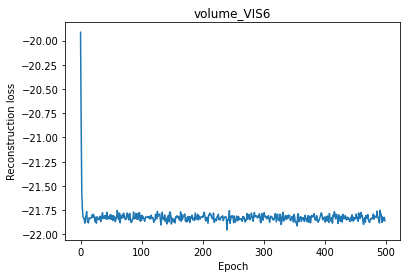

In [122]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
for f in files:
    opts=dict(best_hyper[best_hyper['files'].copy()==f])
    settings=set_settings(opts,modload=False,save=True)
    helpers.train_network(settings)
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)
Audio(wave, rate=10000, autoplay=True)

# Get embeddings

In [123]:
dat=list()
dfs=list()
for f in files:
    # replace placeholders in template
    opts=dict(best_hyper[best_hyper['files'].copy()==f])
    opts['nbatch'].iloc[0]=sample_size
    settings=set_settings(opts,nepochs=1,modload=True,save=False)
    print(settings)
    #run
    encs,encz,d=helpers.enc_network(settings)

    # make deterministic embeddings
    subj=pd.read_csv('python_names/'+re.sub('.csv','',f)+'_subj.csv')['x']
    sc=pd.DataFrame({'scode_'+re.sub('.csv','',f):pd.Series(np.array([i for i in encs])),'SUBJID':subj})  
    zc=pd.DataFrame({'zcode_'+re.sub('.csv','',f):pd.Series(np.array([i[0] for i in encz])),'SUBJID':subj})
    enc=pd.merge(sc, zc, on = 'SUBJID')
    
    # save out individual file's metadata
    enc.to_csv('Saved_Networks/'+re.sub('.csv','',f)+'_meta.csv',index = False)
    dfs.append(enc)
    dat.append(d)

# join metadata
enc_vars=[pd.read_csv('Saved_Networks/'+re.sub('.csv','',f)+'_meta.csv') for f in files]
meta=helpers.merge_dat(enc_vars)
meta[meta.columns[['Unnamed' not in i for i in meta.columns]]].to_csv('metaenc.csv',index= False)

dat_dic=dict(zip(files,dat))


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/ADAM_Metallopeptidase_subgraph.csv --types_file data_python/ADAM_Metallopeptidase_subgraph_types.csv          --batch_size 1445 --save 2 --save_file ADAM_Metallopeptidase_subgraph        --dim_latent_s 3 --dim_latent_z 1 --dim_latent_y 1         --miss_percentage_train 0 --miss_percentage_test 0         --true_miss_file data_python/ADAM_Metallopeptidase_subgraph_missing.csv --learning_rate 0.01
hrhffhfhfhf
argvals
['--epochs', '1', '--model_name', 'model_HIVAE_inputDropout', '--restore', '1', '--data_file', 'data_python/ADAM_Metallopeptidase_subgraph.csv', '--types_file', 'data_python/ADAM_Metallopeptidase_subgraph_types.csv', '--batch_size', '1445', '--save', '2', '--save_file', 'ADAM_Metallopeptidase_subgraph', '--dim_latent_s', '3', '--dim_latent_z', '1', '--dim_latent_y', '1', '--miss_percentage_train', '0', '--miss_percentage_test', '0', '--true_miss_file', 'data_python/ADAM_Metallopeptida

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/APOE_subgraph/APOE_subgraph.ckpt
Model restored: ./Saved_Networks/APOE_subgraph/APOE_subgraph.ckpt
Number of cols
2
Number of cols
2
params
[{'s': array([[ 4.6963487, -4.9004307],
       [-6.215685 ,  5.992296 ],
       [-3.075894 ,  2.8826778],
       ...,
       [ 3.9841063, -3.9841058],
       [ 3.9841063, -3.9841058],
       [ 3.9841063, -3.9841058]], dtype=float32), 'z': [array([[ 8.089138 ],
       [-7.4324756],
       [-6.022939 ],
       ...,
       [ 7.9778285],
       [ 7.9778285],
       [ 7.9778285]], dtype=float32), array([[-2.3014843e-04],
       [-2.9382914e-01],
       [-5.3443927e-01],
       ...,
       [ 2.0423494e-02],
       [ 2.0423494e-02],
       [ 2.0423494e-02]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/ATP_binding_cassette_transport_subgraph.csv --t

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ATP_binding_cassette_transport_subgraph/ATP_binding_cassette_transport_subgraph.ckpt
Model restored: ./Saved_Networks/ATP_binding_cassette_transport_subgraph/ATP_binding_cassette_transport_subgraph.ckpt
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Nu

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Decoder...
[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Amyloidogenic_subgraph/Amyloidogenic_subgraph.ckpt
Model restored: ./Saved_Networks/Amyloidogenic_subgraph/Amyloidogenic_subgraph.ckpt
Number of cols
4
Number of cols
4
Number of cols
4
Number of cols
4
params
[{'s': array([[-4.6413555,  4.53037  ],
       [-4.885049 ,  4.7694755],
       [-4.8257146,  4.600533 ],
       ...,
       [-4.0106316,  4.010631 ],
       [-4.0106316,  4.010631 ],
       [-4.0106316,  4.010631 ]], dtype=float32), 'z': [array([[-4.3831453],
       [-5.4115863],
       [-5.421945 ],
       ...,
       [-4.79594  ],
       [-4.79594  ],
       [-4.79594  ]], dtype=float32), array([[-2.6562035e-01],
       [-3.4776163e-01],
       [-3.4750032e-01],
       ...,
       [ 3.3289194e-05],
       [ 3.3289194e-05],
       [ 3.3289194e-05]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropo

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Apoptosis_signaling_subgraph/Apoptosis_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Apoptosis_signaling_subgraph/Apoptosis_signaling_subgraph.ckpt
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
params
[{'s': array([[ 10.585717 ,  -7.110549 ,  -9.3174095],
       [ 10.622212 ,  -7.945985 ,  -9.010368 ],
       [ -6.3629103, -10.9222765,   7.527273 ],
       ...,
       [  1.5554458,  11.860641 ,  -3.5581331],
       [  1.5554458,  11.860641 ,  -3.5581331],
       [  1.5554458,  11.860641 ,  -3.5581331]], dtype=float32), 'z': [array([[-0.67266357],
       [-0.7111354 ],
       [-8.687076  ],
       ...,
       [-2.1398568 ],
       [-2.1398568 ],
       [-2.1398568 ]], dtype=float32), array([[-2.2591388e-01],
       [-3.6286271e-0

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Axonal_guidance_subgraph/Axonal_guidance_subgraph.ckpt
Model restored: ./Saved_Networks/Axonal_guidance_subgraph/Axonal_guidance_subgraph.ckpt
Number of cols
4
Number of cols
4
Number of cols
4
Number of cols
4
params
[{'s': array([[-6.7870717,  6.6651793],
       [-6.1265407,  6.0413003],
       [ 5.609895 , -5.728192 ],
       ...,
       [-5.5630126,  5.5630183],
       [-5.5630126,  5.5630183],
       [-5.5630126,  5.5630183]], dtype=float32), 'z': [array([[ 0.6610377 ],
       [ 0.64399135],
       [-7.1778326 ],
       ...,
       [ 0.8008354 ],
       [ 0.8008354 ],
       [ 0.8008354 ]], dtype=float32), array([[-0.1196728 ],
       [-0.10802569],
       [-0.01328173],
       ...,
       [-0.01642913],
       [-0.01642913],
       [-0.01642913]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --dat

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Caspase_subgraph/Caspase_subgraph.ckpt
Model restored: ./Saved_Networks/Caspase_subgraph/Caspase_subgraph.ckpt
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
params
[{'s': array([[ -9.140305 ,  -7.720579 ,  14.817813 ],
       [-12.208531 ,  -8.849333 ,  19.520765 ],
       [ -9.614128 ,  -8.768522 ,  16.562284 ],
       ...,
       [  1.5367926,  12.527346 ,  -3.0394928],
       [  1.5367926,  12.527346 ,  -3.0394928],
       [  1.5367926,  12.527346 ,  -3.0394928]], dtype=float32), 'z': [array([[5.6792116],
       [5.6988916],
       [5.5213423],
       ...,
       [0.9577537],
       [0.9577537],
       [0.9577537]], dtype=float32), array([[-0.09393971],
       [-0.17686681],
       [

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Chemokine_signaling_subgraph/Chemokine_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Chemokine_signaling_subgraph/Chemokine_signaling_subgraph.ckpt
Number of cols
2
Number of cols
2
params
[{'s': array([[  3.3382487, -10.939818 ,  -2.4766722],
       [  3.3382487, -10.939818 ,  -2.4766722],
       [ -9.926495 ,  11.96453  ,   2.5383096],
       ...,
       [ -5.059006 ,   9.936791 ,  -0.5486747],
       [ -5.059006 ,   9.936791 ,  -0.5486747],
       [ -5.059006 ,   9.936791 ,  -0.5486747]], dtype=float32), 'z': [array([[21.487411],
       [21.487411],
       [-6.069368],
       ...,
       [-6.019649],
       [-6.019649],
       [-6.019649]], dtype=float32), array([[-0.01692583],
       [-0.01692583],
       [-0.09350341],
       ...,
       [-0.01571923],
       [-0.01571923],
       [-0.01571923]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --m

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Cholesterol_metabolism_subgraph/Cholesterol_metabolism_subgraph.ckpt
Model restored: ./Saved_Networks/Cholesterol_metabolism_subgraph/Cholesterol_metabolism_subgraph.ckpt
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
params
[{'s': array([[ -5.6056557 , -12.559362  ,  15.603054  ],
       [ -0.83951664,  15.118888  ,  -7.4601593 ],
       [  5.890684  ,  -3.9613261 ,  -0.5044837 ],
       ...,
       [  7.757513  ,  -1.936633  ,  -3.3660755 ],
       [  7.757513  ,  -1.936633  ,  -3.3660755 ],
       [  7.757513  ,  -1.936633  ,  -3.3660755 ]], dtype=float32), 'z': [array([[11.197563 ],
       [-3.7853303],
       [ 3.429428 ],
       ...,
       [ 2.3153224],
       [ 2.3153224],
       [ 2.3153224]], dtype=float32), array([[ 0.01551913],
       [-0.24263994],
     

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/GSK3_subgraph/GSK3_subgraph.ckpt
Model restored: ./Saved_Networks/GSK3_subgraph/GSK3_subgraph.ckpt
Number of cols
3
Number of cols
3
Number of cols
3
params
[{'s': array([[11.126238 , -3.741601 , -0.7612424],
       [ 2.3467267, -9.359749 , 11.755729 ],
       [11.126238 , -3.741601 , -0.7612424],
       ...,
       [-0.1283183, -5.303586 ,  7.599129 ],
       [-0.1283183, -5.303586 ,  7.599129 ],
       [-0.1283183, -5.303586 ,  7.599129 ]], dtype=float32), 'z': [array([[ 2.4540553],
       [-3.643539 ],
       [ 2.4540553],
       ...,
       [-3.6986046],
       [-3.6986046],
       [-3.6986046]], dtype=float32), array([[-0.03718811],
       [-0.22100012],
       [-0.03718811],
       ...,
       [ 0.03434212],
       [ 0.03434212],
       [ 0.03434212]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Inflammatory_response_subgraph/Inflammatory_response_subgraph.ckpt
Model restored: ./Saved_Networks/Inflammatory_response_subgraph/Inflammatory_response_subgraph.ckpt
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8
params
[{'s': array([[ 14.6075945,  -6.9286513,  -9.964712 ],
       [ 15.225657 ,  -7.165031 , -10.4190445],
       [ 13.347047 ,  -6.2364154,  -8.858307 ],
       ...,
       [  0.9745322,   7.8151727,  -2.70405  ],
       [  0.9745322,   7.8151727,  -2.70405  ],
       [  0.9745322,   7.8151727,  -2.70405  ]], dtype=float32), 'z': [array([[ 6.7382827],
       [ 7.084659 ],
       [ 7.095993 ],
       ...,
       [-2.3822691],
       [-2.3822691],
       [-2.3822691]], dtype=float32), array([[-0.06109925],
       [-0.06985738],
       [-0.10636046],
       ...,
       [ 0

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Insulin_signal_transduction/Insulin_signal_transduction.ckpt
Model restored: ./Saved_Networks/Insulin_signal_transduction/Insulin_signal_transduction.ckpt
Number of cols
1
minimum
0
maximum
2
params
[{'s': array([[ 4.082437 , -4.1979256],
       [ 4.082437 , -4.1979256],
       [ 4.082437 , -4.1979256],
       ...,
       [-2.336873 ,  2.336874 ],
       [-2.336873 ,  2.336874 ],
       [-2.336873 ,  2.336874 ]], dtype=float32), 'z': [array([[9.163479  ],
       [9.163479  ],
       [9.163479  ],
       ...,
       [0.43600225],
       [0.43600225],
       [0.43600225]], dtype=float32), array([[-0.00765221],
       [-0.00765221],
       [-0.00765221],
       ...,
       [-0.0043424 ],
       [-0.0043424 ],
       [-0.0043424 ]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/Interferon_signaling_subgraph.csv --

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Interferon_signaling_subgraph/Interferon_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Interferon_signaling_subgraph/Interferon_signaling_subgraph.ckpt
Number of cols
2
Number of cols
2
params
[{'s': array([[ 8.289017 , -3.5087533, -4.231574 , -2.2680197],
       [-3.0411494, -6.011291 , -2.5138981,  8.499838 ],
       [-3.0411494, -6.011291 , -2.5138981,  8.499838 ],
       ...,
       [ 2.6783407,  7.8514066,  1.96435  , -1.9438804],
       [ 2.6783407,  7.8514066,  1.96435  , -1.9438804],
       [ 2.6783407,  7.8514066,  1.96435  , -1.9438804]], dtype=float32), 'z': [array([[-10.047319 ],
       [  8.286435 ],
       [  8.286435 ],
       ...,
       [ -1.1024723],
       [ -1.1024723],
       [ -1.1024723]], dtype=float32), array([[-0.00792506],
       [-0.00776534],
       [-0.00776534],
       ...,
       [-0.00186081],
       [-0.00186081],
       [-0.0

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Interleukin_signaling_subgraph/Interleukin_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Interleukin_signaling_subgraph/Interleukin_signaling_subgraph.ckpt
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
params
[{'s': array([[ 3.8690186, 24.090855 ,  1.0908961],
       [-4.330229 ,  3.274739 , 29.324944 ],
       [-4.106058 ,  2.9972584, 27.771618 ],
       ...,
       [13.909779 , -2.3782914, -6.305766 ],
       [13.909779 , -2.3782914, -6.305766 ],
       [13.909779 , -2.3782914, -6.305766 ]], dtype=float

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Lipid_metabolism_subgraph/Lipid_metabolism_subgraph.ckpt
Model restored: ./Saved_Networks/Lipid_metabolism_subgraph/Lipid_metabolism_subgraph.ckpt
Number of cols
7
Number of cols
7
Number of cols
7
Number of cols
7
Number of cols
7
Number of cols
7
Number of cols
7
params
[{'s': array([[-0.4030888 , -2.8143206 , 10.888136  ],
       [12.570075  , -0.16414165, -4.405418  ],
       [-1.6287196 , -4.8174753 , 13.19726   ],
       ...,
       [ 2.035135  , 11.421992  , -3.5303845 ],
       [ 2.035135  , 11.421992  , -3.5303845 ],
       [ 2.035135  , 11.421992  , -3.5303845 ]], dtype=float32), 'z': [array([[6.9573555 ],
       [0.04918563],
       [7.337166  ],
       ...,
       [1.6708219 ],
       [1.6708219 ],
       [1.6708219 ]], dtype=float32), array([[-0.27348286],
       [-0.84744316],
       [-0.24895482],
       ...,
       [-0.00361909],
       [-0.00361909],
   

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Attention_Concentration_VIS12/MMSE_Attention_Concentration_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Attention_Concentration_VIS12/MMSE_Attention_Concentration_VIS12.ckpt
Number of cols
1
minimum
0
maximum
5
params
[{'s': array([[ 4.597603 , -4.5722003],
       [ 4.597603 , -4.5722003],
       [ 4.597603 , -4.5722003],
       ...,
       [ 4.597603 , -4.5722003],
       [ 4.597603 , -4.5722003],
       [-2.91729  ,  2.9172912]], dtype=float32), 'z': [array([[ 7.0106807],
       [ 7.0106807],
       [ 7.0106807],
       ...,
       [ 7.0106807],
       [ 7.0106807],
       [-0.8886102]], dtype=float32), array([[-0.00068916],
       [-0.00068916],
       [-0.00068916],
       ...,
       [-0.00068916],
       [-0.00068916],
       [-0.00309046]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Att

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Attention_Concentration_VIS24/MMSE_Attention_Concentration_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Attention_Concentration_VIS24/MMSE_Attention_Concentration_VIS24.ckpt
Number of cols
1
minimum
0
maximum
5
params
[{'s': array([[0.03460312],
       [0.03460312],
       [0.03460312],
       ...,
       [0.03460312],
       [0.03460312],
       [0.03460312]], dtype=float32), 'z': [array([[-2.3523662],
       [-2.3523662],
       [-2.3523662],
       ...,
       [-2.3523662],
       [-2.3523662],
       [-2.3523662]], dtype=float32), array([[-0.06809466],
       [-0.06809466],
       [-0.06809466],
       ...,
       [-0.06809466],
       [-0.06809466],
       [-0.06809466]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Attention_Concentration_VIS36.csv --types_fil

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Attention_Concentration_VIS36/MMSE_Attention_Concentration_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Attention_Concentration_VIS36/MMSE_Attention_Concentration_VIS36.ckpt
Number of cols
1
minimum
0
maximum
5
params
[{'s': array([[-0.05599117],
       [-0.05599117],
       [-0.05599117],
       ...,
       [-0.05599117],
       [ 0.        ],
       [ 0.        ]], dtype=float32), 'z': [array([[-2.2585611],
       [-2.2585611],
       [-2.2585611],
       ...,
       [-2.2585611],
       [-2.1430123],
       [-2.1430123]], dtype=float32), array([[-0.05874316],
       [-0.05874316],
       [-0.05874316],
       ...,
       [-0.05874316],
       [ 0.00644079],
       [ 0.00644079]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Attention_Concentration_VIS6.csv --type

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Attention_Concentration_VIS6/MMSE_Attention_Concentration_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Attention_Concentration_VIS6/MMSE_Attention_Concentration_VIS6.ckpt
Number of cols
1
minimum
0
maximum
5
params
[{'s': array([[ 3.944357 , -3.8511934],
       [ 3.944357 , -3.8511934],
       [ 3.944357 , -3.8511934],
       ...,
       [ 3.944357 , -3.8511934],
       [ 3.944357 , -3.8511934],
       [ 3.944357 , -3.8511934]], dtype=float32), 'z': [array([[7.166171],
       [7.166171],
       [7.166171],
       ...,
       [7.166171],
       [7.166171],
       [7.166171]], dtype=float32), array([[0.00444006],
       [0.00444006],
       [0.00444006],
       ...,
       [0.00444006],
       [0.00444006],
       [0.00444006]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Language_VIS12/MMSE_Language_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Language_VIS12/MMSE_Language_VIS12.ckpt
Number of cols
1
minimum
2
maximum
9
params
[{'s': array([[-2.6684961, -5.44148  ,  5.0257425],
       [-2.6684961, -5.44148  ,  5.0257425],
       [-2.6684961, -5.44148  ,  5.0257425],
       ...,
       [-2.6684961, -5.44148  ,  5.0257425],
       [ 5.86163  , -1.8752484, -3.9462018],
       [ 1.7912828,  4.646791 , -2.5294087]], dtype=float32), 'z': [array([[ 8.998166  ],
       [ 8.998166  ],
       [ 8.998166  ],
       ...,
       [ 8.998166  ],
       [-0.10651219],
       [-0.63702464]], dtype=float32), array([[-0.02419458],
       [-0.02419458],
       [-0.02419458],
       ...,
       [-0.02419458],
       [-0.89565384],
       [-0.00270776]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --re

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Language_VIS24/MMSE_Language_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Language_VIS24/MMSE_Language_VIS24.ckpt
Number of cols
1
minimum
0
maximum
9
params
[{'s': array([[-3.250657 ,  5.4116654, -5.914544 ],
       [-3.250657 ,  5.4116654, -5.914544 ],
       [-3.250657 ,  5.4116654, -5.914544 ],
       ...,
       [-3.250657 ,  5.4116654, -5.914544 ],
       [ 3.7713213, -1.7445431, -3.4164066],
       [-3.250657 ,  5.4116654, -5.914544 ]], dtype=float32), 'z': [array([[8.367212  ],
       [8.367212  ],
       [8.367212  ],
       ...,
       [8.367212  ],
       [0.82944417],
       [8.367212  ]], dtype=float32), array([[ 0.00458065],
       [ 0.00458065],
       [ 0.00458065],
       ...,
       [ 0.00458065],
       [-0.4797331 ],
       [ 0.00458065]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Language_VIS36/MMSE_Language_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Language_VIS36/MMSE_Language_VIS36.ckpt
Number of cols
1
minimum
0
maximum
9
params
[{'s': array([[-3.415637 , -2.0783768,  3.395781 ],
       [-3.415637 , -2.0783768,  3.395781 ],
       [ 3.4002783, -4.90291  , -3.3772097],
       ...,
       [-3.415637 , -2.0783768,  3.395781 ],
       [-3.1639922,  5.0087185,  2.0769682],
       [-3.1639922,  5.0087185,  2.0769682]], dtype=float32), 'z': [array([[-1.1163485],
       [-1.1163485],
       [-8.435401 ],
       ...,
       [-1.1163485],
       [ 0.6909441],
       [ 0.6909441]], dtype=float32), array([[-0.45663643],
       [-0.45663643],
       [-0.01016271],
       ...,
       [-0.45663643],
       [-0.00323139],
       [-0.00323139]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Language_VIS6/MMSE_Language_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Language_VIS6/MMSE_Language_VIS6.ckpt
Number of cols
1
minimum
1
maximum
9
params
[{'s': array([[-3.948754 , -2.6693842,  4.6046553],
       [-6.117448 ,  4.75572  , -2.6566908],
       [-6.117448 ,  4.75572  , -2.6566908],
       ...,
       [-6.117448 ,  4.75572  , -2.6566908],
       [-2.3023403, -4.2936134,  5.948189 ],
       [-6.117448 ,  4.75572  , -2.6566908]], dtype=float32), 'z': [array([[1.4387856 ],
       [9.305168  ],
       [9.305168  ],
       ...,
       [9.305168  ],
       [0.28146535],
       [9.305168  ]], dtype=float32), array([[-0.39219385],
       [ 0.00345252],
       [ 0.00345252],
       ...,
       [ 0.00345252],
       [-0.9371443 ],
       [ 0.00345252]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1   

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Memory_Recall_VIS12/MMSE_Memory_Recall_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Memory_Recall_VIS12/MMSE_Memory_Recall_VIS12.ckpt
Number of cols
1
minimum
0
maximum
3
params
[{'s': array([[ 3.141193 , -3.052969 ],
       [ 3.141193 , -3.052969 ],
       [ 3.141193 , -3.052969 ],
       ...,
       [ 3.141193 , -3.052969 ],
       [-2.4679432,  2.6061697],
       [-3.232719 ,  3.2327204]], dtype=float32), 'z': [array([[ 6.789569  ],
       [ 6.789569  ],
       [ 6.789569  ],
       ...,
       [ 6.789569  ],
       [-0.75253665],
       [-1.6152464 ]], dtype=float32), array([[-0.00848019],
       [-0.00848019],
       [-0.00848019],
       ...,
       [-0.00848019],
       [-0.6379489 ],
       [ 0.01190341]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Memory_

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Memory_Recall_VIS24/MMSE_Memory_Recall_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Memory_Recall_VIS24/MMSE_Memory_Recall_VIS24.ckpt
Number of cols
1
minimum
0
maximum
3
params
[{'s': array([[-2.7810893,  2.6066022],
       [ 5.8209343, -6.089951 ],
       [ 5.8209343, -6.089951 ],
       ...,
       [ 5.8209343, -6.089951 ],
       [ 5.8209343, -6.089951 ],
       [ 5.8209343, -6.089951 ]], dtype=float32), 'z': [array([[-1.92049 ],
       [12.621757],
       [12.621757],
       ...,
       [12.621757],
       [12.621757],
       [12.621757]], dtype=float32), array([[-0.351484 ],
       [ 0.0380347],
       [ 0.0380347],
       ...,
       [ 0.0380347],
       [ 0.0380347],
       [ 0.0380347]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Memory_Recall_VIS36.csv -

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Memory_Recall_VIS36/MMSE_Memory_Recall_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Memory_Recall_VIS36/MMSE_Memory_Recall_VIS36.ckpt
Number of cols
1
minimum
0
maximum
3
params
[{'s': array([[ 4.1147738, -4.028237 ],
       [ 4.1147738, -4.028237 ],
       [ 4.1147738, -4.028237 ],
       ...,
       [-5.2874284,  5.424166 ],
       [-5.8428326,  5.84287  ],
       [-5.8428326,  5.84287  ]], dtype=float32), 'z': [array([[-13.935899 ],
       [-13.935899 ],
       [-13.935899 ],
       ...,
       [  1.9337835],
       [  2.3146434],
       [  2.3146434]], dtype=float32), array([[-0.04557668],
       [-0.04557668],
       [-0.04557668],
       ...,
       [-0.08971077],
       [-0.02774326],
       [-0.02774326]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Memory_

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Memory_Recall_VIS6/MMSE_Memory_Recall_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Memory_Recall_VIS6/MMSE_Memory_Recall_VIS6.ckpt
Number of cols
1
minimum
0
maximum
3
params
[{'s': array([[ 6.3015804, -6.294116 ],
       [ 6.3015804, -6.294116 ],
       [ 6.3015804, -6.294116 ],
       ...,
       [ 6.3015804, -6.294116 ],
       [ 6.3015804, -6.294116 ],
       [-2.388589 ,  2.4430485]], dtype=float32), 'z': [array([[-13.310244 ],
       [-13.310244 ],
       [-13.310244 ],
       ...,
       [-13.310244 ],
       [-13.310244 ],
       [  1.6661773]], dtype=float32), array([[ 0.02428621],
       [ 0.02428621],
       [ 0.02428621],
       ...,
       [ 0.02428621],
       [ 0.02428621],
       [-0.4634606 ]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Orientation

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Orientation_VIS12/MMSE_Orientation_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Orientation_VIS12/MMSE_Orientation_VIS12.ckpt
Number of cols
1
minimum
0
maximum
10
params
[{'s': array([[ 3.1673887, -3.436537 ],
       [-2.987537 ,  2.6657112],
       [-2.987537 ,  2.6657112],
       ...,
       [ 3.1673887, -3.436537 ],
       [-2.987537 ,  2.6657112],
       [-2.783273 ,  2.783273 ]], dtype=float32), 'z': [array([[7.7451057 ],
       [0.84726554],
       [0.84726554],
       ...,
       [7.7451057 ],
       [0.84726554],
       [0.11067981]], dtype=float32), array([[ 0.00647673],
       [-0.6866777 ],
       [-0.6866777 ],
       ...,
       [ 0.00647673],
       [-0.6866777 ],
       [-0.00330482]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Orientation_VIS24.cs

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Orientation_VIS24/MMSE_Orientation_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Orientation_VIS24/MMSE_Orientation_VIS24.ckpt
Number of cols
1
minimum
0
maximum
10
params
[{'s': array([[ 3.089    , -3.271783 ],
       [ 3.089    , -3.271783 ],
       [ 3.089    , -3.271783 ],
       ...,
       [ 3.089    , -3.271783 ],
       [-5.0302515,  4.861659 ],
       [ 3.089    , -3.271783 ]], dtype=float32), 'z': [array([[-7.4265375 ],
       [-7.4265375 ],
       [-7.4265375 ],
       ...,
       [-7.4265375 ],
       [ 0.16808224],
       [-7.4265375 ]], dtype=float32), array([[-0.00200678],
       [-0.00200678],
       [-0.00200678],
       ...,
       [-0.00200678],
       [-1.1342204 ],
       [-0.00200678]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Orientation_VI

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Orientation_VIS36/MMSE_Orientation_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Orientation_VIS36/MMSE_Orientation_VIS36.ckpt
Number of cols
1
minimum
0
maximum
10
params
[{'s': array([[-0.01129526],
       [-0.10001409],
       [-0.01129526],
       ...,
       [-0.10001409],
       [ 0.        ],
       [ 0.        ]], dtype=float32), 'z': [array([[-2.22535  ],
       [-2.7857125],
       [-2.22535  ],
       ...,
       [-2.7857125],
       [-2.3738081],
       [-2.3738081]], dtype=float32), array([[-0.40128374],
       [-0.2197359 ],
       [-0.40128374],
       ...,
       [-0.2197359 ],
       [-0.00364961],
       [-0.00364961]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Orientation_VIS6.csv --types_file data_python/MMSE_Orientation_VIS6_types.csv         

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Orientation_VIS6/MMSE_Orientation_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Orientation_VIS6/MMSE_Orientation_VIS6.ckpt
Number of cols
1
minimum
0
maximum
10
params
[{'s': array([[-3.4059026 ,  4.1502056 , -1.7275362 ],
       [-3.4059026 ,  4.1502056 , -1.7275362 ],
       [-3.4059026 ,  4.1502056 , -1.7275362 ],
       ...,
       [ 4.4717    , -3.362609  , -5.47278   ],
       [-6.8439565 ,  0.78626704,  9.851551  ],
       [-3.4059026 ,  4.1502056 , -1.7275362 ]], dtype=float32), 'z': [array([[ 4.8410263],
       [ 4.8410263],
       [ 4.8410263],
       ...,
       [13.127548 ],
       [-1.0100843],
       [ 4.8410263]], dtype=float32), array([[-0.06344843],
       [-0.06344843],
       [-0.06344843],
       ...,
       [-0.0088338 ],
       [-1.3162541 ],
       [-0.06344843]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HI

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Working_Memory_Registration_VIS12/MMSE_Working_Memory_Registration_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Working_Memory_Registration_VIS12/MMSE_Working_Memory_Registration_VIS12.ckpt
Number of cols
1
minimum
0
maximum
3
params
[{'s': array([[-0.14098696],
       [-0.14098696],
       [-0.14098696],
       ...,
       [-0.14098696],
       [-0.14098696],
       [ 0.        ]], dtype=float32), 'z': [array([[2.9032187],
       [2.9032187],
       [2.9032187],
       ...,
       [2.9032187],
       [2.9032187],
       [2.8695903]], dtype=float32), array([[-2.8409956e-02],
       [-2.8409956e-02],
       [-2.8409956e-02],
       ...,
       [-2.8409956e-02],
       [-2.8409956e-02],
       [ 6.9797039e-05]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Working_Mem

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Working_Memory_Registration_VIS24/MMSE_Working_Memory_Registration_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Working_Memory_Registration_VIS24/MMSE_Working_Memory_Registration_VIS24.ckpt
Number of cols
1
minimum
0
maximum
3
params
[{'s': array([[-0.13405117],
       [-0.13405117],
       [-0.13405117],
       ...,
       [-0.13405117],
       [-0.13405117],
       [-0.13405117]], dtype=float32), 'z': [array([[2.819486],
       [2.819486],
       [2.819486],
       ...,
       [2.819486],
       [2.819486],
       [2.819486]], dtype=float32), array([[-0.03512795],
       [-0.03512795],
       [-0.03512795],
       ...,
       [-0.03512795],
       [-0.03512795],
       [-0.03512795]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Working_Memory_Registration_VIS36.c

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Working_Memory_Registration_VIS36/MMSE_Working_Memory_Registration_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Working_Memory_Registration_VIS36/MMSE_Working_Memory_Registration_VIS36.ckpt
Number of cols
1
minimum
0
maximum
3
params
[{'s': array([[-0.06560729],
       [-0.06560729],
       [-0.06560729],
       ...,
       [-0.06560729],
       [ 0.        ],
       [ 0.        ]], dtype=float32), 'z': [array([[-2.226808 ],
       [-2.226808 ],
       [-2.226808 ],
       ...,
       [-2.226808 ],
       [-2.1892388],
       [-2.1892388]], dtype=float32), array([[-0.03340739],
       [-0.03340739],
       [-0.03340739],
       ...,
       [-0.03340739],
       [-0.00456102],
       [-0.00456102]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/MMSE_Working_Memory_Registra

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Working_Memory_Registration_VIS6/MMSE_Working_Memory_Registration_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Working_Memory_Registration_VIS6/MMSE_Working_Memory_Registration_VIS6.ckpt
Number of cols
1
minimum
0
maximum
3
params
[{'s': array([[ 4.5535774, -4.44934  ],
       [ 4.5535774, -4.44934  ],
       [ 4.5535774, -4.44934  ],
       ...,
       [ 4.5535774, -4.44934  ],
       [ 4.5535774, -4.44934  ],
       [ 4.5535774, -4.44934  ]], dtype=float32), 'z': [array([[-7.4612665],
       [-7.4612665],
       [-7.4612665],
       ...,
       [-7.4612665],
       [-7.4612665],
       [-7.4612665]], dtype=float32), array([[-0.00099334],
       [-0.00099334],
       [-0.00099334],
       ...,
       [-0.00099334],
       [-0.00099334],
       [-0.00099334]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Matrix_metalloproteinase_subgraph/Matrix_metalloproteinase_subgraph.ckpt
Model restored: ./Saved_Networks/Matrix_metalloproteinase_subgraph/Matrix_metalloproteinase_subgraph.ckpt
Number of cols
5
Number of cols
5
Number of cols
5
Number of cols
5
Number of cols
5
params
[{'s': array([[ -4.4468255,  15.866732 ,  -3.6459641],
       [ 10.398285 ,   2.3960733, -11.028207 ],
       [ -4.5229177,  16.190268 ,  -4.21207  ],
       ...,
       [ -4.244855 ,   7.9613776,  -2.3265116],
       [ -4.244855 ,   7.9613776,  -2.3265116],
       [ -4.244855 ,   7.9613776,  -2.3265116]], dtype=float32), 'z': [array([[ -0.26417506],
       [-13.969432  ],
       [ -0.3998927 ],
       ...,
       [ -0.3714826 ],
       [ -0.3714826 ],
       [ -0.3714826 ]], dtype=float32), array([[-0.1023938 ],
       [-0.05258885],
       [-0.06729981],
       ...,
       [ 0.0091845 ],
       [ 0.0091

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Nerve_growth_factor_subgraph/Nerve_growth_factor_subgraph.ckpt
Model restored: ./Saved_Networks/Nerve_growth_factor_subgraph/Nerve_growth_factor_subgraph.ckpt
Number of cols
1
minimum
0
maximum
2
params
[{'s': array([[ 3.801883 , -3.7900486],
       [ 3.801883 , -3.7900486],
       [-3.4855154,  3.6403387],
       ...,
       [-3.1789453,  3.1789489],
       [-3.1789453,  3.1789489],
       [-3.1789453,  3.1789489]], dtype=float32), 'z': [array([[-9.047085  ],
       [-9.047085  ],
       [-0.41545534],
       ...,
       [-0.268592  ],
       [-0.268592  ],
       [-0.268592  ]], dtype=float32), array([[-0.00433003],
       [-0.00433003],
       [-0.21941692],
       ...,
       [ 0.00712468],
       [ 0.00712468],
       [ 0.00712468]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/Tau_protein_subgraph.csv -

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Tau_protein_subgraph/Tau_protein_subgraph.ckpt
Model restored: ./Saved_Networks/Tau_protein_subgraph/Tau_protein_subgraph.ckpt
Number of cols
2
Number of cols
2
params
[{'s': array([[ 0.98583716, -6.929342  ,  8.865998  ],
       [-3.6114852 ,  9.147128  , -8.242744  ],
       [-3.6114852 ,  9.147128  , -8.242744  ],
       ...,
       [ 0.04247586, -5.2803907 ,  5.9716287 ],
       [ 0.04247586, -5.2803907 ,  5.9716287 ],
       [ 0.04247586, -5.2803907 ,  5.9716287 ]], dtype=float32), 'z': [array([[  4.5327992],
       [-14.827958 ],
       [-14.827958 ],
       ...,
       [  4.5331674],
       [  4.5331674],
       [  4.5331674]], dtype=float32), array([[-0.0005172 ],
       [-0.00025843],
       [-0.00025843],
       ...,
       [-0.00011912],
       [-0.00011912],
       [-0.00011912]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVA

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Wnt_signaling_subgraph/Wnt_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Wnt_signaling_subgraph/Wnt_signaling_subgraph.ckpt
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
params
[{'s': array([[  8.90727   , -10.007075  ,  -2.2884574 ],
       [ -3.1098804 ,  -2.1100135 ,   8.864776  ],
       [ -5.0171995 ,  -0.94387877,   9.555719  ],
       ...,
       [ -3.1636848 ,  -1.8914982 ,   7.9931874 ],
       [ -3.1636848 ,  -1.8914982 ,   7.9931874 ],
       [ -3.1636848 ,  -1.8914982 ,   7.9931874 ]], dtype=float32), 'z': [array([[11.935144 ],
       [ 1.9379007],
       [ 1.922865 ],
       ...,
       [ 1.9710312],
       [ 1.9710312],
       [ 1.9710312]], dtype=float32), array([[-0.1210628 ],
       [-0.09837383],
       [-0.12457667],
       ...,
       [-0.00694282],
       [-0.00694282],
       [-0.006

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/csf_VIS1/csf_VIS1.ckpt
Model restored: ./Saved_Networks/csf_VIS1/csf_VIS1.ckpt
Number of cols
3
Number of cols
3
Number of cols
3
params
[{'s': array([[ 0.03470296],
       [-0.14083676],
       [-0.10937984],
       ...,
       [ 0.00483384],
       [-0.08387783],
       [-0.12095122]], dtype=float32), 'z': [array([[-1.2637681],
       [ 1.871171 ],
       [ 0.608652 ],
       ...,
       [-0.7147001],
       [-1.039888 ],
       [ 1.2422621]], dtype=float32), array([[-3.5127537],
       [-3.6348195],
       [-3.5873303],
       ...,
       [-3.5334654],
       [-3.5300546],
       [-3.6097627]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/imagingPET_VIS1.csv --types_file data_python/imagingPET_VIS1_types.csv          --batch_size 1445 --save 2 --save_file imagingPET_VIS1      

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/imagingPET_VIS1/imagingPET_VIS1.ckpt
Model restored: ./Saved_Networks/imagingPET_VIS1/imagingPET_VIS1.ckpt
Number of cols
2
Number of cols
2
params
[{'s': array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ...,
       [-0.04469365],
       [ 0.06129375],
       [-0.02328509]], dtype=float32), 'z': [array([[ 0.57125974],
       [ 0.57125974],
       [ 0.57125974],
       ...,
       [ 0.1775473 ],
       [ 0.99213076],
       [-0.13750762]], dtype=float32), array([[-0.28990924],
       [-0.28990924],
       [-0.28990924],
       ...,
       [-0.19703609],
       [-0.40756702],
       [-0.20045128]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/volume_VIS1.csv --types_file data_python/volume_VIS1_types.csv          --batch_size 1445 --save 2 --save_file volume

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/volume_VIS1/volume_VIS1.ckpt
Model restored: ./Saved_Networks/volume_VIS1/volume_VIS1.ckpt
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
params
[{'s': array([[-0.03748354],
       [ 0.02605171],
       [-0.00041526],
       ...,
       [-0.08149927],
       [ 0.01609235],
       [ 0.00893221]], dtype=float32), 'z': [array([[-0.44303155],
       [-0.01954887],
       [-0.3001173 ],
       ...,
       [-0.6517712 ],
       [-0.49462682],
       [ 0.47352153]], dtype=float32), array([[-2.111508 ],
       [-2.1828976],
       [-2.1515298],
       ...,
       [-2.1707268],
       [-2.1780353],
       [-2.2053885]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/volume_VIS12.csv --types_file data_python/volume_VIS12_types.csv       

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/volume_VIS12/volume_VIS12.ckpt
Model restored: ./Saved_Networks/volume_VIS12/volume_VIS12.ckpt
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
params
[{'s': array([[ 0.00535499],
       [-0.15521091],
       [ 0.        ],
       ...,
       [ 0.08267692],
       [-0.09090988],
       [ 0.        ]], dtype=float32), 'z': [array([[0.44360673],
       [1.1988142 ],
       [0.6083912 ],
       ...,
       [0.14801162],
       [0.22568548],
       [0.6083912 ]], dtype=float32), array([[-1.7522953],
       [-1.7238476],
       [-1.7760879],
       ...,
       [-1.8252563],
       [-1.7124712],
       [-1.7760879]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/volume_VIS24.csv --types_file data_python/volume_VIS24_types.csv         

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/volume_VIS24/volume_VIS24.ckpt
Model restored: ./Saved_Networks/volume_VIS24/volume_VIS24.ckpt
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
params
[{'s': array([[-0.03037546],
       [-0.01752429],
       [-0.01316134],
       ...,
       [-0.0177292 ],
       [-0.10220933],
       [ 0.00528487]], dtype=float32), 'z': [array([[-0.55034566],
       [-0.22960368],
       [-0.20419773],
       ...,
       [-1.1764627 ],
       [-1.1576297 ],
       [ 0.11674595]], dtype=float32), array([[-1.519705 ],
       [-1.530208 ],
       [-1.5297813],
       ...,
       [-1.3673298],
       [-1.5643908],
       [-1.6599419]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])
--epochs 1 --model_name model_HIVAE_inputDropout --restore 1         --data_file data_python/volume_VIS6.csv --types_file data_python/volume_VIS6_types.csv     

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
batch size
1445
n_batches
1
INFO:tensorflow:Restoring parameters from ./Saved_Networks/volume_VIS6/volume_VIS6.ckpt
Model restored: ./Saved_Networks/volume_VIS6/volume_VIS6.ckpt
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
params
[{'s': array([[-0.01589618],
       [-0.0151525 ],
       [ 0.        ],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32), 'z': [array([[ 0.3294548 ],
       [-0.01767088],
       [ 0.2520575 ],
       ...,
       [ 0.2520575 ],
       [ 0.2520575 ],
       [ 0.2520575 ]], dtype=float32), array([[-1.8771038],
       [-1.832766 ],
       [-1.8973663],
       ...,
       [-1.8973663],
       [-1.8973663],
       [-1.8973663]], dtype=float32)]}]
keys
dict_keys(['s', 'z'])


In [112]:
ss = meta[meta.columns.drop(list(meta.filter(regex='SUBJID|scode_')))]
#ss = ss.loc[:, ss.columns.to_series().str.endswith("subgraph")]
ss

zcode_MMSE_Attention_Concentration_VIS12  \
0                                     7.180730   
1                                     7.180730   
2                                     7.180730   
3                                     7.180730   
4                                     7.180730   
...                                        ...   
1440                                  7.180730   
1441                                  7.180730   
1442                                  7.180730   
1443                                  7.180730   
1444                                 -0.630337   

      zcode_MMSE_Attention_Concentration_VIS24  \
0                                    -2.543480   
1                                    -2.543480   
2                                    -2.543480   
3                                    -2.543480   
4                                    -2.543480   
...                                        ...   
1440                                 -2.424168   
1441                                 -2.424168   
1442                                 -2.543480   
1443                                 -2.543480   
1444                                 -2.543480   

      zcode_MMSE_Attention_Concentration_VIS36  \
0                                     2.497956   
1                                     2.497956   
2                                     2.497956   
3                                     2.385577   
4                                     1.852968   
...                                        ...   
1440                                  2.385577   
1441                                  2.385577   
1442                                  2.497956   
1443                                  2.385577   
1444                                  2.385577   

      zcode_MMSE_Attention_Concentration_VIS6  zcode_MMSE_Language_VIS12  \
0                                    7.253646                 -10.941881   
1                                    7.253646                 -10.941881   
2                                    7.253646                 -10.941881   
3                                    7.253646                  -3.229587   
4                                    7.253646                   0.803507   
...                                       ...                        ...   
1440                                 7.253646                 -10.941881   
1441                                 7.253646                 -10.941881   
1442                                 7.253646                 -10.941881   
1443                                 7.253646                   0.803507   
1444                                 7.253646                   1.023540   

      zcode_MMSE_Language_VIS24  zcode_MMSE_Language_VIS36  \
0                     -8.380270                   2.700337   
1                     -8.380270                   2.700337   
2                     -8.380270                   9.463283   
3                     -0.842360                  -0.731159   
4                     -8.380270                   9.463283   
...                         ...                        ...   
1440                  -0.440436                  -0.731159   
1441                  -0.615559                  -0.731159   
1442                  -8.380270                   2.700337   
1443                  -0.842360                  -0.731159   
1444                  -8.380270                   2.532553   

      zcode_MMSE_Language_VIS6  zcode_MMSE_Memory_Recall_VIS12  \
0                    -1.388328                       -7.280041   
1                    -9.171406                       -7.280041   
2                    -9.171406                       -7.280041   
3                    -9.171406                        1.725552   
4                    -9.171406                        0.105421   
...                        ...                             ...   
1440                 -9.171406                        0.917774   
1441             

Text(0.5, 0.98, 'HI-VAE embeddings (deterministic)')

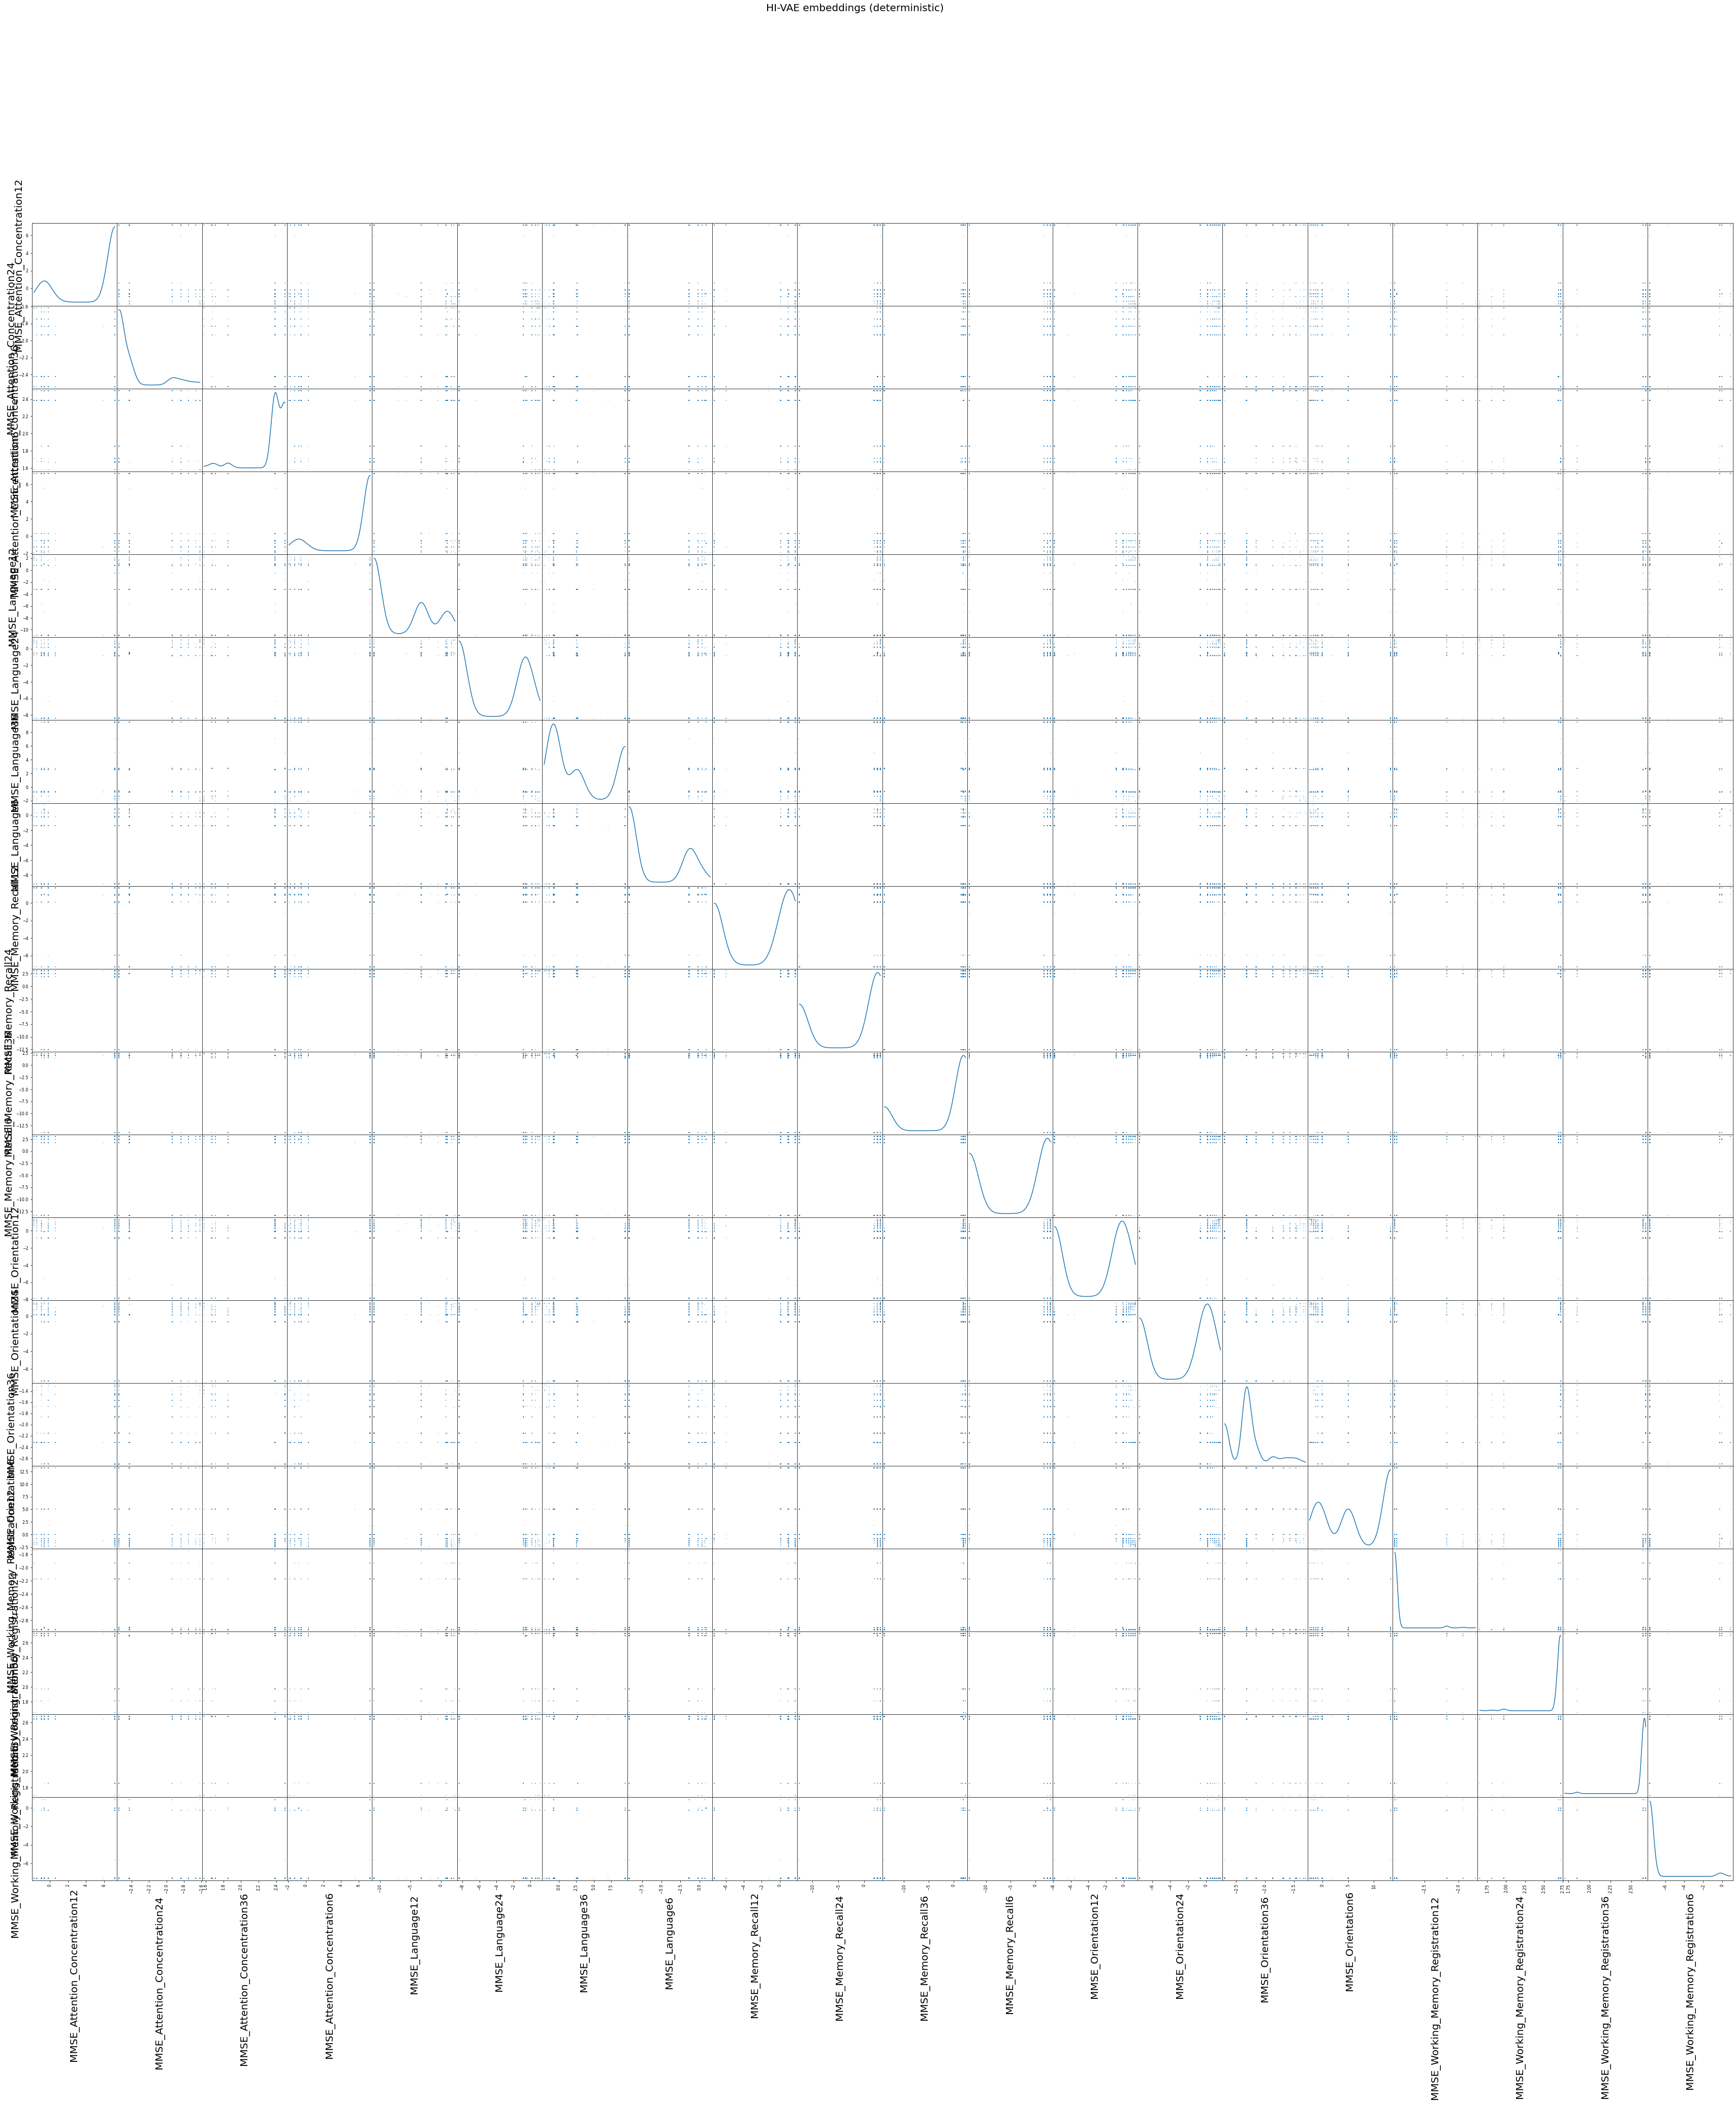

In [113]:
fig = scatter_matrix(
    #meta[meta.columns.drop(list(meta.filter(regex='SUBJID|scode_|zcode_cogtest_VIS60')))],
    ss,
    figsize  = [60, 60],
    marker   = ".",
    s        = 10,
    diagonal = "kde"
)
for ax in fig.ravel():
    ax.set_xlabel(re.sub('_VIS|zcode_','',ax.get_xlabel()), fontsize = 20, rotation = 90)
    ax.set_ylabel(re.sub('_VIS|zcode_','',ax.get_ylabel()), fontsize = 20, rotation = 90)
    
plt.suptitle('HI-VAE embeddings (deterministic)',fontsize=20)

## RP decoding (Reconstruction)

In [9]:
meta = pd.read_csv('metaenc.csv')
sample_size = len(file)
recon=list()
recdfs=list()
for f in files:
    # replace placeholders in template
    opts=dict(best_hyper[best_hyper['files'].copy()==f])
    opts['nbatch'].iloc[0]=sample_size
    settings=set_settings(opts,nepochs=1,modload=True,save=False)
    
    #run
    zcodes=meta['zcode_'+re.sub('.csv','',f)]
    scodes=meta['scode_'+re.sub('.csv','',f)]
    rec=helpers.dec_network(settings,zcodes,scodes)
    recon.append(rec)
    
    subj=pd.read_csv('python_names/'+re.sub('.csv','',f)+'_subj.csv')['x']
    names=pd.read_csv('python_names/'+re.sub('.csv','',f)+'_cols.csv')['x']
    recd=pd.DataFrame(rec)
    recd.columns=names
    recd['SUBJID']=subj
    recdfs.append(recd)
    
recon_dic=dict(zip(files,recon))

data_recon=helpers.merge_dat(recdfs)
data_recon.to_csv('reconRP.csv',index=False)

[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders

[*] Defining Encoder...
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Decoder...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.random.categorical` instead.
[*] Defining Cost function...
Instructions for updating:

Future major versi

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/APOE_subgraph/APOE_subgraph.ckpt
Model restored: ./Saved_Networks/APOE_subgraph/APOE_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
2
Number of cols
2
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ATP_binding_cassette_transport_subgraph/ATP_binding_cassette_transport_subgraph.ckpt
Model restored: ./Saved_Networks/ATP_binding_cassette_transport_subgraph/ATP_binding_cassette_transport_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number of cols
50
Number

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Amyloidogenic_subgraph/Amyloidogenic_subgraph.ckpt
Model restored: ./Saved_Networks/Amyloidogenic_subgraph/Amyloidogenic_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
4
Number of cols
4
Number of cols
4
Number of cols
4
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Apoptosis_signaling_subgraph/Apoptosis_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Apoptosis_signaling_subgraph/Apoptosis_signaling_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
Number of cols
10
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Axonal_guidance_subgraph/Axonal_guidance_subgraph.ckpt
Model restored: ./Saved_Networks/Axonal_guidance_subgraph/Axonal_guidance_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
4
Number of cols
4
Number of cols
4
Number of cols
4
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Caspase_subgraph/Caspase_subgraph.ckpt
Model restored: ./Saved_Networks/Caspase_subgraph/Caspase_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
Number of cols
13
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Chemokine_signaling_subgraph/Chemokine_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Chemokine_signaling_subgraph/Chemokine_signaling_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
2
Number of cols
2
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Cholesterol_metabolism_subgraph/Cholesterol_metabolism_subgraph.ckpt
Model restored: ./Saved_Networks/Cholesterol_metabolism_subgraph/Cholesterol_metabolism_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
Number of cols
9
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/GSK3_subgraph/GSK3_subgraph.ckpt
Model restored: ./Saved_Networks/GSK3_subgraph/GSK3_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
3
Number of cols
3
Number of cols
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Inflammatory_response_subgraph/Inflammatory_response_subgraph.ckpt
Model restored: ./Saved_Networks/Inflammatory_response_subgraph/Inflammatory_response_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8
Number of cols
8


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Insulin_signal_transduction/Insulin_signal_transduction.ckpt
Model restored: ./Saved_Networks/Insulin_signal_transduction/Insulin_signal_transduction.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
2
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Interferon_signaling_subgraph/Interferon_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Interferon_signaling_subgraph/Interferon_signaling_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
2
Number of cols
2
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Interleukin_signaling_subgraph/Interleukin_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Interleukin_signaling_subgraph/Interleukin_signaling_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
Number of cols
20
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Lipid_metabolism_subgraph/Lipid_metabolism_subgraph.ckpt
Model restored: ./Saved_Networks/Lipid_metabolism_subgraph/Lipid_metabolism_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
7
Number of cols
7
Number of cols
7
Number of cols
7
Number of cols
7
Number of cols
7
Number of cols
7
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Attention_Concentration_VIS12/MMSE_Attention_Concentration_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Attention_Concentration_VIS12/MMSE_Attention_Concentration_VIS12.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
5
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Attention_Concentration_VIS24/MMSE_Attention_Concentration_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Attention_Concentration_VIS24/MMSE_Attention_Concentration_VIS24.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
5
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Attention_Concentration_VIS36/MMSE_Attention_Concentration_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Attention_Concentration_VIS36/MMSE_Attention_Concentration_VIS36.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
5
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Attention_Concentration_VIS6/MMSE_Attention_Concentration_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Attention_Concentration_VIS6/MMSE_Attention_Concentration_VIS6.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
5
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Language_VIS12/MMSE_Language_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Language_VIS12/MMSE_Language_VIS12.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
2
maximum
9
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Language_VIS24/MMSE_Language_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Language_VIS24/MMSE_Language_VIS24.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
9
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Language_VIS36/MMSE_Language_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Language_VIS36/MMSE_Language_VIS36.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
9
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Language_VIS6/MMSE_Language_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Language_VIS6/MMSE_Language_VIS6.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
1
maximum
9
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Memory_Recall_VIS12/MMSE_Memory_Recall_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Memory_Recall_VIS12/MMSE_Memory_Recall_VIS12.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Memory_Recall_VIS24/MMSE_Memory_Recall_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Memory_Recall_VIS24/MMSE_Memory_Recall_VIS24.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Memory_Recall_VIS36/MMSE_Memory_Recall_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Memory_Recall_VIS36/MMSE_Memory_Recall_VIS36.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Memory_Recall_VIS6/MMSE_Memory_Recall_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Memory_Recall_VIS6/MMSE_Memory_Recall_VIS6.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Orientation_VIS12/MMSE_Orientation_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Orientation_VIS12/MMSE_Orientation_VIS12.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
10
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Orientation_VIS24/MMSE_Orientation_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Orientation_VIS24/MMSE_Orientation_VIS24.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
10
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Orientation_VIS36/MMSE_Orientation_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Orientation_VIS36/MMSE_Orientation_VIS36.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
10
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Orientation_VIS6/MMSE_Orientation_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Orientation_VIS6/MMSE_Orientation_VIS6.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
10
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Working_Memory_Registration_VIS12/MMSE_Working_Memory_Registration_VIS12.ckpt
Model restored: ./Saved_Networks/MMSE_Working_Memory_Registration_VIS12/MMSE_Working_Memory_Registration_VIS12.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Working_Memory_Registration_VIS24/MMSE_Working_Memory_Registration_VIS24.ckpt
Model restored: ./Saved_Networks/MMSE_Working_Memory_Registration_VIS24/MMSE_Working_Memory_Registration_VIS24.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Working_Memory_Registration_VIS36/MMSE_Working_Memory_Registration_VIS36.ckpt
Model restored: ./Saved_Networks/MMSE_Working_Memory_Registration_VIS36/MMSE_Working_Memory_Registration_VIS36.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/MMSE_Working_Memory_Registration_VIS6/MMSE_Working_Memory_Registration_VIS6.ckpt
Model restored: ./Saved_Networks/MMSE_Working_Memory_Registration_VIS6/MMSE_Working_Memory_Registration_VIS6.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Matrix_metalloproteinase_subgraph/Matrix_metalloproteinase_subgraph.ckpt
Model restored: ./Saved_Networks/Matrix_metalloproteinase_subgraph/Matrix_metalloproteinase_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
5
Number of cols
5
Number of cols
5
Number of cols
5
Number of cols
5
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


INFO:tensorflow:Restoring parameters from ./Saved_Networks/Nerve_growth_factor_subgraph/Nerve_growth_factor_subgraph.ckpt
Model restored: ./Saved_Networks/Nerve_growth_factor_subgraph/Nerve_growth_factor_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
1
minimum
0
maximum
2
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Tau_protein_subgraph/Tau_protein_subgraph.ckpt
Model restored: ./Saved_Networks/Tau_protein_subgraph/Tau_protein_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
2
Number of cols
2
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/Wnt_signaling_subgraph/Wnt_signaling_subgraph.ckpt
Model restored: ./Saved_Networks/Wnt_signaling_subgraph/Wnt_signaling_subgraph.ckpt
::::::DECODING:::::::::
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)



Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/csf_VIS1/csf_VIS1.ckpt
Model restored: ./Saved_Networks/csf_VIS1/csf_VIS1.ckpt
::::::DECODING:::::::::
Number of cols
3
Number of cols
3
Number of cols
3
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/imagingPET_VIS1/imagingPET_VIS1.ckpt
Model restored: ./Saved_Networks/imagingPET_VIS1/imagingPET_VIS1.ckpt
::::::DECODING:::::::::
Number of cols
2
Number of cols
2
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/volume_VIS1/volume_VIS1.ckpt
Model restored: ./Saved_Networks/volume_VIS1/volume_VIS1.ckpt
::::::DECODING:::::::::
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/volume_VIS12/volume_VIS12.ckpt
Model restored: ./Saved_Networks/volume_VIS12/volume_VIS12.ckpt
::::::DECODING:::::::::
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/volume_VIS24/volume_VIS24.ckpt
Model restored: ./Saved_Networks/volume_VIS24/volume_VIS24.ckpt
::::::DECODING:::::::::
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...


/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/volume_VIS6/volume_VIS6.ckpt
Model restored: ./Saved_Networks/volume_VIS6/volume_VIS6.ckpt
::::::DECODING:::::::::
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
Number of cols
6
